### Imports

In [1]:
# uncomment and run only to update local branch of tpg
# current local branch [June 4 2021]: new-tpg 
# pip install ../PyTPG/.

In [10]:
import numpy as np
import random
# import to do training
from tpg.trainer import Trainer
# import to run an agent (always needed)
from tpg.agent import Agent
# faster training
import multiprocessing as mp
# visual tools
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
# for writing
import csv
from datetime import date

In [11]:
def animate_path(sequence):
    current_map = np.zeros((10, 10))
    # add barrier
    for i in range(5):
        current_map[(4, i)] = 5
    # animate the run!
    for i in range(len(sequence)):
        time.sleep(0.5)
        if i == 0:
            current_map[sequence[i]] = 1
            clear_output(wait=True)
            print(0)
            print(current_map)
        else:
            current_map[sequence[i-1]] = 0
            current_map[sequence[i]] = 1
            clear_output(wait=True)
            print(i)
            print(current_map)

In [12]:
# example of above 
seq = [(0,1), (0,2), (0, 3), (1, 3), (2, 4)]
animate_path(seq)

4
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 5. 5. 5. 5. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [13]:
# todo: make generalizable for any GridWorld
def heat_map(sequence):
    x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    y = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    plt.xticks(ticks=np.arange(len(x)),labels=x)
    plt.yticks(ticks=np.arange(len(y)),labels=y)
    plt.imshow(sequence, cmap='cool')

### Grid World

In [14]:
# based (for now) on Downing's Figure 4.1
class GridWorldv1:
    def __init__(self, rows, cols, win_state, starting_state): 
        self.memory = []
        self.memory_position = 0
        self.memory_limit = 20
        self.rows = rows
        self.cols = cols
        self.starting_state = starting_state
        self.win_state = win_state
        self.current_state = self.starting_state

    def sample_action (self):
        rand = random.uniform(0, 1)
        if (rand >= 0) and (rand < 0.25):
            return 0
        elif (rand >= 0.25) and (rand < 0.5):
            return 1
        elif (rand >= 0.5) and (rand < 0.75):
            return 2
        else:
            return 3
        
    def reset (self):
        self.current_state = self.starting_state
        return self.current_state
        
    def check_win (self):
        if self.current_state == self.win_state:
            return True
        return False

    # just reset for now...
    def close (self):
        self.current_state = self.starting_state
        return 1
    
    def step (self, action):
        # north
        if action == 0:
            next = (self.current_state[0] - 1, self.current_state[1])
        # south
        elif action == 1:
            next = (self.current_state[0] + 1, self.current_state[1])
        # east
        elif action == 2:
            next = (self.current_state[0], self.current_state[1] + 1)
        # west
        else:
            next = (self.current_state[0], self.current_state[1] - 1)

        terminate = False
        reward = 0
        
        # check if move is legal
        if (next[0] >= 0 and next[0] <= 9) and (next[1] >= 0 and next[1] <= 9):            
            illegal = 0
            for i in range(5):
                if next == (4, i):
                    illegal = 1
                    
            if (illegal == 0):
                self.current_state = next
                reward -= 0.01
            else:
                reward -= 1
        else:
            reward -= 1
        
        # punish repeat states within last 10 states
        if self.current_state in self.memory:
            reward -= 1
        
        if self.check_win():
            reward += 100
            terminate = True
        
        # add new state to memory
        if len(self.memory) <= self.memory_limit:
            (self.memory).append(self.current_state)
        else:
            if self.memory_position < self.memory_limit:
                self.memory[self.memory_position] = self.current_state
                self.memory_position += 1
            else:
                self.memory_position = 0
                self.memory[self.memory_position] = self.current_state
        
        return self.current_state, reward, terminate

### GridWorld Test

In [15]:
env = GridWorldv1(10, 10, (9, 0), (0, 0))
state = env.reset()
#action = agent.act(state)
action = env.sample_action()
state, reward, isDone = env.step(action)
print(state)
print(reward)
print(isDone)

(0, 0)
-1
False


### TPG Agent

In [16]:
def runAgent(args):
    agent = args[0]
    envName = args[1]
    scoreList = args[2]
    numEpisodes = args[3] # number of times to repeat game
    numFrames = args[4] 
    gen = args[5]
    
    # skip if task already done by agent
    if agent.taskDone(envName):
        print('Agent #' + str(agent.agentNum) + ' can skip.')
        scoreList.append((agent.team.id, agent.team.outcomes))
        return
    
    env = GridWorldv1(10, 10, (9, 0), (0, 0))
    valActs = 4
    
    # create environment object from above
    scoreTotal = 0
    for ep in range(numEpisodes):
        state = env.reset()
        scoreEp = 0
        states = []
        step_map = np.zeros((10, 10))
        if numEpisodes > 1:
            for i in range(numFrames): # frame loop           
                # action selection
                act = agent.act(state)
                
                state, reward, isDone = env.step(act)
                # for heatmap
                step_map[state] = step_map[state] + 1
                states.append(state)
                #print('State: ' + str(state))
                scoreEp += reward
                
                # win
                if isDone:
                    print('win!')
                    print(states)
                    break
                    
            print('Agent #' + str(agent.agentNum) + 
              ' | Ep #' + str(ep) + ' | Score: ' + str(scoreEp))
            
        scoreTotal += scoreEp
    scoreTotal /= numEpisodes
    env.close()
    agent.reward(scoreTotal, envName)
    scoreList.append((agent.team.id, agent.team.outcomes))
    if isDone:
        return states
    else:
        return 0

### All Together Now!

In [ ]:
# NOTES:
# pAtomic equal to 1 so teams are single nodes
    # starting off, teams don't reference teams
# if the maxTeamSize is set, we can try to maximize the use of actually useful learners.
    # this might help with the consistency of success...
filename = 'results/' + str(date.today()) + '.csv'
for trial in range(5):
    trainer = Trainer(actions=4, teamPopSize=50, pActAtom=1.0, 
                      nRegisters=4, initMaxActProgSize=48, gap=0.5)

    envName = 'GridWorldv1'
    allScores = []
    champions = []
    for gen in range(500):
        scoreList = []

        agents = trainer.getAgents()

        agent_track = 0
        best_score = -200.0
        curr_champion = []
        for agent in agents:
            run = runAgent([agent, envName, scoreList, 10, 100, gen])
            if (scoreList[agent_track][1]['GridWorldv1'] > best_score) and (run != 0):
                best_score = scoreList[agent_track][1]['GridWorldv1']
                curr_champion = run
                print(run)
            agent_track += 1
        
        champions.append(curr_champion)
        
        # apply scores, must do this when multiprocessing
        # because agents can't refer to trainer
        teams = trainer.applyScores(scoreList)

        trainer.evolve(tasks=[envName]) # go into next gen

        # an easier way to track stats than the above example
        scoreStats = trainer.fitnessStats

        allScores.append((scoreStats['min'], scoreStats['max'], scoreStats['average']))

        print('Gen: ' + str(gen))
        print('Results so far: ' + str(allScores))

    print('Results:\nMin, Max, Avg')
    for score in allScores:
        print(score[0],score[1],score[2])
    
    with open(filename, 'w') as csvfile: 
        csvwriter = csv.writer(csvfile)
        csvwriter.writerows(trial)
        for champion in champions:
            csvwriter.writerows(champion)
        y = []
        for score in allScores:
            y.append(score[1])
        csvwriter.writerows(y)

Agent #0 | Ep #0 | Score: -176.12
Agent #0 | Ep #1 | Score: -182.09
Agent #0 | Ep #2 | Score: -183.09
Agent #0 | Ep #3 | Score: -183.09
Agent #0 | Ep #4 | Score: -183.09
Agent #0 | Ep #5 | Score: -183.09
Agent #0 | Ep #6 | Score: -183.09
Agent #0 | Ep #7 | Score: -183.09
Agent #0 | Ep #8 | Score: -183.09
Agent #0 | Ep #9 | Score: -183.09
Agent #1 | Ep #0 | Score: -199
Agent #1 | Ep #1 | Score: -200
Agent #1 | Ep #2 | Score: -200
Agent #1 | Ep #3 | Score: -200
Agent #1 | Ep #4 | Score: -200
Agent #1 | Ep #5 | Score: -200
Agent #1 | Ep #6 | Score: -200
Agent #1 | Ep #7 | Score: -200
Agent #1 | Ep #8 | Score: -200
Agent #1 | Ep #9 | Score: -200
Agent #2 | Ep #0 | Score: -199
Agent #2 | Ep #1 | Score: -200
Agent #2 | Ep #2 | Score: -200
Agent #2 | Ep #3 | Score: -200
Agent #2 | Ep #4 | Score: -200
Agent #2 | Ep #5 | Score: -200
Agent #2 | Ep #6 | Score: -200
Agent #2 | Ep #7 | Score: -200
Agent #2 | Ep #8 | Score: -200
Agent #2 | Ep #9 | Score: -200
Agent #3 | Ep #0 | Score: -196.019999999

Agent #29 | Ep #2 | Score: -200
Agent #29 | Ep #3 | Score: -200
Agent #29 | Ep #4 | Score: -200
Agent #29 | Ep #5 | Score: -200
Agent #29 | Ep #6 | Score: -200
Agent #29 | Ep #7 | Score: -200
Agent #29 | Ep #8 | Score: -200
Agent #29 | Ep #9 | Score: -200
Agent #30 | Ep #0 | Score: -194.03
Agent #30 | Ep #1 | Score: -195.03
Agent #30 | Ep #2 | Score: -195.03
Agent #30 | Ep #3 | Score: -195.03
Agent #30 | Ep #4 | Score: -195.03
Agent #30 | Ep #5 | Score: -195.03
Agent #30 | Ep #6 | Score: -195.03
Agent #30 | Ep #7 | Score: -195.03
Agent #30 | Ep #8 | Score: -195.03
Agent #30 | Ep #9 | Score: -195.03
Agent #31 | Ep #0 | Score: -199
Agent #31 | Ep #1 | Score: -200
Agent #31 | Ep #2 | Score: -200
Agent #31 | Ep #3 | Score: -200
Agent #31 | Ep #4 | Score: -200
Agent #31 | Ep #5 | Score: -200
Agent #31 | Ep #6 | Score: -200
Agent #31 | Ep #7 | Score: -200
Agent #31 | Ep #8 | Score: -200
Agent #31 | Ep #9 | Score: -200
Agent #32 | Ep #0 | Score: -196.01999999999998
Agent #32 | Ep #1 | Score: 

Agent #32 | Ep #2 | Score: -195.03
Agent #32 | Ep #3 | Score: -195.03
Agent #32 | Ep #4 | Score: -195.03
Agent #32 | Ep #5 | Score: -195.03
Agent #32 | Ep #6 | Score: -195.03
Agent #32 | Ep #7 | Score: -195.03
Agent #32 | Ep #8 | Score: -195.03
Agent #32 | Ep #9 | Score: -195.03
Agent #33 | Ep #0 | Score: -199
Agent #33 | Ep #1 | Score: -200
Agent #33 | Ep #2 | Score: -200
Agent #33 | Ep #3 | Score: -200
Agent #33 | Ep #4 | Score: -200
Agent #33 | Ep #5 | Score: -200
Agent #33 | Ep #6 | Score: -200
Agent #33 | Ep #7 | Score: -200
Agent #33 | Ep #8 | Score: -200
Agent #33 | Ep #9 | Score: -200
Agent #34 | Ep #0 | Score: -194.03
Agent #34 | Ep #1 | Score: -195.03
Agent #34 | Ep #2 | Score: -195.03
Agent #34 | Ep #3 | Score: -195.03
Agent #34 | Ep #4 | Score: -195.03
Agent #34 | Ep #5 | Score: -195.03
Agent #34 | Ep #6 | Score: -195.03
Agent #34 | Ep #7 | Score: -195.03
Agent #34 | Ep #8 | Score: -195.03
Agent #34 | Ep #9 | Score: -195.03
Agent #35 | Ep #0 | Score: -194.03
Agent #35 | Ep 

Agent #30 | Ep #7 | Score: -195.03
Agent #30 | Ep #8 | Score: -195.03
Agent #30 | Ep #9 | Score: -195.03
Agent #31 | Ep #0 | Score: -132.6600000000001
Agent #31 | Ep #1 | Score: -134.6600000000001
Agent #31 | Ep #2 | Score: -133.67000000000013
Agent #31 | Ep #3 | Score: -134.6600000000001
Agent #31 | Ep #4 | Score: -134.6600000000001
Agent #31 | Ep #5 | Score: -133.67000000000013
Agent #31 | Ep #6 | Score: -134.6600000000001
Agent #31 | Ep #7 | Score: -134.6600000000001
Agent #31 | Ep #8 | Score: -133.67000000000013
Agent #31 | Ep #9 | Score: -134.6600000000001
Agent #32 | Ep #0 | Score: -182.09
Agent #32 | Ep #1 | Score: -183.09
Agent #32 | Ep #2 | Score: -183.09
Agent #32 | Ep #3 | Score: -183.09
Agent #32 | Ep #4 | Score: -183.09
Agent #32 | Ep #5 | Score: -183.09
Agent #32 | Ep #6 | Score: -183.09
Agent #32 | Ep #7 | Score: -183.09
Agent #32 | Ep #8 | Score: -183.09
Agent #32 | Ep #9 | Score: -183.09
Agent #33 | Ep #0 | Score: -182.09
Agent #33 | Ep #1 | Score: -183.09
Agent #33 | 

Agent #30 | Ep #3 | Score: -200
Agent #30 | Ep #4 | Score: -200
Agent #30 | Ep #5 | Score: -200
Agent #30 | Ep #6 | Score: -200
Agent #30 | Ep #7 | Score: -200
Agent #30 | Ep #8 | Score: -200
Agent #30 | Ep #9 | Score: -200
Agent #31 | Ep #0 | Score: -199
Agent #31 | Ep #1 | Score: -200
Agent #31 | Ep #2 | Score: -200
Agent #31 | Ep #3 | Score: -200
Agent #31 | Ep #4 | Score: -200
Agent #31 | Ep #5 | Score: -200
Agent #31 | Ep #6 | Score: -200
Agent #31 | Ep #7 | Score: -200
Agent #31 | Ep #8 | Score: -200
Agent #31 | Ep #9 | Score: -200
Agent #32 | Ep #0 | Score: -164.33999999999997
Agent #32 | Ep #1 | Score: -152.38
Agent #32 | Ep #2 | Score: -141.41000000000003
Agent #32 | Ep #3 | Score: -138.43000000000004
Agent #32 | Ep #4 | Score: -140.42000000000002
Agent #32 | Ep #5 | Score: -141.41000000000003
Agent #32 | Ep #6 | Score: -138.43000000000004
Agent #32 | Ep #7 | Score: -140.42000000000002
Agent #32 | Ep #8 | Score: -141.41000000000003
Agent #32 | Ep #9 | Score: -138.4300000000000

Agent #31 | Ep #4 | Score: -195.03
Agent #31 | Ep #5 | Score: -195.03
Agent #31 | Ep #6 | Score: -195.03
Agent #31 | Ep #7 | Score: -195.03
Agent #31 | Ep #8 | Score: -195.03
Agent #31 | Ep #9 | Score: -195.03
Agent #32 | Ep #0 | Score: -182.09
Agent #32 | Ep #1 | Score: -183.09
Agent #32 | Ep #2 | Score: -183.09
Agent #32 | Ep #3 | Score: -183.09
Agent #32 | Ep #4 | Score: -183.09
Agent #32 | Ep #5 | Score: -183.09
Agent #32 | Ep #6 | Score: -183.09
Agent #32 | Ep #7 | Score: -183.09
Agent #32 | Ep #8 | Score: -183.09
Agent #32 | Ep #9 | Score: -183.09
Agent #33 | Ep #0 | Score: -182.09
Agent #33 | Ep #1 | Score: -183.09
Agent #33 | Ep #2 | Score: -183.09
Agent #33 | Ep #3 | Score: -183.09
Agent #33 | Ep #4 | Score: -183.09
Agent #33 | Ep #5 | Score: -183.09
Agent #33 | Ep #6 | Score: -183.09
Agent #33 | Ep #7 | Score: -183.09
Agent #33 | Ep #8 | Score: -183.09
Agent #33 | Ep #9 | Score: -183.09
Agent #34 | Ep #0 | Score: -131.67000000000013
Agent #34 | Ep #1 | Score: -134.66000000000

Agent #32 | Ep #8 | Score: -195.03
Agent #32 | Ep #9 | Score: -195.03
Agent #33 | Ep #0 | Score: -164.18
Agent #33 | Ep #1 | Score: -165.18
Agent #33 | Ep #2 | Score: -165.18
Agent #33 | Ep #3 | Score: -165.18
Agent #33 | Ep #4 | Score: -165.18
Agent #33 | Ep #5 | Score: -165.18
Agent #33 | Ep #6 | Score: -165.18
Agent #33 | Ep #7 | Score: -165.18
Agent #33 | Ep #8 | Score: -165.18
Agent #33 | Ep #9 | Score: -165.18
Agent #34 | Ep #0 | Score: -199
Agent #34 | Ep #1 | Score: -200
Agent #34 | Ep #2 | Score: -200
Agent #34 | Ep #3 | Score: -200
Agent #34 | Ep #4 | Score: -200
Agent #34 | Ep #5 | Score: -200
Agent #34 | Ep #6 | Score: -200
Agent #34 | Ep #7 | Score: -200
Agent #34 | Ep #8 | Score: -200
Agent #34 | Ep #9 | Score: -200
Agent #35 | Ep #0 | Score: -165.32999999999998
Agent #35 | Ep #1 | Score: -168.32
Agent #35 | Ep #2 | Score: -166.33999999999997
Agent #35 | Ep #3 | Score: -167.32999999999998
Agent #35 | Ep #4 | Score: -168.32
Agent #35 | Ep #5 | Score: -166.33999999999997
Ag

Agent #32 | Ep #0 | Score: -99.00000000000014
Agent #32 | Ep #1 | Score: -101.00000000000014
Agent #32 | Ep #2 | Score: -101.00000000000014
Agent #32 | Ep #3 | Score: -101.00000000000014
Agent #32 | Ep #4 | Score: -101.00000000000014
Agent #32 | Ep #5 | Score: -101.00000000000014
Agent #32 | Ep #6 | Score: -101.00000000000014
Agent #32 | Ep #7 | Score: -101.00000000000014
Agent #32 | Ep #8 | Score: -101.00000000000014
Agent #32 | Ep #9 | Score: -101.00000000000014
Agent #33 | Ep #0 | Score: -165.32999999999998
Agent #33 | Ep #1 | Score: -168.32
Agent #33 | Ep #2 | Score: -166.33999999999997
Agent #33 | Ep #3 | Score: -167.32999999999998
Agent #33 | Ep #4 | Score: -168.32
Agent #33 | Ep #5 | Score: -166.33999999999997
Agent #33 | Ep #6 | Score: -167.32999999999998
Agent #33 | Ep #7 | Score: -168.32
Agent #33 | Ep #8 | Score: -166.33999999999997
Agent #33 | Ep #9 | Score: -167.32999999999998
Agent #34 | Ep #0 | Score: -199
Agent #34 | Ep #1 | Score: -200
Agent #34 | Ep #2 | Score: -200
A

Agent #29 | Ep #5 | Score: -200
Agent #29 | Ep #6 | Score: -200
Agent #29 | Ep #7 | Score: -200
Agent #29 | Ep #8 | Score: -200
Agent #29 | Ep #9 | Score: -200
Agent #30 | Ep #0 | Score: -99.00000000000014
Agent #30 | Ep #1 | Score: -100.99000000000015
Agent #30 | Ep #2 | Score: -122.78000000000004
Agent #30 | Ep #3 | Score: -167.32999999999998
Agent #30 | Ep #4 | Score: -168.32
Agent #30 | Ep #5 | Score: -166.33999999999997
Agent #30 | Ep #6 | Score: -167.32999999999998
Agent #30 | Ep #7 | Score: -168.32
Agent #30 | Ep #8 | Score: -166.33999999999997
Agent #30 | Ep #9 | Score: -167.32999999999998
Agent #31 | Ep #0 | Score: -194.03
Agent #31 | Ep #1 | Score: -195.03
Agent #31 | Ep #2 | Score: -195.03
Agent #31 | Ep #3 | Score: -195.03
Agent #31 | Ep #4 | Score: -195.03
Agent #31 | Ep #5 | Score: -186.08999999999995
Agent #31 | Ep #6 | Score: -197.03
Agent #31 | Ep #7 | Score: -195.03
Agent #31 | Ep #8 | Score: -195.03
Agent #31 | Ep #9 | Score: -195.03
Agent #32 | Ep #0 | Score: -132.6

Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep #0 | Score: -199
Agent #28 | Ep #1 | Score: -200
Agent #28 | Ep #2 | Score: -200
Agent #28 | Ep #3 | Score: -200
Agent #28 | Ep #4 | Score: -200
Agent #28 | Ep #5 | Score: -200
Agent #28 | Ep #6 | Score: -200
Agent #28 | Ep #7 | Score: -200
Agent #28 | Ep #8 | Score: -200
Agent #28 | Ep #9 | Score: -200
Agent #29 | Ep #0 | Score: -131.67000000000013
Agent #29 | Ep #1 | Score: -134.6600000000001
Agent #29 | Ep #2 | Score: -134.6600000000001
Agent #29 | Ep #3 | Score: -133.67000000000013
Agent #29 | Ep #4 | Score: -134.6600000000001
Agent #29 | Ep #5 | Score: -134.6600000000001
Agent #29 | Ep #6 | Score: -133.67000000000013
Agent #29 | Ep #7 | Score: -134.6600000000001
Agent #29 | Ep #8 | Score: -134.6600000000001
Agent #29 | Ep #9 | Score: -133.67000000000013
Agent #30 | Ep #0 | Score: -140.42000000000002
Agent #30 | Ep #1 | Score: -141.41000000000003
Agent #30 | Ep #2 | Score:

Agent #27 | Ep #6 | Score: -182.09
Agent #27 | Ep #7 | Score: -183.09
Agent #27 | Ep #8 | Score: -182.09
Agent #27 | Ep #9 | Score: -182.09
Agent #28 | Ep #0 | Score: -196.01999999999998
Agent #28 | Ep #1 | Score: -200
Agent #28 | Ep #2 | Score: -200
Agent #28 | Ep #3 | Score: -200
Agent #28 | Ep #4 | Score: -200
Agent #28 | Ep #5 | Score: -200
Agent #28 | Ep #6 | Score: -200
Agent #28 | Ep #7 | Score: -200
Agent #28 | Ep #8 | Score: -200
Agent #28 | Ep #9 | Score: -200
Agent #29 | Ep #0 | Score: -99.00000000000014
Agent #29 | Ep #1 | Score: -101.00000000000014
Agent #29 | Ep #2 | Score: -101.00000000000014
Agent #29 | Ep #3 | Score: -101.00000000000014
Agent #29 | Ep #4 | Score: -101.00000000000014
Agent #29 | Ep #5 | Score: -101.00000000000014
Agent #29 | Ep #6 | Score: -101.00000000000014
Agent #29 | Ep #7 | Score: -101.00000000000014
Agent #29 | Ep #8 | Score: -101.00000000000014
Agent #29 | Ep #9 | Score: -101.00000000000014
Agent #30 | Ep #0 | Score: -99.00000000000014
Agent #30 

Agent #26 | Ep #4 | Score: -182.09
Agent #26 | Ep #5 | Score: -182.09
Agent #26 | Ep #6 | Score: -183.09
Agent #26 | Ep #7 | Score: -182.09
Agent #26 | Ep #8 | Score: -182.09
Agent #26 | Ep #9 | Score: -183.09
Agent #27 | Ep #0 | Score: -199
Agent #27 | Ep #1 | Score: -200
Agent #27 | Ep #2 | Score: -200
Agent #27 | Ep #3 | Score: -200
Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep #0 | Score: -123.59000000000012
Agent #28 | Ep #1 | Score: -126.57000000000012
Agent #28 | Ep #2 | Score: -133.50000000000006
Agent #28 | Ep #3 | Score: -148.37000000000006
Agent #28 | Ep #4 | Score: -196.01999999999998
Agent #28 | Ep #5 | Score: -200
Agent #28 | Ep #6 | Score: -200
Agent #28 | Ep #7 | Score: -200
Agent #28 | Ep #8 | Score: -200
Agent #28 | Ep #9 | Score: -200
Agent #29 | Ep #0 | Score: -131.67000000000013
Agent #29 | Ep #1 | Score: -

Agent #47 | Ep #3 | Score: -200
Agent #47 | Ep #4 | Score: -200
Agent #47 | Ep #5 | Score: -200
Agent #47 | Ep #6 | Score: -200
Agent #47 | Ep #7 | Score: -200
Agent #47 | Ep #8 | Score: -200
Agent #47 | Ep #9 | Score: -200
Agent #48 | Ep #0 | Score: -199
Agent #48 | Ep #1 | Score: -200
Agent #48 | Ep #2 | Score: -200
Agent #48 | Ep #3 | Score: -200
Agent #48 | Ep #4 | Score: -200
Agent #48 | Ep #5 | Score: -200
Agent #48 | Ep #6 | Score: -200
Agent #48 | Ep #7 | Score: -200
Agent #48 | Ep #8 | Score: -200
Agent #48 | Ep #9 | Score: -200
Agent #49 | Ep #0 | Score: -194.03
Agent #49 | Ep #1 | Score: -195.03
Agent #49 | Ep #2 | Score: -195.03
Agent #49 | Ep #3 | Score: -195.03
Agent #49 | Ep #4 | Score: -195.03
Agent #49 | Ep #5 | Score: -194.03
Agent #49 | Ep #6 | Score: -195.03
Agent #49 | Ep #7 | Score: -194.03
Agent #49 | Ep #8 | Score: -194.03
Agent #49 | Ep #9 | Score: -194.03
Gen: 10
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013,

Agent #42 | Ep #4 | Score: -200
Agent #42 | Ep #5 | Score: -200
Agent #42 | Ep #6 | Score: -200
Agent #42 | Ep #7 | Score: -200
Agent #42 | Ep #8 | Score: -200
Agent #42 | Ep #9 | Score: -200
Agent #43 | Ep #0 | Score: -199
Agent #43 | Ep #1 | Score: -200
Agent #43 | Ep #2 | Score: -200
Agent #43 | Ep #3 | Score: -200
Agent #43 | Ep #4 | Score: -200
Agent #43 | Ep #5 | Score: -200
Agent #43 | Ep #6 | Score: -200
Agent #43 | Ep #7 | Score: -200
Agent #43 | Ep #8 | Score: -200
Agent #43 | Ep #9 | Score: -200
Agent #44 | Ep #0 | Score: -182.09
Agent #44 | Ep #1 | Score: -183.09
Agent #44 | Ep #2 | Score: -183.09
Agent #44 | Ep #3 | Score: -183.09
Agent #44 | Ep #4 | Score: -183.09
Agent #44 | Ep #5 | Score: -183.09
Agent #44 | Ep #6 | Score: -183.09
Agent #44 | Ep #7 | Score: -183.09
Agent #44 | Ep #8 | Score: -183.09
Agent #44 | Ep #9 | Score: -183.09
Agent #45 | Ep #0 | Score: -182.09
Agent #45 | Ep #1 | Score: -183.09
Agent #45 | Ep #2 | Score: -183.09
Agent #45 | Ep #3 | Score: -183.0

Agent #41 | Ep #0 | Score: -194.03
Agent #41 | Ep #1 | Score: -195.03
Agent #41 | Ep #2 | Score: -195.03
Agent #41 | Ep #3 | Score: -195.03
Agent #41 | Ep #4 | Score: -195.03
Agent #41 | Ep #5 | Score: -195.03
Agent #41 | Ep #6 | Score: -195.03
Agent #41 | Ep #7 | Score: -195.03
Agent #41 | Ep #8 | Score: -195.03
Agent #41 | Ep #9 | Score: -195.03
Agent #42 | Ep #0 | Score: -131.67000000000013
Agent #42 | Ep #1 | Score: -134.6600000000001
Agent #42 | Ep #2 | Score: -134.6600000000001
Agent #42 | Ep #3 | Score: -133.67000000000013
Agent #42 | Ep #4 | Score: -134.6600000000001
Agent #42 | Ep #5 | Score: -134.6600000000001
Agent #42 | Ep #6 | Score: -133.67000000000013
Agent #42 | Ep #7 | Score: -134.6600000000001
Agent #42 | Ep #8 | Score: -134.6600000000001
Agent #42 | Ep #9 | Score: -133.67000000000013
Agent #43 | Ep #0 | Score: -182.09
Agent #43 | Ep #1 | Score: -183.09
Agent #43 | Ep #2 | Score: -183.09
Agent #43 | Ep #3 | Score: -183.09
Agent #43 | Ep #4 | Score: -183.09
Agent #43 |

Agent #35 | Ep #4 | Score: -200
Agent #35 | Ep #5 | Score: -200
Agent #35 | Ep #6 | Score: -200
Agent #35 | Ep #7 | Score: -200
Agent #35 | Ep #8 | Score: -200
Agent #35 | Ep #9 | Score: -200
Agent #36 | Ep #0 | Score: -140.41000000000003
Agent #36 | Ep #1 | Score: -138.43000000000004
Agent #36 | Ep #2 | Score: -140.42000000000002
Agent #36 | Ep #3 | Score: -141.41000000000003
Agent #36 | Ep #4 | Score: -138.43000000000004
Agent #36 | Ep #5 | Score: -141.42000000000002
Agent #36 | Ep #6 | Score: -141.41000000000003
Agent #36 | Ep #7 | Score: -137.43000000000004
Agent #36 | Ep #8 | Score: -141.42000000000002
Agent #36 | Ep #9 | Score: -141.41000000000003
Agent #37 | Ep #0 | Score: -194.03
Agent #37 | Ep #1 | Score: -195.03
Agent #37 | Ep #2 | Score: -195.03
Agent #37 | Ep #3 | Score: -195.03
Agent #37 | Ep #4 | Score: -195.03
Agent #37 | Ep #5 | Score: -195.03
Agent #37 | Ep #6 | Score: -195.03
Agent #37 | Ep #7 | Score: -195.03
Agent #37 | Ep #8 | Score: -195.03
Agent #37 | Ep #9 | Sco

Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.00000000000014
Agent #28 | Ep #6 | Score: -101.00000000000014
Agent #28 | Ep #7 | Score: -101.00000000000014
Agent #28 | Ep #8 | Score: -101.00000000000014
Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 | Score: -182.09
Agent #29 | Ep #1 | Score: -182.09
Agent #29 | Ep #2 | Score: -182.09
Agent #29 | Ep #3 | Score: -183.09
Agent #29 | Ep #4 | Score: -182.09
Agent #29 | Ep #5 | Score: -182.09
Agent #29 | Ep #6 | Score: -183.09
Agent #29 | Ep #7 | Score: -182.09
Agent #29 | Ep #8 | Score: -182.09
Agent #29 | Ep #9 | Score: -183.09
Agent #30 | Ep #0 | Score: -99.00000000000014
Agent #30 | Ep #1 | Score: -101.00000000000014
Agent #30 | Ep #2 | Score: -101.00000000000014
Agent #30 | Ep #3 | Score: -101.00000000000014
Agent #30 | Ep #4 | Score: -101.00000000000014
Agent #30 | Ep #5 | Score: -101.00000000000014
Agent #30 | Ep #6 | Score: -101.00000000000014
Agent #30 | Ep #7 | Score: -101.00000000

Agent #26 | Ep #2 | Score: -101.00000000000014
Agent #26 | Ep #3 | Score: -101.00000000000014
Agent #26 | Ep #4 | Score: -101.00000000000014
Agent #26 | Ep #5 | Score: -101.00000000000014
Agent #26 | Ep #6 | Score: -101.00000000000014
Agent #26 | Ep #7 | Score: -101.00000000000014
Agent #26 | Ep #8 | Score: -101.00000000000014
Agent #26 | Ep #9 | Score: -101.00000000000014
Agent #27 | Ep #0 | Score: -99.00000000000014
Agent #27 | Ep #1 | Score: -101.00000000000014
Agent #27 | Ep #2 | Score: -101.00000000000014
Agent #27 | Ep #3 | Score: -101.00000000000014
Agent #27 | Ep #4 | Score: -101.00000000000014
Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent #27 | Ep #7 | Score: -101.00000000000014
Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -199
Agent #28 | Ep #1 | Score: -200
Agent #28 | Ep #2 | Score: -200
Agent #28 | Ep #3 | Score: -200
Agent #28 | Ep #4 | Score: 

Agent #49 | Ep #3 | Score: -183.09
Agent #49 | Ep #4 | Score: -183.09
Agent #49 | Ep #5 | Score: -163.20000000000005
Agent #49 | Ep #6 | Score: -200
Agent #49 | Ep #7 | Score: -200
Agent #49 | Ep #8 | Score: -200
Agent #49 | Ep #9 | Score: -200
Gen: 15
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.800000000

Agent #45 | Ep #5 | Score: -200
Agent #45 | Ep #6 | Score: -200
Agent #45 | Ep #7 | Score: -200
Agent #45 | Ep #8 | Score: -200
Agent #45 | Ep #9 | Score: -200
Agent #46 | Ep #0 | Score: -199
Agent #46 | Ep #1 | Score: -200
Agent #46 | Ep #2 | Score: -200
Agent #46 | Ep #3 | Score: -200
Agent #46 | Ep #4 | Score: -200
Agent #46 | Ep #5 | Score: -200
Agent #46 | Ep #6 | Score: -200
Agent #46 | Ep #7 | Score: -200
Agent #46 | Ep #8 | Score: -200
Agent #46 | Ep #9 | Score: -200
Agent #47 | Ep #0 | Score: -199
Agent #47 | Ep #1 | Score: -200
Agent #47 | Ep #2 | Score: -200
Agent #47 | Ep #3 | Score: -200
Agent #47 | Ep #4 | Score: -200
Agent #47 | Ep #5 | Score: -200
Agent #47 | Ep #6 | Score: -200
Agent #47 | Ep #7 | Score: -200
Agent #47 | Ep #8 | Score: -200
Agent #47 | Ep #9 | Score: -200
Agent #48 | Ep #0 | Score: -182.09
Agent #48 | Ep #1 | Score: -183.09
Agent #48 | Ep #2 | Score: -183.09
Agent #48 | Ep #3 | Score: -183.09
Agent #48 | Ep #4 | Score: -183.09
Agent #48 | Ep #5 | Score

Agent #41 | Ep #9 | Score: -183.09
Agent #42 | Ep #0 | Score: -182.09
Agent #42 | Ep #1 | Score: -183.09
Agent #42 | Ep #2 | Score: -183.09
Agent #42 | Ep #3 | Score: -163.27999999999983
Agent #42 | Ep #4 | Score: -99.00000000000014
Agent #42 | Ep #5 | Score: -101.00000000000014
Agent #42 | Ep #6 | Score: -101.00000000000014
Agent #42 | Ep #7 | Score: -101.00000000000014
Agent #42 | Ep #8 | Score: -101.00000000000014
Agent #42 | Ep #9 | Score: -101.00000000000014
Agent #43 | Ep #0 | Score: -99.00000000000014
Agent #43 | Ep #1 | Score: -101.00000000000014
Agent #43 | Ep #2 | Score: -101.00000000000014
Agent #43 | Ep #3 | Score: -101.00000000000014
Agent #43 | Ep #4 | Score: -101.00000000000014
Agent #43 | Ep #5 | Score: -101.00000000000014
Agent #43 | Ep #6 | Score: -101.00000000000014
Agent #43 | Ep #7 | Score: -101.00000000000014
Agent #43 | Ep #8 | Score: -101.00000000000014
Agent #43 | Ep #9 | Score: -101.00000000000014
Agent #44 | Ep #0 | Score: -99.00000000000014
Agent #44 | Ep #1

Agent #32 | Ep #9 | Score: -200
Agent #33 | Ep #0 | Score: -99.00000000000014
Agent #33 | Ep #1 | Score: -101.00000000000014
Agent #33 | Ep #2 | Score: -101.00000000000014
Agent #33 | Ep #3 | Score: -101.00000000000014
Agent #33 | Ep #4 | Score: -101.00000000000014
Agent #33 | Ep #5 | Score: -101.00000000000014
Agent #33 | Ep #6 | Score: -101.00000000000014
Agent #33 | Ep #7 | Score: -101.00000000000014
Agent #33 | Ep #8 | Score: -101.00000000000014
Agent #33 | Ep #9 | Score: -101.00000000000014
Agent #34 | Ep #0 | Score: -99.00000000000014
Agent #34 | Ep #1 | Score: -101.00000000000014
Agent #34 | Ep #2 | Score: -101.00000000000014
Agent #34 | Ep #3 | Score: -101.00000000000014
Agent #34 | Ep #4 | Score: -101.00000000000014
Agent #34 | Ep #5 | Score: -101.00000000000014
Agent #34 | Ep #6 | Score: -101.00000000000014
Agent #34 | Ep #7 | Score: -101.00000000000014
Agent #34 | Ep #8 | Score: -101.00000000000014
Agent #34 | Ep #9 | Score: -101.00000000000014
Agent #35 | Ep #0 | Score: -99

Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 | Score: -135.57000000000005
Agent #29 | Ep #1 | Score: -129.6700000000002
Agent #29 | Ep #2 | Score: -146.52000000000004
Agent #29 | Ep #3 | Score: -150.50000000000003
Agent #29 | Ep #4 | Score: -150.50000000000003
Agent #29 | Ep #5 | Score: -150.50000000000003
Agent #29 | Ep #6 | Score: -150.50000000000003
Agent #29 | Ep #7 | Score: -150.50000000000003
Agent #29 | Ep #8 | Score: -150.50000000000003
Agent #29 | Ep #9 | Score: -150.50000000000003
Agent #30 | Ep #0 | Score: -194.03
Agent #30 | Ep #1 | Score: -195.03
Agent #30 | Ep #2 | Score: -195.03
Agent #30 | Ep #3 | Score: -195.03
Agent #30 | Ep #4 | Score: -195.03
Agent #30 | Ep #5 | Score: -195.03
Agent #30 | Ep #6 | Score: -195.03
Agent #30 | Ep #7 | Score: -195.03
Agent #30 | Ep #8 | Score: -195.03
Agent #30 | Ep #9 | Score: -195.03
Agent #31 | Ep #0 | Score: -99.00000000000014
Agent #31 | Ep #1 | Score: -101.00000000000014
Agent #31 | Ep #2 | Score: -101.000000000

Agent #26 | Ep #3 | Score: -183.09
Agent #26 | Ep #4 | Score: -183.09
Agent #26 | Ep #5 | Score: -183.09
Agent #26 | Ep #6 | Score: -183.09
Agent #26 | Ep #7 | Score: -183.09
Agent #26 | Ep #8 | Score: -183.09
Agent #26 | Ep #9 | Score: -183.09
Agent #27 | Ep #0 | Score: -199
Agent #27 | Ep #1 | Score: -200
Agent #27 | Ep #2 | Score: -200
Agent #27 | Ep #3 | Score: -200
Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep #0 | Score: -199
Agent #28 | Ep #1 | Score: -200
Agent #28 | Ep #2 | Score: -200
Agent #28 | Ep #3 | Score: -200
Agent #28 | Ep #4 | Score: -200
Agent #28 | Ep #5 | Score: -200
Agent #28 | Ep #6 | Score: -200
Agent #28 | Ep #7 | Score: -200
Agent #28 | Ep #8 | Score: -200
Agent #28 | Ep #9 | Score: -200
Agent #29 | Ep #0 | Score: -182.09
Agent #29 | Ep #1 | Score: -165.18000000000006
Agent #29 | Ep #2 | Score: -165.1

Agent #26 | Ep #1 | Score: -131.68000000000012
Agent #26 | Ep #2 | Score: -129.69000000000014
Agent #26 | Ep #3 | Score: -128.70000000000013
Agent #26 | Ep #4 | Score: -131.68000000000012
Agent #26 | Ep #5 | Score: -129.69000000000014
Agent #26 | Ep #6 | Score: -128.70000000000013
Agent #26 | Ep #7 | Score: -131.68000000000012
Agent #26 | Ep #8 | Score: -129.69000000000014
Agent #26 | Ep #9 | Score: -128.70000000000013
Agent #27 | Ep #0 | Score: -182.09
Agent #27 | Ep #1 | Score: -183.09
Agent #27 | Ep #2 | Score: -171.14999999999995
Agent #27 | Ep #3 | Score: -164.18
Agent #27 | Ep #4 | Score: -165.18
Agent #27 | Ep #5 | Score: -165.18
Agent #27 | Ep #6 | Score: -165.18
Agent #27 | Ep #7 | Score: -165.18
Agent #27 | Ep #8 | Score: -165.18
Agent #27 | Ep #9 | Score: -165.18
Agent #28 | Ep #0 | Score: -199
Agent #28 | Ep #1 | Score: -200
Agent #28 | Ep #2 | Score: -200
Agent #28 | Ep #3 | Score: -200
Agent #28 | Ep #4 | Score: -200
Agent #28 | Ep #5 | Score: -200
Agent #28 | Ep #6 | Sco

Agent #25 | Ep #1 | Score: -183.09
Agent #25 | Ep #2 | Score: -183.09
Agent #25 | Ep #3 | Score: -183.09
Agent #25 | Ep #4 | Score: -183.09
Agent #25 | Ep #5 | Score: -183.09
Agent #25 | Ep #6 | Score: -183.09
Agent #25 | Ep #7 | Score: -183.09
Agent #25 | Ep #8 | Score: -183.09
Agent #25 | Ep #9 | Score: -183.09
Agent #26 | Ep #0 | Score: -182.09
Agent #26 | Ep #1 | Score: -183.09
Agent #26 | Ep #2 | Score: -183.09
Agent #26 | Ep #3 | Score: -183.09
Agent #26 | Ep #4 | Score: -183.09
Agent #26 | Ep #5 | Score: -183.09
Agent #26 | Ep #6 | Score: -183.09
Agent #26 | Ep #7 | Score: -183.09
Agent #26 | Ep #8 | Score: -183.09
Agent #26 | Ep #9 | Score: -183.09
Agent #27 | Ep #0 | Score: -182.09
Agent #27 | Ep #1 | Score: -183.09
Agent #27 | Ep #2 | Score: -183.09
Agent #27 | Ep #3 | Score: -183.09
Agent #27 | Ep #4 | Score: -183.09
Agent #27 | Ep #5 | Score: -183.09
Agent #27 | Ep #6 | Score: -183.09
Agent #27 | Ep #7 | Score: -183.09
Agent #27 | Ep #8 | Score: -183.09
Agent #27 | Ep #9 | 

Agent #49 | Ep #0 | Score: -99.00000000000014
Agent #49 | Ep #1 | Score: -101.00000000000014
Agent #49 | Ep #2 | Score: -101.00000000000014
Agent #49 | Ep #3 | Score: -124.76000000000002
Agent #49 | Ep #4 | Score: -168.32
Agent #49 | Ep #5 | Score: -166.33999999999997
Agent #49 | Ep #6 | Score: -166.33999999999997
Agent #49 | Ep #7 | Score: -168.32
Agent #49 | Ep #8 | Score: -166.33999999999997
Agent #49 | Ep #9 | Score: -166.33999999999997
Gen: 22
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013,

Agent #46 | Ep #0 | Score: -199
Agent #46 | Ep #1 | Score: -200
Agent #46 | Ep #2 | Score: -200
Agent #46 | Ep #3 | Score: -200
Agent #46 | Ep #4 | Score: -200
Agent #46 | Ep #5 | Score: -200
Agent #46 | Ep #6 | Score: -200
Agent #46 | Ep #7 | Score: -200
Agent #46 | Ep #8 | Score: -200
Agent #46 | Ep #9 | Score: -200
Agent #47 | Ep #0 | Score: -164.18
Agent #47 | Ep #1 | Score: -165.18
Agent #47 | Ep #2 | Score: -165.18
Agent #47 | Ep #3 | Score: -165.18
Agent #47 | Ep #4 | Score: -165.18
Agent #47 | Ep #5 | Score: -194.03
Agent #47 | Ep #6 | Score: -195.03
Agent #47 | Ep #7 | Score: -195.03
Agent #47 | Ep #8 | Score: -195.03
Agent #47 | Ep #9 | Score: -195.03
Agent #48 | Ep #0 | Score: -199
Agent #48 | Ep #1 | Score: -200
Agent #48 | Ep #2 | Score: -200
Agent #48 | Ep #3 | Score: -200
Agent #48 | Ep #4 | Score: -200
Agent #48 | Ep #5 | Score: -200
Agent #48 | Ep #6 | Score: -200
Agent #48 | Ep #7 | Score: -200
Agent #48 | Ep #8 | Score: -200
Agent #48 | Ep #9 | Score: -200
Agent #49 

Agent #42 | Ep #0 | Score: -193.03
Agent #42 | Ep #1 | Score: -194.03
Agent #42 | Ep #2 | Score: -194.03
Agent #42 | Ep #3 | Score: -194.03
Agent #42 | Ep #4 | Score: -194.03
Agent #42 | Ep #5 | Score: -194.03
Agent #42 | Ep #6 | Score: -194.03
Agent #42 | Ep #7 | Score: -194.03
Agent #42 | Ep #8 | Score: -194.03
Agent #42 | Ep #9 | Score: -194.03
Agent #43 | Ep #0 | Score: -199
Agent #43 | Ep #1 | Score: -200
Agent #43 | Ep #2 | Score: -200
Agent #43 | Ep #3 | Score: -200
Agent #43 | Ep #4 | Score: -200
Agent #43 | Ep #5 | Score: -200
Agent #43 | Ep #6 | Score: -200
Agent #43 | Ep #7 | Score: -200
Agent #43 | Ep #8 | Score: -200
Agent #43 | Ep #9 | Score: -200
Agent #44 | Ep #0 | Score: -164.18
Agent #44 | Ep #1 | Score: -165.18
Agent #44 | Ep #2 | Score: -165.18
Agent #44 | Ep #3 | Score: -165.18
Agent #44 | Ep #4 | Score: -165.18
Agent #44 | Ep #5 | Score: -165.18
Agent #44 | Ep #6 | Score: -165.18
Agent #44 | Ep #7 | Score: -165.18
Agent #44 | Ep #8 | Score: -165.18
Agent #44 | Ep 

Agent #35 | Ep #5 | Score: -98.83000000000008
Agent #35 | Ep #6 | Score: -96.84000000000006
Agent #35 | Ep #7 | Score: -95.85000000000005
Agent #35 | Ep #8 | Score: -98.83000000000008
Agent #35 | Ep #9 | Score: -95.84000000000007
Agent #36 | Ep #0 | Score: -180.1
Agent #36 | Ep #1 | Score: -182.09
Agent #36 | Ep #2 | Score: -183.09
Agent #36 | Ep #3 | Score: -183.09
Agent #36 | Ep #4 | Score: -183.09
Agent #36 | Ep #5 | Score: -183.09
Agent #36 | Ep #6 | Score: -183.09
Agent #36 | Ep #7 | Score: -183.09
Agent #36 | Ep #8 | Score: -183.09
Agent #36 | Ep #9 | Score: -183.09
Agent #37 | Ep #0 | Score: -99.00000000000014
Agent #37 | Ep #1 | Score: -101.00000000000014
Agent #37 | Ep #2 | Score: -101.00000000000014
Agent #37 | Ep #3 | Score: -101.00000000000014
Agent #37 | Ep #4 | Score: -101.00000000000014
Agent #37 | Ep #5 | Score: -101.00000000000014
Agent #37 | Ep #6 | Score: -101.00000000000014
Agent #37 | Ep #7 | Score: -101.00000000000014
Agent #37 | Ep #8 | Score: -101.00000000000014

Agent #30 | Ep #0 | Score: -199
Agent #30 | Ep #1 | Score: -200
Agent #30 | Ep #2 | Score: -200
Agent #30 | Ep #3 | Score: -200
Agent #30 | Ep #4 | Score: -200
Agent #30 | Ep #5 | Score: -200
Agent #30 | Ep #6 | Score: -200
Agent #30 | Ep #7 | Score: -200
Agent #30 | Ep #8 | Score: -200
Agent #30 | Ep #9 | Score: -200
Agent #31 | Ep #0 | Score: -182.09
Agent #31 | Ep #1 | Score: -183.09
Agent #31 | Ep #2 | Score: -183.09
Agent #31 | Ep #3 | Score: -183.09
Agent #31 | Ep #4 | Score: -183.09
Agent #31 | Ep #5 | Score: -183.09
Agent #31 | Ep #6 | Score: -183.09
Agent #31 | Ep #7 | Score: -183.09
Agent #31 | Ep #8 | Score: -183.09
Agent #31 | Ep #9 | Score: -183.09
Agent #32 | Ep #0 | Score: -164.18
Agent #32 | Ep #1 | Score: -165.18
Agent #32 | Ep #2 | Score: -165.18
Agent #32 | Ep #3 | Score: -165.18
Agent #32 | Ep #4 | Score: -165.18
Agent #32 | Ep #5 | Score: -165.18
Agent #32 | Ep #6 | Score: -165.18
Agent #32 | Ep #7 | Score: -165.18
Agent #32 | Ep #8 | Score: -165.18
Agent #32 | Ep 

Agent #30 | Ep #5 | Score: -195.03
Agent #30 | Ep #6 | Score: -195.03
Agent #30 | Ep #7 | Score: -195.03
Agent #30 | Ep #8 | Score: -195.03
Agent #30 | Ep #9 | Score: -195.03
Agent #31 | Ep #0 | Score: -164.18
Agent #31 | Ep #1 | Score: -165.18
Agent #31 | Ep #2 | Score: -165.18
Agent #31 | Ep #3 | Score: -165.18
Agent #31 | Ep #4 | Score: -165.18
Agent #31 | Ep #5 | Score: -153.39000000000001
Agent #31 | Ep #6 | Score: -159.37
Agent #31 | Ep #7 | Score: -161.36
Agent #31 | Ep #8 | Score: -163.35
Agent #31 | Ep #9 | Score: -159.37
Agent #32 | Ep #0 | Score: -99.00000000000014
Agent #32 | Ep #1 | Score: -101.00000000000014
Agent #32 | Ep #2 | Score: -101.00000000000014
Agent #32 | Ep #3 | Score: -101.00000000000014
Agent #32 | Ep #4 | Score: -101.00000000000014
Agent #32 | Ep #5 | Score: -101.00000000000014
Agent #32 | Ep #6 | Score: -101.00000000000014
Agent #32 | Ep #7 | Score: -101.00000000000014
Agent #32 | Ep #8 | Score: -101.00000000000014
Agent #32 | Ep #9 | Score: -101.000000000

Agent #28 | Ep #1 | Score: -101.00000000000014
Agent #28 | Ep #2 | Score: -99.00000000000014
Agent #28 | Ep #3 | Score: -100.00000000000014
Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.00000000000014
Agent #28 | Ep #6 | Score: -101.00000000000014
Agent #28 | Ep #7 | Score: -101.00000000000014
Agent #28 | Ep #8 | Score: -101.00000000000014
Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 | Score: -182.09
Agent #29 | Ep #1 | Score: -183.09
Agent #29 | Ep #2 | Score: -183.09
Agent #29 | Ep #3 | Score: -183.09
Agent #29 | Ep #4 | Score: -183.09
Agent #29 | Ep #5 | Score: -199
Agent #29 | Ep #6 | Score: -200
Agent #29 | Ep #7 | Score: -200
Agent #29 | Ep #8 | Score: -200
Agent #29 | Ep #9 | Score: -200
Agent #30 | Ep #0 | Score: -182.09
Agent #30 | Ep #1 | Score: -183.09
Agent #30 | Ep #2 | Score: -183.09
Agent #30 | Ep #3 | Score: -183.09
Agent #30 | Ep #4 | Score: -183.09
Agent #30 | Ep #5 | Score: -183.09
Agent #30 | Ep #6 | Score: -183.0

Agent #27 | Ep #6 | Score: -96.84000000000006
Agent #27 | Ep #7 | Score: -95.85000000000005
Agent #27 | Ep #8 | Score: -98.83000000000008
Agent #27 | Ep #9 | Score: -95.84000000000007
Agent #28 | Ep #0 | Score: -99.00000000000014
Agent #28 | Ep #1 | Score: -101.00000000000014
Agent #28 | Ep #2 | Score: -101.00000000000014
Agent #28 | Ep #3 | Score: -101.00000000000014
Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.00000000000014
Agent #28 | Ep #6 | Score: -101.00000000000014
Agent #28 | Ep #7 | Score: -101.00000000000014
Agent #28 | Ep #8 | Score: -101.00000000000014
Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 | Score: -182.09
Agent #29 | Ep #1 | Score: -183.09
Agent #29 | Ep #2 | Score: -183.09
Agent #29 | Ep #3 | Score: -183.09
Agent #29 | Ep #4 | Score: -183.09
Agent #29 | Ep #5 | Score: -183.09
Agent #29 | Ep #6 | Score: -183.09
Agent #29 | Ep #7 | Score: -183.09
Agent #29 | Ep #8 | Score: -183.09
Agent #29 | Ep #9 | Score: -183.

Agent #25 | Ep #0 | Score: -199
Agent #25 | Ep #1 | Score: -200
Agent #25 | Ep #2 | Score: -200
Agent #25 | Ep #3 | Score: -200
Agent #25 | Ep #4 | Score: -200
Agent #25 | Ep #5 | Score: -200
Agent #25 | Ep #6 | Score: -200
Agent #25 | Ep #7 | Score: -200
Agent #25 | Ep #8 | Score: -200
Agent #25 | Ep #9 | Score: -200
Agent #26 | Ep #0 | Score: -99.00000000000014
Agent #26 | Ep #1 | Score: -101.00000000000014
Agent #26 | Ep #2 | Score: -101.00000000000014
Agent #26 | Ep #3 | Score: -101.00000000000014
Agent #26 | Ep #4 | Score: -101.00000000000014
Agent #26 | Ep #5 | Score: -101.00000000000014
Agent #26 | Ep #6 | Score: -101.00000000000014
Agent #26 | Ep #7 | Score: -101.00000000000014
Agent #26 | Ep #8 | Score: -101.00000000000014
Agent #26 | Ep #9 | Score: -101.00000000000014
Agent #27 | Ep #0 | Score: -93.85000000000007
Agent #27 | Ep #1 | Score: -97.83000000000008
Agent #27 | Ep #2 | Score: -94.84000000000007
Agent #27 | Ep #3 | Score: -94.85000000000007
Agent #27 | Ep #4 | Score: 

Agent #47 | Ep #2 | Score: -195.03
Agent #47 | Ep #3 | Score: -195.03
Agent #47 | Ep #4 | Score: -195.03
Agent #47 | Ep #5 | Score: -195.03
Agent #47 | Ep #6 | Score: -195.03
Agent #47 | Ep #7 | Score: -195.03
Agent #47 | Ep #8 | Score: -195.03
Agent #47 | Ep #9 | Score: -195.03
Agent #48 | Ep #0 | Score: -99.00000000000014
Agent #48 | Ep #1 | Score: -101.00000000000014
Agent #48 | Ep #2 | Score: -101.00000000000014
Agent #48 | Ep #3 | Score: -101.00000000000014
Agent #48 | Ep #4 | Score: -101.00000000000014
Agent #48 | Ep #5 | Score: -101.00000000000014
Agent #48 | Ep #6 | Score: -101.00000000000014
Agent #48 | Ep #7 | Score: -101.00000000000014
Agent #48 | Ep #8 | Score: -101.00000000000014
Agent #48 | Ep #9 | Score: -101.00000000000014
Agent #49 | Ep #0 | Score: -164.18
Agent #49 | Ep #1 | Score: -165.18
Agent #49 | Ep #2 | Score: -165.18
Agent #49 | Ep #3 | Score: -165.18
Agent #49 | Ep #4 | Score: -165.18
Agent #49 | Ep #5 | Score: -165.18
Agent #49 | Ep #6 | Score: -165.18
Agent 

Agent #41 | Ep #3 | Score: -101.00000000000014
Agent #41 | Ep #4 | Score: -101.00000000000014
Agent #41 | Ep #5 | Score: -101.00000000000014
Agent #41 | Ep #6 | Score: -101.00000000000014
Agent #41 | Ep #7 | Score: -101.00000000000014
Agent #41 | Ep #8 | Score: -101.00000000000014
Agent #41 | Ep #9 | Score: -101.00000000000014
Agent #42 | Ep #0 | Score: -199
Agent #42 | Ep #1 | Score: -200
Agent #42 | Ep #2 | Score: -200
Agent #42 | Ep #3 | Score: -200
Agent #42 | Ep #4 | Score: -200
Agent #42 | Ep #5 | Score: -200
Agent #42 | Ep #6 | Score: -200
Agent #42 | Ep #7 | Score: -200
Agent #42 | Ep #8 | Score: -200
Agent #42 | Ep #9 | Score: -200
Agent #43 | Ep #0 | Score: -182.09
Agent #43 | Ep #1 | Score: -174.16999999999993
Agent #43 | Ep #2 | Score: -99.99000000000014
Agent #43 | Ep #3 | Score: -101.99000000000015
Agent #43 | Ep #4 | Score: -101.99000000000015
Agent #43 | Ep #5 | Score: -101.99000000000015
Agent #43 | Ep #6 | Score: -101.99000000000015
Agent #43 | Ep #7 | Score: -101.990

Agent #33 | Ep #8 | Score: -200
Agent #33 | Ep #9 | Score: -200
Agent #34 | Ep #0 | Score: -182.09
Agent #34 | Ep #1 | Score: -183.09
Agent #34 | Ep #2 | Score: -183.09
Agent #34 | Ep #3 | Score: -183.09
Agent #34 | Ep #4 | Score: -183.09
Agent #34 | Ep #5 | Score: -171.17999999999992
Agent #34 | Ep #6 | Score: -132.66000000000014
Agent #34 | Ep #7 | Score: -133.67000000000013
Agent #34 | Ep #8 | Score: -134.6600000000001
Agent #34 | Ep #9 | Score: -134.6600000000001
Agent #35 | Ep #0 | Score: -196.01999999999998
Agent #35 | Ep #1 | Score: -200
Agent #35 | Ep #2 | Score: -188.1099999999999
Agent #35 | Ep #3 | Score: -101.99000000000015
Agent #35 | Ep #4 | Score: -101.99000000000015
Agent #35 | Ep #5 | Score: -101.99000000000015
Agent #35 | Ep #6 | Score: -101.99000000000015
Agent #35 | Ep #7 | Score: -101.99000000000015
Agent #35 | Ep #8 | Score: -101.99000000000015
Agent #35 | Ep #9 | Score: -101.99000000000015
Agent #36 | Ep #0 | Score: -166.32
Agent #36 | Ep #1 | Score: -166.3399999

Agent #28 | Ep #0 | Score: -196.01999999999998
Agent #28 | Ep #1 | Score: -200
Agent #28 | Ep #2 | Score: -200
Agent #28 | Ep #3 | Score: -200
Agent #28 | Ep #4 | Score: -200
Agent #28 | Ep #5 | Score: -200
Agent #28 | Ep #6 | Score: -200
Agent #28 | Ep #7 | Score: -200
Agent #28 | Ep #8 | Score: -200
Agent #28 | Ep #9 | Score: -200
Agent #29 | Ep #0 | Score: -95.84000000000007
Agent #29 | Ep #1 | Score: -94.85000000000007
Agent #29 | Ep #2 | Score: -98.83000000000008
Agent #29 | Ep #3 | Score: -96.84000000000006
Agent #29 | Ep #4 | Score: -94.85000000000007
Agent #29 | Ep #5 | Score: -98.83000000000008
Agent #29 | Ep #6 | Score: -96.84000000000006
Agent #29 | Ep #7 | Score: -95.85000000000005
Agent #29 | Ep #8 | Score: -98.83000000000008
Agent #29 | Ep #9 | Score: -95.84000000000007
Agent #30 | Ep #0 | Score: -199
Agent #30 | Ep #1 | Score: -200
Agent #30 | Ep #2 | Score: -200
Agent #30 | Ep #3 | Score: -200
Agent #30 | Ep #4 | Score: -200
Agent #30 | Ep #5 | Score: -200
Agent #30 | E

Agent #27 | Ep #2 | Score: -94.85000000000007
Agent #27 | Ep #3 | Score: -97.83000000000008
Agent #27 | Ep #4 | Score: -95.84000000000007
Agent #27 | Ep #5 | Score: -95.85000000000005
Agent #27 | Ep #6 | Score: -96.83000000000007
Agent #27 | Ep #7 | Score: -95.84000000000007
Agent #27 | Ep #8 | Score: -94.85000000000005
Agent #27 | Ep #9 | Score: -96.83000000000008
Agent #28 | Ep #0 | Score: -99.00000000000014
Agent #28 | Ep #1 | Score: -101.00000000000014
Agent #28 | Ep #2 | Score: -101.00000000000014
Agent #28 | Ep #3 | Score: -101.00000000000014
Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.00000000000014
Agent #28 | Ep #6 | Score: -101.00000000000014
Agent #28 | Ep #7 | Score: -101.00000000000014
Agent #28 | Ep #8 | Score: -101.00000000000014
Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 | Score: -199
Agent #29 | Ep #1 | Score: -200
Agent #29 | Ep #2 | Score: -200
Agent #29 | Ep #3 | Score: -200
Agent #29 | Ep #4 | Score: -200
Age

Agent #49 | Ep #5 | Score: -101.00000000000014
Agent #49 | Ep #6 | Score: -101.00000000000014
Agent #49 | Ep #7 | Score: -101.00000000000014
Agent #49 | Ep #8 | Score: -101.00000000000014
Agent #49 | Ep #9 | Score: -101.00000000000014
Gen: 34
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -13

Agent #45 | Ep #0 | Score: -180.1
Agent #45 | Ep #1 | Score: -182.09
Agent #45 | Ep #2 | Score: -183.09
Agent #45 | Ep #3 | Score: -183.09
Agent #45 | Ep #4 | Score: -182.09
Agent #45 | Ep #5 | Score: -182.09
Agent #45 | Ep #6 | Score: -182.09
Agent #45 | Ep #7 | Score: -182.09
Agent #45 | Ep #8 | Score: -182.09
Agent #45 | Ep #9 | Score: -182.09
Agent #46 | Ep #0 | Score: -99.00000000000014
Agent #46 | Ep #1 | Score: -101.00000000000014
Agent #46 | Ep #2 | Score: -101.00000000000014
Agent #46 | Ep #3 | Score: -101.00000000000014
Agent #46 | Ep #4 | Score: -101.00000000000014
Agent #46 | Ep #5 | Score: -101.00000000000014
Agent #46 | Ep #6 | Score: -101.00000000000014
Agent #46 | Ep #7 | Score: -101.00000000000014
Agent #46 | Ep #8 | Score: -101.00000000000014
Agent #46 | Ep #9 | Score: -101.00000000000014
Agent #47 | Ep #0 | Score: -99.00000000000014
Agent #47 | Ep #1 | Score: -101.00000000000014
Agent #47 | Ep #2 | Score: -101.00000000000014
Agent #47 | Ep #3 | Score: -101.0000000000

Agent #36 | Ep #7 | Score: -182.09
Agent #36 | Ep #8 | Score: -182.09
Agent #36 | Ep #9 | Score: -183.09
Agent #37 | Ep #0 | Score: -199
Agent #37 | Ep #1 | Score: -200
Agent #37 | Ep #2 | Score: -200
Agent #37 | Ep #3 | Score: -200
Agent #37 | Ep #4 | Score: -200
Agent #37 | Ep #5 | Score: -200
Agent #37 | Ep #6 | Score: -200
Agent #37 | Ep #7 | Score: -200
Agent #37 | Ep #8 | Score: -200
Agent #37 | Ep #9 | Score: -200
Agent #38 | Ep #0 | Score: -164.18
Agent #38 | Ep #1 | Score: -165.18
Agent #38 | Ep #2 | Score: -165.18
Agent #38 | Ep #3 | Score: -140.42000000000004
Agent #38 | Ep #4 | Score: -94.85000000000007
Agent #38 | Ep #5 | Score: -98.83000000000008
Agent #38 | Ep #6 | Score: -96.84000000000007
Agent #38 | Ep #7 | Score: -95.85000000000007
Agent #38 | Ep #8 | Score: -98.83000000000008
Agent #38 | Ep #9 | Score: -95.84000000000007
Agent #39 | Ep #0 | Score: -99.00000000000014
Agent #39 | Ep #1 | Score: -101.00000000000014
Agent #39 | Ep #2 | Score: -101.00000000000014
Agent #

Agent #26 | Ep #3 | Score: -183.09
Agent #26 | Ep #4 | Score: -182.09
Agent #26 | Ep #5 | Score: -182.09
Agent #26 | Ep #6 | Score: -183.09
Agent #26 | Ep #7 | Score: -182.09
Agent #26 | Ep #8 | Score: -182.09
Agent #26 | Ep #9 | Score: -183.09
Agent #27 | Ep #0 | Score: -126.70000000000014
Agent #27 | Ep #1 | Score: -131.68000000000012
Agent #27 | Ep #2 | Score: -108.90000000000019
Agent #27 | Ep #3 | Score: -99.00000000000014
Agent #27 | Ep #4 | Score: -101.00000000000014
Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent #27 | Ep #7 | Score: -101.00000000000014
Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -164.18
Agent #28 | Ep #1 | Score: -165.18
Agent #28 | Ep #2 | Score: -165.18
Agent #28 | Ep #3 | Score: -165.18
Agent #28 | Ep #4 | Score: -190.05
Agent #28 | Ep #5 | Score: -194.03
Agent #28 | Ep #6 | Score: -195.03
Agent #28 | Ep #7 | Score: -195.03
Agent 

Agent #49 | Ep #6 | Score: -96.83000000000007
Agent #49 | Ep #7 | Score: -95.84000000000007
Agent #49 | Ep #8 | Score: -94.85000000000005
Agent #49 | Ep #9 | Score: -96.83000000000008
Gen: 37
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -12

Agent #42 | Ep #4 | Score: -128.70000000000013
Agent #42 | Ep #5 | Score: -131.68000000000012
Agent #42 | Ep #6 | Score: -129.69000000000014
Agent #42 | Ep #7 | Score: -128.70000000000013
Agent #42 | Ep #8 | Score: -131.68000000000012
Agent #42 | Ep #9 | Score: -129.69000000000014
Agent #43 | Ep #0 | Score: -199
Agent #43 | Ep #1 | Score: -200
Agent #43 | Ep #2 | Score: -200
Agent #43 | Ep #3 | Score: -200
Agent #43 | Ep #4 | Score: -200
Agent #43 | Ep #5 | Score: -200
Agent #43 | Ep #6 | Score: -200
Agent #43 | Ep #7 | Score: -200
Agent #43 | Ep #8 | Score: -200
Agent #43 | Ep #9 | Score: -200
Agent #44 | Ep #0 | Score: -97.83000000000008
Agent #44 | Ep #1 | Score: -94.84000000000007
Agent #44 | Ep #2 | Score: -94.85000000000007
Agent #44 | Ep #3 | Score: -97.83000000000008
Agent #44 | Ep #4 | Score: -95.84000000000007
Agent #44 | Ep #5 | Score: -95.85000000000005
Agent #44 | Ep #6 | Score: -96.83000000000007
Agent #44 | Ep #7 | Score: -95.84000000000007
Agent #44 | Ep #8 | Score: -94

Agent #32 | Ep #6 | Score: -167.32999999999998
Agent #32 | Ep #7 | Score: -168.32
Agent #32 | Ep #8 | Score: -166.33999999999997
Agent #32 | Ep #9 | Score: -167.32999999999998
Agent #33 | Ep #0 | Score: -93.85000000000007
Agent #33 | Ep #1 | Score: -97.83000000000008
Agent #33 | Ep #2 | Score: -94.84000000000007
Agent #33 | Ep #3 | Score: -94.85000000000007
Agent #33 | Ep #4 | Score: -98.83000000000008
Agent #33 | Ep #5 | Score: -94.84000000000007
Agent #33 | Ep #6 | Score: -94.85000000000007
Agent #33 | Ep #7 | Score: -98.83000000000008
Agent #33 | Ep #8 | Score: -95.84000000000007
Agent #33 | Ep #9 | Score: -95.85000000000005
Agent #34 | Ep #0 | Score: -182.09
Agent #34 | Ep #1 | Score: -183.09
Agent #34 | Ep #2 | Score: -183.09
Agent #34 | Ep #3 | Score: -183.09
Agent #34 | Ep #4 | Score: -183.09
Agent #34 | Ep #5 | Score: -183.09
Agent #34 | Ep #6 | Score: -183.09
Agent #34 | Ep #7 | Score: -183.09
Agent #34 | Ep #8 | Score: -183.09
Agent #34 | Ep #9 | Score: -183.09
Agent #35 | Ep

Agent #29 | Ep #5 | Score: -194.03
Agent #29 | Ep #6 | Score: -195.03
Agent #29 | Ep #7 | Score: -195.03
Agent #29 | Ep #8 | Score: -194.03
Agent #29 | Ep #9 | Score: -195.03
Agent #30 | Ep #0 | Score: -182.09
Agent #30 | Ep #1 | Score: -183.09
Agent #30 | Ep #2 | Score: -183.09
Agent #30 | Ep #3 | Score: -183.09
Agent #30 | Ep #4 | Score: -183.09
Agent #30 | Ep #5 | Score: -183.09
Agent #30 | Ep #6 | Score: -199
Agent #30 | Ep #7 | Score: -200
Agent #30 | Ep #8 | Score: -200
Agent #30 | Ep #9 | Score: -200
Agent #31 | Ep #0 | Score: -182.09
Agent #31 | Ep #1 | Score: -183.09
Agent #31 | Ep #2 | Score: -183.09
Agent #31 | Ep #3 | Score: -183.09
Agent #31 | Ep #4 | Score: -182.09
Agent #31 | Ep #5 | Score: -182.09
Agent #31 | Ep #6 | Score: -183.09
Agent #31 | Ep #7 | Score: -182.09
Agent #31 | Ep #8 | Score: -182.09
Agent #31 | Ep #9 | Score: -183.09
Agent #32 | Ep #0 | Score: -99.00000000000014
Agent #32 | Ep #1 | Score: -101.00000000000014
Agent #32 | Ep #2 | Score: -101.000000000000

Agent #25 | Ep #3 | Score: -96.84000000000006
Agent #25 | Ep #4 | Score: -94.85000000000007
Agent #25 | Ep #5 | Score: -98.83000000000008
Agent #25 | Ep #6 | Score: -96.84000000000006
Agent #25 | Ep #7 | Score: -95.85000000000005
Agent #25 | Ep #8 | Score: -98.83000000000008
Agent #25 | Ep #9 | Score: -95.84000000000007
Agent #26 | Ep #0 | Score: -199
Agent #26 | Ep #1 | Score: -200
Agent #26 | Ep #2 | Score: -200
Agent #26 | Ep #3 | Score: -200
Agent #26 | Ep #4 | Score: -200
Agent #26 | Ep #5 | Score: -200
Agent #26 | Ep #6 | Score: -200
Agent #26 | Ep #7 | Score: -200
Agent #26 | Ep #8 | Score: -200
Agent #26 | Ep #9 | Score: -200
Agent #27 | Ep #0 | Score: -199
Agent #27 | Ep #1 | Score: -200
Agent #27 | Ep #2 | Score: -200
Agent #27 | Ep #3 | Score: -200
Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep #0 | Score: -95.8400000

Agent #48 | Ep #4 | Score: -95.84000000000007
Agent #48 | Ep #5 | Score: -95.85000000000005
Agent #48 | Ep #6 | Score: -96.83000000000007
Agent #48 | Ep #7 | Score: -95.84000000000007
Agent #48 | Ep #8 | Score: -94.85000000000005
Agent #48 | Ep #9 | Score: -96.83000000000008
Agent #49 | Ep #0 | Score: -182.09
Agent #49 | Ep #1 | Score: -182.09
Agent #49 | Ep #2 | Score: -182.09
Agent #49 | Ep #3 | Score: -183.09
Agent #49 | Ep #4 | Score: -182.09
Agent #49 | Ep #5 | Score: -182.09
Agent #49 | Ep #6 | Score: -183.09
Agent #49 | Ep #7 | Score: -182.09
Agent #49 | Ep #8 | Score: -182.09
Agent #49 | Ep #9 | Score: -183.09
Gen: 41
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-1

Agent #40 | Ep #9 | Score: -200
Agent #41 | Ep #0 | Score: -164.18
Agent #41 | Ep #1 | Score: -165.18
Agent #41 | Ep #2 | Score: -165.18
Agent #41 | Ep #3 | Score: -107.7500000000002
Agent #41 | Ep #4 | Score: -99.00000000000014
Agent #41 | Ep #5 | Score: -101.00000000000014
Agent #41 | Ep #6 | Score: -101.00000000000014
Agent #41 | Ep #7 | Score: -101.00000000000014
Agent #41 | Ep #8 | Score: -101.00000000000014
Agent #41 | Ep #9 | Score: -101.00000000000014
Agent #42 | Ep #0 | Score: -97.83000000000008
Agent #42 | Ep #1 | Score: -94.84000000000007
Agent #42 | Ep #2 | Score: -94.85000000000007
Agent #42 | Ep #3 | Score: -97.83000000000008
Agent #42 | Ep #4 | Score: -95.84000000000007
Agent #42 | Ep #5 | Score: -95.85000000000005
Agent #42 | Ep #6 | Score: -96.83000000000007
Agent #42 | Ep #7 | Score: -95.84000000000007
Agent #42 | Ep #8 | Score: -94.85000000000005
Agent #42 | Ep #9 | Score: -96.83000000000008
Agent #43 | Ep #0 | Score: -95.84000000000007
Agent #43 | Ep #1 | Score: -94

Agent #30 | Ep #4 | Score: -200
Agent #30 | Ep #5 | Score: -200
Agent #30 | Ep #6 | Score: -200
Agent #30 | Ep #7 | Score: -200
Agent #30 | Ep #8 | Score: -200
Agent #30 | Ep #9 | Score: -200
Agent #31 | Ep #0 | Score: -97.83000000000008
Agent #31 | Ep #1 | Score: -94.84000000000007
Agent #31 | Ep #2 | Score: -94.85000000000007
Agent #31 | Ep #3 | Score: -97.83000000000008
Agent #31 | Ep #4 | Score: -95.84000000000007
Agent #31 | Ep #5 | Score: -95.85000000000005
Agent #31 | Ep #6 | Score: -96.83000000000007
Agent #31 | Ep #7 | Score: -95.84000000000007
Agent #31 | Ep #8 | Score: -94.85000000000005
Agent #31 | Ep #9 | Score: -96.83000000000008
Agent #32 | Ep #0 | Score: -95.84000000000007
Agent #32 | Ep #1 | Score: -94.85000000000007
Agent #32 | Ep #2 | Score: -98.83000000000008
Agent #32 | Ep #3 | Score: -96.84000000000006
Agent #32 | Ep #4 | Score: -94.85000000000007
Agent #32 | Ep #5 | Score: -98.83000000000008
Agent #32 | Ep #6 | Score: -96.84000000000006
Agent #32 | Ep #7 | Score:

Agent #29 | Ep #0 | Score: -182.09
Agent #29 | Ep #1 | Score: -183.09
Agent #29 | Ep #2 | Score: -183.09
Agent #29 | Ep #3 | Score: -183.09
Agent #29 | Ep #4 | Score: -183.09
Agent #29 | Ep #5 | Score: -183.09
Agent #29 | Ep #6 | Score: -183.09
Agent #29 | Ep #7 | Score: -183.09
Agent #29 | Ep #8 | Score: -183.09
Agent #29 | Ep #9 | Score: -183.09
Agent #30 | Ep #0 | Score: -97.83000000000008
Agent #30 | Ep #1 | Score: -94.84000000000007
Agent #30 | Ep #2 | Score: -94.85000000000007
Agent #30 | Ep #3 | Score: -97.83000000000008
Agent #30 | Ep #4 | Score: -95.84000000000007
Agent #30 | Ep #5 | Score: -95.85000000000005
Agent #30 | Ep #6 | Score: -96.83000000000007
Agent #30 | Ep #7 | Score: -95.84000000000007
Agent #30 | Ep #8 | Score: -94.85000000000005
Agent #30 | Ep #9 | Score: -96.83000000000008
Agent #31 | Ep #0 | Score: -99.00000000000014
Agent #31 | Ep #1 | Score: -101.00000000000014
Agent #31 | Ep #2 | Score: -101.00000000000014
Agent #31 | Ep #3 | Score: -125.73000000000002
Age

Agent #25 | Ep #8 | Score: -183.09
Agent #25 | Ep #9 | Score: -182.09
Agent #26 | Ep #0 | Score: -164.18
Agent #26 | Ep #1 | Score: -165.18
Agent #26 | Ep #2 | Score: -165.18
Agent #26 | Ep #3 | Score: -165.18
Agent #26 | Ep #4 | Score: -165.18
Agent #26 | Ep #5 | Score: -165.18
Agent #26 | Ep #6 | Score: -165.18
Agent #26 | Ep #7 | Score: -165.18
Agent #26 | Ep #8 | Score: -165.18
Agent #26 | Ep #9 | Score: -165.18
Agent #27 | Ep #0 | Score: -181.09
Agent #27 | Ep #1 | Score: -183.09
Agent #27 | Ep #2 | Score: -182.09
Agent #27 | Ep #3 | Score: -182.09
Agent #27 | Ep #4 | Score: -183.09
Agent #27 | Ep #5 | Score: -182.09
Agent #27 | Ep #6 | Score: -182.09
Agent #27 | Ep #7 | Score: -183.09
Agent #27 | Ep #8 | Score: -182.09
Agent #27 | Ep #9 | Score: -182.09
Agent #28 | Ep #0 | Score: -164.18
Agent #28 | Ep #1 | Score: -165.18
Agent #28 | Ep #2 | Score: -165.18
Agent #28 | Ep #3 | Score: -165.18
Agent #28 | Ep #4 | Score: -165.18
Agent #28 | Ep #5 | Score: -165.18
Agent #28 | Ep #6 | 

Agent #49 | Ep #9 | Score: -182.09
Gen: 45
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), (-199.9, -96.74000000000005, 

Agent #42 | Ep #6 | Score: -134.6600000000001
Agent #42 | Ep #7 | Score: -133.67000000000013
Agent #42 | Ep #8 | Score: -134.6600000000001
Agent #42 | Ep #9 | Score: -134.6600000000001
Agent #43 | Ep #0 | Score: -99.00000000000014
Agent #43 | Ep #1 | Score: -101.00000000000014
Agent #43 | Ep #2 | Score: -101.00000000000014
Agent #43 | Ep #3 | Score: -101.00000000000014
Agent #43 | Ep #4 | Score: -101.00000000000014
Agent #43 | Ep #5 | Score: -101.00000000000014
Agent #43 | Ep #6 | Score: -101.00000000000014
Agent #43 | Ep #7 | Score: -101.00000000000014
Agent #43 | Ep #8 | Score: -101.00000000000014
Agent #43 | Ep #9 | Score: -101.00000000000014
Agent #44 | Ep #0 | Score: -199
Agent #44 | Ep #1 | Score: -200
Agent #44 | Ep #2 | Score: -200
Agent #44 | Ep #3 | Score: -200
Agent #44 | Ep #4 | Score: -200
Agent #44 | Ep #5 | Score: -200
Agent #44 | Ep #6 | Score: -200
Agent #44 | Ep #7 | Score: -200
Agent #44 | Ep #8 | Score: -200
Agent #44 | Ep #9 | Score: -200
Agent #45 | Ep #0 | Score:

Agent #31 | Ep #6 | Score: -183.09
Agent #31 | Ep #7 | Score: -183.09
Agent #31 | Ep #8 | Score: -183.09
Agent #31 | Ep #9 | Score: -183.09
Agent #32 | Ep #0 | Score: -93.85000000000005
Agent #32 | Ep #1 | Score: -94.84000000000007
Agent #32 | Ep #2 | Score: -94.85000000000007
Agent #32 | Ep #3 | Score: -97.83000000000008
Agent #32 | Ep #4 | Score: -95.84000000000007
Agent #32 | Ep #5 | Score: -95.85000000000005
Agent #32 | Ep #6 | Score: -96.83000000000007
Agent #32 | Ep #7 | Score: -95.84000000000007
Agent #32 | Ep #8 | Score: -94.85000000000005
Agent #32 | Ep #9 | Score: -96.83000000000008
Agent #33 | Ep #0 | Score: -194.03
Agent #33 | Ep #1 | Score: -195.03
Agent #33 | Ep #2 | Score: -195.03
Agent #33 | Ep #3 | Score: -195.03
Agent #33 | Ep #4 | Score: -195.03
Agent #33 | Ep #5 | Score: -195.03
Agent #33 | Ep #6 | Score: -195.03
Agent #33 | Ep #7 | Score: -195.03
Agent #33 | Ep #8 | Score: -195.03
Agent #33 | Ep #9 | Score: -195.03
Agent #34 | Ep #0 | Score: -99.00000000000014
Agen

Agent #26 | Ep #3 | Score: -98.85000000000011
Agent #26 | Ep #4 | Score: -99.00000000000014
Agent #26 | Ep #5 | Score: -101.00000000000014
Agent #26 | Ep #6 | Score: -101.00000000000014
Agent #26 | Ep #7 | Score: -101.00000000000014
Agent #26 | Ep #8 | Score: -101.00000000000014
Agent #26 | Ep #9 | Score: -101.00000000000014
Agent #27 | Ep #0 | Score: -97.83000000000008
Agent #27 | Ep #1 | Score: -94.84000000000007
Agent #27 | Ep #2 | Score: -94.85000000000007
Agent #27 | Ep #3 | Score: -97.83000000000008
Agent #27 | Ep #4 | Score: -95.84000000000007
Agent #27 | Ep #5 | Score: -95.85000000000005
Agent #27 | Ep #6 | Score: -96.83000000000007
Agent #27 | Ep #7 | Score: -95.84000000000007
Agent #27 | Ep #8 | Score: -94.85000000000005
Agent #27 | Ep #9 | Score: -96.83000000000008
Agent #28 | Ep #0 | Score: -95.84000000000007
Agent #28 | Ep #1 | Score: -94.85000000000007
Agent #28 | Ep #2 | Score: -98.83000000000008
Agent #28 | Ep #3 | Score: -96.84000000000006
Agent #28 | Ep #4 | Score: -9

Agent #49 | Ep #8 | Score: -165.18
Agent #49 | Ep #9 | Score: -165.18
Gen: 48
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000

Agent #41 | Ep #2 | Score: -98.83000000000008
Agent #41 | Ep #3 | Score: -96.84000000000006
Agent #41 | Ep #4 | Score: -94.85000000000007
Agent #41 | Ep #5 | Score: -98.83000000000008
Agent #41 | Ep #6 | Score: -96.84000000000006
Agent #41 | Ep #7 | Score: -95.85000000000005
Agent #41 | Ep #8 | Score: -98.83000000000008
Agent #41 | Ep #9 | Score: -95.84000000000007
Agent #42 | Ep #0 | Score: -199
Agent #42 | Ep #1 | Score: -200
Agent #42 | Ep #2 | Score: -200
Agent #42 | Ep #3 | Score: -200
Agent #42 | Ep #4 | Score: -200
Agent #42 | Ep #5 | Score: -200
Agent #42 | Ep #6 | Score: -200
Agent #42 | Ep #7 | Score: -200
Agent #42 | Ep #8 | Score: -200
Agent #42 | Ep #9 | Score: -200
Agent #43 | Ep #0 | Score: -164.18
Agent #43 | Ep #1 | Score: -165.18
Agent #43 | Ep #2 | Score: -165.18
Agent #43 | Ep #3 | Score: -141.41000000000003
Agent #43 | Ep #4 | Score: -98.83000000000008
Agent #43 | Ep #5 | Score: -94.84000000000007
Agent #43 | Ep #6 | Score: -94.85000000000007
Agent #43 | Ep #7 | Sc

Agent #29 | Ep #3 | Score: -101.00000000000014
Agent #29 | Ep #4 | Score: -101.00000000000014
Agent #29 | Ep #5 | Score: -101.00000000000014
Agent #29 | Ep #6 | Score: -101.00000000000014
Agent #29 | Ep #7 | Score: -101.00000000000014
Agent #29 | Ep #8 | Score: -101.00000000000014
Agent #29 | Ep #9 | Score: -101.00000000000014
Agent #30 | Ep #0 | Score: -95.84000000000007
Agent #30 | Ep #1 | Score: -94.85000000000007
Agent #30 | Ep #2 | Score: -98.83000000000008
Agent #30 | Ep #3 | Score: -96.84000000000006
Agent #30 | Ep #4 | Score: -94.85000000000007
Agent #30 | Ep #5 | Score: -98.83000000000008
Agent #30 | Ep #6 | Score: -96.84000000000006
Agent #30 | Ep #7 | Score: -95.85000000000005
Agent #30 | Ep #8 | Score: -98.83000000000008
Agent #30 | Ep #9 | Score: -95.84000000000007
Agent #31 | Ep #0 | Score: -164.18
Agent #31 | Ep #1 | Score: -165.18
Agent #31 | Ep #2 | Score: -165.18
Agent #31 | Ep #3 | Score: -165.18
Agent #31 | Ep #4 | Score: -165.18
Agent #31 | Ep #5 | Score: -165.18
A

Agent #28 | Ep #3 | Score: -183.09
Agent #28 | Ep #4 | Score: -183.09
Agent #28 | Ep #5 | Score: -183.09
Agent #28 | Ep #6 | Score: -183.09
Agent #28 | Ep #7 | Score: -183.09
Agent #28 | Ep #8 | Score: -183.09
Agent #28 | Ep #9 | Score: -183.09
Agent #29 | Ep #0 | Score: -199
Agent #29 | Ep #1 | Score: -200
Agent #29 | Ep #2 | Score: -200
Agent #29 | Ep #3 | Score: -200
Agent #29 | Ep #4 | Score: -200
Agent #29 | Ep #5 | Score: -200
Agent #29 | Ep #6 | Score: -200
Agent #29 | Ep #7 | Score: -200
Agent #29 | Ep #8 | Score: -200
Agent #29 | Ep #9 | Score: -200
Agent #30 | Ep #0 | Score: -97.83000000000008
Agent #30 | Ep #1 | Score: -94.84000000000007
Agent #30 | Ep #2 | Score: -94.85000000000007
Agent #30 | Ep #3 | Score: -97.83000000000008
Agent #30 | Ep #4 | Score: -95.84000000000007
Agent #30 | Ep #5 | Score: -95.85000000000005
Agent #30 | Ep #6 | Score: -96.83000000000007
Agent #30 | Ep #7 | Score: -95.84000000000007
Agent #30 | Ep #8 | Score: -94.85000000000005
Agent #30 | Ep #9 | S

Agent #26 | Ep #8 | Score: -182.09
Agent #26 | Ep #9 | Score: -183.09
Agent #27 | Ep #0 | Score: -126.70000000000014
Agent #27 | Ep #1 | Score: -131.68000000000012
Agent #27 | Ep #2 | Score: -129.69000000000014
Agent #27 | Ep #3 | Score: -128.70000000000013
Agent #27 | Ep #4 | Score: -131.68000000000012
Agent #27 | Ep #5 | Score: -129.69000000000014
Agent #27 | Ep #6 | Score: -128.70000000000013
Agent #27 | Ep #7 | Score: -131.68000000000012
Agent #27 | Ep #8 | Score: -129.69000000000014
Agent #27 | Ep #9 | Score: -128.70000000000013
Agent #28 | Ep #0 | Score: -99.98000000000015
Agent #28 | Ep #1 | Score: -99.00000000000014
Agent #28 | Ep #2 | Score: -101.00000000000014
Agent #28 | Ep #3 | Score: -101.00000000000014
Agent #28 | Ep #4 | Score: -125.74000000000014
Agent #28 | Ep #5 | Score: -131.68000000000012
Agent #28 | Ep #6 | Score: -129.69000000000014
Agent #28 | Ep #7 | Score: -128.70000000000013
Agent #28 | Ep #8 | Score: -131.68000000000012
Agent #28 | Ep #9 | Score: -129.6900000

Agent #48 | Ep #1 | Score: -94.84000000000007
Agent #48 | Ep #2 | Score: -94.85000000000007
Agent #48 | Ep #3 | Score: -97.83000000000008
Agent #48 | Ep #4 | Score: -95.84000000000007
Agent #48 | Ep #5 | Score: -95.85000000000005
Agent #48 | Ep #6 | Score: -96.83000000000007
Agent #48 | Ep #7 | Score: -95.84000000000007
Agent #48 | Ep #8 | Score: -94.85000000000005
Agent #48 | Ep #9 | Score: -96.83000000000008
Agent #49 | Ep #0 | Score: -194.03
Agent #49 | Ep #1 | Score: -195.03
Agent #49 | Ep #2 | Score: -195.03
Agent #49 | Ep #3 | Score: -167.1699999999999
Agent #49 | Ep #4 | Score: -165.18
Agent #49 | Ep #5 | Score: -164.18
Agent #49 | Ep #6 | Score: -165.18
Agent #49 | Ep #7 | Score: -165.18
Agent #49 | Ep #8 | Score: -164.18
Agent #49 | Ep #9 | Score: -165.18
Gen: 52
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (

Agent #38 | Ep #3 | Score: -165.18
Agent #38 | Ep #4 | Score: -165.18
Agent #38 | Ep #5 | Score: -165.18
Agent #38 | Ep #6 | Score: -165.18
Agent #38 | Ep #7 | Score: -165.18
Agent #38 | Ep #8 | Score: -165.18
Agent #38 | Ep #9 | Score: -165.18
Agent #39 | Ep #0 | Score: -199
Agent #39 | Ep #1 | Score: -200
Agent #39 | Ep #2 | Score: -200
Agent #39 | Ep #3 | Score: -200
Agent #39 | Ep #4 | Score: -200
Agent #39 | Ep #5 | Score: -200
Agent #39 | Ep #6 | Score: -200
Agent #39 | Ep #7 | Score: -200
Agent #39 | Ep #8 | Score: -200
Agent #39 | Ep #9 | Score: -200
Agent #40 | Ep #0 | Score: -182.09
Agent #40 | Ep #1 | Score: -183.09
Agent #40 | Ep #2 | Score: -183.09
Agent #40 | Ep #3 | Score: -183.09
Agent #40 | Ep #4 | Score: -183.09
Agent #40 | Ep #5 | Score: -183.09
Agent #40 | Ep #6 | Score: -183.09
Agent #40 | Ep #7 | Score: -183.09
Agent #40 | Ep #8 | Score: -183.09
Agent #40 | Ep #9 | Score: -183.09
Agent #41 | Ep #0 | Score: -164.18
Agent #41 | Ep #1 | Score: -165.18
Agent #41 | Ep 

Agent #29 | Ep #2 | Score: -94.84000000000007
Agent #29 | Ep #3 | Score: -94.85000000000007
Agent #29 | Ep #4 | Score: -98.83000000000008
Agent #29 | Ep #5 | Score: -94.84000000000007
Agent #29 | Ep #6 | Score: -94.85000000000007
Agent #29 | Ep #7 | Score: -98.83000000000008
Agent #29 | Ep #8 | Score: -95.84000000000007
Agent #29 | Ep #9 | Score: -95.85000000000005
Agent #30 | Ep #0 | Score: -181.09
Agent #30 | Ep #1 | Score: -183.09
Agent #30 | Ep #2 | Score: -182.09
Agent #30 | Ep #3 | Score: -182.09
Agent #30 | Ep #4 | Score: -183.09
Agent #30 | Ep #5 | Score: -182.09
Agent #30 | Ep #6 | Score: -182.09
Agent #30 | Ep #7 | Score: -183.09
Agent #30 | Ep #8 | Score: -182.09
Agent #30 | Ep #9 | Score: -182.09
Agent #31 | Ep #0 | Score: -127.69000000000014
Agent #31 | Ep #1 | Score: -128.70000000000013
Agent #31 | Ep #2 | Score: -131.68000000000012
Agent #31 | Ep #3 | Score: -129.69000000000014
Agent #31 | Ep #4 | Score: -128.70000000000013
Agent #31 | Ep #5 | Score: -131.68000000000012


Agent #28 | Ep #9 | Score: -96.83000000000008
Agent #29 | Ep #0 | Score: -182.09
Agent #29 | Ep #1 | Score: -182.09
Agent #29 | Ep #2 | Score: -182.09
Agent #29 | Ep #3 | Score: -182.09000000000003
Agent #29 | Ep #4 | Score: -182.09000000000003
Agent #29 | Ep #5 | Score: -182.09
Agent #29 | Ep #6 | Score: -182.09000000000003
Agent #29 | Ep #7 | Score: -182.09000000000003
Agent #29 | Ep #8 | Score: -182.09
Agent #29 | Ep #9 | Score: -182.09000000000003
Agent #30 | Ep #0 | Score: -164.18
Agent #30 | Ep #1 | Score: -165.18
Agent #30 | Ep #2 | Score: -165.18
Agent #30 | Ep #3 | Score: -165.18
Agent #30 | Ep #4 | Score: -165.18
Agent #30 | Ep #5 | Score: -165.18
Agent #30 | Ep #6 | Score: -165.18
Agent #30 | Ep #7 | Score: -165.18
Agent #30 | Ep #8 | Score: -165.18
Agent #30 | Ep #9 | Score: -165.18
Agent #31 | Ep #0 | Score: -199
Agent #31 | Ep #1 | Score: -200
Agent #31 | Ep #2 | Score: -200
Agent #31 | Ep #3 | Score: -200
Agent #31 | Ep #4 | Score: -200
Agent #31 | Ep #5 | Score: -200
Ag

Agent #25 | Ep #4 | Score: -128.70000000000013
Agent #25 | Ep #5 | Score: -131.68000000000012
Agent #25 | Ep #6 | Score: -129.69000000000014
Agent #25 | Ep #7 | Score: -128.70000000000013
Agent #25 | Ep #8 | Score: -131.68000000000012
Agent #25 | Ep #9 | Score: -129.69000000000014
Agent #26 | Ep #0 | Score: -93.85000000000007
Agent #26 | Ep #1 | Score: -97.83000000000008
Agent #26 | Ep #2 | Score: -94.84000000000007
Agent #26 | Ep #3 | Score: -94.85000000000007
Agent #26 | Ep #4 | Score: -98.83000000000008
Agent #26 | Ep #5 | Score: -117.73000000000012
Agent #26 | Ep #6 | Score: -128.70000000000013
Agent #26 | Ep #7 | Score: -131.68000000000012
Agent #26 | Ep #8 | Score: -129.69000000000014
Agent #26 | Ep #9 | Score: -128.70000000000013
Agent #27 | Ep #0 | Score: -97.83000000000008
Agent #27 | Ep #1 | Score: -94.84000000000007
Agent #27 | Ep #2 | Score: -94.85000000000007
Agent #27 | Ep #3 | Score: -97.83000000000008
Agent #27 | Ep #4 | Score: -95.84000000000007
Agent #27 | Ep #5 | Sco

Agent #47 | Ep #8 | Score: -183.09
Agent #47 | Ep #9 | Score: -183.09
Agent #48 | Ep #0 | Score: -126.70000000000013
Agent #48 | Ep #1 | Score: -129.69000000000014
Agent #48 | Ep #2 | Score: -128.70000000000013
Agent #48 | Ep #3 | Score: -131.68000000000012
Agent #48 | Ep #4 | Score: -129.69000000000014
Agent #48 | Ep #5 | Score: -128.70000000000013
Agent #48 | Ep #6 | Score: -131.68000000000012
Agent #48 | Ep #7 | Score: -129.69000000000014
Agent #48 | Ep #8 | Score: -128.70000000000013
Agent #48 | Ep #9 | Score: -131.68000000000012
Agent #49 | Ep #0 | Score: -94.99000000000011
Agent #49 | Ep #1 | Score: -99.00000000000014
Agent #49 | Ep #2 | Score: -101.00000000000014
Agent #49 | Ep #3 | Score: -84.98000000000012
Agent #49 | Ep #4 | Score: -98.83000000000008
Agent #49 | Ep #5 | Score: -94.84000000000007
Agent #49 | Ep #6 | Score: -94.85000000000007
Agent #49 | Ep #7 | Score: -98.83000000000008
Agent #49 | Ep #8 | Score: -95.84000000000007
Agent #49 | Ep #9 | Score: -95.85000000000005

Agent #37 | Ep #9 | Score: -95.85000000000007
Agent #38 | Ep #0 | Score: -99.00000000000014
Agent #38 | Ep #1 | Score: -101.00000000000014
Agent #38 | Ep #2 | Score: -101.00000000000014
Agent #38 | Ep #3 | Score: -101.00000000000014
Agent #38 | Ep #4 | Score: -101.00000000000014
Agent #38 | Ep #5 | Score: -101.00000000000014
Agent #38 | Ep #6 | Score: -101.00000000000014
Agent #38 | Ep #7 | Score: -101.00000000000014
Agent #38 | Ep #8 | Score: -101.00000000000014
Agent #38 | Ep #9 | Score: -101.00000000000014
Agent #39 | Ep #0 | Score: -97.00000000000013
Agent #39 | Ep #1 | Score: -99.00000000000014
Agent #39 | Ep #2 | Score: -92.98000000000013
Agent #39 | Ep #3 | Score: -96.84000000000006
Agent #39 | Ep #4 | Score: -94.85000000000007
Agent #39 | Ep #5 | Score: -98.83000000000008
Agent #39 | Ep #6 | Score: -96.84000000000006
Agent #39 | Ep #7 | Score: -95.85000000000005
Agent #39 | Ep #8 | Score: -98.83000000000008
Agent #39 | Ep #9 | Score: -95.84000000000007
Agent #40 | Ep #0 | Score

Agent #26 | Ep #1 | Score: -183.09
Agent #26 | Ep #2 | Score: -165.18
Agent #26 | Ep #3 | Score: -194.03
Agent #26 | Ep #4 | Score: -195.03
Agent #26 | Ep #5 | Score: -195.03
Agent #26 | Ep #6 | Score: -195.03
Agent #26 | Ep #7 | Score: -195.03
Agent #26 | Ep #8 | Score: -195.03
Agent #26 | Ep #9 | Score: -195.03
Agent #27 | Ep #0 | Score: -181.09
Agent #27 | Ep #1 | Score: -182.09
Agent #27 | Ep #2 | Score: -183.09
Agent #27 | Ep #3 | Score: -182.09
Agent #27 | Ep #4 | Score: -182.09
Agent #27 | Ep #5 | Score: -183.09
Agent #27 | Ep #6 | Score: -182.09
Agent #27 | Ep #7 | Score: -182.09
Agent #27 | Ep #8 | Score: -183.09
Agent #27 | Ep #9 | Score: -182.09
Agent #28 | Ep #0 | Score: -164.18
Agent #28 | Ep #1 | Score: -165.18
Agent #28 | Ep #2 | Score: -165.18
Agent #28 | Ep #3 | Score: -165.18
Agent #28 | Ep #4 | Score: -93.9800000000001
Agent #28 | Ep #5 | Score: -99.00000000000014
Agent #28 | Ep #6 | Score: -101.00000000000014
Agent #28 | Ep #7 | Score: -101.00000000000014
Agent #28 

Agent #49 | Ep #9 | Score: -164.18
Gen: 58
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), (-199.9, -96.74000000000005, 

Agent #37 | Ep #1 | Score: -84.98000000000008
Agent #37 | Ep #2 | Score: -83.98000000000008
Agent #37 | Ep #3 | Score: -84.98000000000008
Agent #37 | Ep #4 | Score: -83.98000000000006
Agent #37 | Ep #5 | Score: -85.98000000000009
Agent #37 | Ep #6 | Score: -85.98000000000008
Agent #37 | Ep #7 | Score: -82.98000000000006
Agent #37 | Ep #8 | Score: -84.98000000000009
Agent #37 | Ep #9 | Score: -84.98000000000008
Agent #38 | Ep #0 | Score: -164.18
Agent #38 | Ep #1 | Score: -165.18
Agent #38 | Ep #2 | Score: -165.18
Agent #38 | Ep #3 | Score: -141.41000000000003
Agent #38 | Ep #4 | Score: -98.83000000000008
Agent #38 | Ep #5 | Score: -94.84000000000007
Agent #38 | Ep #6 | Score: -94.85000000000007
Agent #38 | Ep #7 | Score: -98.83000000000008
Agent #38 | Ep #8 | Score: -95.84000000000007
Agent #38 | Ep #9 | Score: -95.85000000000007
Agent #39 | Ep #0 | Score: -97.83000000000008
Agent #39 | Ep #1 | Score: -94.84000000000007
Agent #39 | Ep #2 | Score: -100.82000000000009
Agent #39 | Ep #3 |

Agent #27 | Ep #9 | Score: -134.6600000000001
Agent #28 | Ep #0 | Score: -182.09
Agent #28 | Ep #1 | Score: -183.09
Agent #28 | Ep #2 | Score: -183.09
Agent #28 | Ep #3 | Score: -139.4300000000001
Agent #28 | Ep #4 | Score: -134.6600000000001
Agent #28 | Ep #5 | Score: -134.6600000000001
Agent #28 | Ep #6 | Score: -133.67000000000013
Agent #28 | Ep #7 | Score: -134.6600000000001
Agent #28 | Ep #8 | Score: -134.6600000000001
Agent #28 | Ep #9 | Score: -133.67000000000013
Agent #29 | Ep #0 | Score: -182.09
Agent #29 | Ep #1 | Score: -183.09
Agent #29 | Ep #2 | Score: -183.09
Agent #29 | Ep #3 | Score: -183.09
Agent #29 | Ep #4 | Score: -183.09
Agent #29 | Ep #5 | Score: -183.09
Agent #29 | Ep #6 | Score: -183.09
Agent #29 | Ep #7 | Score: -183.09
Agent #29 | Ep #8 | Score: -183.09
Agent #29 | Ep #9 | Score: -183.09
Agent #30 | Ep #0 | Score: -164.18
Agent #30 | Ep #1 | Score: -165.18
Agent #30 | Ep #2 | Score: -165.18
Agent #30 | Ep #3 | Score: -165.18
Agent #30 | Ep #4 | Score: -165.18


Agent #49 | Ep #8 | Score: -199.01
Agent #49 | Ep #9 | Score: -199.01
Gen: 60
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000

Agent #39 | Ep #4 | Score: -95.84000000000007
Agent #39 | Ep #5 | Score: -95.85000000000005
Agent #39 | Ep #6 | Score: -96.83000000000007
Agent #39 | Ep #7 | Score: -95.84000000000007
Agent #39 | Ep #8 | Score: -94.85000000000005
Agent #39 | Ep #9 | Score: -96.83000000000008
Agent #40 | Ep #0 | Score: -182.09
Agent #40 | Ep #1 | Score: -183.09
Agent #40 | Ep #2 | Score: -183.09
Agent #40 | Ep #3 | Score: -183.09
Agent #40 | Ep #4 | Score: -183.09
Agent #40 | Ep #5 | Score: -183.09
Agent #40 | Ep #6 | Score: -183.09
Agent #40 | Ep #7 | Score: -183.09
Agent #40 | Ep #8 | Score: -183.09
Agent #40 | Ep #9 | Score: -183.09
Agent #41 | Ep #0 | Score: -182.09
Agent #41 | Ep #1 | Score: -177.12999999999997
Agent #41 | Ep #2 | Score: -141.41000000000003
Agent #41 | Ep #3 | Score: -138.43
Agent #41 | Ep #4 | Score: -138.43000000000004
Agent #41 | Ep #5 | Score: -141.41000000000003
Agent #41 | Ep #6 | Score: -138.43
Agent #41 | Ep #7 | Score: -138.43000000000004
Agent #41 | Ep #8 | Score: -141.41

Agent #27 | Ep #1 | Score: -194.03
Agent #27 | Ep #2 | Score: -195.03
Agent #27 | Ep #3 | Score: -195.03
Agent #27 | Ep #4 | Score: -166.17999999999998
Agent #27 | Ep #5 | Score: -165.18
Agent #27 | Ep #6 | Score: -165.18
Agent #27 | Ep #7 | Score: -165.18
Agent #27 | Ep #8 | Score: -165.18
Agent #27 | Ep #9 | Score: -165.18
Agent #28 | Ep #0 | Score: -181.09
Agent #28 | Ep #1 | Score: -183.09
Agent #28 | Ep #2 | Score: -182.09
Agent #28 | Ep #3 | Score: -182.09
Agent #28 | Ep #4 | Score: -183.09
Agent #28 | Ep #5 | Score: -182.09
Agent #28 | Ep #6 | Score: -182.09
Agent #28 | Ep #7 | Score: -183.09
Agent #28 | Ep #8 | Score: -182.09
Agent #28 | Ep #9 | Score: -182.09
Agent #29 | Ep #0 | Score: -99.00000000000014
Agent #29 | Ep #1 | Score: -101.00000000000014
Agent #29 | Ep #2 | Score: -101.00000000000014
Agent #29 | Ep #3 | Score: -101.00000000000014
Agent #29 | Ep #4 | Score: -101.00000000000014
Agent #29 | Ep #5 | Score: -101.00000000000014
Agent #29 | Ep #6 | Score: -101.0000000000

Agent #48 | Ep #2 | Score: -143.41000000000003
Agent #48 | Ep #3 | Score: -137.43000000000004
Agent #48 | Ep #4 | Score: -141.41000000000003
Agent #48 | Ep #5 | Score: -138.43
Agent #48 | Ep #6 | Score: -138.43000000000004
Agent #48 | Ep #7 | Score: -141.41000000000003
Agent #48 | Ep #8 | Score: -138.43
Agent #48 | Ep #9 | Score: -138.43000000000004
Agent #49 | Ep #0 | Score: -164.18
Agent #49 | Ep #1 | Score: -165.18
Agent #49 | Ep #2 | Score: -165.18
Agent #49 | Ep #3 | Score: -165.18
Agent #49 | Ep #4 | Score: -165.18
Agent #49 | Ep #5 | Score: -165.18
Agent #49 | Ep #6 | Score: -165.18
Agent #49 | Ep #7 | Score: -165.18
Agent #49 | Ep #8 | Score: -165.18
Agent #49 | Ep #9 | Score: -165.18
Gen: 62
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000

Agent #36 | Ep #6 | Score: -94.85000000000007
Agent #36 | Ep #7 | Score: -98.83000000000008
Agent #36 | Ep #8 | Score: -95.84000000000007
Agent #36 | Ep #9 | Score: -95.85000000000007
Agent #37 | Ep #0 | Score: -181.09
Agent #37 | Ep #1 | Score: -182.09
Agent #37 | Ep #2 | Score: -164.33999999999997
Agent #37 | Ep #3 | Score: -167.32999999999998
Agent #37 | Ep #4 | Score: -168.32
Agent #37 | Ep #5 | Score: -166.33999999999997
Agent #37 | Ep #6 | Score: -167.32999999999998
Agent #37 | Ep #7 | Score: -168.32
Agent #37 | Ep #8 | Score: -166.33999999999997
Agent #37 | Ep #9 | Score: -167.32999999999998
Agent #38 | Ep #0 | Score: -98.00000000000013
Agent #38 | Ep #1 | Score: -99.00000000000014
Agent #38 | Ep #2 | Score: -101.00000000000014
Agent #38 | Ep #3 | Score: -101.00000000000014
Agent #38 | Ep #4 | Score: -101.00000000000014
Agent #38 | Ep #5 | Score: -101.00000000000014
Agent #38 | Ep #6 | Score: -101.00000000000014
Agent #38 | Ep #7 | Score: -101.00000000000014
Agent #38 | Ep #8 | 

Agent #26 | Ep #8 | Score: -182.09
Agent #26 | Ep #9 | Score: -182.09
Agent #27 | Ep #0 | Score: -199
Agent #27 | Ep #1 | Score: -200
Agent #27 | Ep #2 | Score: -200
Agent #27 | Ep #3 | Score: -200
Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep #0 | Score: -199
Agent #28 | Ep #1 | Score: -200
Agent #28 | Ep #2 | Score: -200
Agent #28 | Ep #3 | Score: -200
Agent #28 | Ep #4 | Score: -200
Agent #28 | Ep #5 | Score: -200
Agent #28 | Ep #6 | Score: -200
Agent #28 | Ep #7 | Score: -200
Agent #28 | Ep #8 | Score: -200
Agent #28 | Ep #9 | Score: -200
Agent #29 | Ep #0 | Score: -93.85000000000007
Agent #29 | Ep #1 | Score: -97.83000000000008
Agent #29 | Ep #2 | Score: -94.84000000000007
Agent #29 | Ep #3 | Score: -94.85000000000007
Agent #29 | Ep #4 | Score: -98.83000000000008
Agent #29 | Ep #5 | Score: -94.84000000000007
Agent #29 | Ep

Agent #49 | Ep #4 | Score: -183.09
Agent #49 | Ep #5 | Score: -183.09
Agent #49 | Ep #6 | Score: -183.09
Agent #49 | Ep #7 | Score: -183.09
Agent #49 | Ep #8 | Score: -183.09
Agent #49 | Ep #9 | Score: -183.09
Gen: 64
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.

Agent #35 | Ep #1 | Score: -108.67000000000009
Agent #35 | Ep #2 | Score: -108.67000000000009
Agent #35 | Ep #3 | Score: -109.67000000000009
Agent #35 | Ep #4 | Score: -109.67000000000009
Agent #35 | Ep #5 | Score: -109.67000000000009
Agent #35 | Ep #6 | Score: -109.67000000000009
Agent #35 | Ep #7 | Score: -108.67000000000009
Agent #35 | Ep #8 | Score: -109.67000000000009
Agent #35 | Ep #9 | Score: -108.67000000000009
Agent #36 | Ep #0 | Score: -164.18
Agent #36 | Ep #1 | Score: -165.18
Agent #36 | Ep #2 | Score: -165.18
Agent #36 | Ep #3 | Score: -165.18
Agent #36 | Ep #4 | Score: -133.47000000000003
Agent #36 | Ep #5 | Score: -132.48000000000008
Agent #36 | Ep #6 | Score: -133.48000000000005
Agent #36 | Ep #7 | Score: -130.49000000000007
Agent #36 | Ep #8 | Score: -132.48000000000008
Agent #36 | Ep #9 | Score: -133.48000000000005
Agent #37 | Ep #0 | Score: -181.09
Agent #37 | Ep #1 | Score: -182.09
Agent #37 | Ep #2 | Score: -183.09
Agent #37 | Ep #3 | Score: -182.09
Agent #37 | Ep 

Agent #29 | Ep #4 | Score: -182.09
Agent #29 | Ep #5 | Score: -183.09
Agent #29 | Ep #6 | Score: -182.09
Agent #29 | Ep #7 | Score: -182.09
Agent #29 | Ep #8 | Score: -183.09
Agent #29 | Ep #9 | Score: -182.09
Agent #30 | Ep #0 | Score: -82.98000000000006
Agent #30 | Ep #1 | Score: -85.98000000000009
Agent #30 | Ep #2 | Score: -85.98000000000008
Agent #30 | Ep #3 | Score: -84.98000000000008
Agent #30 | Ep #4 | Score: -84.98000000000009
Agent #30 | Ep #5 | Score: -84.98000000000008
Agent #30 | Ep #6 | Score: -83.98000000000006
Agent #30 | Ep #7 | Score: -85.98000000000009
Agent #30 | Ep #8 | Score: -85.98000000000008
Agent #30 | Ep #9 | Score: -82.98000000000006
Agent #31 | Ep #0 | Score: -194.03
Agent #31 | Ep #1 | Score: -195.03
Agent #31 | Ep #2 | Score: -195.03
Agent #31 | Ep #3 | Score: -195.03
Agent #31 | Ep #4 | Score: -195.03
Agent #31 | Ep #5 | Score: -195.03
Agent #31 | Ep #6 | Score: -195.03
Agent #31 | Ep #7 | Score: -195.03
Agent #31 | Ep #8 | Score: -195.03
Agent #31 | Ep 

Agent #26 | Ep #2 | Score: -200
Agent #26 | Ep #3 | Score: -200
Agent #26 | Ep #4 | Score: -200
Agent #26 | Ep #5 | Score: -132.67000000000013
Agent #26 | Ep #6 | Score: -134.6600000000001
Agent #26 | Ep #7 | Score: -134.6600000000001
Agent #26 | Ep #8 | Score: -133.67000000000013
Agent #26 | Ep #9 | Score: -134.6600000000001
Agent #27 | Ep #0 | Score: -199
Agent #27 | Ep #1 | Score: -200
Agent #27 | Ep #2 | Score: -200
Agent #27 | Ep #3 | Score: -200
Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep #0 | Score: -99.98000000000015
Agent #28 | Ep #1 | Score: -99.00000000000014
Agent #28 | Ep #2 | Score: -101.00000000000014
Agent #28 | Ep #3 | Score: -101.00000000000014
Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.00000000000014
Agent #28 | Ep #6 | Score: -101.00000000000014
Agent #28 | Ep #7 | Score

Agent #48 | Ep #0 | Score: -181.09
Agent #48 | Ep #1 | Score: -183.09
Agent #48 | Ep #2 | Score: -182.09
Agent #48 | Ep #3 | Score: -182.09
Agent #48 | Ep #4 | Score: -183.09
Agent #48 | Ep #5 | Score: -182.09
Agent #48 | Ep #6 | Score: -182.09
Agent #48 | Ep #7 | Score: -183.09
Agent #48 | Ep #8 | Score: -182.09
Agent #48 | Ep #9 | Score: -182.09
Agent #49 | Ep #0 | Score: -141.53000000000003
Agent #49 | Ep #1 | Score: -143.53000000000006
Agent #49 | Ep #2 | Score: -143.53000000000006
Agent #49 | Ep #3 | Score: -143.53000000000006
Agent #49 | Ep #4 | Score: -143.53000000000006
Agent #49 | Ep #5 | Score: -143.53000000000006
Agent #49 | Ep #6 | Score: -143.53000000000006
Agent #49 | Ep #7 | Score: -143.53000000000006
Agent #49 | Ep #8 | Score: -143.53000000000006
Agent #49 | Ep #9 | Score: -143.53000000000006
Gen: 67
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9,

Agent #34 | Ep #3 | Score: -165.18
Agent #34 | Ep #4 | Score: -165.18
Agent #34 | Ep #5 | Score: -165.18
Agent #34 | Ep #6 | Score: -165.18
Agent #34 | Ep #7 | Score: -165.18
Agent #34 | Ep #8 | Score: -165.18
Agent #34 | Ep #9 | Score: -165.18
Agent #35 | Ep #0 | Score: -95.84000000000007
Agent #35 | Ep #1 | Score: -94.85000000000007
Agent #35 | Ep #2 | Score: -98.83000000000008
Agent #35 | Ep #3 | Score: -96.84000000000006
Agent #35 | Ep #4 | Score: -94.85000000000007
Agent #35 | Ep #5 | Score: -98.83000000000008
Agent #35 | Ep #6 | Score: -96.84000000000006
Agent #35 | Ep #7 | Score: -95.85000000000005
Agent #35 | Ep #8 | Score: -98.83000000000008
Agent #35 | Ep #9 | Score: -95.84000000000007
Agent #36 | Ep #0 | Score: -199
Agent #36 | Ep #1 | Score: -200
Agent #36 | Ep #2 | Score: -200
Agent #36 | Ep #3 | Score: -200
Agent #36 | Ep #4 | Score: -200
Agent #36 | Ep #5 | Score: -200
Agent #36 | Ep #6 | Score: -200
Agent #36 | Ep #7 | Score: -200
Agent #36 | Ep #8 | Score: -200
Agent #

Agent #29 | Ep #7 | Score: -83.98000000000006
Agent #29 | Ep #8 | Score: -85.98000000000008
Agent #29 | Ep #9 | Score: -82.98000000000006
Agent #30 | Ep #0 | Score: -95.84000000000007
Agent #30 | Ep #1 | Score: -94.85000000000007
Agent #30 | Ep #2 | Score: -98.83000000000008
Agent #30 | Ep #3 | Score: -96.84000000000006
Agent #30 | Ep #4 | Score: -94.85000000000007
Agent #30 | Ep #5 | Score: -98.83000000000008
Agent #30 | Ep #6 | Score: -96.84000000000006
Agent #30 | Ep #7 | Score: -95.85000000000005
Agent #30 | Ep #8 | Score: -98.83000000000008
Agent #30 | Ep #9 | Score: -95.84000000000007
Agent #31 | Ep #0 | Score: -194.03
Agent #31 | Ep #1 | Score: -195.03
Agent #31 | Ep #2 | Score: -195.03
Agent #31 | Ep #3 | Score: -195.03
Agent #31 | Ep #4 | Score: -195.03
Agent #31 | Ep #5 | Score: -195.03
Agent #31 | Ep #6 | Score: -195.03
Agent #31 | Ep #7 | Score: -195.03
Agent #31 | Ep #8 | Score: -195.03
Agent #31 | Ep #9 | Score: -195.03
Agent #32 | Ep #0 | Score: -99.00000000000014
Agent 

Agent #28 | Ep #5 | Score: -200
Agent #28 | Ep #6 | Score: -200
Agent #28 | Ep #7 | Score: -200
Agent #28 | Ep #8 | Score: -200
Agent #28 | Ep #9 | Score: -200
Agent #29 | Ep #0 | Score: -109.85000000000012
Agent #29 | Ep #1 | Score: -113.85000000000015
Agent #29 | Ep #2 | Score: -111.86000000000014
Agent #29 | Ep #3 | Score: -113.85000000000015
Agent #29 | Ep #4 | Score: -113.85000000000015
Agent #29 | Ep #5 | Score: -125.72000000000014
Agent #29 | Ep #6 | Score: -131.68000000000012
Agent #29 | Ep #7 | Score: -129.69000000000014
Agent #29 | Ep #8 | Score: -128.70000000000013
Agent #29 | Ep #9 | Score: -131.68000000000012
Agent #30 | Ep #0 | Score: -182.09
Agent #30 | Ep #1 | Score: -182.09
Agent #30 | Ep #2 | Score: -182.09
Agent #30 | Ep #3 | Score: -183.09
Agent #30 | Ep #4 | Score: -182.09
Agent #30 | Ep #5 | Score: -182.09
Agent #30 | Ep #6 | Score: -183.09
Agent #30 | Ep #7 | Score: -182.09
Agent #30 | Ep #8 | Score: -182.09
Agent #30 | Ep #9 | Score: -183.09
Agent #31 | Ep #0 | 

Agent #27 | Ep #3 | Score: -84.98000000000008
Agent #27 | Ep #4 | Score: -84.98000000000009
Agent #27 | Ep #5 | Score: -84.98000000000008
Agent #27 | Ep #6 | Score: -83.98000000000006
Agent #27 | Ep #7 | Score: -85.98000000000009
Agent #27 | Ep #8 | Score: -85.98000000000008
Agent #27 | Ep #9 | Score: -82.98000000000006
Agent #28 | Ep #0 | Score: -141.53000000000003
Agent #28 | Ep #1 | Score: -143.53000000000006
Agent #28 | Ep #2 | Score: -147.4900000000001
Agent #28 | Ep #3 | Score: -174.20999999999998
Agent #28 | Ep #4 | Score: -179.19
Agent #28 | Ep #5 | Score: -179.19
Agent #28 | Ep #6 | Score: -174.20999999999998
Agent #28 | Ep #7 | Score: -179.19
Agent #28 | Ep #8 | Score: -179.19
Agent #28 | Ep #9 | Score: -174.20999999999998
Agent #29 | Ep #0 | Score: -199
Agent #29 | Ep #1 | Score: -200
Agent #29 | Ep #2 | Score: -200
Agent #29 | Ep #3 | Score: -200
Agent #29 | Ep #4 | Score: -200
Agent #29 | Ep #5 | Score: -200
Agent #29 | Ep #6 | Score: -200
Agent #29 | Ep #7 | Score: -200
A

Agent #25 | Ep #1 | Score: -200
Agent #25 | Ep #2 | Score: -200
Agent #25 | Ep #3 | Score: -200
Agent #25 | Ep #4 | Score: -200
Agent #25 | Ep #5 | Score: -200
Agent #25 | Ep #6 | Score: -200
Agent #25 | Ep #7 | Score: -200
Agent #25 | Ep #8 | Score: -200
Agent #25 | Ep #9 | Score: -200
Agent #26 | Ep #0 | Score: -191.05
Agent #26 | Ep #1 | Score: -175.21999999999983
Agent #26 | Ep #2 | Score: -129.69000000000014
Agent #26 | Ep #3 | Score: -114.84000000000022
Agent #26 | Ep #4 | Score: -99.00000000000014
Agent #26 | Ep #5 | Score: -101.00000000000014
Agent #26 | Ep #6 | Score: -101.00000000000014
Agent #26 | Ep #7 | Score: -101.00000000000014
Agent #26 | Ep #8 | Score: -101.00000000000014
Agent #26 | Ep #9 | Score: -101.00000000000014
Agent #27 | Ep #0 | Score: -192.04
Agent #27 | Ep #1 | Score: -194.03
Agent #27 | Ep #2 | Score: -195.03
Agent #27 | Ep #3 | Score: -195.03
Agent #27 | Ep #4 | Score: -195.03
Agent #27 | Ep #5 | Score: -195.03
Agent #27 | Ep #6 | Score: -195.03
Agent #27 

Agent #46 | Ep #9 | Score: -101.00000000000014
Agent #47 | Ep #0 | Score: -182.16
Agent #47 | Ep #1 | Score: -183.17
Agent #47 | Ep #2 | Score: -184.15999999999997
Agent #47 | Ep #3 | Score: -176.2199999999999
Agent #47 | Ep #4 | Score: -165.34
Agent #47 | Ep #5 | Score: -166.33999999999997
Agent #47 | Ep #6 | Score: -166.33999999999997
Agent #47 | Ep #7 | Score: -168.32
Agent #47 | Ep #8 | Score: -166.33999999999997
Agent #47 | Ep #9 | Score: -166.33999999999997
Agent #48 | Ep #0 | Score: -82.98000000000006
Agent #48 | Ep #1 | Score: -85.98000000000009
Agent #48 | Ep #2 | Score: -85.98000000000008
Agent #48 | Ep #3 | Score: -84.98000000000008
Agent #48 | Ep #4 | Score: -84.98000000000009
Agent #48 | Ep #5 | Score: -84.98000000000008
Agent #48 | Ep #6 | Score: -83.98000000000006
Agent #48 | Ep #7 | Score: -85.98000000000009
Agent #48 | Ep #8 | Score: -85.98000000000008
Agent #48 | Ep #9 | Score: -82.98000000000006
Agent #49 | Ep #0 | Score: -82.98000000000006
Agent #49 | Ep #1 | Score:

Agent #34 | Ep #7 | Score: -101.00000000000014
Agent #34 | Ep #8 | Score: -101.00000000000014
Agent #34 | Ep #9 | Score: -101.00000000000014
Agent #35 | Ep #0 | Score: -194.03
Agent #35 | Ep #1 | Score: -195.03
Agent #35 | Ep #2 | Score: -195.03
Agent #35 | Ep #3 | Score: -195.03
Agent #35 | Ep #4 | Score: -195.03
Agent #35 | Ep #5 | Score: -195.03
Agent #35 | Ep #6 | Score: -195.03
Agent #35 | Ep #7 | Score: -195.03
Agent #35 | Ep #8 | Score: -195.03
Agent #35 | Ep #9 | Score: -195.03
Agent #36 | Ep #0 | Score: -164.18
Agent #36 | Ep #1 | Score: -165.18
Agent #36 | Ep #2 | Score: -165.18
Agent #36 | Ep #3 | Score: -165.18
Agent #36 | Ep #4 | Score: -165.18
Agent #36 | Ep #5 | Score: -167.17000000000002
Agent #36 | Ep #6 | Score: -167.17000000000004
Agent #36 | Ep #7 | Score: -165.18
Agent #36 | Ep #8 | Score: -167.17000000000002
Agent #36 | Ep #9 | Score: -167.17000000000004
Agent #37 | Ep #0 | Score: -113.67000000000009
Agent #37 | Ep #1 | Score: -113.67000000000009
Agent #37 | Ep #2

Agent #26 | Ep #3 | Score: -200
Agent #26 | Ep #4 | Score: -200
Agent #26 | Ep #5 | Score: -200
Agent #26 | Ep #6 | Score: -200
Agent #26 | Ep #7 | Score: -200
Agent #26 | Ep #8 | Score: -200
Agent #26 | Ep #9 | Score: -200
Agent #27 | Ep #0 | Score: -99.00000000000014
Agent #27 | Ep #1 | Score: -101.00000000000014
Agent #27 | Ep #2 | Score: -101.00000000000014
Agent #27 | Ep #3 | Score: -101.00000000000014
Agent #27 | Ep #4 | Score: -101.00000000000014
Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent #27 | Ep #7 | Score: -101.00000000000014
Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -99.00000000000014
Agent #28 | Ep #1 | Score: -101.00000000000014
Agent #28 | Ep #2 | Score: -101.00000000000014
Agent #28 | Ep #3 | Score: -101.00000000000014
Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.00000000000014
Agent #28 | Ep #6 | Score:

Agent #48 | Ep #4 | Score: -134.6600000000001
Agent #48 | Ep #5 | Score: -134.6600000000001
Agent #48 | Ep #6 | Score: -133.67000000000013
Agent #48 | Ep #7 | Score: -134.6600000000001
Agent #48 | Ep #8 | Score: -134.6600000000001
Agent #48 | Ep #9 | Score: -133.67000000000013
Agent #49 | Ep #0 | Score: -181.09
Agent #49 | Ep #1 | Score: -182.09
Agent #49 | Ep #2 | Score: -182.09
Agent #49 | Ep #3 | Score: -182.09
Agent #49 | Ep #4 | Score: -182.09
Agent #49 | Ep #5 | Score: -182.09000000000003
Agent #49 | Ep #6 | Score: -182.09
Agent #49 | Ep #7 | Score: -182.09000000000003
Agent #49 | Ep #8 | Score: -182.09
Agent #49 | Ep #9 | Score: -182.09
Gen: 74
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013,

Agent #35 | Ep #7 | Score: -167.17000000000004
Agent #35 | Ep #8 | Score: -165.18
Agent #35 | Ep #9 | Score: -167.17000000000002
Agent #36 | Ep #0 | Score: -163.18
Agent #36 | Ep #1 | Score: -136.46000000000004
Agent #36 | Ep #2 | Score: -99.99000000000014
Agent #36 | Ep #3 | Score: -101.99000000000015
Agent #36 | Ep #4 | Score: -101.99000000000015
Agent #36 | Ep #5 | Score: -176.24
Agent #36 | Ep #6 | Score: -200
Agent #36 | Ep #7 | Score: -200
Agent #36 | Ep #8 | Score: -200
Agent #36 | Ep #9 | Score: -200
Agent #37 | Ep #0 | Score: -82.98000000000006
Agent #37 | Ep #1 | Score: -85.98000000000009
Agent #37 | Ep #2 | Score: -85.98000000000008
Agent #37 | Ep #3 | Score: -84.98000000000008
Agent #37 | Ep #4 | Score: -84.98000000000009
Agent #37 | Ep #5 | Score: -84.98000000000008
Agent #37 | Ep #6 | Score: -83.98000000000006
Agent #37 | Ep #7 | Score: -85.98000000000009
Agent #37 | Ep #8 | Score: -85.98000000000008
Agent #37 | Ep #9 | Score: -82.98000000000006
Agent #38 | Ep #0 | Score:

Agent #27 | Ep #3 | Score: -101.00000000000014
Agent #27 | Ep #4 | Score: -101.00000000000014
Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent #27 | Ep #7 | Score: -101.00000000000014
Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -130.53000000000011
Agent #28 | Ep #1 | Score: -125.58000000000014
Agent #28 | Ep #2 | Score: -140.43000000000006
Agent #28 | Ep #3 | Score: -138.43000000000006
Agent #28 | Ep #4 | Score: -141.42000000000004
Agent #28 | Ep #5 | Score: -142.41000000000005
Agent #28 | Ep #6 | Score: -138.43000000000006
Agent #28 | Ep #7 | Score: -141.42000000000004
Agent #28 | Ep #8 | Score: -142.41000000000005
Agent #28 | Ep #9 | Score: -138.43000000000006
Agent #29 | Ep #0 | Score: -199
Agent #29 | Ep #1 | Score: -200
Agent #29 | Ep #2 | Score: -200
Agent #29 | Ep #3 | Score: -200
Agent #29 | Ep #4 | Score: -200
Agent #29 | Ep #5 | Score: -200
Agent #29

Agent #25 | Ep #3 | Score: -200
Agent #25 | Ep #4 | Score: -200
Agent #25 | Ep #5 | Score: -200
Agent #25 | Ep #6 | Score: -200
Agent #25 | Ep #7 | Score: -200
Agent #25 | Ep #8 | Score: -200
Agent #25 | Ep #9 | Score: -200
Agent #26 | Ep #0 | Score: -194.03
Agent #26 | Ep #1 | Score: -195.03
Agent #26 | Ep #2 | Score: -195.03
Agent #26 | Ep #3 | Score: -195.03
Agent #26 | Ep #4 | Score: -195.03
Agent #26 | Ep #5 | Score: -195.03
Agent #26 | Ep #6 | Score: -195.03
Agent #26 | Ep #7 | Score: -195.03
Agent #26 | Ep #8 | Score: -195.03
Agent #26 | Ep #9 | Score: -195.03
Agent #27 | Ep #0 | Score: -141.41000000000003
Agent #27 | Ep #1 | Score: -130.51000000000005
Agent #27 | Ep #2 | Score: -131.51000000000005
Agent #27 | Ep #3 | Score: -130.51000000000005
Agent #27 | Ep #4 | Score: -131.51000000000005
Agent #27 | Ep #5 | Score: -131.51000000000005
Agent #27 | Ep #6 | Score: -131.51000000000005
Agent #27 | Ep #7 | Score: -130.51000000000005
Agent #27 | Ep #8 | Score: -131.51000000000005
Age

Agent #49 | Ep #0 | Score: -199
Agent #49 | Ep #1 | Score: -200
Agent #49 | Ep #2 | Score: -200
Agent #49 | Ep #3 | Score: -200
Agent #49 | Ep #4 | Score: -200
Agent #49 | Ep #5 | Score: -200
Agent #49 | Ep #6 | Score: -200
Agent #49 | Ep #7 | Score: -200
Agent #49 | Ep #8 | Score: -200
Agent #49 | Ep #9 | Score: -200
Gen: 77
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), 

Agent #35 | Ep #4 | Score: -85.98000000000008
Agent #35 | Ep #5 | Score: -84.98000000000008
Agent #35 | Ep #6 | Score: -85.98000000000009
Agent #35 | Ep #7 | Score: -85.98000000000008
Agent #35 | Ep #8 | Score: -83.98000000000006
Agent #35 | Ep #9 | Score: -85.98000000000009
Agent #36 | Ep #0 | Score: -141.53000000000003
Agent #36 | Ep #1 | Score: -143.53000000000006
Agent #36 | Ep #2 | Score: -143.53000000000006
Agent #36 | Ep #3 | Score: -163.32999999999998
Agent #36 | Ep #4 | Score: -179.19
Agent #36 | Ep #5 | Score: -174.20999999999998
Agent #36 | Ep #6 | Score: -179.19
Agent #36 | Ep #7 | Score: -179.19
Agent #36 | Ep #8 | Score: -174.20999999999998
Agent #36 | Ep #9 | Score: -179.19
Agent #37 | Ep #0 | Score: -113.67000000000009
Agent #37 | Ep #1 | Score: -113.67000000000009
Agent #37 | Ep #2 | Score: -112.67000000000009
Agent #37 | Ep #3 | Score: -141.53000000000003
Agent #37 | Ep #4 | Score: -143.53000000000006
Agent #37 | Ep #5 | Score: -143.53000000000006
Agent #37 | Ep #6 | 

Agent #27 | Ep #6 | Score: -85.98000000000009
Agent #27 | Ep #7 | Score: -85.98000000000008
Agent #27 | Ep #8 | Score: -83.98000000000006
Agent #27 | Ep #9 | Score: -85.98000000000009
Agent #28 | Ep #0 | Score: -99.00000000000014
Agent #28 | Ep #1 | Score: -101.00000000000014
Agent #28 | Ep #2 | Score: -101.00000000000014
Agent #28 | Ep #3 | Score: -101.00000000000014
Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.00000000000014
Agent #28 | Ep #6 | Score: -101.00000000000014
Agent #28 | Ep #7 | Score: -101.00000000000014
Agent #28 | Ep #8 | Score: -101.00000000000014
Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 | Score: -199
Agent #29 | Ep #1 | Score: -200
Agent #29 | Ep #2 | Score: -200
Agent #29 | Ep #3 | Score: -200
Agent #29 | Ep #4 | Score: -200
Agent #29 | Ep #5 | Score: -200
Agent #29 | Ep #6 | Score: -200
Agent #29 | Ep #7 | Score: -200
Agent #29 | Ep #8 | Score: -200
Agent #29 | Ep #9 | Score: -200
Agent #30 | Ep #0 | Score: 

Agent #48 | Ep #9 | Score: -101.00000000000014
Agent #49 | Ep #0 | Score: -182.09
Agent #49 | Ep #1 | Score: -183.09
Agent #49 | Ep #2 | Score: -183.09
Agent #49 | Ep #3 | Score: -183.09
Agent #49 | Ep #4 | Score: -183.09
Agent #49 | Ep #5 | Score: -183.09
Agent #49 | Ep #6 | Score: -183.09
Agent #49 | Ep #7 | Score: -183.09
Agent #49 | Ep #8 | Score: -183.09
Agent #49 | Ep #9 | Score: -183.09
Gen: 79
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.800000000000

Agent #34 | Ep #5 | Score: -200
Agent #34 | Ep #6 | Score: -200
Agent #34 | Ep #7 | Score: -200
Agent #34 | Ep #8 | Score: -200
Agent #34 | Ep #9 | Score: -200
Agent #35 | Ep #0 | Score: -84.98000000000008
Agent #35 | Ep #1 | Score: -85.98000000000008
Agent #35 | Ep #2 | Score: -84.98000000000008
Agent #35 | Ep #3 | Score: -84.98000000000008
Agent #35 | Ep #4 | Score: -85.98000000000008
Agent #35 | Ep #5 | Score: -84.98000000000008
Agent #35 | Ep #6 | Score: -85.98000000000009
Agent #35 | Ep #7 | Score: -85.98000000000008
Agent #35 | Ep #8 | Score: -83.98000000000006
Agent #35 | Ep #9 | Score: -85.98000000000009
Agent #36 | Ep #0 | Score: -84.98000000000008
Agent #36 | Ep #1 | Score: -84.98000000000008
Agent #36 | Ep #2 | Score: -81.98000000000006
Agent #36 | Ep #3 | Score: -84.98000000000008
Agent #36 | Ep #4 | Score: -83.98000000000006
Agent #36 | Ep #5 | Score: -81.98000000000006
Agent #36 | Ep #6 | Score: -85.98000000000008
Agent #36 | Ep #7 | Score: -82.98000000000006
Agent #36 | 

Agent #28 | Ep #9 | Score: -200
Agent #29 | Ep #0 | Score: -84.98000000000008
Agent #29 | Ep #1 | Score: -84.98000000000008
Agent #29 | Ep #2 | Score: -83.98000000000008
Agent #29 | Ep #3 | Score: -84.98000000000008
Agent #29 | Ep #4 | Score: -83.98000000000006
Agent #29 | Ep #5 | Score: -85.98000000000009
Agent #29 | Ep #6 | Score: -85.98000000000008
Agent #29 | Ep #7 | Score: -82.98000000000006
Agent #29 | Ep #8 | Score: -84.98000000000009
Agent #29 | Ep #9 | Score: -84.98000000000008
Agent #30 | Ep #0 | Score: -199
Agent #30 | Ep #1 | Score: -200
Agent #30 | Ep #2 | Score: -200
Agent #30 | Ep #3 | Score: -200
Agent #30 | Ep #4 | Score: -200
Agent #30 | Ep #5 | Score: -200
Agent #30 | Ep #6 | Score: -200
Agent #30 | Ep #7 | Score: -200
Agent #30 | Ep #8 | Score: -200
Agent #30 | Ep #9 | Score: -200
Agent #31 | Ep #0 | Score: -99.00000000000014
Agent #31 | Ep #1 | Score: -101.00000000000014
Agent #31 | Ep #2 | Score: -101.00000000000014
Agent #31 | Ep #3 | Score: -101.00000000000014
A

Agent #25 | Ep #8 | Score: -101.00000000000014
Agent #25 | Ep #9 | Score: -101.00000000000014
Agent #26 | Ep #0 | Score: -99.00000000000014
Agent #26 | Ep #1 | Score: -101.00000000000014
Agent #26 | Ep #2 | Score: -101.00000000000014
Agent #26 | Ep #3 | Score: -101.00000000000014
Agent #26 | Ep #4 | Score: -101.00000000000014
Agent #26 | Ep #5 | Score: -101.00000000000014
Agent #26 | Ep #6 | Score: -101.00000000000014
Agent #26 | Ep #7 | Score: -101.00000000000014
Agent #26 | Ep #8 | Score: -101.00000000000014
Agent #26 | Ep #9 | Score: -101.00000000000014
Agent #27 | Ep #0 | Score: -199
Agent #27 | Ep #1 | Score: -200
Agent #27 | Ep #2 | Score: -200
Agent #27 | Ep #3 | Score: -200
Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep #0 | Score: -183.07999999999998
Agent #28 | Ep #1 | Score: -184.07999999999998
Agent #28 | Ep #2 | Sco

Agent #48 | Ep #1 | Score: -101.00000000000014
Agent #48 | Ep #2 | Score: -101.00000000000014
Agent #48 | Ep #3 | Score: -101.00000000000014
Agent #48 | Ep #4 | Score: -101.00000000000014
Agent #48 | Ep #5 | Score: -101.00000000000014
Agent #48 | Ep #6 | Score: -101.00000000000014
Agent #48 | Ep #7 | Score: -101.00000000000014
Agent #48 | Ep #8 | Score: -101.00000000000014
Agent #48 | Ep #9 | Score: -101.00000000000014
Agent #49 | Ep #0 | Score: -84.98000000000008
Agent #49 | Ep #1 | Score: -85.98000000000008
Agent #49 | Ep #2 | Score: -84.98000000000008
Agent #49 | Ep #3 | Score: -84.98000000000008
Agent #49 | Ep #4 | Score: -85.98000000000008
Agent #49 | Ep #5 | Score: -84.98000000000008
Agent #49 | Ep #6 | Score: -85.98000000000009
Agent #49 | Ep #7 | Score: -85.98000000000008
Agent #49 | Ep #8 | Score: -83.98000000000006
Agent #49 | Ep #9 | Score: -85.98000000000009
Gen: 82
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833

Agent #32 | Ep #5 | Score: -200
Agent #32 | Ep #6 | Score: -200
Agent #32 | Ep #7 | Score: -200
Agent #32 | Ep #8 | Score: -200
Agent #32 | Ep #9 | Score: -200
Agent #33 | Ep #0 | Score: -164.18
Agent #33 | Ep #1 | Score: -165.18
Agent #33 | Ep #2 | Score: -165.18
Agent #33 | Ep #3 | Score: -165.18
Agent #33 | Ep #4 | Score: -165.18
Agent #33 | Ep #5 | Score: -165.18
Agent #33 | Ep #6 | Score: -165.18
Agent #33 | Ep #7 | Score: -165.18
Agent #33 | Ep #8 | Score: -165.18
Agent #33 | Ep #9 | Score: -165.18
Agent #34 | Ep #0 | Score: -84.98000000000008
Agent #34 | Ep #1 | Score: -84.98000000000008
Agent #34 | Ep #2 | Score: -83.98000000000008
Agent #34 | Ep #3 | Score: -84.98000000000008
Agent #34 | Ep #4 | Score: -83.98000000000006
Agent #34 | Ep #5 | Score: -85.98000000000009
Agent #34 | Ep #6 | Score: -85.98000000000008
Agent #34 | Ep #7 | Score: -82.98000000000006
Agent #34 | Ep #8 | Score: -84.98000000000009
Agent #34 | Ep #9 | Score: -84.98000000000008
Agent #35 | Ep #0 | Score: -98

Agent #28 | Ep #2 | Score: -183.09
Agent #28 | Ep #3 | Score: -183.09
Agent #28 | Ep #4 | Score: -183.09
Agent #28 | Ep #5 | Score: -183.09
Agent #28 | Ep #6 | Score: -183.09
Agent #28 | Ep #7 | Score: -183.09
Agent #28 | Ep #8 | Score: -183.09
Agent #28 | Ep #9 | Score: -183.09
Agent #29 | Ep #0 | Score: -113.67000000000009
Agent #29 | Ep #1 | Score: -113.67000000000009
Agent #29 | Ep #2 | Score: -113.67000000000009
Agent #29 | Ep #3 | Score: -114.67000000000009
Agent #29 | Ep #4 | Score: -114.67000000000009
Agent #29 | Ep #5 | Score: -87.93000000000006
Agent #29 | Ep #6 | Score: -84.98000000000008
Agent #29 | Ep #7 | Score: -85.98000000000009
Agent #29 | Ep #8 | Score: -84.98000000000008
Agent #29 | Ep #9 | Score: -82.98000000000006
Agent #30 | Ep #0 | Score: -181.09
Agent #30 | Ep #1 | Score: -182.09
Agent #30 | Ep #2 | Score: -183.09
Agent #30 | Ep #3 | Score: -182.09
Agent #30 | Ep #4 | Score: -182.09
Agent #30 | Ep #5 | Score: -183.09
Agent #30 | Ep #6 | Score: -182.09
Agent #30 

Agent #25 | Ep #0 | Score: -163.18
Agent #25 | Ep #1 | Score: -160.21999999999997
Agent #25 | Ep #2 | Score: -99.99000000000014
Agent #25 | Ep #3 | Score: -101.99000000000015
Agent #25 | Ep #4 | Score: -101.99000000000015
Agent #25 | Ep #5 | Score: -101.99000000000015
Agent #25 | Ep #6 | Score: -101.99000000000015
Agent #25 | Ep #7 | Score: -101.99000000000015
Agent #25 | Ep #8 | Score: -101.99000000000015
Agent #25 | Ep #9 | Score: -101.99000000000015
Agent #26 | Ep #0 | Score: -183.07999999999998
Agent #26 | Ep #1 | Score: -184.07999999999998
Agent #26 | Ep #2 | Score: -199
Agent #26 | Ep #3 | Score: -200
Agent #26 | Ep #4 | Score: -200
Agent #26 | Ep #5 | Score: -200
Agent #26 | Ep #6 | Score: -200
Agent #26 | Ep #7 | Score: -200
Agent #26 | Ep #8 | Score: -200
Agent #26 | Ep #9 | Score: -200
Agent #27 | Ep #0 | Score: -164.18
Agent #27 | Ep #1 | Score: -165.18
Agent #27 | Ep #2 | Score: -165.18
Agent #27 | Ep #3 | Score: -165.18
Agent #27 | Ep #4 | Score: -165.18
Agent #27 | Ep #5 

Agent #49 | Ep #2 | Score: -85.98000000000008
Agent #49 | Ep #3 | Score: -84.98000000000008
Agent #49 | Ep #4 | Score: -84.98000000000009
Agent #49 | Ep #5 | Score: -84.98000000000008
Agent #49 | Ep #6 | Score: -83.98000000000006
Agent #49 | Ep #7 | Score: -85.98000000000009
Agent #49 | Ep #8 | Score: -85.98000000000008
Agent #49 | Ep #9 | Score: -82.98000000000006
Gen: 85
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-1

Agent #33 | Ep #2 | Score: -200
Agent #33 | Ep #3 | Score: -200
Agent #33 | Ep #4 | Score: -200
Agent #33 | Ep #5 | Score: -200
Agent #33 | Ep #6 | Score: -200
Agent #33 | Ep #7 | Score: -200
Agent #33 | Ep #8 | Score: -200
Agent #33 | Ep #9 | Score: -200
Agent #34 | Ep #0 | Score: -125.57000000000014
Agent #34 | Ep #1 | Score: -124.58000000000013
Agent #34 | Ep #2 | Score: -131.67000000000013
Agent #34 | Ep #3 | Score: -134.6600000000001
Agent #34 | Ep #4 | Score: -134.6600000000001
Agent #34 | Ep #5 | Score: -133.67000000000013
Agent #34 | Ep #6 | Score: -134.6600000000001
Agent #34 | Ep #7 | Score: -134.6600000000001
Agent #34 | Ep #8 | Score: -133.67000000000013
Agent #34 | Ep #9 | Score: -134.6600000000001
Agent #35 | Ep #0 | Score: -164.18
Agent #35 | Ep #1 | Score: -165.18
Agent #35 | Ep #2 | Score: -165.18
Agent #35 | Ep #3 | Score: -165.18
Agent #35 | Ep #4 | Score: -167.17000000000004
Agent #35 | Ep #5 | Score: -165.18
Agent #35 | Ep #6 | Score: -167.17000000000002
Agent #35 

Agent #28 | Ep #5 | Score: -133.67000000000013
Agent #28 | Ep #6 | Score: -134.6600000000001
Agent #28 | Ep #7 | Score: -134.6600000000001
Agent #28 | Ep #8 | Score: -133.67000000000013
Agent #28 | Ep #9 | Score: -134.6600000000001
Agent #29 | Ep #0 | Score: -99.00000000000014
Agent #29 | Ep #1 | Score: -101.00000000000014
Agent #29 | Ep #2 | Score: -106.9200000000001
Agent #29 | Ep #3 | Score: -115.84000000000022
Agent #29 | Ep #4 | Score: -100.00000000000014
Agent #29 | Ep #5 | Score: -101.00000000000014
Agent #29 | Ep #6 | Score: -101.00000000000014
Agent #29 | Ep #7 | Score: -101.00000000000014
Agent #29 | Ep #8 | Score: -101.00000000000014
Agent #29 | Ep #9 | Score: -101.00000000000014
Agent #30 | Ep #0 | Score: -181.08999999999997
Agent #30 | Ep #1 | Score: -183.09000000000003
Agent #30 | Ep #2 | Score: -182.08999999999997
Agent #30 | Ep #3 | Score: -182.09000000000003
Agent #30 | Ep #4 | Score: -183.09000000000003
Agent #30 | Ep #5 | Score: -182.08999999999997
Agent #30 | Ep #6 

Agent #48 | Ep #2 | Score: -167.32999999999998
Agent #48 | Ep #3 | Score: -165.33999999999997
Agent #48 | Ep #4 | Score: -167.32999999999998
Agent #48 | Ep #5 | Score: -167.32999999999998
Agent #48 | Ep #6 | Score: -165.33999999999997
Agent #48 | Ep #7 | Score: -167.32999999999998
Agent #48 | Ep #8 | Score: -167.32999999999998
Agent #48 | Ep #9 | Score: -165.33999999999997
Agent #49 | Ep #0 | Score: -84.98000000000008
Agent #49 | Ep #1 | Score: -84.98000000000008
Agent #49 | Ep #2 | Score: -83.98000000000008
Agent #49 | Ep #3 | Score: -84.98000000000008
Agent #49 | Ep #4 | Score: -83.98000000000006
Agent #49 | Ep #5 | Score: -85.98000000000009
Agent #49 | Ep #6 | Score: -85.98000000000008
Agent #49 | Ep #7 | Score: -82.98000000000006
Agent #49 | Ep #8 | Score: -84.98000000000009
Agent #49 | Ep #9 | Score: -84.98000000000008
Gen: 87
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.

Agent #33 | Ep #4 | Score: -84.98000000000008
Agent #33 | Ep #5 | Score: -85.98000000000009
Agent #33 | Ep #6 | Score: -83.98000000000008
Agent #33 | Ep #7 | Score: -83.98000000000008
Agent #33 | Ep #8 | Score: -84.98000000000008
Agent #33 | Ep #9 | Score: -85.98000000000008
Agent #34 | Ep #0 | Score: -199
Agent #34 | Ep #1 | Score: -200
Agent #34 | Ep #2 | Score: -200
Agent #34 | Ep #3 | Score: -200
Agent #34 | Ep #4 | Score: -200
Agent #34 | Ep #5 | Score: -200
Agent #34 | Ep #6 | Score: -200
Agent #34 | Ep #7 | Score: -200
Agent #34 | Ep #8 | Score: -200
Agent #34 | Ep #9 | Score: -200
Agent #35 | Ep #0 | Score: -195.01999999999998
Agent #35 | Ep #1 | Score: -197.01
Agent #35 | Ep #2 | Score: -184.09
Agent #35 | Ep #3 | Score: -182.09
Agent #35 | Ep #4 | Score: -182.09
Agent #35 | Ep #5 | Score: -183.09
Agent #35 | Ep #6 | Score: -182.09
Agent #35 | Ep #7 | Score: -182.09
Agent #35 | Ep #8 | Score: -183.09
Agent #35 | Ep #9 | Score: -182.09
Agent #36 | Ep #0 | Score: -111.6800000000

Agent #27 | Ep #0 | Score: -84.98000000000008
Agent #27 | Ep #1 | Score: -82.98000000000006
Agent #27 | Ep #2 | Score: -84.98000000000008
Agent #27 | Ep #3 | Score: -84.98000000000008
Agent #27 | Ep #4 | Score: -84.98000000000008
Agent #27 | Ep #5 | Score: -85.98000000000009
Agent #27 | Ep #6 | Score: -83.98000000000008
Agent #27 | Ep #7 | Score: -83.98000000000008
Agent #27 | Ep #8 | Score: -84.98000000000008
Agent #27 | Ep #9 | Score: -85.98000000000008
Agent #28 | Ep #0 | Score: -99.00000000000014
Agent #28 | Ep #1 | Score: -101.00000000000014
Agent #28 | Ep #2 | Score: -101.00000000000014
Agent #28 | Ep #3 | Score: -101.00000000000014
Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.00000000000014
Agent #28 | Ep #6 | Score: -101.00000000000014
Agent #28 | Ep #7 | Score: -101.00000000000014
Agent #28 | Ep #8 | Score: -101.00000000000014
Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 | Score: -91.8600000000001
Agent #29 | Ep #1 | Score:

Agent #46 | Ep #9 | Score: -183.09
Agent #47 | Ep #0 | Score: -111.68000000000008
Agent #47 | Ep #1 | Score: -111.68000000000008
Agent #47 | Ep #2 | Score: -112.68000000000009
Agent #47 | Ep #3 | Score: -96.83000000000011
Agent #47 | Ep #4 | Score: -84.98000000000009
Agent #47 | Ep #5 | Score: -84.98000000000009
Agent #47 | Ep #6 | Score: -83.98000000000008
Agent #47 | Ep #7 | Score: -83.98000000000009
Agent #47 | Ep #8 | Score: -85.98000000000009
Agent #47 | Ep #9 | Score: -85.98000000000009
Agent #48 | Ep #0 | Score: -163.18
Agent #48 | Ep #1 | Score: -165.18
Agent #48 | Ep #2 | Score: -165.18
Agent #48 | Ep #3 | Score: -165.18
Agent #48 | Ep #4 | Score: -165.18
Agent #48 | Ep #5 | Score: -119.5900000000001
Agent #48 | Ep #6 | Score: -123.58000000000013
Agent #48 | Ep #7 | Score: -123.58000000000013
Agent #48 | Ep #8 | Score: -121.59000000000012
Agent #48 | Ep #9 | Score: -122.58000000000013
Agent #49 | Ep #0 | Score: -99.00000000000014
Agent #49 | Ep #1 | Score: -101.00000000000014


Agent #31 | Ep #2 | Score: -135.46000000000004
Agent #31 | Ep #3 | Score: -136.44000000000005
Agent #31 | Ep #4 | Score: -135.46000000000004
Agent #31 | Ep #5 | Score: -136.44000000000005
Agent #31 | Ep #6 | Score: -135.46000000000004
Agent #31 | Ep #7 | Score: -136.44000000000005
Agent #31 | Ep #8 | Score: -135.46000000000004
Agent #31 | Ep #9 | Score: -136.44000000000005
Agent #32 | Ep #0 | Score: -111.68000000000008
Agent #32 | Ep #1 | Score: -111.68000000000008
Agent #32 | Ep #2 | Score: -112.68000000000009
Agent #32 | Ep #3 | Score: -93.86000000000007
Agent #32 | Ep #4 | Score: -85.98000000000009
Agent #32 | Ep #5 | Score: -85.96000000000008
Agent #32 | Ep #6 | Score: -83.98000000000008
Agent #32 | Ep #7 | Score: -85.98000000000009
Agent #32 | Ep #8 | Score: -86.9600000000001
Agent #32 | Ep #9 | Score: -84.98000000000009
Agent #33 | Ep #0 | Score: -178.10999999999999
Agent #33 | Ep #1 | Score: -182.09
Agent #33 | Ep #2 | Score: -182.09
Agent #33 | Ep #3 | Score: -155.35
Agent #33 

Agent #25 | Ep #2 | Score: -182.09
Agent #25 | Ep #3 | Score: -182.09
Agent #25 | Ep #4 | Score: -182.08999999999997
Agent #25 | Ep #5 | Score: -183.09
Agent #25 | Ep #6 | Score: -182.09
Agent #25 | Ep #7 | Score: -182.08999999999997
Agent #25 | Ep #8 | Score: -183.09
Agent #25 | Ep #9 | Score: -182.09
Agent #26 | Ep #0 | Score: -98.00000000000013
Agent #26 | Ep #1 | Score: -98.98000000000013
Agent #26 | Ep #2 | Score: -99.00000000000014
Agent #26 | Ep #3 | Score: -101.00000000000014
Agent #26 | Ep #4 | Score: -101.00000000000014
Agent #26 | Ep #5 | Score: -101.00000000000014
Agent #26 | Ep #6 | Score: -101.00000000000014
Agent #26 | Ep #7 | Score: -101.00000000000014
Agent #26 | Ep #8 | Score: -101.00000000000014
Agent #26 | Ep #9 | Score: -101.00000000000014
Agent #27 | Ep #0 | Score: -82.98000000000006
Agent #27 | Ep #1 | Score: -85.98000000000009
Agent #27 | Ep #2 | Score: -85.98000000000008
Agent #27 | Ep #3 | Score: -84.98000000000008
Agent #27 | Ep #4 | Score: -85.98000000000009

Agent #48 | Ep #2 | Score: -195.03
Agent #48 | Ep #3 | Score: -195.03
Agent #48 | Ep #4 | Score: -195.03
Agent #48 | Ep #5 | Score: -195.03
Agent #48 | Ep #6 | Score: -195.03
Agent #48 | Ep #7 | Score: -195.03
Agent #48 | Ep #8 | Score: -195.03
Agent #48 | Ep #9 | Score: -195.03
Agent #49 | Ep #0 | Score: -99.00000000000014
Agent #49 | Ep #1 | Score: -101.00000000000014
Agent #49 | Ep #2 | Score: -101.00000000000014
Agent #49 | Ep #3 | Score: -101.00000000000014
Agent #49 | Ep #4 | Score: -101.00000000000014
Agent #49 | Ep #5 | Score: -101.00000000000014
Agent #49 | Ep #6 | Score: -101.00000000000014
Agent #49 | Ep #7 | Score: -101.00000000000014
Agent #49 | Ep #8 | Score: -101.00000000000014
Agent #49 | Ep #9 | Score: -101.00000000000014
Gen: 91
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.8000000000001

Agent #32 | Ep #9 | Score: -96.83000000000008
Agent #33 | Ep #0 | Score: -164.18
Agent #33 | Ep #1 | Score: -166.18
Agent #33 | Ep #2 | Score: -164.18
Agent #33 | Ep #3 | Score: -164.18
Agent #33 | Ep #4 | Score: -164.18
Agent #33 | Ep #5 | Score: -164.18
Agent #33 | Ep #6 | Score: -164.18
Agent #33 | Ep #7 | Score: -164.18
Agent #33 | Ep #8 | Score: -164.18
Agent #33 | Ep #9 | Score: -164.18
Agent #34 | Ep #0 | Score: -199
Agent #34 | Ep #1 | Score: -200
Agent #34 | Ep #2 | Score: -200
Agent #34 | Ep #3 | Score: -200
Agent #34 | Ep #4 | Score: -200
Agent #34 | Ep #5 | Score: -200
Agent #34 | Ep #6 | Score: -200
Agent #34 | Ep #7 | Score: -200
Agent #34 | Ep #8 | Score: -200
Agent #34 | Ep #9 | Score: -200
Agent #35 | Ep #0 | Score: -98.00000000000013
Agent #35 | Ep #1 | Score: -99.00000000000014
Agent #35 | Ep #2 | Score: -101.00000000000014
Agent #35 | Ep #3 | Score: -101.00000000000014
Agent #35 | Ep #4 | Score: -101.00000000000014
Agent #35 | Ep #5 | Score: -101.00000000000014
Agen

Agent #26 | Ep #5 | Score: -200
Agent #26 | Ep #6 | Score: -200
Agent #26 | Ep #7 | Score: -200
Agent #26 | Ep #8 | Score: -200
Agent #26 | Ep #9 | Score: -200
Agent #27 | Ep #0 | Score: -82.98000000000006
Agent #27 | Ep #1 | Score: -85.98000000000009
Agent #27 | Ep #2 | Score: -85.98000000000008
Agent #27 | Ep #3 | Score: -84.98000000000008
Agent #27 | Ep #4 | Score: -85.98000000000009
Agent #27 | Ep #5 | Score: -84.98000000000008
Agent #27 | Ep #6 | Score: -83.98000000000006
Agent #27 | Ep #7 | Score: -85.98000000000009
Agent #27 | Ep #8 | Score: -84.98000000000008
Agent #27 | Ep #9 | Score: -84.98000000000008
Agent #28 | Ep #0 | Score: -199
Agent #28 | Ep #1 | Score: -200
Agent #28 | Ep #2 | Score: -200
Agent #28 | Ep #3 | Score: -200
Agent #28 | Ep #4 | Score: -200
Agent #28 | Ep #5 | Score: -200
Agent #28 | Ep #6 | Score: -200
Agent #28 | Ep #7 | Score: -200
Agent #28 | Ep #8 | Score: -200
Agent #28 | Ep #9 | Score: -200
Agent #29 | Ep #0 | Score: -84.98000000000008
Agent #29 | Ep

Agent #49 | Ep #0 | Score: -181.17
Agent #49 | Ep #1 | Score: -186.14
Agent #49 | Ep #2 | Score: -200
Agent #49 | Ep #3 | Score: -200
Agent #49 | Ep #4 | Score: -200
Agent #49 | Ep #5 | Score: -200
Agent #49 | Ep #6 | Score: -200
Agent #49 | Ep #7 | Score: -200
Agent #49 | Ep #8 | Score: -200
Agent #49 | Ep #9 | Score: -200
Gen: 93
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000

Agent #35 | Ep #8 | Score: -164.18
Agent #35 | Ep #9 | Score: -164.18
Agent #36 | Ep #0 | Score: -141.53000000000003
Agent #36 | Ep #1 | Score: -144.52000000000004
Agent #36 | Ep #2 | Score: -145.52000000000004
Agent #36 | Ep #3 | Score: -158.39000000000004
Agent #36 | Ep #4 | Score: -177.2
Agent #36 | Ep #5 | Score: -179.18999999999997
Agent #36 | Ep #6 | Score: -179.19
Agent #36 | Ep #7 | Score: -177.2
Agent #36 | Ep #8 | Score: -179.18999999999997
Agent #36 | Ep #9 | Score: -179.19
Agent #37 | Ep #0 | Score: -160.20000000000002
Agent #37 | Ep #1 | Score: -165.18
Agent #37 | Ep #2 | Score: -194.03
Agent #37 | Ep #3 | Score: -195.03
Agent #37 | Ep #4 | Score: -195.03
Agent #37 | Ep #5 | Score: -195.03
Agent #37 | Ep #6 | Score: -195.03
Agent #37 | Ep #7 | Score: -195.03
Agent #37 | Ep #8 | Score: -195.03
Agent #37 | Ep #9 | Score: -195.03
Agent #38 | Ep #0 | Score: -179.10999999999999
Agent #38 | Ep #1 | Score: -182.09
Agent #38 | Ep #2 | Score: -184.07999999999998
Agent #38 | Ep #3 |

Agent #30 | Ep #0 | Score: -181.09
Agent #30 | Ep #1 | Score: -183.09
Agent #30 | Ep #2 | Score: -182.09
Agent #30 | Ep #3 | Score: -182.09
Agent #30 | Ep #4 | Score: -183.09
Agent #30 | Ep #5 | Score: -182.09
Agent #30 | Ep #6 | Score: -182.08999999999997
Agent #30 | Ep #7 | Score: -183.09
Agent #30 | Ep #8 | Score: -182.09
Agent #30 | Ep #9 | Score: -182.09
Agent #31 | Ep #0 | Score: -99.00000000000014
Agent #31 | Ep #1 | Score: -101.00000000000014
Agent #31 | Ep #2 | Score: -101.00000000000014
Agent #31 | Ep #3 | Score: -101.00000000000014
Agent #31 | Ep #4 | Score: -101.00000000000014
Agent #31 | Ep #5 | Score: -101.00000000000014
Agent #31 | Ep #6 | Score: -101.00000000000014
Agent #31 | Ep #7 | Score: -101.00000000000014
Agent #31 | Ep #8 | Score: -101.00000000000014
Agent #31 | Ep #9 | Score: -101.00000000000014
Agent #32 | Ep #0 | Score: -157.24
Agent #32 | Ep #1 | Score: -126.54000000000005
Agent #32 | Ep #2 | Score: -129.52000000000007
Agent #32 | Ep #3 | Score: -129.52000000

Agent #25 | Ep #0 | Score: -164.18
Agent #25 | Ep #1 | Score: -165.18
Agent #25 | Ep #2 | Score: -165.18
Agent #25 | Ep #3 | Score: -165.18
Agent #25 | Ep #4 | Score: -165.18
Agent #25 | Ep #5 | Score: -165.18
Agent #25 | Ep #6 | Score: -165.18
Agent #25 | Ep #7 | Score: -165.18
Agent #25 | Ep #8 | Score: -165.18
Agent #25 | Ep #9 | Score: -165.18
Agent #26 | Ep #0 | Score: -163.18
Agent #26 | Ep #1 | Score: -165.18
Agent #26 | Ep #2 | Score: -165.18
Agent #26 | Ep #3 | Score: -165.18
Agent #26 | Ep #4 | Score: -165.18
Agent #26 | Ep #5 | Score: -165.18
Agent #26 | Ep #6 | Score: -140.42000000000007
Agent #26 | Ep #7 | Score: -145.32000000000005
Agent #26 | Ep #8 | Score: -116.62000000000008
Agent #26 | Ep #9 | Score: -146.32000000000002
Agent #27 | Ep #0 | Score: -199
Agent #27 | Ep #1 | Score: -200
Agent #27 | Ep #2 | Score: -200
Agent #27 | Ep #3 | Score: -200
Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -

Agent #49 | Ep #2 | Score: -195.03
Agent #49 | Ep #3 | Score: -195.03
Agent #49 | Ep #4 | Score: -195.03
Agent #49 | Ep #5 | Score: -195.03
Agent #49 | Ep #6 | Score: -195.03
Agent #49 | Ep #7 | Score: -195.03
Agent #49 | Ep #8 | Score: -195.03
Agent #49 | Ep #9 | Score: -195.03
Gen: 96
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904

Agent #32 | Ep #6 | Score: -96.83000000000007
Agent #32 | Ep #7 | Score: -96.84000000000006
Agent #32 | Ep #8 | Score: -94.85000000000005
Agent #32 | Ep #9 | Score: -96.83000000000008
Agent #33 | Ep #0 | Score: -181.09
Agent #33 | Ep #1 | Score: -182.09
Agent #33 | Ep #2 | Score: -182.09
Agent #33 | Ep #3 | Score: -182.09
Agent #33 | Ep #4 | Score: -199
Agent #33 | Ep #5 | Score: -200
Agent #33 | Ep #6 | Score: -200
Agent #33 | Ep #7 | Score: -200
Agent #33 | Ep #8 | Score: -200
Agent #33 | Ep #9 | Score: -200
Agent #34 | Ep #0 | Score: -83.98000000000008
Agent #34 | Ep #1 | Score: -84.98000000000008
Agent #34 | Ep #2 | Score: -83.98000000000006
Agent #34 | Ep #3 | Score: -85.98000000000009
Agent #34 | Ep #4 | Score: -84.98000000000008
Agent #34 | Ep #5 | Score: -82.98000000000006
Agent #34 | Ep #6 | Score: -84.98000000000008
Agent #34 | Ep #7 | Score: -84.98000000000008
Agent #34 | Ep #8 | Score: -84.98000000000008
Agent #34 | Ep #9 | Score: -84.98000000000008
Agent #35 | Ep #0 | Scor

Agent #28 | Ep #3 | Score: -183.17
Agent #28 | Ep #4 | Score: -185.14999999999998
Agent #28 | Ep #5 | Score: -184.15999999999997
Agent #28 | Ep #6 | Score: -183.17
Agent #28 | Ep #7 | Score: -185.14999999999998
Agent #28 | Ep #8 | Score: -184.15999999999997
Agent #28 | Ep #9 | Score: -183.17
Agent #29 | Ep #0 | Score: -130.5200000000001
Agent #29 | Ep #1 | Score: -124.58000000000013
Agent #29 | Ep #2 | Score: -178.11
Agent #29 | Ep #3 | Score: -183.07999999999998
Agent #29 | Ep #4 | Score: -183.07999999999998
Agent #29 | Ep #5 | Score: -181.08999999999997
Agent #29 | Ep #6 | Score: -183.07999999999998
Agent #29 | Ep #7 | Score: -183.07999999999998
Agent #29 | Ep #8 | Score: -181.08999999999997
Agent #29 | Ep #9 | Score: -183.07999999999998
Agent #30 | Ep #0 | Score: -199
Agent #30 | Ep #1 | Score: -200
Agent #30 | Ep #2 | Score: -200
Agent #30 | Ep #3 | Score: -200
Agent #30 | Ep #4 | Score: -200
Agent #30 | Ep #5 | Score: -200
Agent #30 | Ep #6 | Score: -200
Agent #30 | Ep #7 | Score:

Agent #48 | Ep #6 | Score: -200
Agent #48 | Ep #7 | Score: -200
Agent #48 | Ep #8 | Score: -200
Agent #48 | Ep #9 | Score: -200
Agent #49 | Ep #0 | Score: -99.98000000000015
Agent #49 | Ep #1 | Score: -99.99000000000014
Agent #49 | Ep #2 | Score: -106.66000000000008
Agent #49 | Ep #3 | Score: -107.66000000000005
Agent #49 | Ep #4 | Score: -108.66000000000005
Agent #49 | Ep #5 | Score: -108.66000000000005
Agent #49 | Ep #6 | Score: -108.66000000000005
Agent #49 | Ep #7 | Score: -106.66000000000005
Agent #49 | Ep #8 | Score: -106.66000000000005
Agent #49 | Ep #9 | Score: -107.66000000000005
Gen: 98
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -15

Agent #29 | Ep #6 | Score: -182.09000000000003
Agent #29 | Ep #7 | Score: -182.09
Agent #29 | Ep #8 | Score: -182.09000000000003
Agent #29 | Ep #9 | Score: -182.09000000000003
Agent #30 | Ep #0 | Score: -83.98000000000006
Agent #30 | Ep #1 | Score: -82.98000000000006
Agent #30 | Ep #2 | Score: -84.98000000000008
Agent #30 | Ep #3 | Score: -83.98000000000006
Agent #30 | Ep #4 | Score: -84.98000000000008
Agent #30 | Ep #5 | Score: -84.98000000000008
Agent #30 | Ep #6 | Score: -82.98000000000006
Agent #30 | Ep #7 | Score: -83.98000000000008
Agent #30 | Ep #8 | Score: -84.98000000000008
Agent #30 | Ep #9 | Score: -82.98000000000006
Agent #31 | Ep #0 | Score: -165.32
Agent #31 | Ep #1 | Score: -166.32
Agent #31 | Ep #2 | Score: -166.33999999999997
Agent #31 | Ep #3 | Score: -167.32999999999998
Agent #31 | Ep #4 | Score: -168.32
Agent #31 | Ep #5 | Score: -166.33999999999997
Agent #31 | Ep #6 | Score: -167.32999999999998
Agent #31 | Ep #7 | Score: -168.32
Agent #31 | Ep #8 | Score: -166.3399

Agent #49 | Ep #8 | Score: -200
Agent #49 | Ep #9 | Score: -200
Gen: 99
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), 

Agent #34 | Ep #6 | Score: -101.00000000000014
Agent #34 | Ep #7 | Score: -101.00000000000014
Agent #34 | Ep #8 | Score: -101.00000000000014
Agent #34 | Ep #9 | Score: -101.00000000000014
Agent #35 | Ep #0 | Score: -182.09
Agent #35 | Ep #1 | Score: -182.09
Agent #35 | Ep #2 | Score: -168.23
Agent #35 | Ep #3 | Score: -165.26
Agent #35 | Ep #4 | Score: -166.25
Agent #35 | Ep #5 | Score: -166.25
Agent #35 | Ep #6 | Score: -165.26
Agent #35 | Ep #7 | Score: -166.25
Agent #35 | Ep #8 | Score: -166.25
Agent #35 | Ep #9 | Score: -165.26
Agent #36 | Ep #0 | Score: -111.68000000000008
Agent #36 | Ep #1 | Score: -111.68000000000008
Agent #36 | Ep #2 | Score: -112.68000000000009
Agent #36 | Ep #3 | Score: -93.86000000000007
Agent #36 | Ep #4 | Score: -85.98000000000009
Agent #36 | Ep #5 | Score: -84.98000000000008
Agent #36 | Ep #6 | Score: -83.98000000000008
Agent #36 | Ep #7 | Score: -85.98000000000009
Agent #36 | Ep #8 | Score: -84.98000000000008
Agent #36 | Ep #9 | Score: -84.98000000000009

Agent #29 | Ep #3 | Score: -84.98000000000008
Agent #29 | Ep #4 | Score: -84.98000000000008
Agent #29 | Ep #5 | Score: -85.98000000000009
Agent #29 | Ep #6 | Score: -83.98000000000008
Agent #29 | Ep #7 | Score: -83.98000000000008
Agent #29 | Ep #8 | Score: -84.98000000000008
Agent #29 | Ep #9 | Score: -82.98000000000006
Agent #30 | Ep #0 | Score: -163.18
Agent #30 | Ep #1 | Score: -165.18
Agent #30 | Ep #2 | Score: -194.03
Agent #30 | Ep #3 | Score: -195.03
Agent #30 | Ep #4 | Score: -195.03
Agent #30 | Ep #5 | Score: -195.03
Agent #30 | Ep #6 | Score: -195.03
Agent #30 | Ep #7 | Score: -195.03
Agent #30 | Ep #8 | Score: -195.03
Agent #30 | Ep #9 | Score: -195.03
Agent #31 | Ep #0 | Score: -82.98000000000006
Agent #31 | Ep #1 | Score: -85.98000000000009
Agent #31 | Ep #2 | Score: -85.98000000000008
Agent #31 | Ep #3 | Score: -84.98000000000008
Agent #31 | Ep #4 | Score: -85.98000000000009
Agent #31 | Ep #5 | Score: -84.98000000000008
Agent #31 | Ep #6 | Score: -83.98000000000006
Agent 

Agent #27 | Ep #4 | Score: -85.98000000000009
Agent #27 | Ep #5 | Score: -84.98000000000008
Agent #27 | Ep #6 | Score: -83.98000000000006
Agent #27 | Ep #7 | Score: -85.98000000000009
Agent #27 | Ep #8 | Score: -85.98000000000008
Agent #27 | Ep #9 | Score: -84.98000000000008
Agent #28 | Ep #0 | Score: -138.54000000000008
Agent #28 | Ep #1 | Score: -142.52000000000004
Agent #28 | Ep #2 | Score: -145.52000000000004
Agent #28 | Ep #3 | Score: -145.52000000000004
Agent #28 | Ep #4 | Score: -145.52000000000004
Agent #28 | Ep #5 | Score: -145.52000000000004
Agent #28 | Ep #6 | Score: -145.52000000000004
Agent #28 | Ep #7 | Score: -145.52000000000004
Agent #28 | Ep #8 | Score: -145.52000000000004
Agent #28 | Ep #9 | Score: -145.52000000000004
Agent #29 | Ep #0 | Score: -111.68000000000008
Agent #29 | Ep #1 | Score: -111.68000000000008
Agent #29 | Ep #2 | Score: -112.68000000000009
Agent #29 | Ep #3 | Score: -93.86000000000007
Agent #29 | Ep #4 | Score: -100.9000000000001
Agent #29 | Ep #5 | S

Agent #25 | Ep #0 | Score: -99.98000000000015
Agent #25 | Ep #1 | Score: -103.9300000000001
Agent #25 | Ep #2 | Score: -197.03
Agent #25 | Ep #3 | Score: -195.03
Agent #25 | Ep #4 | Score: -195.03
Agent #25 | Ep #5 | Score: -195.03
Agent #25 | Ep #6 | Score: -195.03
Agent #25 | Ep #7 | Score: -195.03
Agent #25 | Ep #8 | Score: -195.03
Agent #25 | Ep #9 | Score: -195.03
Agent #26 | Ep #0 | Score: -199
Agent #26 | Ep #1 | Score: -200
Agent #26 | Ep #2 | Score: -200
Agent #26 | Ep #3 | Score: -200
Agent #26 | Ep #4 | Score: -200
Agent #26 | Ep #5 | Score: -200
Agent #26 | Ep #6 | Score: -200
Agent #26 | Ep #7 | Score: -200
Agent #26 | Ep #8 | Score: -200
Agent #26 | Ep #9 | Score: -200
Agent #27 | Ep #0 | Score: -83.98000000000008
Agent #27 | Ep #1 | Score: -84.98000000000008
Agent #27 | Ep #2 | Score: -83.98000000000006
Agent #27 | Ep #3 | Score: -85.98000000000009
Agent #27 | Ep #4 | Score: -84.98000000000008
Agent #27 | Ep #5 | Score: -82.98000000000006
Agent #27 | Ep #6 | Score: -84.9

Agent #46 | Ep #9 | Score: -138.43000000000004
Agent #47 | Ep #0 | Score: -98.00000000000013
Agent #47 | Ep #1 | Score: -99.00000000000014
Agent #47 | Ep #2 | Score: -101.00000000000014
Agent #47 | Ep #3 | Score: -101.00000000000014
Agent #47 | Ep #4 | Score: -101.00000000000014
Agent #47 | Ep #5 | Score: -101.00000000000014
Agent #47 | Ep #6 | Score: -101.00000000000014
Agent #47 | Ep #7 | Score: -101.00000000000014
Agent #47 | Ep #8 | Score: -101.00000000000014
Agent #47 | Ep #9 | Score: -101.00000000000014
Agent #48 | Ep #0 | Score: -164.18
Agent #48 | Ep #1 | Score: -165.18
Agent #48 | Ep #2 | Score: -122.61000000000014
Agent #48 | Ep #3 | Score: -122.73000000000016
Agent #48 | Ep #4 | Score: -175.21
Agent #48 | Ep #5 | Score: -194.03
Agent #48 | Ep #6 | Score: -194.03
Agent #48 | Ep #7 | Score: -195.03
Agent #48 | Ep #8 | Score: -194.03
Agent #48 | Ep #9 | Score: -195.03
Agent #49 | Ep #0 | Score: -161.2
Agent #49 | Ep #1 | Score: -166.18
Agent #49 | Ep #2 | Score: -166.18
Agent #

Agent #30 | Ep #8 | Score: -84.98000000000008
Agent #30 | Ep #9 | Score: -84.98000000000008
Agent #31 | Ep #0 | Score: -164.18
Agent #31 | Ep #1 | Score: -165.18
Agent #31 | Ep #2 | Score: -165.18
Agent #31 | Ep #3 | Score: -165.18
Agent #31 | Ep #4 | Score: -165.18
Agent #31 | Ep #5 | Score: -165.18
Agent #31 | Ep #6 | Score: -165.18
Agent #31 | Ep #7 | Score: -165.18
Agent #31 | Ep #8 | Score: -94.8900000000001
Agent #31 | Ep #9 | Score: -99.00000000000014
Agent #32 | Ep #0 | Score: -164.18
Agent #32 | Ep #1 | Score: -165.18
Agent #32 | Ep #2 | Score: -165.18
Agent #32 | Ep #3 | Score: -165.18
Agent #32 | Ep #4 | Score: -165.18
Agent #32 | Ep #5 | Score: -165.18
Agent #32 | Ep #6 | Score: -165.18
Agent #32 | Ep #7 | Score: -165.18
Agent #32 | Ep #8 | Score: -165.18
Agent #32 | Ep #9 | Score: -165.18
Agent #33 | Ep #0 | Score: -95.8700000000001
Agent #33 | Ep #1 | Score: -99.00000000000014
Agent #33 | Ep #2 | Score: -101.00000000000014
Agent #33 | Ep #3 | Score: -101.00000000000014
Ag

Agent #26 | Ep #1 | Score: -101.00000000000014
Agent #26 | Ep #2 | Score: -101.00000000000014
Agent #26 | Ep #3 | Score: -101.00000000000014
Agent #26 | Ep #4 | Score: -101.00000000000014
Agent #26 | Ep #5 | Score: -101.00000000000014
Agent #26 | Ep #6 | Score: -101.00000000000014
Agent #26 | Ep #7 | Score: -101.00000000000014
Agent #26 | Ep #8 | Score: -101.00000000000014
Agent #26 | Ep #9 | Score: -101.00000000000014
Agent #27 | Ep #0 | Score: -97.00000000000013
Agent #27 | Ep #1 | Score: -99.00000000000014
Agent #27 | Ep #2 | Score: -101.00000000000014
Agent #27 | Ep #3 | Score: -101.00000000000014
Agent #27 | Ep #4 | Score: -101.00000000000014
Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent #27 | Ep #7 | Score: -101.00000000000014
Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -181.09
Agent #28 | Ep #1 | Score: -182.09
Agent #28 | Ep #2 | Score: -183.09
Agen

Agent #49 | Ep #3 | Score: -101.00000000000014
Agent #49 | Ep #4 | Score: -101.00000000000014
Agent #49 | Ep #5 | Score: -101.00000000000014
Agent #49 | Ep #6 | Score: -101.00000000000014
Agent #49 | Ep #7 | Score: -101.00000000000014
Agent #49 | Ep #8 | Score: -101.00000000000014
Agent #49 | Ep #9 | Score: -101.00000000000014
Gen: 105
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.607500

Agent #31 | Ep #1 | Score: -82.98000000000006
Agent #31 | Ep #2 | Score: -84.98000000000008
Agent #31 | Ep #3 | Score: -84.98000000000008
Agent #31 | Ep #4 | Score: -84.98000000000008
Agent #31 | Ep #5 | Score: -85.98000000000009
Agent #31 | Ep #6 | Score: -83.98000000000008
Agent #31 | Ep #7 | Score: -83.98000000000008
Agent #31 | Ep #8 | Score: -84.98000000000008
Agent #31 | Ep #9 | Score: -85.98000000000008
Agent #32 | Ep #0 | Score: -194.03
Agent #32 | Ep #1 | Score: -195.03
Agent #32 | Ep #2 | Score: -195.03
Agent #32 | Ep #3 | Score: -195.03
Agent #32 | Ep #4 | Score: -195.03
Agent #32 | Ep #5 | Score: -195.03
Agent #32 | Ep #6 | Score: -195.03
Agent #32 | Ep #7 | Score: -195.03
Agent #32 | Ep #8 | Score: -195.03
Agent #32 | Ep #9 | Score: -195.03
Agent #33 | Ep #0 | Score: -97.00000000000013
Agent #33 | Ep #1 | Score: -99.00000000000014
Agent #33 | Ep #2 | Score: -101.00000000000014
Agent #33 | Ep #3 | Score: -101.00000000000014
Agent #33 | Ep #4 | Score: -101.00000000000014
Age

Agent #27 | Ep #4 | Score: -84.98000000000008
Agent #27 | Ep #5 | Score: -82.98000000000006
Agent #27 | Ep #6 | Score: -84.98000000000008
Agent #27 | Ep #7 | Score: -83.98000000000006
Agent #27 | Ep #8 | Score: -84.98000000000008
Agent #27 | Ep #9 | Score: -84.98000000000008
Agent #28 | Ep #0 | Score: -98.00000000000013
Agent #28 | Ep #1 | Score: -99.00000000000014
Agent #28 | Ep #2 | Score: -101.00000000000014
Agent #28 | Ep #3 | Score: -101.00000000000014
Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.00000000000014
Agent #28 | Ep #6 | Score: -101.00000000000014
Agent #28 | Ep #7 | Score: -101.00000000000014
Agent #28 | Ep #8 | Score: -101.00000000000014
Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 | Score: -192.04
Agent #29 | Ep #1 | Score: -194.03
Agent #29 | Ep #2 | Score: -195.03
Agent #29 | Ep #3 | Score: -195.03
Agent #29 | Ep #4 | Score: -195.03
Agent #29 | Ep #5 | Score: -195.03
Agent #29 | Ep #6 | Score: -195.03
Agent #29 |

Agent #47 | Ep #3 | Score: -99.00000000000014
Agent #47 | Ep #4 | Score: -99.99000000000014
Agent #47 | Ep #5 | Score: -101.99000000000015
Agent #47 | Ep #6 | Score: -99.00000000000014
Agent #47 | Ep #7 | Score: -99.99000000000014
Agent #47 | Ep #8 | Score: -101.99000000000015
Agent #47 | Ep #9 | Score: -99.00000000000014
Agent #48 | Ep #0 | Score: -99.00000000000014
Agent #48 | Ep #1 | Score: -101.00000000000014
Agent #48 | Ep #2 | Score: -101.00000000000014
Agent #48 | Ep #3 | Score: -101.00000000000014
Agent #48 | Ep #4 | Score: -101.00000000000014
Agent #48 | Ep #5 | Score: -101.00000000000014
Agent #48 | Ep #6 | Score: -101.00000000000014
Agent #48 | Ep #7 | Score: -101.00000000000014
Agent #48 | Ep #8 | Score: -101.00000000000014
Agent #48 | Ep #9 | Score: -101.00000000000014
Agent #49 | Ep #0 | Score: -95.84000000000007
Agent #49 | Ep #1 | Score: -94.85000000000007
Agent #49 | Ep #2 | Score: -96.00000000000011
Agent #49 | Ep #3 | Score: -99.00000000000014
Agent #49 | Ep #4 | Sco

Agent #29 | Ep #1 | Score: -182.09000000000003
Agent #29 | Ep #2 | Score: -182.09000000000003
Agent #29 | Ep #3 | Score: -182.09
Agent #29 | Ep #4 | Score: -182.09000000000003
Agent #29 | Ep #5 | Score: -182.09000000000003
Agent #29 | Ep #6 | Score: -182.09
Agent #29 | Ep #7 | Score: -182.09000000000003
Agent #29 | Ep #8 | Score: -182.09000000000003
Agent #29 | Ep #9 | Score: -182.09
Agent #30 | Ep #0 | Score: -139.42000000000004
Agent #30 | Ep #1 | Score: -134.46000000000004
Agent #30 | Ep #2 | Score: -133.48000000000002
Agent #30 | Ep #3 | Score: -134.46000000000004
Agent #30 | Ep #4 | Score: -133.48000000000002
Agent #30 | Ep #5 | Score: -134.46000000000004
Agent #30 | Ep #6 | Score: -133.48000000000002
Agent #30 | Ep #7 | Score: -134.46000000000004
Agent #30 | Ep #8 | Score: -133.48000000000002
Agent #30 | Ep #9 | Score: -134.46000000000004
Agent #31 | Ep #0 | Score: -99.00000000000014
Agent #31 | Ep #1 | Score: -101.00000000000014
Agent #31 | Ep #2 | Score: -101.00000000000014
Age

Agent #49 | Ep #9 | Score: -167.17000000000002
Gen: 108
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), (-199.9, -96.740

Agent #31 | Ep #2 | Score: -84.98000000000008
Agent #31 | Ep #3 | Score: -84.98000000000008
Agent #31 | Ep #4 | Score: -85.98000000000009
Agent #31 | Ep #5 | Score: -84.98000000000008
Agent #31 | Ep #6 | Score: -83.98000000000006
Agent #31 | Ep #7 | Score: -85.98000000000009
Agent #31 | Ep #8 | Score: -84.98000000000008
Agent #31 | Ep #9 | Score: -84.98000000000008
Agent #32 | Ep #0 | Score: -160.23000000000002
Agent #32 | Ep #1 | Score: -161.23000000000002
Agent #32 | Ep #2 | Score: -182.09000000000003
Agent #32 | Ep #3 | Score: -182.09000000000003
Agent #32 | Ep #4 | Score: -182.09
Agent #32 | Ep #5 | Score: -182.09000000000003
Agent #32 | Ep #6 | Score: -182.09000000000003
Agent #32 | Ep #7 | Score: -182.09
Agent #32 | Ep #8 | Score: -182.09000000000003
Agent #32 | Ep #9 | Score: -182.09000000000003
Agent #33 | Ep #0 | Score: -182.09
Agent #33 | Ep #1 | Score: -183.09
Agent #33 | Ep #2 | Score: -183.09
Agent #33 | Ep #3 | Score: -183.09
Agent #33 | Ep #4 | Score: -183.09
Agent #33 |

Agent #26 | Ep #5 | Score: -168.32
Agent #26 | Ep #6 | Score: -166.33999999999997
Agent #26 | Ep #7 | Score: -166.33999999999997
Agent #26 | Ep #8 | Score: -168.32
Agent #26 | Ep #9 | Score: -166.33999999999997
Agent #27 | Ep #0 | Score: -82.98000000000006
Agent #27 | Ep #1 | Score: -85.98000000000009
Agent #27 | Ep #2 | Score: -84.98000000000008
Agent #27 | Ep #3 | Score: -84.98000000000008
Agent #27 | Ep #4 | Score: -85.98000000000009
Agent #27 | Ep #5 | Score: -84.98000000000008
Agent #27 | Ep #6 | Score: -83.98000000000006
Agent #27 | Ep #7 | Score: -85.98000000000009
Agent #27 | Ep #8 | Score: -84.98000000000008
Agent #27 | Ep #9 | Score: -84.98000000000008
Agent #28 | Ep #0 | Score: -181.09
Agent #28 | Ep #1 | Score: -179.10999999999999
Agent #28 | Ep #2 | Score: -165.32999999999998
Agent #28 | Ep #3 | Score: -168.32
Agent #28 | Ep #4 | Score: -167.32999999999998
Agent #28 | Ep #5 | Score: -166.32999999999998
Agent #28 | Ep #6 | Score: -168.32
Agent #28 | Ep #7 | Score: -166.3399

Agent #48 | Ep #0 | Score: -199
Agent #48 | Ep #1 | Score: -200
Agent #48 | Ep #2 | Score: -200
Agent #48 | Ep #3 | Score: -200
Agent #48 | Ep #4 | Score: -200
Agent #48 | Ep #5 | Score: -200
Agent #48 | Ep #6 | Score: -200
Agent #48 | Ep #7 | Score: -200
Agent #48 | Ep #8 | Score: -200
Agent #48 | Ep #9 | Score: -200
Agent #49 | Ep #0 | Score: -82.98000000000006
Agent #49 | Ep #1 | Score: -85.98000000000009
Agent #49 | Ep #2 | Score: -84.98000000000008
Agent #49 | Ep #3 | Score: -84.98000000000008
Agent #49 | Ep #4 | Score: -85.98000000000009
Agent #49 | Ep #5 | Score: -84.98000000000008
Agent #49 | Ep #6 | Score: -83.98000000000006
Agent #49 | Ep #7 | Score: -85.98000000000009
Agent #49 | Ep #8 | Score: -84.98000000000008
Agent #49 | Ep #9 | Score: -84.98000000000008
Gen: 110
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.509819999999

Agent #29 | Ep #6 | Score: -83.98000000000008
Agent #29 | Ep #7 | Score: -83.98000000000008
Agent #29 | Ep #8 | Score: -84.98000000000008
Agent #29 | Ep #9 | Score: -82.98000000000006
Agent #30 | Ep #0 | Score: -95.84000000000007
Agent #30 | Ep #1 | Score: -94.85000000000007
Agent #30 | Ep #2 | Score: -98.83000000000008
Agent #30 | Ep #3 | Score: -96.84000000000006
Agent #30 | Ep #4 | Score: -94.85000000000007
Agent #30 | Ep #5 | Score: -98.83000000000008
Agent #30 | Ep #6 | Score: -96.84000000000006
Agent #30 | Ep #7 | Score: -95.85000000000005
Agent #30 | Ep #8 | Score: -98.83000000000008
Agent #30 | Ep #9 | Score: -95.84000000000007
Agent #31 | Ep #0 | Score: -98.00000000000013
Agent #31 | Ep #1 | Score: -99.00000000000014
Agent #31 | Ep #2 | Score: -101.00000000000014
Agent #31 | Ep #3 | Score: -101.00000000000014
Agent #31 | Ep #4 | Score: -101.00000000000014
Agent #31 | Ep #5 | Score: -101.00000000000014
Agent #31 | Ep #6 | Score: -101.00000000000014
Agent #31 | Ep #7 | Score: -1

Agent #25 | Ep #7 | Score: -200
Agent #25 | Ep #8 | Score: -200
Agent #25 | Ep #9 | Score: -200
Agent #26 | Ep #0 | Score: -126.70000000000014
Agent #26 | Ep #1 | Score: -131.68000000000012
Agent #26 | Ep #2 | Score: -99.00000000000014
Agent #26 | Ep #3 | Score: -99.00000000000014
Agent #26 | Ep #4 | Score: -101.00000000000014
Agent #26 | Ep #5 | Score: -101.00000000000014
Agent #26 | Ep #6 | Score: -101.00000000000014
Agent #26 | Ep #7 | Score: -101.00000000000014
Agent #26 | Ep #8 | Score: -101.00000000000014
Agent #26 | Ep #9 | Score: -101.00000000000014
Agent #27 | Ep #0 | Score: -199
Agent #27 | Ep #1 | Score: -200
Agent #27 | Ep #2 | Score: -200
Agent #27 | Ep #3 | Score: -200
Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep #0 | Score: -82.98000000000006
Agent #28 | Ep #1 | Score: -85.98000000000009
Agent #28 | Ep #2 | Scor

Agent #45 | Ep #2 | Score: -182.09
Agent #45 | Ep #3 | Score: -182.09
Agent #45 | Ep #4 | Score: -183.09
Agent #45 | Ep #5 | Score: -182.09
Agent #45 | Ep #6 | Score: -182.09
Agent #45 | Ep #7 | Score: -183.09
Agent #45 | Ep #8 | Score: -182.09
Agent #45 | Ep #9 | Score: -182.09
Agent #46 | Ep #0 | Score: -97.00000000000013
Agent #46 | Ep #1 | Score: -99.00000000000014
Agent #46 | Ep #2 | Score: -101.00000000000014
Agent #46 | Ep #3 | Score: -101.00000000000014
Agent #46 | Ep #4 | Score: -101.00000000000014
Agent #46 | Ep #5 | Score: -101.00000000000014
Agent #46 | Ep #6 | Score: -101.00000000000014
Agent #46 | Ep #7 | Score: -101.00000000000014
Agent #46 | Ep #8 | Score: -101.00000000000014
Agent #46 | Ep #9 | Score: -101.00000000000014
Agent #47 | Ep #0 | Score: -99.00000000000014
Agent #47 | Ep #1 | Score: -101.00000000000014
Agent #47 | Ep #2 | Score: -101.00000000000014
Agent #47 | Ep #3 | Score: -101.00000000000014
Agent #47 | Ep #4 | Score: -101.00000000000014
Agent #47 | Ep #5 

Agent #27 | Ep #4 | Score: -182.09000000000003
Agent #27 | Ep #5 | Score: -182.09000000000003
Agent #27 | Ep #6 | Score: -182.09
Agent #27 | Ep #7 | Score: -182.09000000000003
Agent #27 | Ep #8 | Score: -182.09000000000003
Agent #27 | Ep #9 | Score: -182.09
Agent #28 | Ep #0 | Score: -199
Agent #28 | Ep #1 | Score: -200
Agent #28 | Ep #2 | Score: -200
Agent #28 | Ep #3 | Score: -200
Agent #28 | Ep #4 | Score: -200
Agent #28 | Ep #5 | Score: -200
Agent #28 | Ep #6 | Score: -200
Agent #28 | Ep #7 | Score: -200
Agent #28 | Ep #8 | Score: -200
Agent #28 | Ep #9 | Score: -200
Agent #29 | Ep #0 | Score: -182.09
Agent #29 | Ep #1 | Score: -182.09
Agent #29 | Ep #2 | Score: -182.09
Agent #29 | Ep #3 | Score: -182.09
Agent #29 | Ep #4 | Score: -184.09
Agent #29 | Ep #5 | Score: -184.09
Agent #29 | Ep #6 | Score: -184.09
Agent #29 | Ep #7 | Score: -184.09
Agent #29 | Ep #8 | Score: -184.09
Agent #29 | Ep #9 | Score: -184.09
Agent #30 | Ep #0 | Score: -175.15
Agent #30 | Ep #1 | Score: -183.09
Ag

Gen: 113
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), (-199.9, -96.74000000000005, -122.3716200000001), (-199.9, -96.

Agent #31 | Ep #4 | Score: -182.09
Agent #31 | Ep #5 | Score: -182.09000000000003
Agent #31 | Ep #6 | Score: -182.09000000000003
Agent #31 | Ep #7 | Score: -182.09
Agent #31 | Ep #8 | Score: -182.09000000000003
Agent #31 | Ep #9 | Score: -182.09000000000003
Agent #32 | Ep #0 | Score: -181.09
Agent #32 | Ep #1 | Score: -183.09
Agent #32 | Ep #2 | Score: -182.09
Agent #32 | Ep #3 | Score: -182.09
Agent #32 | Ep #4 | Score: -183.09
Agent #32 | Ep #5 | Score: -182.09
Agent #32 | Ep #6 | Score: -182.09
Agent #32 | Ep #7 | Score: -183.09
Agent #32 | Ep #8 | Score: -182.09
Agent #32 | Ep #9 | Score: -182.09
Agent #33 | Ep #0 | Score: -181.09
Agent #33 | Ep #1 | Score: -182.09
Agent #33 | Ep #2 | Score: -182.09
Agent #33 | Ep #3 | Score: -182.09
Agent #33 | Ep #4 | Score: -182.09000000000003
Agent #33 | Ep #5 | Score: -182.09000000000003
Agent #33 | Ep #6 | Score: -182.09
Agent #33 | Ep #7 | Score: -182.09000000000003
Agent #33 | Ep #8 | Score: -182.09000000000003
Agent #33 | Ep #9 | Score: -1

Agent #25 | Ep #9 | Score: -85.98000000000008
Agent #26 | Ep #0 | Score: -97.00000000000013
Agent #26 | Ep #1 | Score: -99.00000000000014
Agent #26 | Ep #2 | Score: -101.00000000000014
Agent #26 | Ep #3 | Score: -101.00000000000014
Agent #26 | Ep #4 | Score: -101.00000000000014
Agent #26 | Ep #5 | Score: -101.00000000000014
Agent #26 | Ep #6 | Score: -101.00000000000014
Agent #26 | Ep #7 | Score: -101.00000000000014
Agent #26 | Ep #8 | Score: -101.00000000000014
Agent #26 | Ep #9 | Score: -101.00000000000014
Agent #27 | Ep #0 | Score: -164.18
Agent #27 | Ep #1 | Score: -165.18
Agent #27 | Ep #2 | Score: -165.18
Agent #27 | Ep #3 | Score: -165.18
Agent #27 | Ep #4 | Score: -165.18
Agent #27 | Ep #5 | Score: -165.18
Agent #27 | Ep #6 | Score: -165.18
Agent #27 | Ep #7 | Score: -165.18
Agent #27 | Ep #8 | Score: -165.18
Agent #27 | Ep #9 | Score: -165.18
Agent #28 | Ep #0 | Score: -88.91000000000001
Agent #28 | Ep #1 | Score: -96.85000000000005
Agent #28 | Ep #2 | Score: -91.8800000000000

Agent #49 | Ep #4 | Score: -133.67000000000013
Agent #49 | Ep #5 | Score: -134.6600000000001
Agent #49 | Ep #6 | Score: -134.6600000000001
Agent #49 | Ep #7 | Score: -133.67000000000013
Agent #49 | Ep #8 | Score: -134.6600000000001
Agent #49 | Ep #9 | Score: -134.6600000000001
Gen: 115
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.229040

Agent #28 | Ep #6 | Score: -182.09
Agent #28 | Ep #7 | Score: -182.09
Agent #28 | Ep #8 | Score: -182.09
Agent #28 | Ep #9 | Score: -182.09
Agent #29 | Ep #0 | Score: -132.65000000000012
Agent #29 | Ep #1 | Score: -132.64000000000013
Agent #29 | Ep #2 | Score: -142.43000000000004
Agent #29 | Ep #3 | Score: -137.43000000000004
Agent #29 | Ep #4 | Score: -141.41000000000003
Agent #29 | Ep #5 | Score: -138.43
Agent #29 | Ep #6 | Score: -138.43000000000004
Agent #29 | Ep #7 | Score: -141.41000000000003
Agent #29 | Ep #8 | Score: -138.43
Agent #29 | Ep #9 | Score: -138.43000000000004
Agent #30 | Ep #0 | Score: -99.00000000000014
Agent #30 | Ep #1 | Score: -101.00000000000014
Agent #30 | Ep #2 | Score: -101.00000000000014
Agent #30 | Ep #3 | Score: -101.00000000000014
Agent #30 | Ep #4 | Score: -101.00000000000014
Agent #30 | Ep #5 | Score: -101.00000000000014
Agent #30 | Ep #6 | Score: -101.00000000000014
Agent #30 | Ep #7 | Score: -101.00000000000014
Agent #30 | Ep #8 | Score: -101.0000000

Agent #48 | Ep #6 | Score: -83.98000000000006
Agent #48 | Ep #7 | Score: -83.98000000000006
Agent #48 | Ep #8 | Score: -84.98000000000008
Agent #48 | Ep #9 | Score: -82.98000000000006
Agent #49 | Ep #0 | Score: -196.01999999999998
Agent #49 | Ep #1 | Score: -200
Agent #49 | Ep #2 | Score: -103.96000000000016
Agent #49 | Ep #3 | Score: -101.00000000000014
Agent #49 | Ep #4 | Score: -101.00000000000014
Agent #49 | Ep #5 | Score: -101.00000000000014
Agent #49 | Ep #6 | Score: -101.00000000000014
Agent #49 | Ep #7 | Score: -101.00000000000014
Agent #49 | Ep #8 | Score: -101.00000000000014
Agent #49 | Ep #9 | Score: -101.00000000000014
Gen: 116
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.119019

Agent #28 | Ep #5 | Score: -84.98000000000008
Agent #28 | Ep #6 | Score: -83.98000000000008
Agent #28 | Ep #7 | Score: -85.98000000000009
Agent #28 | Ep #8 | Score: -85.98000000000009
Agent #28 | Ep #9 | Score: -84.98000000000009
Agent #29 | Ep #0 | Score: -181.09000000000003
Agent #29 | Ep #1 | Score: -183.08999999999997
Agent #29 | Ep #2 | Score: -182.08999999999997
Agent #29 | Ep #3 | Score: -182.09
Agent #29 | Ep #4 | Score: -183.08999999999997
Agent #29 | Ep #5 | Score: -182.08999999999997
Agent #29 | Ep #6 | Score: -182.09
Agent #29 | Ep #7 | Score: -183.08999999999997
Agent #29 | Ep #8 | Score: -182.08999999999997
Agent #29 | Ep #9 | Score: -182.09
Agent #30 | Ep #0 | Score: -164.18
Agent #30 | Ep #1 | Score: -162.2
Agent #30 | Ep #2 | Score: -165.18
Agent #30 | Ep #3 | Score: -165.18
Agent #30 | Ep #4 | Score: -165.18
Agent #30 | Ep #5 | Score: -162.2
Agent #30 | Ep #6 | Score: -164.18
Agent #30 | Ep #7 | Score: -166.18
Agent #30 | Ep #8 | Score: -165.18
Agent #30 | Ep #9 | Sco

Agent #26 | Ep #9 | Score: -168.32
Agent #27 | Ep #0 | Score: -182.09
Agent #27 | Ep #1 | Score: -182.09
Agent #27 | Ep #2 | Score: -182.09
Agent #27 | Ep #3 | Score: -183.09
Agent #27 | Ep #4 | Score: -182.09
Agent #27 | Ep #5 | Score: -182.09
Agent #27 | Ep #6 | Score: -183.09
Agent #27 | Ep #7 | Score: -182.09
Agent #27 | Ep #8 | Score: -182.09
Agent #27 | Ep #9 | Score: -183.09
Agent #28 | Ep #0 | Score: -164.18
Agent #28 | Ep #1 | Score: -165.18
Agent #28 | Ep #2 | Score: -165.18
Agent #28 | Ep #3 | Score: -165.18
Agent #28 | Ep #4 | Score: -165.18
Agent #28 | Ep #5 | Score: -165.18
Agent #28 | Ep #6 | Score: -165.18
Agent #28 | Ep #7 | Score: -165.18
Agent #28 | Ep #8 | Score: -165.18
Agent #28 | Ep #9 | Score: -165.18
Agent #29 | Ep #0 | Score: -81.98000000000006
Agent #29 | Ep #1 | Score: -83.97000000000006
Agent #29 | Ep #2 | Score: -83.97000000000004
Agent #29 | Ep #3 | Score: -83.98000000000008
Agent #29 | Ep #4 | Score: -84.97000000000006
Agent #29 | Ep #5 | Score: -81.9700

Agent #25 | Ep #9 | Score: -165.18
Agent #26 | Ep #0 | Score: -164.18
Agent #26 | Ep #1 | Score: -165.18
Agent #26 | Ep #2 | Score: -165.18
Agent #26 | Ep #3 | Score: -165.18
Agent #26 | Ep #4 | Score: -165.18
Agent #26 | Ep #5 | Score: -165.18
Agent #26 | Ep #6 | Score: -165.18
Agent #26 | Ep #7 | Score: -165.18
Agent #26 | Ep #8 | Score: -165.18
Agent #26 | Ep #9 | Score: -165.18
Agent #27 | Ep #0 | Score: -95.84000000000007
Agent #27 | Ep #1 | Score: -94.85000000000007
Agent #27 | Ep #2 | Score: -98.83000000000008
Agent #27 | Ep #3 | Score: -96.84000000000006
Agent #27 | Ep #4 | Score: -94.85000000000007
Agent #27 | Ep #5 | Score: -98.83000000000008
Agent #27 | Ep #6 | Score: -96.84000000000006
Agent #27 | Ep #7 | Score: -95.85000000000005
Agent #27 | Ep #8 | Score: -98.83000000000008
Agent #27 | Ep #9 | Score: -95.84000000000007
Agent #28 | Ep #0 | Score: -164.18
Agent #28 | Ep #1 | Score: -165.18
Agent #28 | Ep #2 | Score: -165.18
Agent #28 | Ep #3 | Score: -165.18
Agent #28 | Ep 

Agent #46 | Ep #4 | Score: -84.98000000000008
Agent #46 | Ep #5 | Score: -85.98000000000009
Agent #46 | Ep #6 | Score: -83.98000000000008
Agent #46 | Ep #7 | Score: -83.98000000000008
Agent #46 | Ep #8 | Score: -84.98000000000008
Agent #46 | Ep #9 | Score: -85.98000000000008
Agent #47 | Ep #0 | Score: -164.18
Agent #47 | Ep #1 | Score: -165.18
Agent #47 | Ep #2 | Score: -165.18
Agent #47 | Ep #3 | Score: -165.18
Agent #47 | Ep #4 | Score: -165.18
Agent #47 | Ep #5 | Score: -165.18
Agent #47 | Ep #6 | Score: -165.18
Agent #47 | Ep #7 | Score: -165.18
Agent #47 | Ep #8 | Score: -165.18
Agent #47 | Ep #9 | Score: -165.18
Agent #48 | Ep #0 | Score: -82.97000000000004
Agent #48 | Ep #1 | Score: -83.98000000000008
Agent #48 | Ep #2 | Score: -84.97000000000006
Agent #48 | Ep #3 | Score: -84.97000000000004
Agent #48 | Ep #4 | Score: -83.98000000000008
Agent #48 | Ep #5 | Score: -84.97000000000006
Agent #48 | Ep #6 | Score: -83.97000000000004
Agent #48 | Ep #7 | Score: -83.98000000000008
Agent 

Agent #25 | Ep #3 | Score: -182.09
Agent #25 | Ep #4 | Score: -187.06
Agent #25 | Ep #5 | Score: -199
Agent #25 | Ep #6 | Score: -200
Agent #25 | Ep #7 | Score: -200
Agent #25 | Ep #8 | Score: -200
Agent #25 | Ep #9 | Score: -200
Agent #26 | Ep #0 | Score: -83.98000000000008
Agent #26 | Ep #1 | Score: -83.98000000000006
Agent #26 | Ep #2 | Score: -83.98000000000006
Agent #26 | Ep #3 | Score: -85.98000000000009
Agent #26 | Ep #4 | Score: -84.98000000000008
Agent #26 | Ep #5 | Score: -82.98000000000006
Agent #26 | Ep #6 | Score: -84.98000000000008
Agent #26 | Ep #7 | Score: -83.98000000000006
Agent #26 | Ep #8 | Score: -84.98000000000008
Agent #26 | Ep #9 | Score: -84.98000000000008
Agent #27 | Ep #0 | Score: -196.01999999999998
Agent #27 | Ep #1 | Score: -200
Agent #27 | Ep #2 | Score: -200
Agent #27 | Ep #3 | Score: -200
Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #

Agent #45 | Ep #5 | Score: -101.00000000000014
Agent #45 | Ep #6 | Score: -101.00000000000014
Agent #45 | Ep #7 | Score: -101.00000000000014
Agent #45 | Ep #8 | Score: -101.00000000000014
Agent #45 | Ep #9 | Score: -101.00000000000014
Agent #46 | Ep #0 | Score: -114.66000000000007
Agent #46 | Ep #1 | Score: -111.68000000000008
Agent #46 | Ep #2 | Score: -112.68000000000009
Agent #46 | Ep #3 | Score: -100.79000000000012
Agent #46 | Ep #4 | Score: -84.98000000000008
Agent #46 | Ep #5 | Score: -82.98000000000006
Agent #46 | Ep #6 | Score: -84.98000000000008
Agent #46 | Ep #7 | Score: -83.98000000000006
Agent #46 | Ep #8 | Score: -84.98000000000009
Agent #46 | Ep #9 | Score: -84.98000000000009
Agent #47 | Ep #0 | Score: -143.52000000000004
Agent #47 | Ep #1 | Score: -145.52000000000004
Agent #47 | Ep #2 | Score: -113.6600000000002
Agent #47 | Ep #3 | Score: -110.68000000000008
Agent #47 | Ep #4 | Score: -82.97000000000004
Agent #47 | Ep #5 | Score: -83.98000000000008
Agent #47 | Ep #6 | Sc

Agent #25 | Ep #2 | Score: -84.98000000000008
Agent #25 | Ep #3 | Score: -86.96000000000008
Agent #25 | Ep #4 | Score: -84.98000000000008
Agent #25 | Ep #5 | Score: -84.98000000000008
Agent #25 | Ep #6 | Score: -85.96000000000008
Agent #25 | Ep #7 | Score: -83.98000000000008
Agent #25 | Ep #8 | Score: -84.98000000000008
Agent #25 | Ep #9 | Score: -86.96000000000008
Agent #26 | Ep #0 | Score: -125.57000000000012
Agent #26 | Ep #1 | Score: -125.58000000000014
Agent #26 | Ep #2 | Score: -125.58000000000013
Agent #26 | Ep #3 | Score: -123.59000000000012
Agent #26 | Ep #4 | Score: -125.58000000000014
Agent #26 | Ep #5 | Score: -125.58000000000013
Agent #26 | Ep #6 | Score: -123.59000000000012
Agent #26 | Ep #7 | Score: -125.58000000000014
Agent #26 | Ep #8 | Score: -125.58000000000013
Agent #26 | Ep #9 | Score: -123.59000000000012
Agent #27 | Ep #0 | Score: -99.00000000000014
Agent #27 | Ep #1 | Score: -101.00000000000014
Agent #27 | Ep #2 | Score: -101.00000000000014
Agent #27 | Ep #3 | Sc

Agent #47 | Ep #1 | Score: -126.5500000000001
Agent #47 | Ep #2 | Score: -138.43000000000004
Agent #47 | Ep #3 | Score: -141.41000000000003
Agent #47 | Ep #4 | Score: -138.43
Agent #47 | Ep #5 | Score: -138.43000000000004
Agent #47 | Ep #6 | Score: -141.41000000000003
Agent #47 | Ep #7 | Score: -138.43
Agent #47 | Ep #8 | Score: -138.43000000000004
Agent #47 | Ep #9 | Score: -141.41000000000003
Agent #48 | Ep #0 | Score: -164.18
Agent #48 | Ep #1 | Score: -165.18
Agent #48 | Ep #2 | Score: -165.18
Agent #48 | Ep #3 | Score: -165.18
Agent #48 | Ep #4 | Score: -165.18
Agent #48 | Ep #5 | Score: -165.18
Agent #48 | Ep #6 | Score: -165.18
Agent #48 | Ep #7 | Score: -165.18
Agent #48 | Ep #8 | Score: -165.18
Agent #48 | Ep #9 | Score: -165.18
Agent #49 | Ep #0 | Score: -190.05
Agent #49 | Ep #1 | Score: -195.03
Agent #49 | Ep #2 | Score: -147.50000000000003
Agent #49 | Ep #3 | Score: -156.41000000000003
Agent #49 | Ep #4 | Score: -177.2
Agent #49 | Ep #5 | Score: -179.18999999999997
Agent #

Agent #26 | Ep #7 | Score: -95.85000000000005
Agent #26 | Ep #8 | Score: -98.83000000000008
Agent #26 | Ep #9 | Score: -95.84000000000007
Agent #27 | Ep #0 | Score: -191.05
Agent #27 | Ep #1 | Score: -195.03
Agent #27 | Ep #2 | Score: -133.65000000000015
Agent #27 | Ep #3 | Score: -99.99000000000014
Agent #27 | Ep #4 | Score: -101.99000000000015
Agent #27 | Ep #5 | Score: -101.99000000000015
Agent #27 | Ep #6 | Score: -101.99000000000015
Agent #27 | Ep #7 | Score: -101.99000000000015
Agent #27 | Ep #8 | Score: -101.99000000000015
Agent #27 | Ep #9 | Score: -101.99000000000015
Agent #28 | Ep #0 | Score: -99.00000000000014
Agent #28 | Ep #1 | Score: -101.00000000000014
Agent #28 | Ep #2 | Score: -127.58000000000008
Agent #28 | Ep #3 | Score: -200
Agent #28 | Ep #4 | Score: -200
Agent #28 | Ep #5 | Score: -200
Agent #28 | Ep #6 | Score: -200
Agent #28 | Ep #7 | Score: -200
Agent #28 | Ep #8 | Score: -200
Agent #28 | Ep #9 | Score: -200
Agent #29 | Ep #0 | Score: -83.98000000000008
Agent #

Agent #47 | Ep #8 | Score: -111.86000000000014
Agent #47 | Ep #9 | Score: -112.86000000000017
Agent #48 | Ep #0 | Score: -182.09
Agent #48 | Ep #1 | Score: -183.09
Agent #48 | Ep #2 | Score: -183.09
Agent #48 | Ep #3 | Score: -183.09
Agent #48 | Ep #4 | Score: -183.09
Agent #48 | Ep #5 | Score: -183.09
Agent #48 | Ep #6 | Score: -183.09
Agent #48 | Ep #7 | Score: -183.09
Agent #48 | Ep #8 | Score: -183.09
Agent #48 | Ep #9 | Score: -183.09
Agent #49 | Ep #0 | Score: -82.98000000000006
Agent #49 | Ep #1 | Score: -85.98000000000009
Agent #49 | Ep #2 | Score: -85.98000000000008
Agent #49 | Ep #3 | Score: -84.98000000000008
Agent #49 | Ep #4 | Score: -85.98000000000009
Agent #49 | Ep #5 | Score: -84.98000000000008
Agent #49 | Ep #6 | Score: -83.98000000000006
Agent #49 | Ep #7 | Score: -85.98000000000009
Agent #49 | Ep #8 | Score: -84.98000000000008
Agent #49 | Ep #9 | Score: -84.98000000000008
Gen: 122
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.8000

Agent #27 | Ep #3 | Score: -111.68000000000009
Agent #27 | Ep #4 | Score: -110.68000000000008
Agent #27 | Ep #5 | Score: -95.85000000000005
Agent #27 | Ep #6 | Score: -96.84000000000006
Agent #27 | Ep #7 | Score: -95.85000000000005
Agent #27 | Ep #8 | Score: -98.83000000000008
Agent #27 | Ep #9 | Score: -95.84000000000007
Agent #28 | Ep #0 | Score: -140.42000000000002
Agent #28 | Ep #1 | Score: -141.41000000000003
Agent #28 | Ep #2 | Score: -141.41000000000003
Agent #28 | Ep #3 | Score: -138.43
Agent #28 | Ep #4 | Score: -138.43000000000004
Agent #28 | Ep #5 | Score: -141.41000000000003
Agent #28 | Ep #6 | Score: -138.43
Agent #28 | Ep #7 | Score: -138.43000000000004
Agent #28 | Ep #8 | Score: -141.41000000000003
Agent #28 | Ep #9 | Score: -138.43
Agent #29 | Ep #0 | Score: -181.15999999999997
Agent #29 | Ep #1 | Score: -182.17
Agent #29 | Ep #2 | Score: -182.17
Agent #29 | Ep #3 | Score: -183.15999999999997
Agent #29 | Ep #4 | Score: -182.17
Agent #29 | Ep #5 | Score: -182.17
Agent #2

Agent #48 | Ep #0 | Score: -132.65000000000012
Agent #48 | Ep #1 | Score: -132.65000000000015
Agent #48 | Ep #2 | Score: -141.43000000000004
Agent #48 | Ep #3 | Score: -137.43000000000004
Agent #48 | Ep #4 | Score: -141.41000000000003
Agent #48 | Ep #5 | Score: -138.43
Agent #48 | Ep #6 | Score: -138.43000000000004
Agent #48 | Ep #7 | Score: -141.41000000000003
Agent #48 | Ep #8 | Score: -138.43
Agent #48 | Ep #9 | Score: -138.43000000000004
Agent #49 | Ep #0 | Score: -182.09
Agent #49 | Ep #1 | Score: -183.09
Agent #49 | Ep #2 | Score: -183.09
Agent #49 | Ep #3 | Score: -183.09
Agent #49 | Ep #4 | Score: -183.09
Agent #49 | Ep #5 | Score: -183.09
Agent #49 | Ep #6 | Score: -183.09
Agent #49 | Ep #7 | Score: -183.09
Agent #49 | Ep #8 | Score: -183.09
Agent #49 | Ep #9 | Score: -183.09
Gen: 123
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -

Agent #27 | Ep #9 | Score: -165.35
Agent #28 | Ep #0 | Score: -123.57000000000012
Agent #28 | Ep #1 | Score: -124.58000000000013
Agent #28 | Ep #2 | Score: -134.47000000000006
Agent #28 | Ep #3 | Score: -137.43000000000004
Agent #28 | Ep #4 | Score: -141.41000000000003
Agent #28 | Ep #5 | Score: -138.43
Agent #28 | Ep #6 | Score: -138.43000000000004
Agent #28 | Ep #7 | Score: -141.41000000000003
Agent #28 | Ep #8 | Score: -138.43
Agent #28 | Ep #9 | Score: -138.43000000000004
Agent #29 | Ep #0 | Score: -93.85000000000005
Agent #29 | Ep #1 | Score: -94.84000000000007
Agent #29 | Ep #2 | Score: -94.85000000000007
Agent #29 | Ep #3 | Score: -97.83000000000008
Agent #29 | Ep #4 | Score: -95.84000000000007
Agent #29 | Ep #5 | Score: -95.85000000000005
Agent #29 | Ep #6 | Score: -96.83000000000007
Agent #29 | Ep #7 | Score: -95.84000000000007
Agent #29 | Ep #8 | Score: -94.85000000000005
Agent #29 | Ep #9 | Score: -96.83000000000008
Agent #30 | Ep #0 | Score: -164.18
Agent #30 | Ep #1 | Scor

Agent #26 | Ep #9 | Score: -125.57000000000014
Agent #27 | Ep #0 | Score: -196.01999999999998
Agent #27 | Ep #1 | Score: -198.01
Agent #27 | Ep #2 | Score: -167.32999999999998
Agent #27 | Ep #3 | Score: -168.32
Agent #27 | Ep #4 | Score: -167.32999999999998
Agent #27 | Ep #5 | Score: -167.32999999999998
Agent #27 | Ep #6 | Score: -168.32
Agent #27 | Ep #7 | Score: -167.32999999999998
Agent #27 | Ep #8 | Score: -167.32999999999998
Agent #27 | Ep #9 | Score: -168.32
Agent #28 | Ep #0 | Score: -141.40000000000003
Agent #28 | Ep #1 | Score: -131.48000000000002
Agent #28 | Ep #2 | Score: -132.48000000000002
Agent #28 | Ep #3 | Score: -132.48000000000002
Agent #28 | Ep #4 | Score: -132.48000000000002
Agent #28 | Ep #5 | Score: -132.48000000000002
Agent #28 | Ep #6 | Score: -132.48000000000002
Agent #28 | Ep #7 | Score: -132.48000000000002
Agent #28 | Ep #8 | Score: -132.48000000000002
Agent #28 | Ep #9 | Score: -132.48000000000002
Agent #29 | Ep #0 | Score: -143.52000000000004
Agent #29 | Ep

Agent #48 | Ep #1 | Score: -81.97000000000003
Agent #48 | Ep #2 | Score: -82.98000000000006
Agent #48 | Ep #3 | Score: -83.97000000000006
Agent #48 | Ep #4 | Score: -84.97000000000004
Agent #48 | Ep #5 | Score: -82.98000000000006
Agent #48 | Ep #6 | Score: -82.97000000000006
Agent #48 | Ep #7 | Score: -83.97000000000004
Agent #48 | Ep #8 | Score: -82.98000000000006
Agent #48 | Ep #9 | Score: -82.97000000000003
Agent #49 | Ep #0 | Score: -95.84000000000007
Agent #49 | Ep #1 | Score: -94.85000000000007
Agent #49 | Ep #2 | Score: -98.83000000000008
Agent #49 | Ep #3 | Score: -96.84000000000006
Agent #49 | Ep #4 | Score: -94.85000000000007
Agent #49 | Ep #5 | Score: -98.83000000000008
Agent #49 | Ep #6 | Score: -96.84000000000006
Agent #49 | Ep #7 | Score: -95.85000000000005
Agent #49 | Ep #8 | Score: -98.83000000000008
Agent #49 | Ep #9 | Score: -95.84000000000007
Gen: 125
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.0883399999999

Agent #26 | Ep #3 | Score: -182.09000000000003
Agent #26 | Ep #4 | Score: -183.09
Agent #26 | Ep #5 | Score: -182.09000000000003
Agent #26 | Ep #6 | Score: -182.09000000000003
Agent #26 | Ep #7 | Score: -183.09
Agent #26 | Ep #8 | Score: -182.09000000000003
Agent #26 | Ep #9 | Score: -182.09000000000003
Agent #27 | Ep #0 | Score: -164.18
Agent #27 | Ep #1 | Score: -165.18
Agent #27 | Ep #2 | Score: -165.18
Agent #27 | Ep #3 | Score: -139.43000000000006
Agent #27 | Ep #4 | Score: -95.84000000000007
Agent #27 | Ep #5 | Score: -95.85000000000007
Agent #27 | Ep #6 | Score: -96.83000000000007
Agent #27 | Ep #7 | Score: -95.84000000000007
Agent #27 | Ep #8 | Score: -95.85000000000007
Agent #27 | Ep #9 | Score: -96.83000000000008
Agent #28 | Ep #0 | Score: -99.00000000000014
Agent #28 | Ep #1 | Score: -101.00000000000014
Agent #28 | Ep #2 | Score: -101.00000000000014
Agent #28 | Ep #3 | Score: -101.00000000000014
Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.0

Agent #47 | Ep #8 | Score: -150.50000000000003
Agent #47 | Ep #9 | Score: -152.48000000000005
Agent #48 | Ep #0 | Score: -82.98000000000006
Agent #48 | Ep #1 | Score: -85.98000000000009
Agent #48 | Ep #2 | Score: -84.98000000000008
Agent #48 | Ep #3 | Score: -84.98000000000008
Agent #48 | Ep #4 | Score: -85.98000000000009
Agent #48 | Ep #5 | Score: -84.98000000000008
Agent #48 | Ep #6 | Score: -83.98000000000006
Agent #48 | Ep #7 | Score: -85.98000000000009
Agent #48 | Ep #8 | Score: -84.98000000000008
Agent #48 | Ep #9 | Score: -84.98000000000008
Agent #49 | Ep #0 | Score: -199
Agent #49 | Ep #1 | Score: -200
Agent #49 | Ep #2 | Score: -200
Agent #49 | Ep #3 | Score: -200
Agent #49 | Ep #4 | Score: -200
Agent #49 | Ep #5 | Score: -200
Agent #49 | Ep #6 | Score: -200
Agent #49 | Ep #7 | Score: -200
Agent #49 | Ep #8 | Score: -200
Agent #49 | Ep #9 | Score: -200
Gen: 126
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.0883399999999

Agent #26 | Ep #5 | Score: -84.98000000000008
Agent #26 | Ep #6 | Score: -83.98000000000006
Agent #26 | Ep #7 | Score: -85.98000000000009
Agent #26 | Ep #8 | Score: -85.98000000000008
Agent #26 | Ep #9 | Score: -84.98000000000008
Agent #27 | Ep #0 | Score: -182.09
Agent #27 | Ep #1 | Score: -183.09
Agent #27 | Ep #2 | Score: -183.09
Agent #27 | Ep #3 | Score: -182.09
Agent #27 | Ep #4 | Score: -182.09
Agent #27 | Ep #5 | Score: -183.09
Agent #27 | Ep #6 | Score: -182.09
Agent #27 | Ep #7 | Score: -182.09
Agent #27 | Ep #8 | Score: -183.09
Agent #27 | Ep #9 | Score: -182.09
Agent #28 | Ep #0 | Score: -166.20999999999998
Agent #28 | Ep #1 | Score: -181.09
Agent #28 | Ep #2 | Score: -174.15999999999994
Agent #28 | Ep #3 | Score: -132.6600000000001
Agent #28 | Ep #4 | Score: -134.6600000000001
Agent #28 | Ep #5 | Score: -133.67000000000013
Agent #28 | Ep #6 | Score: -134.6600000000001
Agent #28 | Ep #7 | Score: -134.6600000000001
Agent #28 | Ep #8 | Score: -133.67000000000013
Agent #28 | E

Agent #47 | Ep #9 | Score: -84.98000000000008
Agent #48 | Ep #0 | Score: -83.98000000000008
Agent #48 | Ep #1 | Score: -84.98000000000008
Agent #48 | Ep #2 | Score: -83.98000000000006
Agent #48 | Ep #3 | Score: -85.98000000000009
Agent #48 | Ep #4 | Score: -84.98000000000008
Agent #48 | Ep #5 | Score: -82.98000000000006
Agent #48 | Ep #6 | Score: -84.98000000000008
Agent #48 | Ep #7 | Score: -84.98000000000008
Agent #48 | Ep #8 | Score: -84.98000000000008
Agent #48 | Ep #9 | Score: -84.98000000000008
Agent #49 | Ep #0 | Score: -181.09
Agent #49 | Ep #1 | Score: -183.09
Agent #49 | Ep #2 | Score: -182.09
Agent #49 | Ep #3 | Score: -182.09
Agent #49 | Ep #4 | Score: -183.09
Agent #49 | Ep #5 | Score: -182.09
Agent #49 | Ep #6 | Score: -182.09
Agent #49 | Ep #7 | Score: -183.09
Agent #49 | Ep #8 | Score: -182.09
Agent #49 | Ep #9 | Score: -182.09
Gen: 127
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.

Agent #27 | Ep #3 | Score: -82.97000000000006
Agent #27 | Ep #4 | Score: -84.98000000000008
Agent #27 | Ep #5 | Score: -82.98000000000006
Agent #27 | Ep #6 | Score: -84.98000000000008
Agent #27 | Ep #7 | Score: -83.98000000000006
Agent #27 | Ep #8 | Score: -84.98000000000008
Agent #27 | Ep #9 | Score: -84.98000000000008
Agent #28 | Ep #0 | Score: -162.2
Agent #28 | Ep #1 | Score: -160.22000000000003
Agent #28 | Ep #2 | Score: -160.22000000000003
Agent #28 | Ep #3 | Score: -163.2
Agent #28 | Ep #4 | Score: -162.20000000000002
Agent #28 | Ep #5 | Score: -158.24
Agent #28 | Ep #6 | Score: -159.24
Agent #28 | Ep #7 | Score: -158.24
Agent #28 | Ep #8 | Score: -157.23999999999998
Agent #28 | Ep #9 | Score: -163.2
Agent #29 | Ep #0 | Score: -190.05
Agent #29 | Ep #1 | Score: -185.07999999999996
Agent #29 | Ep #2 | Score: -182.09
Agent #29 | Ep #3 | Score: -183.09
Agent #29 | Ep #4 | Score: -183.09
Agent #29 | Ep #5 | Score: -183.09
Agent #29 | Ep #6 | Score: -183.09
Agent #29 | Ep #7 | Score:

Agent #49 | Ep #3 | Score: -101.00000000000014
Agent #49 | Ep #4 | Score: -101.00000000000014
Agent #49 | Ep #5 | Score: -101.00000000000014
Agent #49 | Ep #6 | Score: -101.00000000000014
Agent #49 | Ep #7 | Score: -101.00000000000014
Agent #49 | Ep #8 | Score: -101.00000000000014
Agent #49 | Ep #9 | Score: -101.00000000000014
Gen: 128
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.607500

Agent #29 | Ep #5 | Score: -84.98000000000008
Agent #29 | Ep #6 | Score: -83.98000000000008
Agent #29 | Ep #7 | Score: -85.98000000000009
Agent #29 | Ep #8 | Score: -84.98000000000008
Agent #29 | Ep #9 | Score: -84.98000000000009
Agent #30 | Ep #0 | Score: -144.53000000000006
Agent #30 | Ep #1 | Score: -151.49000000000004
Agent #30 | Ep #2 | Score: -151.49000000000004
Agent #30 | Ep #3 | Score: -163.37
Agent #30 | Ep #4 | Score: -176.24
Agent #30 | Ep #5 | Score: -172.28
Agent #30 | Ep #6 | Score: -173.26999999999998
Agent #30 | Ep #7 | Score: -174.26
Agent #30 | Ep #8 | Score: -172.27999999999997
Agent #30 | Ep #9 | Score: -173.26999999999998
Agent #31 | Ep #0 | Score: -182.09
Agent #31 | Ep #1 | Score: -182.09
Agent #31 | Ep #2 | Score: -182.09
Agent #31 | Ep #3 | Score: -182.09
Agent #31 | Ep #4 | Score: -199
Agent #31 | Ep #5 | Score: -200
Agent #31 | Ep #6 | Score: -200
Agent #31 | Ep #7 | Score: -200
Agent #31 | Ep #8 | Score: -200
Agent #31 | Ep #9 | Score: -200
Agent #32 | Ep #

Agent #27 | Ep #4 | Score: -101.00000000000014
Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent #27 | Ep #7 | Score: -101.00000000000014
Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -98.00000000000013
Agent #28 | Ep #1 | Score: -99.00000000000014
Agent #28 | Ep #2 | Score: -101.00000000000014
Agent #28 | Ep #3 | Score: -101.00000000000014
Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.00000000000014
Agent #28 | Ep #6 | Score: -101.00000000000014
Agent #28 | Ep #7 | Score: -101.00000000000014
Agent #28 | Ep #8 | Score: -101.00000000000014
Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 | Score: -82.98000000000006
Agent #29 | Ep #1 | Score: -85.98000000000009
Agent #29 | Ep #2 | Score: -84.98000000000008
Agent #29 | Ep #3 | Score: -84.98000000000008
Agent #29 | Ep #4 | Score: -85.98000000000009
Agent #29 | Ep #5 | 

Agent #48 | Ep #3 | Score: -179.11
Agent #48 | Ep #4 | Score: -175.15
Agent #48 | Ep #5 | Score: -177.13
Agent #48 | Ep #6 | Score: -179.11
Agent #48 | Ep #7 | Score: -175.15
Agent #48 | Ep #8 | Score: -177.13
Agent #48 | Ep #9 | Score: -179.11
Agent #49 | Ep #0 | Score: -190.05
Agent #49 | Ep #1 | Score: -195.03
Agent #49 | Ep #2 | Score: -195.03
Agent #49 | Ep #3 | Score: -195.03
Agent #49 | Ep #4 | Score: -195.03
Agent #49 | Ep #5 | Score: -195.03
Agent #49 | Ep #6 | Score: -195.03
Agent #49 | Ep #7 | Score: -195.03
Agent #49 | Ep #8 | Score: -195.03
Agent #49 | Ep #9 | Score: -195.03
Gen: 130
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -15

Agent #27 | Ep #5 | Score: -94.84000000000007
Agent #27 | Ep #6 | Score: -94.85000000000007
Agent #27 | Ep #7 | Score: -98.83000000000008
Agent #27 | Ep #8 | Score: -95.84000000000007
Agent #27 | Ep #9 | Score: -95.85000000000005
Agent #28 | Ep #0 | Score: -163.18
Agent #28 | Ep #1 | Score: -156.25999999999993
Agent #28 | Ep #2 | Score: -156.42000000000002
Agent #28 | Ep #3 | Score: -200
Agent #28 | Ep #4 | Score: -200
Agent #28 | Ep #5 | Score: -200
Agent #28 | Ep #6 | Score: -200
Agent #28 | Ep #7 | Score: -200
Agent #28 | Ep #8 | Score: -200
Agent #28 | Ep #9 | Score: -200
Agent #29 | Ep #0 | Score: -128.55000000000013
Agent #29 | Ep #1 | Score: -127.57000000000014
Agent #29 | Ep #2 | Score: -128.55000000000013
Agent #29 | Ep #3 | Score: -129.55000000000013
Agent #29 | Ep #4 | Score: -127.57000000000014
Agent #29 | Ep #5 | Score: -128.55000000000013
Agent #29 | Ep #6 | Score: -129.55000000000013
Agent #29 | Ep #7 | Score: -127.57000000000014
Agent #29 | Ep #8 | Score: -128.550000000

Agent #47 | Ep #8 | Score: -142.53000000000006
Agent #47 | Ep #9 | Score: -142.53000000000006
Agent #48 | Ep #0 | Score: -182.09000000000003
Agent #48 | Ep #1 | Score: -188.06
Agent #48 | Ep #2 | Score: -182.08999999999997
Agent #48 | Ep #3 | Score: -183.09
Agent #48 | Ep #4 | Score: -186.07
Agent #48 | Ep #5 | Score: -186.07
Agent #48 | Ep #6 | Score: -183.08999999999997
Agent #48 | Ep #7 | Score: -186.07
Agent #48 | Ep #8 | Score: -186.07
Agent #48 | Ep #9 | Score: -190.04999999999998
Agent #49 | Ep #0 | Score: -164.18
Agent #49 | Ep #1 | Score: -165.18
Agent #49 | Ep #2 | Score: -165.18
Agent #49 | Ep #3 | Score: -165.18
Agent #49 | Ep #4 | Score: -165.18
Agent #49 | Ep #5 | Score: -165.18
Agent #49 | Ep #6 | Score: -165.18
Agent #49 | Ep #7 | Score: -165.18
Agent #49 | Ep #8 | Score: -165.18
Agent #49 | Ep #9 | Score: -165.18
Gen: 131
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013

Agent #26 | Ep #0 | Score: -83.98000000000006
Agent #26 | Ep #1 | Score: -82.98000000000006
Agent #26 | Ep #2 | Score: -84.98000000000008
Agent #26 | Ep #3 | Score: -85.96000000000008
Agent #26 | Ep #4 | Score: -84.98000000000008
Agent #26 | Ep #5 | Score: -84.98000000000008
Agent #26 | Ep #6 | Score: -85.96000000000008
Agent #26 | Ep #7 | Score: -83.98000000000008
Agent #26 | Ep #8 | Score: -84.98000000000008
Agent #26 | Ep #9 | Score: -85.96000000000008
Agent #27 | Ep #0 | Score: -97.00000000000013
Agent #27 | Ep #1 | Score: -99.00000000000014
Agent #27 | Ep #2 | Score: -101.00000000000014
Agent #27 | Ep #3 | Score: -101.00000000000014
Agent #27 | Ep #4 | Score: -101.00000000000014
Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent #27 | Ep #7 | Score: -101.00000000000014
Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -83.98000000000008
Agent #28 | Ep #1 | Score:

Agent #47 | Ep #1 | Score: -111.68000000000008
Agent #47 | Ep #2 | Score: -112.68000000000009
win!
[(1, 0), (0, 0), (1, 0), (1, 1), (2, 1), (1, 1), (2, 1), (2, 2), (3, 2), (2, 2), (3, 2), (3, 3), (3, 3), (2, 3), (3, 3), (3, 4), (3, 4), (2, 4), (3, 4), (3, 5), (4, 5), (3, 5), (4, 5), (4, 6), (5, 6), (4, 6), (5, 6), (5, 7), (6, 7), (5, 7), (6, 7), (6, 8), (7, 8), (6, 8), (7, 8), (7, 9), (8, 9), (7, 9), (8, 9), (8, 9), (9, 9), (8, 9), (9, 9), (9, 9), (9, 9), (8, 9), (9, 9), (9, 9), (9, 9), (8, 9), (9, 9), (9, 9), (9, 9), (8, 9), (9, 9), (9, 9), (9, 9), (8, 9), (9, 9), (9, 9), (9, 9), (8, 9), (9, 9), (9, 9), (9, 9), (9, 8), (9, 8), (9, 7), (9, 7), (8, 7), (9, 7), (9, 6), (9, 6), (9, 5), (9, 5), (9, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (8, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (8, 1), (9, 1), (9, 0)]
Agent #47 | Ep #3 | Score: 9.309999999999917
Agent #47 | Ep #4 | Score: -158.35999999999999
Agent #47 | Ep #5 | Score: -164.35
Agent

Agent #25 | Ep #0 | Score: -164.18
Agent #25 | Ep #1 | Score: -165.18
Agent #25 | Ep #2 | Score: -111.71000000000024
Agent #25 | Ep #3 | Score: -99.00000000000014
Agent #25 | Ep #4 | Score: -101.00000000000014
Agent #25 | Ep #5 | Score: -101.00000000000014
Agent #25 | Ep #6 | Score: -101.00000000000014
Agent #25 | Ep #7 | Score: -101.00000000000014
Agent #25 | Ep #8 | Score: -101.00000000000014
Agent #25 | Ep #9 | Score: -101.00000000000014
Agent #26 | Ep #0 | Score: -181.09
Agent #26 | Ep #1 | Score: -183.09
Agent #26 | Ep #2 | Score: -182.09
Agent #26 | Ep #3 | Score: -182.09
Agent #26 | Ep #4 | Score: -183.09
Agent #26 | Ep #5 | Score: -182.09
Agent #26 | Ep #6 | Score: -182.09
Agent #26 | Ep #7 | Score: -183.09
Agent #26 | Ep #8 | Score: -182.09
Agent #26 | Ep #9 | Score: -182.09
Agent #27 | Ep #0 | Score: -93.86000000000006
Agent #27 | Ep #1 | Score: -94.85000000000007
Agent #27 | Ep #2 | Score: -98.83000000000008
Agent #27 | Ep #3 | Score: -96.84000000000006
Agent #27 | Ep #4 | S

Agent #43 | Ep #7 | Score: -165.18
Agent #43 | Ep #8 | Score: -165.18
Agent #43 | Ep #9 | Score: -165.18
Agent #44 | Ep #0 | Score: -182.09
Agent #44 | Ep #1 | Score: -183.09
Agent #44 | Ep #2 | Score: -183.09
Agent #44 | Ep #3 | Score: -183.09
Agent #44 | Ep #4 | Score: -183.09
Agent #44 | Ep #5 | Score: -183.09
Agent #44 | Ep #6 | Score: -183.09
Agent #44 | Ep #7 | Score: -183.09
Agent #44 | Ep #8 | Score: -183.09
Agent #44 | Ep #9 | Score: -183.09
Agent #45 | Ep #0 | Score: -114.66000000000007
Agent #45 | Ep #1 | Score: -115.64000000000006
Agent #45 | Ep #2 | Score: -128.52000000000007
Agent #45 | Ep #3 | Score: -119.63000000000011
Agent #45 | Ep #4 | Score: -95.84000000000007
Agent #45 | Ep #5 | Score: -95.85000000000005
Agent #45 | Ep #6 | Score: -96.83000000000007
Agent #45 | Ep #7 | Score: -96.84000000000006
Agent #45 | Ep #8 | Score: -94.85000000000005
Agent #45 | Ep #9 | Score: -96.83000000000008
Agent #46 | Ep #0 | Score: -83.98000000000006
Agent #46 | Ep #1 | Score: -82.9800

Agent #29 | Ep #0 | Score: -143.52000000000004
Agent #29 | Ep #1 | Score: -145.52000000000004
Agent #29 | Ep #2 | Score: -145.52000000000004
Agent #29 | Ep #3 | Score: -157.40000000000003
Agent #29 | Ep #4 | Score: -179.18999999999997
Agent #29 | Ep #5 | Score: -179.19
Agent #29 | Ep #6 | Score: -177.2
Agent #29 | Ep #7 | Score: -179.18999999999997
Agent #29 | Ep #8 | Score: -179.19
Agent #29 | Ep #9 | Score: -177.2
Agent #30 | Ep #0 | Score: -164.18
Agent #30 | Ep #1 | Score: -165.18
Agent #30 | Ep #2 | Score: -165.18
Agent #30 | Ep #3 | Score: -165.18
Agent #30 | Ep #4 | Score: -165.18
Agent #30 | Ep #5 | Score: -165.18
Agent #30 | Ep #6 | Score: -165.18
Agent #30 | Ep #7 | Score: -165.18
Agent #30 | Ep #8 | Score: -165.18
Agent #30 | Ep #9 | Score: -165.18
Agent #31 | Ep #0 | Score: -164.18
Agent #31 | Ep #1 | Score: -165.18
Agent #31 | Ep #2 | Score: -165.18
Agent #31 | Ep #3 | Score: -165.18
Agent #31 | Ep #4 | Score: -165.18
Agent #31 | Ep #5 | Score: -165.18
Agent #31 | Ep #6 | 

Agent #25 | Ep #5 | Score: -182.09
Agent #25 | Ep #6 | Score: -183.09
Agent #25 | Ep #7 | Score: -182.09
Agent #25 | Ep #8 | Score: -182.09
Agent #25 | Ep #9 | Score: -183.09
Agent #26 | Ep #0 | Score: -141.53000000000003
Agent #26 | Ep #1 | Score: -144.52000000000004
Agent #26 | Ep #2 | Score: -132.5
Agent #26 | Ep #3 | Score: -116.5700000000001
Agent #26 | Ep #4 | Score: -159.35999999999999
Agent #26 | Ep #5 | Score: -163.35
Agent #26 | Ep #6 | Score: -159.37
Agent #26 | Ep #7 | Score: -161.36
Agent #26 | Ep #8 | Score: -163.35
Agent #26 | Ep #9 | Score: -159.37
Agent #27 | Ep #0 | Score: -114.66000000000007
Agent #27 | Ep #1 | Score: -111.68000000000008
Agent #27 | Ep #2 | Score: -112.68000000000009
Agent #27 | Ep #3 | Score: -125.54000000000002
Agent #27 | Ep #4 | Score: -165.18
Agent #27 | Ep #5 | Score: -166.18
Agent #27 | Ep #6 | Score: -166.18
Agent #27 | Ep #7 | Score: -166.18
Agent #27 | Ep #8 | Score: -166.18
Agent #27 | Ep #9 | Score: -166.18
Agent #28 | Ep #0 | Score: -81.

Agent #45 | Ep #2 | Score: -125.58000000000013
Agent #45 | Ep #3 | Score: -124.59000000000012
Agent #45 | Ep #4 | Score: -126.57000000000014
Agent #45 | Ep #5 | Score: -125.58000000000013
Agent #45 | Ep #6 | Score: -124.59000000000012
Agent #45 | Ep #7 | Score: -126.57000000000014
Agent #45 | Ep #8 | Score: -125.58000000000013
Agent #45 | Ep #9 | Score: -124.59000000000012
Agent #46 | Ep #0 | Score: -99.00000000000014
Agent #46 | Ep #1 | Score: -101.00000000000014
Agent #46 | Ep #2 | Score: -118.8000000000002
Agent #46 | Ep #3 | Score: -100.00000000000014
Agent #46 | Ep #4 | Score: -101.00000000000014
Agent #46 | Ep #5 | Score: -101.00000000000014
Agent #46 | Ep #6 | Score: -101.00000000000014
Agent #46 | Ep #7 | Score: -101.00000000000014
Agent #46 | Ep #8 | Score: -101.00000000000014
Agent #46 | Ep #9 | Score: -101.00000000000014
Agent #47 | Ep #0 | Score: -164.18
Agent #47 | Ep #1 | Score: -165.18
Agent #47 | Ep #2 | Score: -165.18
Agent #47 | Ep #3 | Score: -165.18
Agent #47 | Ep #

Agent #28 | Ep #3 | Score: -151.49000000000004
Agent #28 | Ep #4 | Score: -151.49000000000004
Agent #28 | Ep #5 | Score: -150.49
Agent #28 | Ep #6 | Score: -151.49000000000004
Agent #28 | Ep #7 | Score: -151.49000000000004
Agent #28 | Ep #8 | Score: -150.49
Agent #28 | Ep #9 | Score: -151.49000000000004
Agent #29 | Ep #0 | Score: -99.00000000000014
Agent #29 | Ep #1 | Score: -101.00000000000014
Agent #29 | Ep #2 | Score: -101.00000000000014
Agent #29 | Ep #3 | Score: -101.00000000000014
Agent #29 | Ep #4 | Score: -101.00000000000014
Agent #29 | Ep #5 | Score: -101.00000000000014
Agent #29 | Ep #6 | Score: -101.00000000000014
Agent #29 | Ep #7 | Score: -101.00000000000014
Agent #29 | Ep #8 | Score: -101.00000000000014
Agent #29 | Ep #9 | Score: -101.00000000000014
Agent #30 | Ep #0 | Score: -164.18
Agent #30 | Ep #1 | Score: -165.18
Agent #30 | Ep #2 | Score: -162.2
Agent #30 | Ep #3 | Score: -139.41000000000003
Agent #30 | Ep #4 | Score: -163.2
Agent #30 | Ep #5 | Score: -140.420000000

Agent #49 | Ep #7 | Score: -157.29
Agent #49 | Ep #8 | Score: -151.35999999999999
Agent #49 | Ep #9 | Score: -152.35000000000002
Gen: 136
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.7

Agent #29 | Ep #6 | Score: -101.00000000000014
Agent #29 | Ep #7 | Score: -101.00000000000014
Agent #29 | Ep #8 | Score: -101.00000000000014
Agent #29 | Ep #9 | Score: -101.00000000000014
Agent #30 | Ep #0 | Score: -194.03
Agent #30 | Ep #1 | Score: -195.03
Agent #30 | Ep #2 | Score: -195.03
Agent #30 | Ep #3 | Score: -195.03
Agent #30 | Ep #4 | Score: -195.03
Agent #30 | Ep #5 | Score: -195.03
Agent #30 | Ep #6 | Score: -195.03
Agent #30 | Ep #7 | Score: -195.03
Agent #30 | Ep #8 | Score: -195.03
Agent #30 | Ep #9 | Score: -195.03
Agent #31 | Ep #0 | Score: -124.58000000000013
Agent #31 | Ep #1 | Score: -127.55000000000013
Agent #31 | Ep #2 | Score: -138.43000000000004
Agent #31 | Ep #3 | Score: -141.42000000000002
Agent #31 | Ep #4 | Score: -141.41000000000003
Agent #31 | Ep #5 | Score: -138.43000000000004
Agent #31 | Ep #6 | Score: -141.42000000000002
Agent #31 | Ep #7 | Score: -141.41000000000003
Agent #31 | Ep #8 | Score: -138.43000000000004
Agent #31 | Ep #9 | Score: -141.4200000

Agent #49 | Ep #9 | Score: -101.00000000000014
Gen: 137
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), (-199.9, -96.740

Agent #28 | Ep #1 | Score: -101.00000000000014
Agent #28 | Ep #2 | Score: -101.00000000000014
Agent #28 | Ep #3 | Score: -101.00000000000014
Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.00000000000014
Agent #28 | Ep #6 | Score: -101.00000000000014
Agent #28 | Ep #7 | Score: -101.00000000000014
Agent #28 | Ep #8 | Score: -101.00000000000014
Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 | Score: -99.00000000000014
Agent #29 | Ep #1 | Score: -101.00000000000014
Agent #29 | Ep #2 | Score: -101.00000000000014
Agent #29 | Ep #3 | Score: -101.00000000000014
Agent #29 | Ep #4 | Score: -101.00000000000014
Agent #29 | Ep #5 | Score: -101.00000000000014
Agent #29 | Ep #6 | Score: -101.00000000000014
Agent #29 | Ep #7 | Score: -101.00000000000014
Agent #29 | Ep #8 | Score: -101.00000000000014
Agent #29 | Ep #9 | Score: -101.00000000000014
Agent #30 | Ep #0 | Score: -97.00000000000013
Agent #30 | Ep #1 | Score: -99.00000000000014
Agent #30 | Ep #

Agent #25 | Ep #6 | Score: -101.00000000000014
Agent #25 | Ep #7 | Score: -101.00000000000014
Agent #25 | Ep #8 | Score: -101.00000000000014
Agent #25 | Ep #9 | Score: -101.00000000000014
Agent #26 | Ep #0 | Score: -199
Agent #26 | Ep #1 | Score: -200
Agent #26 | Ep #2 | Score: -200
Agent #26 | Ep #3 | Score: -200
Agent #26 | Ep #4 | Score: -200
Agent #26 | Ep #5 | Score: -200
Agent #26 | Ep #6 | Score: -200
Agent #26 | Ep #7 | Score: -200
Agent #26 | Ep #8 | Score: -200
Agent #26 | Ep #9 | Score: -200
Agent #27 | Ep #0 | Score: -194.03
Agent #27 | Ep #1 | Score: -195.03
Agent #27 | Ep #2 | Score: -195.03
Agent #27 | Ep #3 | Score: -195.03
Agent #27 | Ep #4 | Score: -195.03
Agent #27 | Ep #5 | Score: -195.03
Agent #27 | Ep #6 | Score: -195.03
Agent #27 | Ep #7 | Score: -195.03
Agent #27 | Ep #8 | Score: -195.03
Agent #27 | Ep #9 | Score: -195.03
Agent #28 | Ep #0 | Score: -124.58000000000013
Agent #28 | Ep #1 | Score: -127.57000000000014
Agent #28 | Ep #2 | Score: -166.32
Agent #28 | E

Agent #49 | Ep #7 | Score: -101.00000000000014
Agent #49 | Ep #8 | Score: -101.00000000000014
Agent #49 | Ep #9 | Score: -101.00000000000014
Gen: 139
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.7400000000

Agent #28 | Ep #9 | Score: -146.42000000000002
Agent #29 | Ep #0 | Score: -186.07
Agent #29 | Ep #1 | Score: -195.03
Agent #29 | Ep #2 | Score: -195.03
Agent #29 | Ep #3 | Score: -195.03
Agent #29 | Ep #4 | Score: -195.03
Agent #29 | Ep #5 | Score: -195.03
Agent #29 | Ep #6 | Score: -195.03
Agent #29 | Ep #7 | Score: -195.03
Agent #29 | Ep #8 | Score: -195.03
Agent #29 | Ep #9 | Score: -195.03
Agent #30 | Ep #0 | Score: -99.00000000000014
Agent #30 | Ep #1 | Score: -101.00000000000014
Agent #30 | Ep #2 | Score: -101.00000000000014
Agent #30 | Ep #3 | Score: -101.00000000000014
Agent #30 | Ep #4 | Score: -101.00000000000014
Agent #30 | Ep #5 | Score: -101.00000000000014
Agent #30 | Ep #6 | Score: -101.00000000000014
Agent #30 | Ep #7 | Score: -101.00000000000014
Agent #30 | Ep #8 | Score: -101.00000000000014
Agent #30 | Ep #9 | Score: -101.00000000000014
Agent #31 | Ep #0 | Score: -98.00000000000013
Agent #31 | Ep #1 | Score: -99.00000000000014
Agent #31 | Ep #2 | Score: -101.0000000000

Agent #48 | Ep #3 | Score: -182.09
Agent #48 | Ep #4 | Score: -183.09
Agent #48 | Ep #5 | Score: -182.09
Agent #48 | Ep #6 | Score: -182.09
Agent #48 | Ep #7 | Score: -183.09
Agent #48 | Ep #8 | Score: -182.09
Agent #48 | Ep #9 | Score: -182.09
Agent #49 | Ep #0 | Score: -99.00000000000014
Agent #49 | Ep #1 | Score: -101.00000000000014
Agent #49 | Ep #2 | Score: -101.00000000000014
Agent #49 | Ep #3 | Score: -101.00000000000014
Agent #49 | Ep #4 | Score: -101.00000000000014
Agent #49 | Ep #5 | Score: -101.00000000000014
Agent #49 | Ep #6 | Score: -101.00000000000014
Agent #49 | Ep #7 | Score: -101.00000000000014
Agent #49 | Ep #8 | Score: -101.00000000000014
Agent #49 | Ep #9 | Score: -101.00000000000014
Gen: 140
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, 

Agent #26 | Ep #9 | Score: -95.85000000000005
Agent #27 | Ep #0 | Score: -98.00000000000013
Agent #27 | Ep #1 | Score: -99.00000000000014
Agent #27 | Ep #2 | Score: -101.00000000000014
Agent #27 | Ep #3 | Score: -101.00000000000014
Agent #27 | Ep #4 | Score: -101.00000000000014
Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent #27 | Ep #7 | Score: -101.00000000000014
Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -97.00000000000013
Agent #28 | Ep #1 | Score: -99.00000000000014
Agent #28 | Ep #2 | Score: -101.00000000000014
Agent #28 | Ep #3 | Score: -101.00000000000014
Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.00000000000014
Agent #28 | Ep #6 | Score: -101.00000000000014
Agent #28 | Ep #7 | Score: -101.00000000000014
Agent #28 | Ep #8 | Score: -101.00000000000014
Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 

Gen: 141
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), (-199.9, -96.74000000000005, -122.3716200000001), (-199.9, -96.

Agent #29 | Ep #5 | Score: -101.00000000000014
Agent #29 | Ep #6 | Score: -101.00000000000014
Agent #29 | Ep #7 | Score: -101.00000000000014
Agent #29 | Ep #8 | Score: -101.00000000000014
Agent #29 | Ep #9 | Score: -101.00000000000014
Agent #30 | Ep #0 | Score: -99.00000000000014
Agent #30 | Ep #1 | Score: -101.00000000000014
Agent #30 | Ep #2 | Score: -101.00000000000014
Agent #30 | Ep #3 | Score: -101.00000000000014
Agent #30 | Ep #4 | Score: -101.00000000000014
Agent #30 | Ep #5 | Score: -101.00000000000014
Agent #30 | Ep #6 | Score: -101.00000000000014
Agent #30 | Ep #7 | Score: -101.00000000000014
Agent #30 | Ep #8 | Score: -101.00000000000014
Agent #30 | Ep #9 | Score: -101.00000000000014
Agent #31 | Ep #0 | Score: -126.70000000000014
Agent #31 | Ep #1 | Score: -131.68000000000012
Agent #31 | Ep #2 | Score: -129.69000000000014
Agent #31 | Ep #3 | Score: -128.70000000000013
Agent #31 | Ep #4 | Score: -131.68000000000012
Agent #31 | Ep #5 | Score: -129.69000000000014
Agent #31 | Ep

Agent #27 | Ep #7 | Score: -101.00000000000014
Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -124.57000000000014
Agent #28 | Ep #1 | Score: -123.58000000000013
Agent #28 | Ep #2 | Score: -141.41000000000003
Agent #28 | Ep #3 | Score: -138.43000000000004
Agent #28 | Ep #4 | Score: -139.42000000000002
Agent #28 | Ep #5 | Score: -141.41000000000003
Agent #28 | Ep #6 | Score: -138.43000000000004
Agent #28 | Ep #7 | Score: -139.42000000000002
Agent #28 | Ep #8 | Score: -141.41000000000003
Agent #28 | Ep #9 | Score: -138.43000000000004
Agent #29 | Ep #0 | Score: -164.18
Agent #29 | Ep #1 | Score: -165.18
Agent #29 | Ep #2 | Score: -165.18
Agent #29 | Ep #3 | Score: -165.18
Agent #29 | Ep #4 | Score: -165.18
Agent #29 | Ep #5 | Score: -165.18
Agent #29 | Ep #6 | Score: -165.18
Agent #29 | Ep #7 | Score: -165.18
Agent #29 | Ep #8 | Score: -165.18
Agent #29 | Ep #9 | Score: -165.18
Agent #30 | Ep #0 | Score: -96.00000000

Agent #49 | Ep #0 | Score: -131.50000000000006
Agent #49 | Ep #1 | Score: -129.52000000000007
Agent #49 | Ep #2 | Score: -131.51000000000005
Agent #49 | Ep #3 | Score: -132.50000000000006
Agent #49 | Ep #4 | Score: -129.52000000000007
Agent #49 | Ep #5 | Score: -131.51000000000005
Agent #49 | Ep #6 | Score: -132.50000000000006
Agent #49 | Ep #7 | Score: -129.52000000000007
Agent #49 | Ep #8 | Score: -131.51000000000005
Agent #49 | Ep #9 | Score: -132.50000000000006
Gen: 143
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-1

Agent #28 | Ep #9 | Score: -183.09
Agent #29 | Ep #0 | Score: -98.00000000000013
Agent #29 | Ep #1 | Score: -99.00000000000014
Agent #29 | Ep #2 | Score: -101.00000000000014
Agent #29 | Ep #3 | Score: -101.00000000000014
Agent #29 | Ep #4 | Score: -101.00000000000014
Agent #29 | Ep #5 | Score: -101.00000000000014
Agent #29 | Ep #6 | Score: -101.00000000000014
Agent #29 | Ep #7 | Score: -101.00000000000014
Agent #29 | Ep #8 | Score: -101.00000000000014
Agent #29 | Ep #9 | Score: -101.00000000000014
Agent #30 | Ep #0 | Score: -99.00000000000014
Agent #30 | Ep #1 | Score: -101.00000000000014
Agent #30 | Ep #2 | Score: -101.00000000000014
Agent #30 | Ep #3 | Score: -101.00000000000014
Agent #30 | Ep #4 | Score: -101.00000000000014
Agent #30 | Ep #5 | Score: -101.00000000000014
Agent #30 | Ep #6 | Score: -101.00000000000014
Agent #30 | Ep #7 | Score: -101.00000000000014
Agent #30 | Ep #8 | Score: -101.00000000000014
Agent #30 | Ep #9 | Score: -101.00000000000014
Agent #31 | Ep #0 | Score: -

Agent #28 | Ep #0 | Score: -196.01999999999998
Agent #28 | Ep #1 | Score: -197.01999999999998
Agent #28 | Ep #2 | Score: -166.33999999999997
Agent #28 | Ep #3 | Score: -167.32999999999998
Agent #28 | Ep #4 | Score: -168.32
Agent #28 | Ep #5 | Score: -166.33999999999997
Agent #28 | Ep #6 | Score: -167.32999999999998
Agent #28 | Ep #7 | Score: -168.32
Agent #28 | Ep #8 | Score: -166.33999999999997
Agent #28 | Ep #9 | Score: -167.32999999999998
Agent #29 | Ep #0 | Score: -93.9800000000001
Agent #29 | Ep #1 | Score: -92.9800000000001
Agent #29 | Ep #2 | Score: -92.9800000000001
Agent #29 | Ep #3 | Score: -93.9800000000001
Agent #29 | Ep #4 | Score: -93.9800000000001
Agent #29 | Ep #5 | Score: -92.9800000000001
Agent #29 | Ep #6 | Score: -93.9800000000001
Agent #29 | Ep #7 | Score: -93.9800000000001
Agent #29 | Ep #8 | Score: -93.9800000000001
Agent #29 | Ep #9 | Score: -92.9800000000001
Agent #30 | Ep #0 | Score: -99.00000000000014
Agent #30 | Ep #1 | Score: -101.00000000000014
Agent #30 |

Agent #46 | Ep #8 | Score: -101.00000000000014
Agent #46 | Ep #9 | Score: -101.00000000000014
Agent #47 | Ep #0 | Score: -199
Agent #47 | Ep #1 | Score: -200
Agent #47 | Ep #2 | Score: -200
Agent #47 | Ep #3 | Score: -200
Agent #47 | Ep #4 | Score: -200
Agent #47 | Ep #5 | Score: -200
Agent #47 | Ep #6 | Score: -200
Agent #47 | Ep #7 | Score: -200
Agent #47 | Ep #8 | Score: -200
Agent #47 | Ep #9 | Score: -200
Agent #48 | Ep #0 | Score: -99.00000000000014
Agent #48 | Ep #1 | Score: -101.00000000000014
Agent #48 | Ep #2 | Score: -101.00000000000014
Agent #48 | Ep #3 | Score: -101.00000000000014
Agent #48 | Ep #4 | Score: -101.00000000000014
Agent #48 | Ep #5 | Score: -101.00000000000014
Agent #48 | Ep #6 | Score: -101.00000000000014
Agent #48 | Ep #7 | Score: -101.00000000000014
Agent #48 | Ep #8 | Score: -101.00000000000014
Agent #48 | Ep #9 | Score: -101.00000000000014
Agent #49 | Ep #0 | Score: -134.6300000000001
Agent #49 | Ep #1 | Score: -131.67000000000013
Agent #49 | Ep #2 | Scor

Agent #28 | Ep #5 | Score: -95.85000000000005
Agent #28 | Ep #6 | Score: -97.83000000000008
Agent #28 | Ep #7 | Score: -95.84000000000007
Agent #28 | Ep #8 | Score: -94.85000000000005
Agent #28 | Ep #9 | Score: -96.83000000000008
Agent #29 | Ep #0 | Score: -182.09
Agent #29 | Ep #1 | Score: -182.09
Agent #29 | Ep #2 | Score: -182.09
Agent #29 | Ep #3 | Score: -182.09
Agent #29 | Ep #4 | Score: -182.09
Agent #29 | Ep #5 | Score: -182.09
Agent #29 | Ep #6 | Score: -182.09
Agent #29 | Ep #7 | Score: -199
Agent #29 | Ep #8 | Score: -200
Agent #29 | Ep #9 | Score: -200
Agent #30 | Ep #0 | Score: -99.00000000000014
Agent #30 | Ep #1 | Score: -101.00000000000014
Agent #30 | Ep #2 | Score: -101.00000000000014
Agent #30 | Ep #3 | Score: -101.00000000000014
Agent #30 | Ep #4 | Score: -101.00000000000014
Agent #30 | Ep #5 | Score: -101.00000000000014
Agent #30 | Ep #6 | Score: -101.00000000000014
Agent #30 | Ep #7 | Score: -101.00000000000014
Agent #30 | Ep #8 | Score: -101.00000000000014
Agent #

Agent #26 | Ep #2 | Score: -165.18
Agent #26 | Ep #3 | Score: -165.18
Agent #26 | Ep #4 | Score: -165.18
Agent #26 | Ep #5 | Score: -165.18
Agent #26 | Ep #6 | Score: -165.18
Agent #26 | Ep #7 | Score: -165.18
Agent #26 | Ep #8 | Score: -165.18
Agent #26 | Ep #9 | Score: -165.18
Agent #27 | Ep #0 | Score: -99.00000000000014
Agent #27 | Ep #1 | Score: -101.00000000000014
Agent #27 | Ep #2 | Score: -101.00000000000014
Agent #27 | Ep #3 | Score: -101.00000000000014
Agent #27 | Ep #4 | Score: -101.00000000000014
Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent #27 | Ep #7 | Score: -101.00000000000014
Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -190.05
Agent #28 | Ep #1 | Score: -195.03
Agent #28 | Ep #2 | Score: -195.03
Agent #28 | Ep #3 | Score: -195.03
Agent #28 | Ep #4 | Score: -195.03
Agent #28 | Ep #5 | Score: -195.03
Agent #28 | Ep #6 | Score: -195.03
Agent 

Agent #48 | Ep #8 | Score: -101.00000000000014
Agent #48 | Ep #9 | Score: -100.00000000000014
Agent #49 | Ep #0 | Score: -99.00000000000014
Agent #49 | Ep #1 | Score: -101.00000000000014
Agent #49 | Ep #2 | Score: -101.00000000000014
Agent #49 | Ep #3 | Score: -101.00000000000014
Agent #49 | Ep #4 | Score: -101.00000000000014
Agent #49 | Ep #5 | Score: -101.00000000000014
Agent #49 | Ep #6 | Score: -101.00000000000014
Agent #49 | Ep #7 | Score: -101.00000000000014
Agent #49 | Ep #8 | Score: -101.00000000000014
Agent #49 | Ep #9 | Score: -101.00000000000014
Gen: 147
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100

Agent #28 | Ep #6 | Score: -167.32999999999998
Agent #28 | Ep #7 | Score: -168.32
Agent #28 | Ep #8 | Score: -167.32999999999998
Agent #28 | Ep #9 | Score: -167.32999999999998
Agent #29 | Ep #0 | Score: -178.11
Agent #29 | Ep #1 | Score: -182.09
Agent #29 | Ep #2 | Score: -183.09
Agent #29 | Ep #3 | Score: -182.09
Agent #29 | Ep #4 | Score: -182.09
Agent #29 | Ep #5 | Score: -183.09
Agent #29 | Ep #6 | Score: -182.09
Agent #29 | Ep #7 | Score: -182.09
Agent #29 | Ep #8 | Score: -183.09
Agent #29 | Ep #9 | Score: -182.09
Agent #30 | Ep #0 | Score: -194.03
Agent #30 | Ep #1 | Score: -195.03
Agent #30 | Ep #2 | Score: -195.03
Agent #30 | Ep #3 | Score: -165.17999999999992
Agent #30 | Ep #4 | Score: -164.18
Agent #30 | Ep #5 | Score: -165.18
Agent #30 | Ep #6 | Score: -165.18
Agent #30 | Ep #7 | Score: -164.18
Agent #30 | Ep #8 | Score: -165.18
Agent #30 | Ep #9 | Score: -165.18
Agent #31 | Ep #0 | Score: -179.11
Agent #31 | Ep #1 | Score: -183.09
Agent #31 | Ep #2 | Score: -179.1299999999

Agent #48 | Ep #4 | Score: -163.2
Agent #48 | Ep #5 | Score: -165.18
Agent #48 | Ep #6 | Score: -163.2
Agent #48 | Ep #7 | Score: -163.2
Agent #48 | Ep #8 | Score: -165.18
Agent #48 | Ep #9 | Score: -162.2
Agent #49 | Ep #0 | Score: -99.00000000000014
Agent #49 | Ep #1 | Score: -101.00000000000014
Agent #49 | Ep #2 | Score: -101.00000000000014
Agent #49 | Ep #3 | Score: -101.00000000000014
Agent #49 | Ep #4 | Score: -101.00000000000014
Agent #49 | Ep #5 | Score: -101.00000000000014
Agent #49 | Ep #6 | Score: -101.00000000000014
Agent #49 | Ep #7 | Score: -101.00000000000014
Agent #49 | Ep #8 | Score: -101.00000000000014
Agent #49 | Ep #9 | Score: -101.00000000000014
Gen: 148
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199

Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -98.00000000000013
Agent #28 | Ep #1 | Score: -99.00000000000014
Agent #28 | Ep #2 | Score: -101.00000000000014
Agent #28 | Ep #3 | Score: -101.00000000000014
Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.00000000000014
Agent #28 | Ep #6 | Score: -101.00000000000014
Agent #28 | Ep #7 | Score: -101.00000000000014
Agent #28 | Ep #8 | Score: -101.00000000000014
Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 | Score: -99.00000000000014
Agent #29 | Ep #1 | Score: -101.00000000000014
Agent #29 | Ep #2 | Score: -101.00000000000014
Agent #29 | Ep #3 | Score: -101.00000000000014
Agent #29 | Ep #4 | Score: -101.00000000000014
Agent #29 | Ep #5 | Score: -101.00000000000014
Agent #29 | Ep #6 | Score: -101.00000000000014
Agent #29 | Ep #7 | Score: -101.00000000000014
Agent #29 | Ep #8 | Score: -101.00000000000014
Agent #29 | Ep #

Agent #46 | Ep #5 | Score: -101.00000000000014
Agent #46 | Ep #6 | Score: -101.00000000000014
Agent #46 | Ep #7 | Score: -101.00000000000014
Agent #46 | Ep #8 | Score: -101.00000000000014
Agent #46 | Ep #9 | Score: -101.00000000000014
Agent #47 | Ep #0 | Score: -191.05
Agent #47 | Ep #1 | Score: -195.03
Agent #47 | Ep #2 | Score: -195.03
Agent #47 | Ep #3 | Score: -167.29999999999987
Agent #47 | Ep #4 | Score: -131.68000000000012
Agent #47 | Ep #5 | Score: -129.69000000000014
Agent #47 | Ep #6 | Score: -128.70000000000013
Agent #47 | Ep #7 | Score: -131.68000000000012
Agent #47 | Ep #8 | Score: -129.69000000000014
Agent #47 | Ep #9 | Score: -128.70000000000013
Agent #48 | Ep #0 | Score: -192.04
Agent #48 | Ep #1 | Score: -194.03
Agent #48 | Ep #2 | Score: -195.03
Agent #48 | Ep #3 | Score: -166.28999999999985
Agent #48 | Ep #4 | Score: -134.6600000000001
Agent #48 | Ep #5 | Score: -134.6600000000001
Agent #48 | Ep #6 | Score: -133.67000000000013
Agent #48 | Ep #7 | Score: -134.66000000

Agent #27 | Ep #3 | Score: -200
Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep #0 | Score: -99.00000000000014
Agent #28 | Ep #1 | Score: -101.00000000000014
Agent #28 | Ep #2 | Score: -101.00000000000014
Agent #28 | Ep #3 | Score: -101.00000000000014
Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.00000000000014
Agent #28 | Ep #6 | Score: -101.00000000000014
Agent #28 | Ep #7 | Score: -101.00000000000014
Agent #28 | Ep #8 | Score: -101.00000000000014
Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 | Score: -164.18
Agent #29 | Ep #1 | Score: -165.18
Agent #29 | Ep #2 | Score: -165.18
Agent #29 | Ep #3 | Score: -165.18
Agent #29 | Ep #4 | Score: -165.18
Agent #29 | Ep #5 | Score: -165.18
Agent #29 | Ep #6 | Score: -165.18
Agent #29 | Ep #7 | Score: -165.18
Agent #29 | Ep #8 | Score: 

Agent #47 | Ep #0 | Score: -99.00000000000014
Agent #47 | Ep #1 | Score: -101.00000000000014
Agent #47 | Ep #2 | Score: -101.00000000000014
Agent #47 | Ep #3 | Score: -101.00000000000014
Agent #47 | Ep #4 | Score: -101.00000000000014
Agent #47 | Ep #5 | Score: -101.00000000000014
Agent #47 | Ep #6 | Score: -101.00000000000014
Agent #47 | Ep #7 | Score: -101.00000000000014
Agent #47 | Ep #8 | Score: -101.00000000000014
Agent #47 | Ep #9 | Score: -101.00000000000014
Agent #48 | Ep #0 | Score: -164.18
Agent #48 | Ep #1 | Score: -165.18
Agent #48 | Ep #2 | Score: -194.03
Agent #48 | Ep #3 | Score: -195.03
Agent #48 | Ep #4 | Score: -195.03
Agent #48 | Ep #5 | Score: -195.03
Agent #48 | Ep #6 | Score: -195.03
Agent #48 | Ep #7 | Score: -195.03
Agent #48 | Ep #8 | Score: -195.03
Agent #48 | Ep #9 | Score: -195.03
Agent #49 | Ep #0 | Score: -191.05
Agent #49 | Ep #1 | Score: -195.03
Agent #49 | Ep #2 | Score: -195.03
Agent #49 | Ep #3 | Score: -195.03
Agent #49 | Ep #4 | Score: -195.03
Agent 

Agent #26 | Ep #3 | Score: -183.09
Agent #26 | Ep #4 | Score: -181.09
Agent #26 | Ep #5 | Score: -181.09
Agent #26 | Ep #6 | Score: -182.09
Agent #26 | Ep #7 | Score: -181.09
Agent #26 | Ep #8 | Score: -181.09
Agent #26 | Ep #9 | Score: -182.09
Agent #27 | Ep #0 | Score: -199
Agent #27 | Ep #1 | Score: -200
Agent #27 | Ep #2 | Score: -200
Agent #27 | Ep #3 | Score: -200
Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep #0 | Score: -181.08999999999997
Agent #28 | Ep #1 | Score: -184.07999999999998
Agent #28 | Ep #2 | Score: -184.07999999999998
Agent #28 | Ep #3 | Score: -182.08999999999997
Agent #28 | Ep #4 | Score: -184.07999999999998
Agent #28 | Ep #5 | Score: -184.07999999999998
Agent #28 | Ep #6 | Score: -182.08999999999997
Agent #28 | Ep #7 | Score: -184.07999999999998
Agent #28 | Ep #8 | Score: -184.07999999999998
Agent #28 | 

Agent #47 | Ep #0 | Score: -197.01
Agent #47 | Ep #1 | Score: -199
Agent #47 | Ep #2 | Score: -200
Agent #47 | Ep #3 | Score: -180.19999999999996
Agent #47 | Ep #4 | Score: -167.32999999999998
Agent #47 | Ep #5 | Score: -168.32
Agent #47 | Ep #6 | Score: -166.33999999999997
Agent #47 | Ep #7 | Score: -167.32999999999998
Agent #47 | Ep #8 | Score: -168.32
Agent #47 | Ep #9 | Score: -166.33999999999997
Agent #48 | Ep #0 | Score: -93.85000000000007
Agent #48 | Ep #1 | Score: -97.83000000000008
Agent #48 | Ep #2 | Score: -94.84000000000007
Agent #48 | Ep #3 | Score: -94.85000000000007
Agent #48 | Ep #4 | Score: -98.83000000000008
Agent #48 | Ep #5 | Score: -94.84000000000007
Agent #48 | Ep #6 | Score: -94.85000000000007
Agent #48 | Ep #7 | Score: -98.83000000000008
Agent #48 | Ep #8 | Score: -95.84000000000007
Agent #48 | Ep #9 | Score: -95.85000000000005
Agent #49 | Ep #0 | Score: -99.00000000000014
Agent #49 | Ep #1 | Score: -101.00000000000014
Agent #49 | Ep #2 | Score: -101.00000000000

Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep #0 | Score: -99.00000000000014
Agent #28 | Ep #1 | Score: -101.00000000000014
Agent #28 | Ep #2 | Score: -101.00000000000014
Agent #28 | Ep #3 | Score: -101.00000000000014
Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.00000000000014
Agent #28 | Ep #6 | Score: -101.00000000000014
Agent #28 | Ep #7 | Score: -101.00000000000014
Agent #28 | Ep #8 | Score: -101.00000000000014
Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 | Score: -164.18
Agent #29 | Ep #1 | Score: -165.18
Agent #29 | Ep #2 | Score: -100.83000000000013
Agent #29 | Ep #3 | Score: -99.00000000000014
Agent #29 | Ep #4 | Score: -101.00000000000014
Agent #29 | Ep #5 | Score: -101.00000000000014
Agent #29 | Ep #6 | Score: -101.00000000000014
Agent #29 | Ep #7 | Score: -101.000

Agent #48 | Ep #4 | Score: -165.18
Agent #48 | Ep #5 | Score: -165.18
Agent #48 | Ep #6 | Score: -165.18
Agent #48 | Ep #7 | Score: -165.18
Agent #48 | Ep #8 | Score: -165.18
Agent #48 | Ep #9 | Score: -165.18
Agent #49 | Ep #0 | Score: -132.6600000000001
Agent #49 | Ep #1 | Score: -132.6600000000001
Agent #49 | Ep #2 | Score: -134.6600000000001
Agent #49 | Ep #3 | Score: -133.67000000000013
Agent #49 | Ep #4 | Score: -134.6600000000001
Agent #49 | Ep #5 | Score: -134.6600000000001
Agent #49 | Ep #6 | Score: -133.67000000000013
Agent #49 | Ep #7 | Score: -134.6600000000001
Agent #49 | Ep #8 | Score: -134.6600000000001
Agent #49 | Ep #9 | Score: -133.67000000000013
Gen: 152
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9

Agent #27 | Ep #7 | Score: -98.83000000000008
Agent #27 | Ep #8 | Score: -95.84000000000007
Agent #27 | Ep #9 | Score: -95.85000000000005
Agent #28 | Ep #0 | Score: -164.18
Agent #28 | Ep #1 | Score: -165.18
Agent #28 | Ep #2 | Score: -165.18
Agent #28 | Ep #3 | Score: -165.18
Agent #28 | Ep #4 | Score: -165.18
Agent #28 | Ep #5 | Score: -165.18
Agent #28 | Ep #6 | Score: -165.18
Agent #28 | Ep #7 | Score: -165.18
Agent #28 | Ep #8 | Score: -165.18
Agent #28 | Ep #9 | Score: -165.18
Agent #29 | Ep #0 | Score: -192.04
Agent #29 | Ep #1 | Score: -193.04
Agent #29 | Ep #2 | Score: -193.04
Agent #29 | Ep #3 | Score: -193.04
Agent #29 | Ep #4 | Score: -193.04
Agent #29 | Ep #5 | Score: -193.04
Agent #29 | Ep #6 | Score: -193.04
Agent #29 | Ep #7 | Score: -193.04
Agent #29 | Ep #8 | Score: -193.04
Agent #29 | Ep #9 | Score: -193.04
Agent #30 | Ep #0 | Score: -178.11
Agent #30 | Ep #1 | Score: -183.09
Agent #30 | Ep #2 | Score: -182.09
Agent #30 | Ep #3 | Score: -182.09
Agent #30 | Ep #4 | Sc

Agent #25 | Ep #5 | Score: -135.48000000000008
Agent #25 | Ep #6 | Score: -132.5100000000001
Agent #25 | Ep #7 | Score: -130.53000000000011
Agent #25 | Ep #8 | Score: -139.44000000000005
Agent #25 | Ep #9 | Score: -134.49000000000007
Agent #26 | Ep #0 | Score: -99.00000000000014
Agent #26 | Ep #1 | Score: -101.00000000000014
Agent #26 | Ep #2 | Score: -101.00000000000014
Agent #26 | Ep #3 | Score: -101.00000000000014
Agent #26 | Ep #4 | Score: -101.00000000000014
Agent #26 | Ep #5 | Score: -101.00000000000014
Agent #26 | Ep #6 | Score: -101.00000000000014
Agent #26 | Ep #7 | Score: -101.00000000000014
Agent #26 | Ep #8 | Score: -101.00000000000014
Agent #26 | Ep #9 | Score: -101.00000000000014
Agent #27 | Ep #0 | Score: -124.57000000000014
Agent #27 | Ep #1 | Score: -124.59000000000013
Agent #27 | Ep #2 | Score: -139.43
Agent #27 | Ep #3 | Score: -141.41000000000003
Agent #27 | Ep #4 | Score: -138.43
Agent #27 | Ep #5 | Score: -138.43000000000004
Agent #27 | Ep #6 | Score: -141.4100000

Agent #47 | Ep #4 | Score: -101.00000000000014
Agent #47 | Ep #5 | Score: -101.00000000000014
Agent #47 | Ep #6 | Score: -101.00000000000014
Agent #47 | Ep #7 | Score: -101.00000000000014
Agent #47 | Ep #8 | Score: -101.00000000000014
Agent #47 | Ep #9 | Score: -101.00000000000014
Agent #48 | Ep #0 | Score: -99.00000000000014
Agent #48 | Ep #1 | Score: -101.00000000000014
Agent #48 | Ep #2 | Score: -101.00000000000014
Agent #48 | Ep #3 | Score: -101.00000000000014
Agent #48 | Ep #4 | Score: -101.00000000000014
Agent #48 | Ep #5 | Score: -101.00000000000014
Agent #48 | Ep #6 | Score: -101.00000000000014
Agent #48 | Ep #7 | Score: -101.00000000000014
Agent #48 | Ep #8 | Score: -101.00000000000014
Agent #48 | Ep #9 | Score: -101.00000000000014
Agent #49 | Ep #0 | Score: -196.01999999999998
Agent #49 | Ep #1 | Score: -200
Agent #49 | Ep #2 | Score: -200
Agent #49 | Ep #3 | Score: -171.27999999999994
Agent #49 | Ep #4 | Score: -150.5
Agent #49 | Ep #5 | Score: -150.50000000000006
Agent #49 

Agent #26 | Ep #4 | Score: -98.99000000000014
Agent #26 | Ep #5 | Score: -98.99000000000014
Agent #26 | Ep #6 | Score: -98.99000000000014
Agent #26 | Ep #7 | Score: -98.99000000000014
Agent #26 | Ep #8 | Score: -98.99000000000014
Agent #26 | Ep #9 | Score: -98.99000000000014
win!
[(1, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 5), (6, 5), (6, 6), (7, 6), (7, 7), (8, 7), (8, 8), (9, 8), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 8), (9, 8), (9, 9), (9, 9), (9, 8), (9, 8), (9, 7), (9, 7), (9, 8), (9, 8), (9, 7), (9, 7), (9, 6), (9, 6), (9, 7), (9, 7), (9, 6), (9, 6), (9, 5), (9, 5), (9, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 2), (9, 2), (9, 1), (9, 1), (9, 0)]
Agent #27 | Ep #0 | Score: 6.529999999999973
A

Agent #47 | Ep #0 | Score: -99.00000000000014
Agent #47 | Ep #1 | Score: -101.00000000000014
Agent #47 | Ep #2 | Score: -101.00000000000014
Agent #47 | Ep #3 | Score: -101.00000000000014
Agent #47 | Ep #4 | Score: -101.00000000000014
Agent #47 | Ep #5 | Score: -101.00000000000014
Agent #47 | Ep #6 | Score: -101.00000000000014
Agent #47 | Ep #7 | Score: -101.00000000000014
Agent #47 | Ep #8 | Score: -101.00000000000014
Agent #47 | Ep #9 | Score: -101.00000000000014
Agent #48 | Ep #0 | Score: -98.00000000000013
Agent #48 | Ep #1 | Score: -99.00000000000014
Agent #48 | Ep #2 | Score: -101.00000000000014
Agent #48 | Ep #3 | Score: -101.00000000000014
Agent #48 | Ep #4 | Score: -101.00000000000014
Agent #48 | Ep #5 | Score: -101.00000000000014
Agent #48 | Ep #6 | Score: -101.00000000000014
Agent #48 | Ep #7 | Score: -101.00000000000014
Agent #48 | Ep #8 | Score: -101.00000000000014
Agent #48 | Ep #9 | Score: -101.00000000000014
Agent #49 | Ep #0 | Score: -127.69000000000014
Agent #49 | Ep #

Agent #28 | Ep #7 | Score: -101.00000000000014
Agent #28 | Ep #8 | Score: -101.00000000000014
Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 | Score: -99.00000000000014
Agent #29 | Ep #1 | Score: -101.00000000000014
Agent #29 | Ep #2 | Score: -101.00000000000014
Agent #29 | Ep #3 | Score: -101.00000000000014
Agent #29 | Ep #4 | Score: -101.00000000000014
Agent #29 | Ep #5 | Score: -101.00000000000014
Agent #29 | Ep #6 | Score: -101.00000000000014
Agent #29 | Ep #7 | Score: -101.00000000000014
Agent #29 | Ep #8 | Score: -101.00000000000014
Agent #29 | Ep #9 | Score: -101.00000000000014
Agent #30 | Ep #0 | Score: -178.11
Agent #30 | Ep #1 | Score: -180.11
Agent #30 | Ep #2 | Score: -184.09
Agent #30 | Ep #3 | Score: -184.09
Agent #30 | Ep #4 | Score: -184.09
Agent #30 | Ep #5 | Score: -184.09
Agent #30 | Ep #6 | Score: -184.09
Agent #30 | Ep #7 | Score: -184.09
Agent #30 | Ep #8 | Score: -184.09
Agent #30 | Ep #9 | Score: -184.09
Agent #31 | Ep #0 | Score: -195.01999999

Agent #49 | Ep #9 | Score: -138.43000000000006
Gen: 156
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), (-199.9, -96.740

Agent #27 | Ep #9 | Score: -182.09
Agent #28 | Ep #0 | Score: -182.09
Agent #28 | Ep #1 | Score: -183.09
Agent #28 | Ep #2 | Score: -183.09
Agent #28 | Ep #3 | Score: -183.09
Agent #28 | Ep #4 | Score: -171.17000000000002
Agent #28 | Ep #5 | Score: -166.20999999999998
Agent #28 | Ep #6 | Score: -171.18000000000006
Agent #28 | Ep #7 | Score: -184.07999999999998
Agent #28 | Ep #8 | Score: -172.17
Agent #28 | Ep #9 | Score: -176.14000000000004
Agent #29 | Ep #0 | Score: -99.00000000000014
Agent #29 | Ep #1 | Score: -101.00000000000014
Agent #29 | Ep #2 | Score: -101.00000000000014
Agent #29 | Ep #3 | Score: -101.00000000000014
Agent #29 | Ep #4 | Score: -101.00000000000014
Agent #29 | Ep #5 | Score: -101.00000000000014
Agent #29 | Ep #6 | Score: -101.00000000000014
Agent #29 | Ep #7 | Score: -101.00000000000014
Agent #29 | Ep #8 | Score: -101.00000000000014
Agent #29 | Ep #9 | Score: -101.00000000000014
Agent #30 | Ep #0 | Score: -96.99000000000012
Agent #30 | Ep #1 | Score: -99.000000000

Agent #47 | Ep #1 | Score: -99.00000000000014
Agent #47 | Ep #2 | Score: -114.68000000000009
Agent #47 | Ep #3 | Score: -111.68000000000009
Agent #47 | Ep #4 | Score: -110.68000000000008
Agent #47 | Ep #5 | Score: -110.68000000000008
Agent #47 | Ep #6 | Score: -99.80000000000013
Agent #47 | Ep #7 | Score: -101.90000000000012
Agent #47 | Ep #8 | Score: -104.87000000000012
Agent #47 | Ep #9 | Score: -102.89000000000011
Agent #48 | Ep #0 | Score: -124.58000000000013
Agent #48 | Ep #1 | Score: -124.57000000000014
Agent #48 | Ep #2 | Score: -141.41000000000003
Agent #48 | Ep #3 | Score: -138.43
Agent #48 | Ep #4 | Score: -138.43000000000004
Agent #48 | Ep #5 | Score: -141.41000000000003
Agent #48 | Ep #6 | Score: -138.43
Agent #48 | Ep #7 | Score: -138.43000000000004
Agent #48 | Ep #8 | Score: -141.41000000000003
Agent #48 | Ep #9 | Score: -138.43
Agent #49 | Ep #0 | Score: -98.00000000000013
Agent #49 | Ep #1 | Score: -99.00000000000014
Agent #49 | Ep #2 | Score: -101.00000000000014
Agent 

Agent #25 | Ep #3 | Score: -99.00000000000014
Agent #25 | Ep #4 | Score: -93.87000000000003
Agent #25 | Ep #5 | Score: -94.84000000000007
Agent #25 | Ep #6 | Score: -94.85000000000007
Agent #25 | Ep #7 | Score: -98.83000000000008
Agent #25 | Ep #8 | Score: -95.84000000000007
Agent #25 | Ep #9 | Score: -95.85000000000005
Agent #26 | Ep #0 | Score: -123.57000000000012
Agent #26 | Ep #1 | Score: -123.57000000000012
Agent #26 | Ep #2 | Score: -141.42000000000004
Agent #26 | Ep #3 | Score: -140.41000000000008
Agent #26 | Ep #4 | Score: -137.43000000000006
Agent #26 | Ep #5 | Score: -140.42000000000004
Agent #26 | Ep #6 | Score: -139.41000000000008
Agent #26 | Ep #7 | Score: -137.43000000000004
Agent #26 | Ep #8 | Score: -141.42000000000004
Agent #26 | Ep #9 | Score: -140.41000000000008
Agent #27 | Ep #0 | Score: -164.18
Agent #27 | Ep #1 | Score: -165.18
Agent #27 | Ep #2 | Score: -165.18
Agent #27 | Ep #3 | Score: -141.35000000000002
Agent #27 | Ep #4 | Score: -157.37
Agent #27 | Ep #5 | S

Agent #32 | Ep #4 | Score: -101.00000000000014
Agent #32 | Ep #5 | Score: -101.00000000000014
Agent #32 | Ep #6 | Score: -101.00000000000014
Agent #32 | Ep #7 | Score: -101.00000000000014
Agent #32 | Ep #8 | Score: -101.00000000000014
Agent #32 | Ep #9 | Score: -101.00000000000014
Agent #33 | Ep #0 | Score: -99.00000000000014
Agent #33 | Ep #1 | Score: -101.00000000000014
Agent #33 | Ep #2 | Score: -101.00000000000014
Agent #33 | Ep #3 | Score: -101.00000000000014
Agent #33 | Ep #4 | Score: -101.00000000000014
Agent #33 | Ep #5 | Score: -101.00000000000014
Agent #33 | Ep #6 | Score: -101.00000000000014
Agent #33 | Ep #7 | Score: -101.00000000000014
Agent #33 | Ep #8 | Score: -101.00000000000014
Agent #33 | Ep #9 | Score: -101.00000000000014
Agent #34 | Ep #0 | Score: -181.09
Agent #34 | Ep #1 | Score: -182.09
Agent #34 | Ep #2 | Score: -182.09
Agent #34 | Ep #3 | Score: -183.09
Agent #34 | Ep #4 | Score: -182.08999999999997
Agent #34 | Ep #5 | Score: -182.09
Agent #34 | Ep #6 | Score: 

Agent #26 | Ep #8 | Score: -95.84000000000007
Agent #26 | Ep #9 | Score: -95.85000000000005
Agent #27 | Ep #0 | Score: -98.00000000000013
Agent #27 | Ep #1 | Score: -82.98000000000009
Agent #27 | Ep #2 | Score: -98.83000000000008
Agent #27 | Ep #3 | Score: -96.84000000000006
Agent #27 | Ep #4 | Score: -94.85000000000007
Agent #27 | Ep #5 | Score: -98.83000000000008
Agent #27 | Ep #6 | Score: -96.84000000000006
Agent #27 | Ep #7 | Score: -95.85000000000005
Agent #27 | Ep #8 | Score: -98.83000000000008
Agent #27 | Ep #9 | Score: -95.84000000000007
Agent #28 | Ep #0 | Score: -161.2
Agent #28 | Ep #1 | Score: -166.18
Agent #28 | Ep #2 | Score: -166.18
win!
[(0, 1), (1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 9), (8, 9), (8, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9

Agent #47 | Ep #3 | Score: -182.09
Agent #47 | Ep #4 | Score: -182.09
Agent #47 | Ep #5 | Score: -183.09
Agent #47 | Ep #6 | Score: -182.09
Agent #47 | Ep #7 | Score: -182.09
Agent #47 | Ep #8 | Score: -183.09
Agent #47 | Ep #9 | Score: -182.08999999999997
Agent #48 | Ep #0 | Score: -164.18
Agent #48 | Ep #1 | Score: -165.18
Agent #48 | Ep #2 | Score: -165.18
Agent #48 | Ep #3 | Score: -165.18
Agent #48 | Ep #4 | Score: -165.18
Agent #48 | Ep #5 | Score: -165.18
Agent #48 | Ep #6 | Score: -165.18
Agent #48 | Ep #7 | Score: -165.18
Agent #48 | Ep #8 | Score: -165.18
Agent #48 | Ep #9 | Score: -165.18
Agent #49 | Ep #0 | Score: -164.18
Agent #49 | Ep #1 | Score: -165.18
Agent #49 | Ep #2 | Score: -165.18
Agent #49 | Ep #3 | Score: -165.18
Agent #49 | Ep #4 | Score: -165.18
Agent #49 | Ep #5 | Score: -165.18
Agent #49 | Ep #6 | Score: -165.18
Agent #49 | Ep #7 | Score: -165.18
Agent #49 | Ep #8 | Score: -165.18
Agent #49 | Ep #9 | Score: -165.18
Gen: 159
Results so far: [(-199.9, -133.648

Agent #26 | Ep #7 | Score: -83.97000000000004
Agent #26 | Ep #8 | Score: -81.97000000000004
Agent #26 | Ep #9 | Score: -82.98000000000005
Agent #27 | Ep #0 | Score: -181.09
Agent #27 | Ep #1 | Score: -182.09000000000003
Agent #27 | Ep #2 | Score: -182.09000000000003
Agent #27 | Ep #3 | Score: -182.09
Agent #27 | Ep #4 | Score: -182.09000000000003
Agent #27 | Ep #5 | Score: -182.09000000000003
Agent #27 | Ep #6 | Score: -182.09
Agent #27 | Ep #7 | Score: -182.09000000000003
Agent #27 | Ep #8 | Score: -182.09000000000003
Agent #27 | Ep #9 | Score: -182.09
Agent #28 | Ep #0 | Score: -196.01999999999998
Agent #28 | Ep #1 | Score: -199
Agent #28 | Ep #2 | Score: -200
Agent #28 | Ep #3 | Score: -200
Agent #28 | Ep #4 | Score: -200
Agent #28 | Ep #5 | Score: -200
Agent #28 | Ep #6 | Score: -200
Agent #28 | Ep #7 | Score: -200
Agent #28 | Ep #8 | Score: -200
Agent #28 | Ep #9 | Score: -200
Agent #29 | Ep #0 | Score: -124.58000000000013
Agent #29 | Ep #1 | Score: -126.59000000000015
Agent #29 |

Gen: 160
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), (-199.9, -96.74000000000005, -122.3716200000001), (-199.9, -96.

Agent #27 | Ep #9 | Score: -141.41000000000003
Agent #28 | Ep #0 | Score: -164.18
Agent #28 | Ep #1 | Score: -165.18
Agent #28 | Ep #2 | Score: -165.18
Agent #28 | Ep #3 | Score: -165.18
Agent #28 | Ep #4 | Score: -165.18
Agent #28 | Ep #5 | Score: -165.18
Agent #28 | Ep #6 | Score: -165.18
Agent #28 | Ep #7 | Score: -165.18
Agent #28 | Ep #8 | Score: -165.18
Agent #28 | Ep #9 | Score: -165.18
Agent #29 | Ep #0 | Score: -130.50000000000006
Agent #29 | Ep #1 | Score: -132.48000000000008
Agent #29 | Ep #2 | Score: -131.48000000000008
Agent #29 | Ep #3 | Score: -132.48000000000008
Agent #29 | Ep #4 | Score: -132.48000000000008
Agent #29 | Ep #5 | Score: -132.48000000000008
Agent #29 | Ep #6 | Score: -131.48000000000008
Agent #29 | Ep #7 | Score: -132.48000000000008
Agent #29 | Ep #8 | Score: -132.48000000000008
Agent #29 | Ep #9 | Score: -132.48000000000008
Agent #30 | Ep #0 | Score: -113.67000000000009
Agent #30 | Ep #1 | Score: -113.67000000000009
Agent #30 | Ep #2 | Score: -113.6700000

Gen: 161
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), (-199.9, -96.74000000000005, -122.3716200000001), (-199.9, -96.

Agent #27 | Ep #5 | Score: -84.98000000000008
Agent #27 | Ep #6 | Score: -83.98000000000006
Agent #27 | Ep #7 | Score: -83.98000000000006
Agent #27 | Ep #8 | Score: -85.98000000000008
Agent #27 | Ep #9 | Score: -82.98000000000006
Agent #28 | Ep #0 | Score: -99.00000000000014
Agent #28 | Ep #1 | Score: -101.00000000000014
Agent #28 | Ep #2 | Score: -101.00000000000014
Agent #28 | Ep #3 | Score: -101.00000000000014
Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.00000000000014
Agent #28 | Ep #6 | Score: -101.00000000000014
Agent #28 | Ep #7 | Score: -101.00000000000014
Agent #28 | Ep #8 | Score: -101.00000000000014
Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 | Score: -99.00000000000014
Agent #29 | Ep #1 | Score: -101.00000000000014
Agent #29 | Ep #2 | Score: -101.00000000000014
Agent #29 | Ep #3 | Score: -101.00000000000014
Agent #29 | Ep #4 | Score: -101.00000000000014
Agent #29 | Ep #5 | Score: -101.00000000000014
Agent #29 | Ep #6 | 

Agent #49 | Ep #4 | Score: -200
Agent #49 | Ep #5 | Score: -200
Agent #49 | Ep #6 | Score: -200
Agent #49 | Ep #7 | Score: -200
Agent #49 | Ep #8 | Score: -200
Agent #49 | Ep #9 | Score: -200
Gen: 162
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.7400000000

Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent #27 | Ep #7 | Score: -101.00000000000014
Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -182.09
Agent #28 | Ep #1 | Score: -183.09
Agent #28 | Ep #2 | Score: -183.09
Agent #28 | Ep #3 | Score: -183.09
Agent #28 | Ep #4 | Score: -183.09
Agent #28 | Ep #5 | Score: -183.09
Agent #28 | Ep #6 | Score: -183.09
Agent #28 | Ep #7 | Score: -183.09
Agent #28 | Ep #8 | Score: -183.09
Agent #28 | Ep #9 | Score: -183.09
Agent #29 | Ep #0 | Score: -164.18
Agent #29 | Ep #1 | Score: -165.18
Agent #29 | Ep #2 | Score: -165.18
Agent #29 | Ep #3 | Score: -165.18
Agent #29 | Ep #4 | Score: -165.18
Agent #29 | Ep #5 | Score: -165.18
Agent #29 | Ep #6 | Score: -165.18
Agent #29 | Ep #7 | Score: -165.18
Agent #29 | Ep #8 | Score: -165.18
Agent #29 | Ep #9 | Score: -165.18
Agent #30 | Ep #0 | Score: -164.18
Agent #30 | Ep #1 | Score: -16

Agent #26 | Ep #2 | Score: -91.8900000000001
Agent #26 | Ep #3 | Score: -81.97000000000004
Agent #26 | Ep #4 | Score: -82.98000000000005
Agent #26 | Ep #5 | Score: -83.97000000000004
Agent #26 | Ep #6 | Score: -82.97000000000006
Agent #26 | Ep #7 | Score: -82.98000000000005
Agent #26 | Ep #8 | Score: -82.97000000000004
Agent #26 | Ep #9 | Score: -81.97000000000004
Agent #27 | Ep #0 | Score: -93.85000000000007
Agent #27 | Ep #1 | Score: -97.83000000000008
Agent #27 | Ep #2 | Score: -94.84000000000007
Agent #27 | Ep #3 | Score: -94.85000000000007
Agent #27 | Ep #4 | Score: -98.83000000000008
Agent #27 | Ep #5 | Score: -94.84000000000007
Agent #27 | Ep #6 | Score: -94.85000000000007
Agent #27 | Ep #7 | Score: -98.83000000000008
Agent #27 | Ep #8 | Score: -95.84000000000007
Agent #27 | Ep #9 | Score: -95.85000000000005
Agent #28 | Ep #0 | Score: -191.05
Agent #28 | Ep #1 | Score: -178.18999999999986
Agent #28 | Ep #2 | Score: -99.99000000000014
Agent #28 | Ep #3 | Score: -101.9900000000001

Agent #48 | Ep #5 | Score: -101.00000000000014
Agent #48 | Ep #6 | Score: -101.00000000000014
Agent #48 | Ep #7 | Score: -101.00000000000014
Agent #48 | Ep #8 | Score: -101.00000000000014
Agent #48 | Ep #9 | Score: -101.00000000000014
Agent #49 | Ep #0 | Score: -82.98000000000006
Agent #49 | Ep #1 | Score: -85.98000000000009
Agent #49 | Ep #2 | Score: -85.98000000000008
Agent #49 | Ep #3 | Score: -84.98000000000008
Agent #49 | Ep #4 | Score: -84.98000000000009
Agent #49 | Ep #5 | Score: -84.98000000000008
Agent #49 | Ep #6 | Score: -83.98000000000006
Agent #49 | Ep #7 | Score: -85.98000000000009
Agent #49 | Ep #8 | Score: -85.98000000000008
Agent #49 | Ep #9 | Score: -82.98000000000006
Gen: 164
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013

Agent #28 | Ep #0 | Score: -113.67000000000009
Agent #28 | Ep #1 | Score: -113.67000000000009
Agent #28 | Ep #2 | Score: -113.67000000000009
Agent #28 | Ep #3 | Score: -102.79000000000015
Agent #28 | Ep #4 | Score: -83.98000000000006
Agent #28 | Ep #5 | Score: -85.98000000000009
Agent #28 | Ep #6 | Score: -85.98000000000009
Agent #28 | Ep #7 | Score: -82.98000000000006
Agent #28 | Ep #8 | Score: -84.98000000000009
Agent #28 | Ep #9 | Score: -84.98000000000008
Agent #29 | Ep #0 | Score: -125.57000000000014
Agent #29 | Ep #1 | Score: -125.60000000000014
Agent #29 | Ep #2 | Score: -132.6600000000001
Agent #29 | Ep #3 | Score: -134.6600000000001
Agent #29 | Ep #4 | Score: -133.67000000000013
Agent #29 | Ep #5 | Score: -134.6600000000001
Agent #29 | Ep #6 | Score: -134.6600000000001
Agent #29 | Ep #7 | Score: -133.67000000000013
Agent #29 | Ep #8 | Score: -134.6600000000001
Agent #29 | Ep #9 | Score: -134.6600000000001
Agent #30 | Ep #0 | Score: -124.58000000000013
Agent #30 | Ep #1 | Score

Agent #45 | Ep #8 | Score: -150.50000000000003
Agent #45 | Ep #9 | Score: -150.50000000000003
Agent #46 | Ep #0 | Score: -93.85000000000007
Agent #46 | Ep #1 | Score: -97.83000000000008
Agent #46 | Ep #2 | Score: -94.84000000000007
Agent #46 | Ep #3 | Score: -94.85000000000007
Agent #46 | Ep #4 | Score: -98.83000000000008
Agent #46 | Ep #5 | Score: -94.84000000000007
Agent #46 | Ep #6 | Score: -94.85000000000007
Agent #46 | Ep #7 | Score: -98.83000000000008
Agent #46 | Ep #8 | Score: -95.84000000000007
Agent #46 | Ep #9 | Score: -95.85000000000005
Agent #47 | Ep #0 | Score: -98.00000000000013
Agent #47 | Ep #1 | Score: -99.00000000000014
Agent #47 | Ep #2 | Score: -101.00000000000014
Agent #47 | Ep #3 | Score: -101.00000000000014
Agent #47 | Ep #4 | Score: -101.00000000000014
Agent #47 | Ep #5 | Score: -101.00000000000014
Agent #47 | Ep #6 | Score: -101.00000000000014
Agent #47 | Ep #7 | Score: -101.00000000000014
Agent #47 | Ep #8 | Score: -101.00000000000014
Agent #47 | Ep #9 | Score

Agent #30 | Ep #3 | Score: -84.97000000000008
Agent #30 | Ep #4 | Score: -95.84000000000007
Agent #30 | Ep #5 | Score: -95.85000000000005
Agent #30 | Ep #6 | Score: -96.83000000000007
Agent #30 | Ep #7 | Score: -95.84000000000007
Agent #30 | Ep #8 | Score: -94.85000000000005
Agent #30 | Ep #9 | Score: -96.83000000000008
Agent #31 | Ep #0 | Score: -99.00000000000014
Agent #31 | Ep #1 | Score: -101.00000000000014
Agent #31 | Ep #2 | Score: -101.00000000000014
Agent #31 | Ep #3 | Score: -101.00000000000014
Agent #31 | Ep #4 | Score: -101.00000000000014
Agent #31 | Ep #5 | Score: -101.00000000000014
Agent #31 | Ep #6 | Score: -101.00000000000014
Agent #31 | Ep #7 | Score: -101.00000000000014
Agent #31 | Ep #8 | Score: -101.00000000000014
Agent #31 | Ep #9 | Score: -101.00000000000014
Agent #32 | Ep #0 | Score: -93.85000000000007
Agent #32 | Ep #1 | Score: -97.83000000000008
Agent #32 | Ep #2 | Score: -97.00000000000013
Agent #32 | Ep #3 | Score: -99.00000000000014
Agent #32 | Ep #4 | Score

Agent #25 | Ep #6 | Score: -95.83000000000007
Agent #25 | Ep #7 | Score: -94.84000000000007
Agent #25 | Ep #8 | Score: -93.85000000000007
Agent #25 | Ep #9 | Score: -95.83000000000007
Agent #26 | Ep #0 | Score: -181.09
Agent #26 | Ep #1 | Score: -182.09
Agent #26 | Ep #2 | Score: -182.09000000000003
Agent #26 | Ep #3 | Score: -182.09000000000003
Agent #26 | Ep #4 | Score: -182.09
Agent #26 | Ep #5 | Score: -182.09000000000003
Agent #26 | Ep #6 | Score: -182.09000000000003
Agent #26 | Ep #7 | Score: -182.09
Agent #26 | Ep #8 | Score: -182.09000000000003
Agent #26 | Ep #9 | Score: -182.09000000000003
Agent #27 | Ep #0 | Score: -163.18
Agent #27 | Ep #1 | Score: -164.18
Agent #27 | Ep #2 | Score: -164.18
Agent #27 | Ep #3 | Score: -164.18
Agent #27 | Ep #4 | Score: -164.18
Agent #27 | Ep #5 | Score: -164.18
Agent #27 | Ep #6 | Score: -164.18
Agent #27 | Ep #7 | Score: -164.18
Agent #27 | Ep #8 | Score: -164.18
Agent #27 | Ep #9 | Score: -164.18
Agent #28 | Ep #0 | Score: -178.11
Agent #28

Agent #47 | Ep #5 | Score: -94.84000000000007
Agent #47 | Ep #6 | Score: -94.85000000000007
Agent #47 | Ep #7 | Score: -98.83000000000008
Agent #47 | Ep #8 | Score: -95.84000000000007
Agent #47 | Ep #9 | Score: -95.85000000000007
Agent #48 | Ep #0 | Score: -181.09
Agent #48 | Ep #1 | Score: -182.09
Agent #48 | Ep #2 | Score: -184.09
Agent #48 | Ep #3 | Score: -184.09
Agent #48 | Ep #4 | Score: -184.09
Agent #48 | Ep #5 | Score: -184.09
Agent #48 | Ep #6 | Score: -184.09
Agent #48 | Ep #7 | Score: -184.09
Agent #48 | Ep #8 | Score: -184.09
Agent #48 | Ep #9 | Score: -184.09
Agent #49 | Ep #0 | Score: -199
Agent #49 | Ep #1 | Score: -200
Agent #49 | Ep #2 | Score: -200
Agent #49 | Ep #3 | Score: -200
Agent #49 | Ep #4 | Score: -200
Agent #49 | Ep #5 | Score: -200
Agent #49 | Ep #6 | Score: -200
Agent #49 | Ep #7 | Score: -200
Agent #49 | Ep #8 | Score: -200
Agent #49 | Ep #9 | Score: -200
Gen: 167
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000

Agent #25 | Ep #8 | Score: -101.00000000000014
Agent #25 | Ep #9 | Score: -101.00000000000014
Agent #26 | Ep #0 | Score: -181.08999999999997
Agent #26 | Ep #1 | Score: -183.08999999999997
Agent #26 | Ep #2 | Score: -160.26
Agent #26 | Ep #3 | Score: -169.19000000000005
Agent #26 | Ep #4 | Score: -162.23000000000002
Agent #26 | Ep #5 | Score: -161.27
Agent #26 | Ep #6 | Score: -165.23
Agent #26 | Ep #7 | Score: -161.26999999999998
Agent #26 | Ep #8 | Score: -162.26999999999998
Agent #26 | Ep #9 | Score: -171.17000000000002
Agent #27 | Ep #0 | Score: -124.57000000000014
Agent #27 | Ep #1 | Score: -124.59000000000013
Agent #27 | Ep #2 | Score: -141.41000000000003
Agent #27 | Ep #3 | Score: -138.43000000000004
Agent #27 | Ep #4 | Score: -141.42000000000002
Agent #27 | Ep #5 | Score: -141.41000000000003
Agent #27 | Ep #6 | Score: -138.43000000000004
Agent #27 | Ep #7 | Score: -141.42000000000002
Agent #27 | Ep #8 | Score: -141.41000000000003
Agent #27 | Ep #9 | Score: -138.43000000000004
Ag

Agent #47 | Ep #9 | Score: -138.43
Agent #48 | Ep #0 | Score: -109.72000000000014
Agent #48 | Ep #1 | Score: -110.69000000000013
Agent #48 | Ep #2 | Score: -128.66999999999996
Agent #48 | Ep #3 | Score: -195.03
Agent #48 | Ep #4 | Score: -195.03
Agent #48 | Ep #5 | Score: -195.03
Agent #48 | Ep #6 | Score: -195.03
Agent #48 | Ep #7 | Score: -195.03
Agent #48 | Ep #8 | Score: -195.03
Agent #48 | Ep #9 | Score: -195.03
Agent #49 | Ep #0 | Score: -181.09
Agent #49 | Ep #1 | Score: -183.09
Agent #49 | Ep #2 | Score: -183.09
Agent #49 | Ep #3 | Score: -182.09
Agent #49 | Ep #4 | Score: -183.09
Agent #49 | Ep #5 | Score: -182.09
Agent #49 | Ep #6 | Score: -183.09
Agent #49 | Ep #7 | Score: -182.09
Agent #49 | Ep #8 | Score: -183.09
Agent #49 | Ep #9 | Score: -182.09
Gen: 168
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-19

Agent #28 | Ep #2 | Score: -94.85000000000007
Agent #28 | Ep #3 | Score: -97.83000000000008
Agent #28 | Ep #4 | Score: -95.84000000000007
Agent #28 | Ep #5 | Score: -95.85000000000005
Agent #28 | Ep #6 | Score: -96.83000000000007
Agent #28 | Ep #7 | Score: -95.84000000000007
Agent #28 | Ep #8 | Score: -94.85000000000005
Agent #28 | Ep #9 | Score: -97.83000000000008
Agent #29 | Ep #0 | Score: -191.05999999999995
Agent #29 | Ep #1 | Score: -100.99000000000015
Agent #29 | Ep #2 | Score: -101.99000000000015
Agent #29 | Ep #3 | Score: -101.99000000000015
Agent #29 | Ep #4 | Score: -101.99000000000015
Agent #29 | Ep #5 | Score: -101.99000000000015
Agent #29 | Ep #6 | Score: -101.99000000000015
Agent #29 | Ep #7 | Score: -101.99000000000015
Agent #29 | Ep #8 | Score: -101.99000000000015
Agent #29 | Ep #9 | Score: -101.99000000000015
Agent #30 | Ep #0 | Score: -174.15
Agent #30 | Ep #1 | Score: -183.09
Agent #30 | Ep #2 | Score: -183.09
Agent #30 | Ep #3 | Score: -183.09
Agent #30 | Ep #4 | Sc

Agent #27 | Ep #0 | Score: -194.03
Agent #27 | Ep #1 | Score: -195.03
Agent #27 | Ep #2 | Score: -195.03
Agent #27 | Ep #3 | Score: -195.03
Agent #27 | Ep #4 | Score: -195.03
Agent #27 | Ep #5 | Score: -195.03
Agent #27 | Ep #6 | Score: -195.03
Agent #27 | Ep #7 | Score: -195.03
Agent #27 | Ep #8 | Score: -195.03
Agent #27 | Ep #9 | Score: -195.03
Agent #28 | Ep #0 | Score: -164.18
Agent #28 | Ep #1 | Score: -165.18
Agent #28 | Ep #2 | Score: -194.03
Agent #28 | Ep #3 | Score: -195.03
Agent #28 | Ep #4 | Score: -195.03
Agent #28 | Ep #5 | Score: -195.03
Agent #28 | Ep #6 | Score: -195.03
Agent #28 | Ep #7 | Score: -195.03
Agent #28 | Ep #8 | Score: -195.03
Agent #28 | Ep #9 | Score: -195.03
Agent #29 | Ep #0 | Score: -142.54000000000002
Agent #29 | Ep #1 | Score: -150.47000000000006
Agent #29 | Ep #2 | Score: -197.03
Agent #29 | Ep #3 | Score: -195.03
Agent #29 | Ep #4 | Score: -195.03
Agent #29 | Ep #5 | Score: -195.03
Agent #29 | Ep #6 | Score: -195.03
Agent #29 | Ep #7 | Score: -195

Agent #49 | Ep #6 | Score: -101.00000000000014
Agent #49 | Ep #7 | Score: -101.00000000000014
Agent #49 | Ep #8 | Score: -101.00000000000014
Agent #49 | Ep #9 | Score: -101.00000000000014
Gen: 170
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005

Agent #28 | Ep #8 | Score: -101.00000000000014
Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 | Score: -181.09
Agent #29 | Ep #1 | Score: -182.09
Agent #29 | Ep #2 | Score: -183.09
Agent #29 | Ep #3 | Score: -182.09
Agent #29 | Ep #4 | Score: -182.09
Agent #29 | Ep #5 | Score: -183.09
Agent #29 | Ep #6 | Score: -182.09
Agent #29 | Ep #7 | Score: -182.09
Agent #29 | Ep #8 | Score: -183.09
Agent #29 | Ep #9 | Score: -182.09
Agent #30 | Ep #0 | Score: -132.65000000000012
Agent #30 | Ep #1 | Score: -131.67000000000013
Agent #30 | Ep #2 | Score: -134.6600000000001
Agent #30 | Ep #3 | Score: -127.58000000000011
Agent #30 | Ep #4 | Score: -141.42000000000002
Agent #30 | Ep #5 | Score: -141.41000000000003
Agent #30 | Ep #6 | Score: -138.43000000000004
Agent #30 | Ep #7 | Score: -141.42000000000002
Agent #30 | Ep #8 | Score: -141.41000000000003
Agent #30 | Ep #9 | Score: -138.43000000000004
Agent #31 | Ep #0 | Score: -178.11
Agent #31 | Ep #1 | Score: -182.09
Agent #31 | Ep #2

Agent #25 | Ep #5 | Score: -200
Agent #25 | Ep #6 | Score: -200
Agent #25 | Ep #7 | Score: -200
Agent #25 | Ep #8 | Score: -200
Agent #25 | Ep #9 | Score: -200
Agent #26 | Ep #0 | Score: -99.00000000000014
Agent #26 | Ep #1 | Score: -101.00000000000014
Agent #26 | Ep #2 | Score: -101.00000000000014
Agent #26 | Ep #3 | Score: -101.00000000000014
Agent #26 | Ep #4 | Score: -101.00000000000014
Agent #26 | Ep #5 | Score: -101.00000000000014
Agent #26 | Ep #6 | Score: -101.00000000000014
Agent #26 | Ep #7 | Score: -101.00000000000014
Agent #26 | Ep #8 | Score: -101.00000000000014
Agent #26 | Ep #9 | Score: -101.00000000000014
Agent #27 | Ep #0 | Score: -99.00000000000014
Agent #27 | Ep #1 | Score: -101.00000000000014
Agent #27 | Ep #2 | Score: -101.00000000000014
Agent #27 | Ep #3 | Score: -101.00000000000014
Agent #27 | Ep #4 | Score: -101.00000000000014
Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent #27 | Ep #7 | Score: -101.00000000000

Agent #48 | Ep #2 | Score: -101.00000000000014
Agent #48 | Ep #3 | Score: -101.00000000000014
Agent #48 | Ep #4 | Score: -101.00000000000014
Agent #48 | Ep #5 | Score: -101.00000000000014
Agent #48 | Ep #6 | Score: -101.00000000000014
Agent #48 | Ep #7 | Score: -101.00000000000014
Agent #48 | Ep #8 | Score: -101.00000000000014
Agent #48 | Ep #9 | Score: -101.00000000000014
Agent #49 | Ep #0 | Score: -194.03
Agent #49 | Ep #1 | Score: -195.03
Agent #49 | Ep #2 | Score: -195.03
Agent #49 | Ep #3 | Score: -195.03
Agent #49 | Ep #4 | Score: -195.03
Agent #49 | Ep #5 | Score: -195.03
Agent #49 | Ep #6 | Score: -195.03
Agent #49 | Ep #7 | Score: -195.03
Agent #49 | Ep #8 | Score: -195.03
Agent #49 | Ep #9 | Score: -195.03
Gen: 172
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002

Agent #26 | Ep #5 | Score: -141.59000000000003
Agent #26 | Ep #6 | Score: -141.59000000000003
Agent #26 | Ep #7 | Score: -141.59000000000003
Agent #26 | Ep #8 | Score: -141.59000000000003
Agent #26 | Ep #9 | Score: -141.59000000000003
Agent #27 | Ep #0 | Score: -164.18
Agent #27 | Ep #1 | Score: -125.57000000000014
Agent #27 | Ep #2 | Score: -138.44000000000005
Agent #27 | Ep #3 | Score: -125.57000000000014
Agent #27 | Ep #4 | Score: -137.44000000000005
Agent #27 | Ep #5 | Score: -124.57000000000012
Agent #27 | Ep #6 | Score: -138.44000000000005
Agent #27 | Ep #7 | Score: -125.57000000000014
Agent #27 | Ep #8 | Score: -138.44000000000005
Agent #27 | Ep #9 | Score: -125.57000000000014
Agent #28 | Ep #0 | Score: -190.05
Agent #28 | Ep #1 | Score: -195.03
Agent #28 | Ep #2 | Score: -195.03
Agent #28 | Ep #3 | Score: -195.03
Agent #28 | Ep #4 | Score: -195.03
Agent #28 | Ep #5 | Score: -195.03
Agent #28 | Ep #6 | Score: -195.03
Agent #28 | Ep #7 | Score: -195.03
Agent #28 | Ep #8 | Score: 

Agent #46 | Ep #5 | Score: -125.58000000000013
Agent #46 | Ep #6 | Score: -128.63000000000014
Agent #46 | Ep #7 | Score: -132.6600000000001
Agent #46 | Ep #8 | Score: -134.6300000000001
Agent #46 | Ep #9 | Score: -186.09
Agent #47 | Ep #0 | Score: -164.18
Agent #47 | Ep #1 | Score: -165.18
Agent #47 | Ep #2 | Score: -165.18
Agent #47 | Ep #3 | Score: -127.5500000000002
Agent #47 | Ep #4 | Score: -99.00000000000014
Agent #47 | Ep #5 | Score: -101.00000000000014
Agent #47 | Ep #6 | Score: -101.00000000000014
Agent #47 | Ep #7 | Score: -101.00000000000014
Agent #47 | Ep #8 | Score: -101.00000000000014
Agent #47 | Ep #9 | Score: -101.00000000000014
Agent #48 | Ep #0 | Score: -199
Agent #48 | Ep #1 | Score: -200
Agent #48 | Ep #2 | Score: -200
Agent #48 | Ep #3 | Score: -200
Agent #48 | Ep #4 | Score: -200
Agent #48 | Ep #5 | Score: -200
Agent #48 | Ep #6 | Score: -200
Agent #48 | Ep #7 | Score: -200
Agent #48 | Ep #8 | Score: -200
Agent #48 | Ep #9 | Score: -200
Agent #49 | Ep #0 | Score: 

Agent #26 | Ep #8 | Score: -200
Agent #26 | Ep #9 | Score: -200
Agent #27 | Ep #0 | Score: -93.86000000000006
Agent #27 | Ep #1 | Score: -94.85000000000007
Agent #27 | Ep #2 | Score: -98.83000000000008
Agent #27 | Ep #3 | Score: -88.92000000000006
Agent #27 | Ep #4 | Score: -85.98000000000009
Agent #27 | Ep #5 | Score: -84.97000000000006
Agent #27 | Ep #6 | Score: -83.97000000000004
Agent #27 | Ep #7 | Score: -83.98000000000008
Agent #27 | Ep #8 | Score: -84.97000000000006
Agent #27 | Ep #9 | Score: -84.97000000000004
Agent #28 | Ep #0 | Score: -164.18
Agent #28 | Ep #1 | Score: -165.18
Agent #28 | Ep #2 | Score: -165.18
Agent #28 | Ep #3 | Score: -165.18
Agent #28 | Ep #4 | Score: -165.18
Agent #28 | Ep #5 | Score: -165.18
Agent #28 | Ep #6 | Score: -165.18
Agent #28 | Ep #7 | Score: -165.18
Agent #28 | Ep #8 | Score: -165.18
Agent #28 | Ep #9 | Score: -165.18
Agent #29 | Ep #0 | Score: -191.05
Agent #29 | Ep #1 | Score: -195.03
Agent #29 | Ep #2 | Score: -195.03
Agent #29 | Ep #3 | S

Agent #48 | Ep #7 | Score: -101.00000000000014
Agent #48 | Ep #8 | Score: -101.00000000000014
Agent #48 | Ep #9 | Score: -101.00000000000014
Agent #49 | Ep #0 | Score: -99.00000000000014
Agent #49 | Ep #1 | Score: -101.00000000000014
Agent #49 | Ep #2 | Score: -101.00000000000014
Agent #49 | Ep #3 | Score: -101.00000000000014
Agent #49 | Ep #4 | Score: -101.00000000000014
Agent #49 | Ep #5 | Score: -101.00000000000014
Agent #49 | Ep #6 | Score: -101.00000000000014
Agent #49 | Ep #7 | Score: -101.00000000000014
Agent #49 | Ep #8 | Score: -101.00000000000014
Agent #49 | Ep #9 | Score: -101.00000000000014
Gen: 174
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.8000

Agent #28 | Ep #0 | Score: -164.18
Agent #28 | Ep #1 | Score: -165.18
Agent #28 | Ep #2 | Score: -165.18
Agent #28 | Ep #3 | Score: -152.3
Agent #28 | Ep #4 | Score: -141.4
Agent #28 | Ep #5 | Score: -140.41000000000003
Agent #28 | Ep #6 | Score: -164.2
Agent #28 | Ep #7 | Score: -140.42000000000004
Agent #28 | Ep #8 | Score: -140.41000000000003
Agent #28 | Ep #9 | Score: -164.2
Agent #29 | Ep #0 | Score: -194.03
Agent #29 | Ep #1 | Score: -195.03
Agent #29 | Ep #2 | Score: -195.03
Agent #29 | Ep #3 | Score: -195.03
Agent #29 | Ep #4 | Score: -195.03
Agent #29 | Ep #5 | Score: -195.03
Agent #29 | Ep #6 | Score: -195.03
Agent #29 | Ep #7 | Score: -195.03
Agent #29 | Ep #8 | Score: -195.03
Agent #29 | Ep #9 | Score: -195.03
Agent #30 | Ep #0 | Score: -97.00000000000013
Agent #30 | Ep #1 | Score: -99.00000000000014
Agent #30 | Ep #2 | Score: -101.00000000000014
Agent #30 | Ep #3 | Score: -101.00000000000014
Agent #30 | Ep #4 | Score: -101.00000000000014
Agent #30 | Ep #5 | Score: -101.000

Agent #48 | Ep #0 | Score: -132.65000000000012
Agent #48 | Ep #1 | Score: -131.67000000000013
Agent #48 | Ep #2 | Score: -140.43
Agent #48 | Ep #3 | Score: -141.41000000000003
Agent #48 | Ep #4 | Score: -138.43
Agent #48 | Ep #5 | Score: -138.43000000000004
Agent #48 | Ep #6 | Score: -141.41000000000003
Agent #48 | Ep #7 | Score: -138.43
Agent #48 | Ep #8 | Score: -138.43000000000004
Agent #48 | Ep #9 | Score: -141.41000000000003
Agent #49 | Ep #0 | Score: -95.84000000000007
Agent #49 | Ep #1 | Score: -94.85000000000007
Agent #49 | Ep #2 | Score: -98.83000000000008
Agent #49 | Ep #3 | Score: -96.84000000000006
Agent #49 | Ep #4 | Score: -94.85000000000007
Agent #49 | Ep #5 | Score: -98.83000000000008
Agent #49 | Ep #6 | Score: -96.84000000000006
Agent #49 | Ep #7 | Score: -95.85000000000005
Agent #49 | Ep #8 | Score: -98.83000000000008
Agent #49 | Ep #9 | Score: -95.84000000000007
Gen: 175
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013

Agent #26 | Ep #9 | Score: -96.83000000000008
Agent #27 | Ep #0 | Score: -97.00000000000013
Agent #27 | Ep #1 | Score: -99.00000000000014
Agent #27 | Ep #2 | Score: -101.00000000000014
Agent #27 | Ep #3 | Score: -101.00000000000014
Agent #27 | Ep #4 | Score: -101.00000000000014
Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent #27 | Ep #7 | Score: -101.00000000000014
Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -164.18
Agent #28 | Ep #1 | Score: -165.18
Agent #28 | Ep #2 | Score: -165.18
Agent #28 | Ep #3 | Score: -165.18
Agent #28 | Ep #4 | Score: -165.18
Agent #28 | Ep #5 | Score: -165.18
Agent #28 | Ep #6 | Score: -129.53000000000017
Agent #28 | Ep #7 | Score: -99.00000000000014
Agent #28 | Ep #8 | Score: -101.00000000000014
Agent #28 | Ep #9 | Score: -101.00000000000014
win!
[(1, 0), (1, 1), (2, 1), (2, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4,

Agent #32 | Ep #0 | Score: -192.04
Agent #32 | Ep #1 | Score: -194.03
Agent #32 | Ep #2 | Score: -195.03
Agent #32 | Ep #3 | Score: -195.03
Agent #32 | Ep #4 | Score: -195.03
Agent #32 | Ep #5 | Score: -195.03
Agent #32 | Ep #6 | Score: -195.03
Agent #32 | Ep #7 | Score: -195.03
Agent #32 | Ep #8 | Score: -195.03
Agent #32 | Ep #9 | Score: -195.03
Agent #33 | Ep #0 | Score: -99.00000000000014
Agent #33 | Ep #1 | Score: -101.00000000000014
Agent #33 | Ep #2 | Score: -101.00000000000014
Agent #33 | Ep #3 | Score: -101.00000000000014
Agent #33 | Ep #4 | Score: -101.00000000000014
Agent #33 | Ep #5 | Score: -101.00000000000014
Agent #33 | Ep #6 | Score: -101.00000000000014
Agent #33 | Ep #7 | Score: -101.00000000000014
Agent #33 | Ep #8 | Score: -101.00000000000014
Agent #33 | Ep #9 | Score: -101.00000000000014
Agent #34 | Ep #0 | Score: -99.00000000000014
Agent #34 | Ep #1 | Score: -101.00000000000014
Agent #34 | Ep #2 | Score: -101.00000000000014
Agent #34 | Ep #3 | Score: -101.000000000

Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 | Score: -199
Agent #29 | Ep #1 | Score: -200
Agent #29 | Ep #2 | Score: -200
Agent #29 | Ep #3 | Score: -200
Agent #29 | Ep #4 | Score: -200
Agent #29 | Ep #5 | Score: -200
Agent #29 | Ep #6 | Score: -200
Agent #29 | Ep #7 | Score: -200
Agent #29 | Ep #8 | Score: -200
Agent #29 | Ep #9 | Score: -200
Agent #30 | Ep #0 | Score: -137.43
Agent #30 | Ep #1 | Score: -138.43000000000004
Agent #30 | Ep #2 | Score: -162.25
Agent #30 | Ep #3 | Score: -160.26999999999998
Agent #30 | Ep #4 | Score: -162.25
Agent #30 | Ep #5 | Score: -162.25
Agent #30 | Ep #6 | Score: -160.26999999999998
Agent #30 | Ep #7 | Score: -162.25
Agent #30 | Ep #8 | Score: -162.25
Agent #30 | Ep #9 | Score: -160.26999999999998
Agent #31 | Ep #0 | Score: -99.00000000000014
Agent #31 | Ep #1 | Score: -101.00000000000014
Agent #31 | Ep #2 | Score: -101.00000000000014
Agent #31 | Ep #3 | Score: -101.00000000000014
Agent #31 | Ep #4 | Score: -101.00000000000014
A

Agent #44 | Ep #9 | Score: -200
Agent #45 | Ep #0 | Score: -140.40999999999997
Agent #45 | Ep #1 | Score: -144.35999999999996
Agent #45 | Ep #2 | Score: -146.35999999999996
Agent #45 | Ep #3 | Score: -144.4
Agent #45 | Ep #4 | Score: -142.38000000000002
Agent #45 | Ep #5 | Score: -151.32
Agent #45 | Ep #6 | Score: -139.44000000000003
Agent #45 | Ep #7 | Score: -152.30000000000004
Agent #45 | Ep #8 | Score: -150.32
Agent #45 | Ep #9 | Score: -151.32
Agent #46 | Ep #0 | Score: -197.01
Agent #46 | Ep #1 | Score: -199
Agent #46 | Ep #2 | Score: -200
Agent #46 | Ep #3 | Score: -200
Agent #46 | Ep #4 | Score: -200
Agent #46 | Ep #5 | Score: -200
Agent #46 | Ep #6 | Score: -200
Agent #46 | Ep #7 | Score: -200
Agent #46 | Ep #8 | Score: -200
Agent #46 | Ep #9 | Score: -200
Agent #47 | Ep #0 | Score: -190.05
Agent #47 | Ep #1 | Score: -194.03
Agent #47 | Ep #2 | Score: -164.18
Agent #47 | Ep #3 | Score: -165.18
Agent #47 | Ep #4 | Score: -165.18
Agent #47 | Ep #5 | Score: -165.18
Agent #47 | Ep

Agent #29 | Ep #4 | Score: -183.09
Agent #29 | Ep #5 | Score: -183.09
Agent #29 | Ep #6 | Score: -183.09
Agent #29 | Ep #7 | Score: -183.09
Agent #29 | Ep #8 | Score: -183.09
Agent #29 | Ep #9 | Score: -183.09
Agent #30 | Ep #0 | Score: -166.30999999999997
Agent #30 | Ep #1 | Score: -164.33999999999997
Agent #30 | Ep #2 | Score: -167.32999999999998
Agent #30 | Ep #3 | Score: -168.32
Agent #30 | Ep #4 | Score: -166.33999999999997
Agent #30 | Ep #5 | Score: -167.32999999999998
Agent #30 | Ep #6 | Score: -168.32
Agent #30 | Ep #7 | Score: -166.33999999999997
Agent #30 | Ep #8 | Score: -167.32999999999998
Agent #30 | Ep #9 | Score: -168.32
Agent #31 | Ep #0 | Score: -97.83000000000008
Agent #31 | Ep #1 | Score: -94.84000000000007
Agent #31 | Ep #2 | Score: -94.85000000000007
Agent #31 | Ep #3 | Score: -97.83000000000008
Agent #31 | Ep #4 | Score: -95.84000000000007
Agent #31 | Ep #5 | Score: -95.85000000000005
Agent #31 | Ep #6 | Score: -96.83000000000007
Agent #31 | Ep #7 | Score: -95.840

Agent #27 | Ep #0 | Score: -129.68000000000012
Agent #27 | Ep #1 | Score: -129.69000000000014
Agent #27 | Ep #2 | Score: -128.70000000000013
Agent #27 | Ep #3 | Score: -131.68000000000012
Agent #27 | Ep #4 | Score: -129.69000000000014
Agent #27 | Ep #5 | Score: -128.70000000000013
Agent #27 | Ep #6 | Score: -131.68000000000012
Agent #27 | Ep #7 | Score: -129.69000000000014
Agent #27 | Ep #8 | Score: -128.70000000000013
Agent #27 | Ep #9 | Score: -131.68000000000012
Agent #28 | Ep #0 | Score: -193.04
Agent #28 | Ep #1 | Score: -200
Agent #28 | Ep #2 | Score: -169.29999999999998
Agent #28 | Ep #3 | Score: -167.32999999999998
Agent #28 | Ep #4 | Score: -168.32
Agent #28 | Ep #5 | Score: -166.33999999999997
Agent #28 | Ep #6 | Score: -167.32999999999998
Agent #28 | Ep #7 | Score: -168.32
Agent #28 | Ep #8 | Score: -166.33999999999997
Agent #28 | Ep #9 | Score: -167.32999999999998
Agent #29 | Ep #0 | Score: -199
Agent #29 | Ep #1 | Score: -200
Agent #29 | Ep #2 | Score: -200
Agent #29 | Ep 

Agent #25 | Ep #9 | Score: -125.58000000000013
Agent #26 | Ep #0 | Score: -188.06
Agent #26 | Ep #1 | Score: -194.03
Agent #26 | Ep #2 | Score: -195.03
Agent #26 | Ep #3 | Score: -168.1699999999999
Agent #26 | Ep #4 | Score: -165.18
Agent #26 | Ep #5 | Score: -165.18
Agent #26 | Ep #6 | Score: -165.18
Agent #26 | Ep #7 | Score: -165.18
Agent #26 | Ep #8 | Score: -165.18
Agent #26 | Ep #9 | Score: -165.18
Agent #27 | Ep #0 | Score: -99.98000000000015
Agent #27 | Ep #1 | Score: -99.99000000000014
Agent #27 | Ep #2 | Score: -101.99000000000015
Agent #27 | Ep #3 | Score: -118.82000000000006
Agent #27 | Ep #4 | Score: -166.33999999999997
Agent #27 | Ep #5 | Score: -167.32999999999998
Agent #27 | Ep #6 | Score: -168.32
Agent #27 | Ep #7 | Score: -166.33999999999997
Agent #27 | Ep #8 | Score: -167.32999999999998
Agent #27 | Ep #9 | Score: -168.32
Agent #28 | Ep #0 | Score: -140.41000000000003
Agent #28 | Ep #1 | Score: -138.43000000000004
Agent #28 | Ep #2 | Score: -145.50000000000006
Agent #

Agent #47 | Ep #1 | Score: -200
Agent #47 | Ep #2 | Score: -200
Agent #47 | Ep #3 | Score: -200
Agent #47 | Ep #4 | Score: -200
Agent #47 | Ep #5 | Score: -200
Agent #47 | Ep #6 | Score: -200
Agent #47 | Ep #7 | Score: -200
Agent #47 | Ep #8 | Score: -200
Agent #47 | Ep #9 | Score: -200
Agent #48 | Ep #0 | Score: -98.00000000000013
Agent #48 | Ep #1 | Score: -99.00000000000014
Agent #48 | Ep #2 | Score: -101.00000000000014
Agent #48 | Ep #3 | Score: -101.00000000000014
Agent #48 | Ep #4 | Score: -101.00000000000014
Agent #48 | Ep #5 | Score: -101.00000000000014
Agent #48 | Ep #6 | Score: -101.00000000000014
Agent #48 | Ep #7 | Score: -101.00000000000014
Agent #48 | Ep #8 | Score: -101.00000000000014
Agent #48 | Ep #9 | Score: -101.00000000000014
Agent #49 | Ep #0 | Score: -194.03
Agent #49 | Ep #1 | Score: -195.03
Agent #49 | Ep #2 | Score: -195.03
Agent #49 | Ep #3 | Score: -195.03
Agent #49 | Ep #4 | Score: -195.03
Agent #49 | Ep #5 | Score: -195.03
Agent #49 | Ep #6 | Score: -195.03

Agent #26 | Ep #1 | Score: -101.00000000000014
Agent #26 | Ep #2 | Score: -101.00000000000014
Agent #26 | Ep #3 | Score: -101.00000000000014
Agent #26 | Ep #4 | Score: -101.00000000000014
Agent #26 | Ep #5 | Score: -101.00000000000014
Agent #26 | Ep #6 | Score: -101.00000000000014
Agent #26 | Ep #7 | Score: -101.00000000000014
Agent #26 | Ep #8 | Score: -101.00000000000014
Agent #26 | Ep #9 | Score: -101.00000000000014
Agent #27 | Ep #0 | Score: -99.00000000000014
Agent #27 | Ep #1 | Score: -101.00000000000014
Agent #27 | Ep #2 | Score: -101.00000000000014
Agent #27 | Ep #3 | Score: -101.00000000000014
Agent #27 | Ep #4 | Score: -101.00000000000014
Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent #27 | Ep #7 | Score: -101.00000000000014
Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -98.00000000000013
Agent #28 | Ep #1 | Score: -99.00000000000014
Agent #28 | Ep #

Agent #45 | Ep #7 | Score: -183.09
Agent #45 | Ep #8 | Score: -183.09
Agent #45 | Ep #9 | Score: -183.09
Agent #46 | Ep #0 | Score: -164.18
Agent #46 | Ep #1 | Score: -165.18
Agent #46 | Ep #2 | Score: -165.18
Agent #46 | Ep #3 | Score: -165.18
Agent #46 | Ep #4 | Score: -165.18
Agent #46 | Ep #5 | Score: -165.18
Agent #46 | Ep #6 | Score: -165.18
Agent #46 | Ep #7 | Score: -165.18
Agent #46 | Ep #8 | Score: -165.18
Agent #46 | Ep #9 | Score: -165.18
Agent #47 | Ep #0 | Score: -194.03
Agent #47 | Ep #1 | Score: -195.03
Agent #47 | Ep #2 | Score: -195.03
Agent #47 | Ep #3 | Score: -195.03
Agent #47 | Ep #4 | Score: -195.03
Agent #47 | Ep #5 | Score: -195.03
Agent #47 | Ep #6 | Score: -195.03
Agent #47 | Ep #7 | Score: -195.03
Agent #47 | Ep #8 | Score: -195.03
Agent #47 | Ep #9 | Score: -195.03
Agent #48 | Ep #0 | Score: -182.09
Agent #48 | Ep #1 | Score: -182.09
Agent #48 | Ep #2 | Score: -182.09
Agent #48 | Ep #3 | Score: -182.09
Agent #48 | Ep #4 | Score: -184.07999999999998
Agent #4

Agent #27 | Ep #1 | Score: -101.00000000000014
Agent #27 | Ep #2 | Score: -101.00000000000014
Agent #27 | Ep #3 | Score: -101.00000000000014
Agent #27 | Ep #4 | Score: -101.00000000000014
Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent #27 | Ep #7 | Score: -101.00000000000014
Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -160.2
Agent #28 | Ep #1 | Score: -166.18
Agent #28 | Ep #2 | Score: -166.18
Agent #28 | Ep #3 | Score: -166.18
Agent #28 | Ep #4 | Score: -165.18
Agent #28 | Ep #5 | Score: -166.18
Agent #28 | Ep #6 | Score: -166.18
Agent #28 | Ep #7 | Score: -166.18
Agent #28 | Ep #8 | Score: -166.18
Agent #28 | Ep #9 | Score: -166.18
Agent #29 | Ep #0 | Score: -181.09
Agent #29 | Ep #1 | Score: -182.09
Agent #29 | Ep #2 | Score: -182.09
Agent #29 | Ep #3 | Score: -179.10999999999999
Agent #29 | Ep #4 | Score: -133.54000000000005
Agent #29 | Ep #5 | Score: -1

Gen: 182
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), (-199.9, -96.74000000000005, -122.3716200000001), (-199.9, -96.

Agent #29 | Ep #5 | Score: -133.67000000000013
Agent #29 | Ep #6 | Score: -134.6600000000001
Agent #29 | Ep #7 | Score: -134.6600000000001
Agent #29 | Ep #8 | Score: -133.67000000000013
Agent #29 | Ep #9 | Score: -134.6600000000001
Agent #30 | Ep #0 | Score: -199
Agent #30 | Ep #1 | Score: -200
Agent #30 | Ep #2 | Score: -200
Agent #30 | Ep #3 | Score: -200
Agent #30 | Ep #4 | Score: -200
Agent #30 | Ep #5 | Score: -200
Agent #30 | Ep #6 | Score: -200
Agent #30 | Ep #7 | Score: -200
Agent #30 | Ep #8 | Score: -200
Agent #30 | Ep #9 | Score: -200
Agent #31 | Ep #0 | Score: -123.73000000000013
Agent #31 | Ep #1 | Score: -128.70000000000013
Agent #31 | Ep #2 | Score: -131.68000000000012
Agent #31 | Ep #3 | Score: -129.69000000000014
Agent #31 | Ep #4 | Score: -128.70000000000013
Agent #31 | Ep #5 | Score: -131.68000000000012
Agent #31 | Ep #6 | Score: -129.69000000000014
Agent #31 | Ep #7 | Score: -128.70000000000013
Agent #31 | Ep #8 | Score: -131.68000000000012
Agent #31 | Ep #9 | Score

Agent #27 | Ep #7 | Score: -179.11
Agent #27 | Ep #8 | Score: -183.09
Agent #27 | Ep #9 | Score: -183.09
Agent #28 | Ep #0 | Score: -161.2
Agent #28 | Ep #1 | Score: -166.18
Agent #28 | Ep #2 | Score: -166.18
Agent #28 | Ep #3 | Score: -166.18
Agent #28 | Ep #4 | Score: -165.18
Agent #28 | Ep #5 | Score: -102.8000000000001
Agent #28 | Ep #6 | Score: -94.85000000000007
Agent #28 | Ep #7 | Score: -98.83000000000008
Agent #28 | Ep #8 | Score: -95.84000000000007
Agent #28 | Ep #9 | Score: -95.85000000000007
Agent #29 | Ep #0 | Score: -181.09
Agent #29 | Ep #1 | Score: -182.09
Agent #29 | Ep #2 | Score: -182.09
Agent #29 | Ep #3 | Score: -184.09
Agent #29 | Ep #4 | Score: -182.09
Agent #29 | Ep #5 | Score: -183.09
Agent #29 | Ep #6 | Score: -182.09
Agent #29 | Ep #7 | Score: -182.09
Agent #29 | Ep #8 | Score: -182.09
Agent #29 | Ep #9 | Score: -182.09
Agent #30 | Ep #0 | Score: -164.18
Agent #30 | Ep #1 | Score: -165.18
Agent #30 | Ep #2 | Score: -165.18
Agent #30 | Ep #3 | Score: -165.18
A

Gen: 184
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), (-199.9, -96.74000000000005, -122.3716200000001), (-199.9, -96.

Agent #28 | Ep #4 | Score: -165.18
Agent #28 | Ep #5 | Score: -165.18
Agent #28 | Ep #6 | Score: -165.18
Agent #28 | Ep #7 | Score: -165.18
Agent #28 | Ep #8 | Score: -165.18
Agent #28 | Ep #9 | Score: -165.18
Agent #29 | Ep #0 | Score: -99.00000000000014
Agent #29 | Ep #1 | Score: -101.00000000000014
Agent #29 | Ep #2 | Score: -101.00000000000014
Agent #29 | Ep #3 | Score: -101.00000000000014
Agent #29 | Ep #4 | Score: -101.00000000000014
Agent #29 | Ep #5 | Score: -101.00000000000014
Agent #29 | Ep #6 | Score: -101.00000000000014
Agent #29 | Ep #7 | Score: -101.00000000000014
Agent #29 | Ep #8 | Score: -101.00000000000014
Agent #29 | Ep #9 | Score: -101.00000000000014
Agent #30 | Ep #0 | Score: -181.09
Agent #30 | Ep #1 | Score: -183.09
Agent #30 | Ep #2 | Score: -182.09
Agent #30 | Ep #3 | Score: -182.09
Agent #30 | Ep #4 | Score: -183.09
Agent #30 | Ep #5 | Score: -182.09
Agent #30 | Ep #6 | Score: -182.09
Agent #30 | Ep #7 | Score: -183.09
Agent #30 | Ep #8 | Score: -182.09
Agent 

Agent #49 | Ep #4 | Score: -182.09
Agent #49 | Ep #5 | Score: -182.09
Agent #49 | Ep #6 | Score: -183.09
Agent #49 | Ep #7 | Score: -182.09
Agent #49 | Ep #8 | Score: -182.09
Agent #49 | Ep #9 | Score: -183.09
Gen: 185
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199

Agent #28 | Ep #3 | Score: -97.83000000000008
Agent #28 | Ep #4 | Score: -95.84000000000007
Agent #28 | Ep #5 | Score: -95.85000000000005
Agent #28 | Ep #6 | Score: -96.83000000000007
Agent #28 | Ep #7 | Score: -95.84000000000007
Agent #28 | Ep #8 | Score: -94.85000000000005
Agent #28 | Ep #9 | Score: -96.83000000000008
Agent #29 | Ep #0 | Score: -169.17
Agent #29 | Ep #1 | Score: -126.57000000000014
Agent #29 | Ep #2 | Score: -125.58000000000013
Agent #29 | Ep #3 | Score: -124.59000000000013
Agent #29 | Ep #4 | Score: -126.57000000000014
Agent #29 | Ep #5 | Score: -125.58000000000013
Agent #29 | Ep #6 | Score: -124.59000000000013
Agent #29 | Ep #7 | Score: -126.57000000000014
Agent #29 | Ep #8 | Score: -125.58000000000013
Agent #29 | Ep #9 | Score: -126.61000000000014
Agent #30 | Ep #0 | Score: -181.09
Agent #30 | Ep #1 | Score: -182.09
Agent #30 | Ep #2 | Score: -182.09
Agent #30 | Ep #3 | Score: -182.09
Agent #30 | Ep #4 | Score: -182.09
Agent #30 | Ep #5 | Score: -182.09
Agent #30 

Agent #48 | Ep #3 | Score: -101.00000000000014
Agent #48 | Ep #4 | Score: -101.00000000000014
Agent #48 | Ep #5 | Score: -101.00000000000014
Agent #48 | Ep #6 | Score: -101.00000000000014
Agent #48 | Ep #7 | Score: -101.00000000000014
Agent #48 | Ep #8 | Score: -101.00000000000014
Agent #48 | Ep #9 | Score: -101.00000000000014
Agent #49 | Ep #0 | Score: -194.03
Agent #49 | Ep #1 | Score: -195.03
Agent #49 | Ep #2 | Score: -165.18
Agent #49 | Ep #3 | Score: -165.18
Agent #49 | Ep #4 | Score: -164.18
Agent #49 | Ep #5 | Score: -165.18
Agent #49 | Ep #6 | Score: -165.18
Agent #49 | Ep #7 | Score: -165.18
Agent #49 | Ep #8 | Score: -165.18
Agent #49 | Ep #9 | Score: -165.18
Gen: 186
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (

Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep #0 | Score: -129.68000000000012
Agent #28 | Ep #1 | Score: -129.69000000000014
Agent #28 | Ep #2 | Score: -128.70000000000013
Agent #28 | Ep #3 | Score: -131.68000000000012
Agent #28 | Ep #4 | Score: -129.69000000000014
Agent #28 | Ep #5 | Score: -128.70000000000013
Agent #28 | Ep #6 | Score: -131.68000000000012
Agent #28 | Ep #7 | Score: -129.69000000000014
Agent #28 | Ep #8 | Score: -128.70000000000013
Agent #28 | Ep #9 | Score: -131.68000000000012
Agent #29 | Ep #0 | Score: -199
Agent #29 | Ep #1 | Score: -200
Agent #29 | Ep #2 | Score: -200
Agent #29 | Ep #3 | Score: -200
Agent #29 | Ep #4 | Score: -200
Agent #29 | Ep #5 | Score: -200
Agent #29 | Ep #6 | Score: -200
Agent #29 | Ep #7 | Score: -200
Agent #29 | Ep #8 | Score: -200
Agent #29 | Ep #9 | Score: -200
Agent #30 | Ep #0 | Score: -124.57000000000014
Age

Gen: 187
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), (-199.9, -96.74000000000005, -122.3716200000001), (-199.9, -96.

Agent #30 | Ep #0 | Score: -98.00000000000013
Agent #30 | Ep #1 | Score: -99.00000000000014
Agent #30 | Ep #2 | Score: -101.00000000000014
Agent #30 | Ep #3 | Score: -101.00000000000014
Agent #30 | Ep #4 | Score: -101.00000000000014
Agent #30 | Ep #5 | Score: -101.00000000000014
Agent #30 | Ep #6 | Score: -101.00000000000014
Agent #30 | Ep #7 | Score: -101.00000000000014
Agent #30 | Ep #8 | Score: -101.00000000000014
Agent #30 | Ep #9 | Score: -101.00000000000014
Agent #31 | Ep #0 | Score: -99.00000000000014
Agent #31 | Ep #1 | Score: -101.00000000000014
Agent #31 | Ep #2 | Score: -101.00000000000014
Agent #31 | Ep #3 | Score: -101.00000000000014
Agent #31 | Ep #4 | Score: -101.00000000000014
Agent #31 | Ep #5 | Score: -101.00000000000014
Agent #31 | Ep #6 | Score: -101.00000000000014
Agent #31 | Ep #7 | Score: -101.00000000000014
Agent #31 | Ep #8 | Score: -101.00000000000014
Agent #31 | Ep #9 | Score: -101.00000000000014
Agent #32 | Ep #0 | Score: -99.00000000000014
Agent #32 | Ep #1

Agent #25 | Ep #4 | Score: -101.00000000000014
Agent #25 | Ep #5 | Score: -101.00000000000014
Agent #25 | Ep #6 | Score: -101.00000000000014
Agent #25 | Ep #7 | Score: -101.00000000000014
Agent #25 | Ep #8 | Score: -101.00000000000014
Agent #25 | Ep #9 | Score: -101.00000000000014
Agent #26 | Ep #0 | Score: -166.30999999999997
Agent #26 | Ep #1 | Score: -164.33999999999997
Agent #26 | Ep #2 | Score: -137.6300000000001
Agent #26 | Ep #3 | Score: -134.6600000000001
Agent #26 | Ep #4 | Score: -134.6600000000001
Agent #26 | Ep #5 | Score: -133.67000000000013
Agent #26 | Ep #6 | Score: -134.6600000000001
Agent #26 | Ep #7 | Score: -134.6600000000001
Agent #26 | Ep #8 | Score: -133.67000000000013
Agent #26 | Ep #9 | Score: -134.6600000000001
Agent #27 | Ep #0 | Score: -181.09
Agent #27 | Ep #1 | Score: -182.09000000000003
Agent #27 | Ep #2 | Score: -182.09000000000003
Agent #27 | Ep #3 | Score: -182.09
Agent #27 | Ep #4 | Score: -182.09000000000003
Agent #27 | Ep #5 | Score: -182.09000000000

Agent #48 | Ep #6 | Score: -101.00000000000014
Agent #48 | Ep #7 | Score: -101.00000000000014
Agent #48 | Ep #8 | Score: -101.00000000000014
Agent #48 | Ep #9 | Score: -101.00000000000014
Agent #49 | Ep #0 | Score: -99.00000000000014
Agent #49 | Ep #1 | Score: -101.00000000000014
Agent #49 | Ep #2 | Score: -101.00000000000014
Agent #49 | Ep #3 | Score: -101.00000000000014
Agent #49 | Ep #4 | Score: -101.00000000000014
Agent #49 | Ep #5 | Score: -101.00000000000014
Agent #49 | Ep #6 | Score: -101.00000000000014
Agent #49 | Ep #7 | Score: -101.00000000000014
Agent #49 | Ep #8 | Score: -101.00000000000014
Agent #49 | Ep #9 | Score: -101.00000000000014
Gen: 189
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.800000000

Agent #28 | Ep #0 | Score: -132.6600000000001
Agent #28 | Ep #1 | Score: -134.64000000000013
Agent #28 | Ep #2 | Score: -134.6600000000001
Agent #28 | Ep #3 | Score: -133.67000000000013
Agent #28 | Ep #4 | Score: -134.6600000000001
Agent #28 | Ep #5 | Score: -134.6600000000001
Agent #28 | Ep #6 | Score: -133.67000000000013
Agent #28 | Ep #7 | Score: -134.6600000000001
Agent #28 | Ep #8 | Score: -134.6600000000001
Agent #28 | Ep #9 | Score: -133.67000000000013
Agent #29 | Ep #0 | Score: -99.00000000000014
Agent #29 | Ep #1 | Score: -101.00000000000014
Agent #29 | Ep #2 | Score: -101.00000000000014
Agent #29 | Ep #3 | Score: -101.00000000000014
Agent #29 | Ep #4 | Score: -101.00000000000014
Agent #29 | Ep #5 | Score: -101.00000000000014
Agent #29 | Ep #6 | Score: -101.00000000000014
Agent #29 | Ep #7 | Score: -101.00000000000014
Agent #29 | Ep #8 | Score: -101.00000000000014
Agent #29 | Ep #9 | Score: -101.00000000000014
Agent #30 | Ep #0 | Score: -99.00000000000014
Agent #30 | Ep #1 | S

Agent #48 | Ep #4 | Score: -200
Agent #48 | Ep #5 | Score: -200
Agent #48 | Ep #6 | Score: -200
Agent #48 | Ep #7 | Score: -200
Agent #48 | Ep #8 | Score: -200
Agent #48 | Ep #9 | Score: -200
Agent #49 | Ep #0 | Score: -164.18
Agent #49 | Ep #1 | Score: -165.18
Agent #49 | Ep #2 | Score: -165.18
Agent #49 | Ep #3 | Score: -165.18
Agent #49 | Ep #4 | Score: -165.18
Agent #49 | Ep #5 | Score: -165.18
Agent #49 | Ep #6 | Score: -165.18
Agent #49 | Ep #7 | Score: -165.18
Agent #49 | Ep #8 | Score: -165.18
Agent #49 | Ep #9 | Score: -165.18
Gen: 190
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147

Agent #26 | Ep #2 | Score: -197.02
Agent #26 | Ep #3 | Score: -200
Agent #26 | Ep #4 | Score: -200
Agent #26 | Ep #5 | Score: -200
Agent #26 | Ep #6 | Score: -200
Agent #26 | Ep #7 | Score: -200
Agent #26 | Ep #8 | Score: -200
Agent #26 | Ep #9 | Score: -200
Agent #27 | Ep #0 | Score: -99.00000000000014
Agent #27 | Ep #1 | Score: -101.00000000000014
Agent #27 | Ep #2 | Score: -101.00000000000014
Agent #27 | Ep #3 | Score: -101.00000000000014
Agent #27 | Ep #4 | Score: -101.00000000000014
Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent #27 | Ep #7 | Score: -101.00000000000014
Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -93.85000000000007
Agent #28 | Ep #1 | Score: -97.83000000000008
Agent #28 | Ep #2 | Score: -94.84000000000007
Agent #28 | Ep #3 | Score: -94.85000000000007
Agent #28 | Ep #4 | Score: -98.83000000000008
Agent #28 | Ep #5 | Score: -94.84000000000

Agent #46 | Ep #8 | Score: -129.69000000000014
Agent #46 | Ep #9 | Score: -128.70000000000013
Agent #47 | Ep #0 | Score: -164.18
Agent #47 | Ep #1 | Score: -99.00000000000014
Agent #47 | Ep #2 | Score: -101.00000000000014
Agent #47 | Ep #3 | Score: -101.00000000000014
Agent #47 | Ep #4 | Score: -101.00000000000014
Agent #47 | Ep #5 | Score: -101.00000000000014
Agent #47 | Ep #6 | Score: -101.00000000000014
Agent #47 | Ep #7 | Score: -101.00000000000014
Agent #47 | Ep #8 | Score: -101.00000000000014
Agent #47 | Ep #9 | Score: -101.00000000000014
Agent #48 | Ep #0 | Score: -99.00000000000014
Agent #48 | Ep #1 | Score: -101.00000000000014
Agent #48 | Ep #2 | Score: -101.00000000000014
Agent #48 | Ep #3 | Score: -101.00000000000014
Agent #48 | Ep #4 | Score: -101.00000000000014
Agent #48 | Ep #5 | Score: -101.00000000000014
Agent #48 | Ep #6 | Score: -101.00000000000014
Agent #48 | Ep #7 | Score: -101.00000000000014
Agent #48 | Ep #8 | Score: -101.00000000000014
Agent #48 | Ep #9 | Score: 

Agent #26 | Ep #0 | Score: -164.18
Agent #26 | Ep #1 | Score: -165.18
Agent #26 | Ep #2 | Score: -165.18
Agent #26 | Ep #3 | Score: -165.18
Agent #26 | Ep #4 | Score: -165.18
Agent #26 | Ep #5 | Score: -165.18
Agent #26 | Ep #6 | Score: -165.18
Agent #26 | Ep #7 | Score: -165.18
Agent #26 | Ep #8 | Score: -165.18
Agent #26 | Ep #9 | Score: -165.18
Agent #27 | Ep #0 | Score: -164.18
Agent #27 | Ep #1 | Score: -165.18
Agent #27 | Ep #2 | Score: -165.18
Agent #27 | Ep #3 | Score: -165.18
Agent #27 | Ep #4 | Score: -165.18
Agent #27 | Ep #5 | Score: -165.18
Agent #27 | Ep #6 | Score: -165.18
Agent #27 | Ep #7 | Score: -165.18
Agent #27 | Ep #8 | Score: -165.18
Agent #27 | Ep #9 | Score: -165.18
Agent #28 | Ep #0 | Score: -182.09
Agent #28 | Ep #1 | Score: -183.09
Agent #28 | Ep #2 | Score: -138.5600000000001
Agent #28 | Ep #3 | Score: -150.50000000000003
Agent #28 | Ep #4 | Score: -150.50000000000003
Agent #28 | Ep #5 | Score: -150.50000000000003
Agent #28 | Ep #6 | Score: -150.50000000000

Agent #47 | Ep #2 | Score: -165.18
Agent #47 | Ep #3 | Score: -165.18
Agent #47 | Ep #4 | Score: -165.18
Agent #47 | Ep #5 | Score: -165.18
Agent #47 | Ep #6 | Score: -165.18
Agent #47 | Ep #7 | Score: -165.18
Agent #47 | Ep #8 | Score: -165.18
Agent #47 | Ep #9 | Score: -165.18
Agent #48 | Ep #0 | Score: -99.99000000000014
Agent #48 | Ep #1 | Score: -121.77000000000012
Agent #48 | Ep #2 | Score: -94.85000000000004
Agent #48 | Ep #3 | Score: -96.83000000000007
Agent #48 | Ep #4 | Score: -94.84000000000007
Agent #48 | Ep #5 | Score: -94.85000000000007
Agent #48 | Ep #6 | Score: -95.83000000000007
Agent #48 | Ep #7 | Score: -94.84000000000007
Agent #48 | Ep #8 | Score: -93.85000000000007
Agent #48 | Ep #9 | Score: -95.83000000000007
Agent #49 | Ep #0 | Score: -163.18
Agent #49 | Ep #1 | Score: -165.18
Agent #49 | Ep #2 | Score: -165.18
Agent #49 | Ep #3 | Score: -182.09
Agent #49 | Ep #4 | Score: -183.09
Agent #49 | Ep #5 | Score: -183.09
Agent #49 | Ep #6 | Score: -183.09
Agent #49 | Ep

Agent #25 | Ep #9 | Score: -183.09
Agent #26 | Ep #0 | Score: -99.00000000000014
Agent #26 | Ep #1 | Score: -101.00000000000014
Agent #26 | Ep #2 | Score: -101.00000000000014
Agent #26 | Ep #3 | Score: -101.00000000000014
Agent #26 | Ep #4 | Score: -101.00000000000014
Agent #26 | Ep #5 | Score: -101.00000000000014
Agent #26 | Ep #6 | Score: -101.00000000000014
Agent #26 | Ep #7 | Score: -101.00000000000014
Agent #26 | Ep #8 | Score: -101.00000000000014
Agent #26 | Ep #9 | Score: -101.00000000000014
Agent #27 | Ep #0 | Score: -98.00000000000013
Agent #27 | Ep #1 | Score: -99.00000000000014
Agent #27 | Ep #2 | Score: -101.00000000000014
Agent #27 | Ep #3 | Score: -101.00000000000014
Agent #27 | Ep #4 | Score: -101.00000000000014
Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent #27 | Ep #7 | Score: -101.00000000000014
Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -

Agent #45 | Ep #9 | Score: -142.37000000000006
Agent #46 | Ep #0 | Score: -99.00000000000014
Agent #46 | Ep #1 | Score: -101.00000000000014
Agent #46 | Ep #2 | Score: -104.94000000000011
Agent #46 | Ep #3 | Score: -113.86000000000017
Agent #46 | Ep #4 | Score: -114.85000000000015
Agent #46 | Ep #5 | Score: -113.86000000000014
Agent #46 | Ep #6 | Score: -113.86000000000017
Agent #46 | Ep #7 | Score: -114.85000000000015
Agent #46 | Ep #8 | Score: -113.86000000000014
Agent #46 | Ep #9 | Score: -113.86000000000017
Agent #47 | Ep #0 | Score: -182.09
Agent #47 | Ep #1 | Score: -182.09
Agent #47 | Ep #2 | Score: -182.09000000000003
Agent #47 | Ep #3 | Score: -182.09
Agent #47 | Ep #4 | Score: -182.08999999999997
Agent #47 | Ep #5 | Score: -182.09
Agent #47 | Ep #6 | Score: -182.09
Agent #47 | Ep #7 | Score: -182.09
Agent #47 | Ep #8 | Score: -182.09
Agent #47 | Ep #9 | Score: -183.09
Agent #48 | Ep #0 | Score: -93.85000000000007
Agent #48 | Ep #1 | Score: -97.83000000000008
Agent #48 | Ep #2 

Agent #28 | Ep #0 | Score: -95.84000000000007
Agent #28 | Ep #1 | Score: -94.85000000000007
Agent #28 | Ep #2 | Score: -98.83000000000008
Agent #28 | Ep #3 | Score: -96.84000000000006
Agent #28 | Ep #4 | Score: -94.85000000000007
Agent #28 | Ep #5 | Score: -98.83000000000008
Agent #28 | Ep #6 | Score: -96.84000000000006
Agent #28 | Ep #7 | Score: -95.85000000000005
Agent #28 | Ep #8 | Score: -98.83000000000008
Agent #28 | Ep #9 | Score: -95.84000000000007
Agent #29 | Ep #0 | Score: -194.03
Agent #29 | Ep #1 | Score: -195.03
Agent #29 | Ep #2 | Score: -195.03
Agent #29 | Ep #3 | Score: -195.03
Agent #29 | Ep #4 | Score: -195.03
Agent #29 | Ep #5 | Score: -195.03
Agent #29 | Ep #6 | Score: -195.03
Agent #29 | Ep #7 | Score: -195.03
Agent #29 | Ep #8 | Score: -195.03
Agent #29 | Ep #9 | Score: -195.03
Agent #30 | Ep #0 | Score: -163.18
Agent #30 | Ep #1 | Score: -159.22999999999996
Agent #30 | Ep #2 | Score: -99.00000000000014
Agent #30 | Ep #3 | Score: -101.00000000000014
Agent #30 | Ep 

Agent #47 | Ep #1 | Score: -101.00000000000014
Agent #47 | Ep #2 | Score: -101.00000000000014
Agent #47 | Ep #3 | Score: -101.00000000000014
Agent #47 | Ep #4 | Score: -101.00000000000014
Agent #47 | Ep #5 | Score: -101.00000000000014
Agent #47 | Ep #6 | Score: -101.00000000000014
Agent #47 | Ep #7 | Score: -101.00000000000014
Agent #47 | Ep #8 | Score: -101.00000000000014
Agent #47 | Ep #9 | Score: -101.00000000000014
Agent #48 | Ep #0 | Score: -192.04
Agent #48 | Ep #1 | Score: -194.03
Agent #48 | Ep #2 | Score: -195.03
Agent #48 | Ep #3 | Score: -195.03
Agent #48 | Ep #4 | Score: -195.03
Agent #48 | Ep #5 | Score: -195.03
Agent #48 | Ep #6 | Score: -195.03
Agent #48 | Ep #7 | Score: -195.03
Agent #48 | Ep #8 | Score: -195.03
Agent #48 | Ep #9 | Score: -195.03
Agent #49 | Ep #0 | Score: -164.18
Agent #49 | Ep #1 | Score: -165.18
Agent #49 | Ep #2 | Score: -165.18
Agent #49 | Ep #3 | Score: -165.18
Agent #49 | Ep #4 | Score: -165.18
Agent #49 | Ep #5 | Score: -165.18
Agent #49 | Ep #6

Agent #26 | Ep #0 | Score: -98.00000000000013
Agent #26 | Ep #1 | Score: -99.00000000000014
Agent #26 | Ep #2 | Score: -101.00000000000014
Agent #26 | Ep #3 | Score: -101.00000000000014
Agent #26 | Ep #4 | Score: -101.00000000000014
Agent #26 | Ep #5 | Score: -101.00000000000014
Agent #26 | Ep #6 | Score: -101.00000000000014
Agent #26 | Ep #7 | Score: -101.00000000000014
Agent #26 | Ep #8 | Score: -101.00000000000014
Agent #26 | Ep #9 | Score: -101.00000000000014
Agent #27 | Ep #0 | Score: -181.09
Agent #27 | Ep #1 | Score: -182.09
Agent #27 | Ep #2 | Score: -182.09
Agent #27 | Ep #3 | Score: -182.09
Agent #27 | Ep #4 | Score: -182.08999999999997
Agent #27 | Ep #5 | Score: -181.1
Agent #27 | Ep #6 | Score: -184.07999999999998
Agent #27 | Ep #7 | Score: -182.08999999999997
Agent #27 | Ep #8 | Score: -181.1
Agent #27 | Ep #9 | Score: -184.07999999999998
Agent #28 | Ep #0 | Score: -182.15999999999997
Agent #28 | Ep #1 | Score: -184.16
Agent #28 | Ep #2 | Score: -200
Agent #28 | Ep #3 | Sc

Agent #46 | Ep #4 | Score: -101.00000000000014
Agent #46 | Ep #5 | Score: -101.00000000000014
Agent #46 | Ep #6 | Score: -101.00000000000014
Agent #46 | Ep #7 | Score: -101.00000000000014
Agent #46 | Ep #8 | Score: -101.00000000000014
Agent #46 | Ep #9 | Score: -101.00000000000014
Agent #47 | Ep #0 | Score: -164.18
Agent #47 | Ep #1 | Score: -165.18
Agent #47 | Ep #2 | Score: -194.03
Agent #47 | Ep #3 | Score: -195.03
Agent #47 | Ep #4 | Score: -195.03
Agent #47 | Ep #5 | Score: -195.03
Agent #47 | Ep #6 | Score: -195.03
Agent #47 | Ep #7 | Score: -195.03
Agent #47 | Ep #8 | Score: -195.03
Agent #47 | Ep #9 | Score: -195.03
Agent #48 | Ep #0 | Score: -164.18
Agent #48 | Ep #1 | Score: -165.18
Agent #48 | Ep #2 | Score: -194.03
Agent #48 | Ep #3 | Score: -195.03
Agent #48 | Ep #4 | Score: -189.06
Agent #48 | Ep #5 | Score: -200
Agent #48 | Ep #6 | Score: -200
Agent #48 | Ep #7 | Score: -200
Agent #48 | Ep #8 | Score: -200
Agent #48 | Ep #9 | Score: -200
Agent #49 | Ep #0 | Score: -172.1

Agent #25 | Ep #0 | Score: -194.03
Agent #25 | Ep #1 | Score: -195.03
Agent #25 | Ep #2 | Score: -195.03
Agent #25 | Ep #3 | Score: -195.03
Agent #25 | Ep #4 | Score: -195.03
Agent #25 | Ep #5 | Score: -195.03
Agent #25 | Ep #6 | Score: -195.03
Agent #25 | Ep #7 | Score: -195.03
Agent #25 | Ep #8 | Score: -195.03
Agent #25 | Ep #9 | Score: -195.03
Agent #26 | Ep #0 | Score: -181.08999999999997
Agent #26 | Ep #1 | Score: -184.07999999999998
Agent #26 | Ep #2 | Score: -182.09000000000003
Agent #26 | Ep #3 | Score: -182.09000000000003
Agent #26 | Ep #4 | Score: -182.09
Agent #26 | Ep #5 | Score: -182.09000000000003
Agent #26 | Ep #6 | Score: -182.09000000000003
Agent #26 | Ep #7 | Score: -182.09
Agent #26 | Ep #8 | Score: -182.09000000000003
Agent #26 | Ep #9 | Score: -182.09000000000003
Agent #27 | Ep #0 | Score: -129.68000000000012
Agent #27 | Ep #1 | Score: -129.69000000000014
Agent #27 | Ep #2 | Score: -128.70000000000013
Agent #27 | Ep #3 | Score: -131.68000000000012
Agent #27 | Ep #

Agent #45 | Ep #0 | Score: -99.00000000000014
Agent #45 | Ep #1 | Score: -101.00000000000014
Agent #45 | Ep #2 | Score: -101.00000000000014
Agent #45 | Ep #3 | Score: -101.00000000000014
Agent #45 | Ep #4 | Score: -101.00000000000014
Agent #45 | Ep #5 | Score: -101.00000000000014
Agent #45 | Ep #6 | Score: -101.00000000000014
Agent #45 | Ep #7 | Score: -101.00000000000014
Agent #45 | Ep #8 | Score: -101.00000000000014
Agent #45 | Ep #9 | Score: -101.00000000000014
Agent #46 | Ep #0 | Score: -99.00000000000014
Agent #46 | Ep #1 | Score: -101.00000000000014
Agent #46 | Ep #2 | Score: -101.00000000000014
Agent #46 | Ep #3 | Score: -101.00000000000014
Agent #46 | Ep #4 | Score: -101.00000000000014
Agent #46 | Ep #5 | Score: -101.00000000000014
Agent #46 | Ep #6 | Score: -101.00000000000014
Agent #46 | Ep #7 | Score: -101.00000000000014
Agent #46 | Ep #8 | Score: -101.00000000000014
Agent #46 | Ep #9 | Score: -101.00000000000014
Agent #47 | Ep #0 | Score: -181.09
Agent #47 | Ep #1 | Score: 

Agent #28 | Ep #7 | Score: -182.08999999999997
Agent #28 | Ep #8 | Score: -182.09000000000003
Agent #28 | Ep #9 | Score: -183.09000000000003
Agent #29 | Ep #0 | Score: -99.00000000000014
Agent #29 | Ep #1 | Score: -101.00000000000014
Agent #29 | Ep #2 | Score: -101.00000000000014
Agent #29 | Ep #3 | Score: -101.00000000000014
Agent #29 | Ep #4 | Score: -101.00000000000014
Agent #29 | Ep #5 | Score: -101.00000000000014
Agent #29 | Ep #6 | Score: -101.00000000000014
Agent #29 | Ep #7 | Score: -101.00000000000014
Agent #29 | Ep #8 | Score: -101.00000000000014
Agent #29 | Ep #9 | Score: -101.00000000000014
Agent #30 | Ep #0 | Score: -160.22
Agent #30 | Ep #1 | Score: -166.18
Agent #30 | Ep #2 | Score: -166.18
Agent #30 | Ep #3 | Score: -166.18
Agent #30 | Ep #4 | Score: -165.18
Agent #30 | Ep #5 | Score: -166.18
Agent #30 | Ep #6 | Score: -166.18
Agent #30 | Ep #7 | Score: -166.18
Agent #30 | Ep #8 | Score: -166.18
Agent #30 | Ep #9 | Score: -166.18
Agent #31 | Ep #0 | Score: -182.09
Agent

Agent #48 | Ep #4 | Score: -182.09
Agent #48 | Ep #5 | Score: -182.09
Agent #48 | Ep #6 | Score: -183.09
Agent #48 | Ep #7 | Score: -182.09
Agent #48 | Ep #8 | Score: -182.09
Agent #48 | Ep #9 | Score: -183.09
Agent #49 | Ep #0 | Score: -199
Agent #49 | Ep #1 | Score: -200
Agent #49 | Ep #2 | Score: -200
Agent #49 | Ep #3 | Score: -200
Agent #49 | Ep #4 | Score: -200
Agent #49 | Ep #5 | Score: -200
Agent #49 | Ep #6 | Score: -200
Agent #49 | Ep #7 | Score: -200
Agent #49 | Ep #8 | Score: -200
Agent #49 | Ep #9 | Score: -200
Gen: 197
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000

Agent #27 | Ep #1 | Score: -199
Agent #27 | Ep #2 | Score: -199.01
Agent #27 | Ep #3 | Score: -199
Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep #0 | Score: -164.18
Agent #28 | Ep #1 | Score: -165.18
Agent #28 | Ep #2 | Score: -194.03
Agent #28 | Ep #3 | Score: -195.03
Agent #28 | Ep #4 | Score: -195.03
Agent #28 | Ep #5 | Score: -195.03
Agent #28 | Ep #6 | Score: -195.03
Agent #28 | Ep #7 | Score: -195.03
Agent #28 | Ep #8 | Score: -195.03
Agent #28 | Ep #9 | Score: -195.03
Agent #29 | Ep #0 | Score: -194.03
win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (5, 5), (6, 5), (6, 6), (7, 6), (7, 7), (8, 7), (8, 8), (9, 8), (9, 8), (9, 8), (9, 7), (9, 7), (9, 6), (9, 6), (9, 5), (9, 5), (9, 5)

Agent #36 | Ep #7 | Score: -101.00000000000014
Agent #36 | Ep #8 | Score: -101.00000000000014
Agent #36 | Ep #9 | Score: -101.00000000000014
Agent #37 | Ep #0 | Score: -195.03
Agent #37 | Ep #1 | Score: -190.07999999999993
Agent #37 | Ep #2 | Score: -101.98000000000015
Agent #37 | Ep #3 | Score: -100.98000000000015
Agent #37 | Ep #4 | Score: -101.98000000000015
Agent #37 | Ep #5 | Score: -100.98000000000015
Agent #37 | Ep #6 | Score: -100.98000000000015
Agent #37 | Ep #7 | Score: -101.98000000000015
Agent #37 | Ep #8 | Score: -100.98000000000015
Agent #37 | Ep #9 | Score: -100.98000000000015
Agent #38 | Ep #0 | Score: -164.18
Agent #38 | Ep #1 | Score: -165.18
Agent #38 | Ep #2 | Score: -165.18
Agent #38 | Ep #3 | Score: -165.18
Agent #38 | Ep #4 | Score: -165.18
Agent #38 | Ep #5 | Score: -165.18
Agent #38 | Ep #6 | Score: -165.18
Agent #38 | Ep #7 | Score: -165.18
Agent #38 | Ep #8 | Score: -165.18
Agent #38 | Ep #9 | Score: -165.18
Agent #39 | Ep #0 | Score: -99.00000000000014
Agent

Agent #29 | Ep #4 | Score: -101.00000000000014
Agent #29 | Ep #5 | Score: -101.00000000000014
Agent #29 | Ep #6 | Score: -101.00000000000014
Agent #29 | Ep #7 | Score: -101.00000000000014
Agent #29 | Ep #8 | Score: -101.00000000000014
Agent #29 | Ep #9 | Score: -101.00000000000014
Agent #30 | Ep #0 | Score: -199
Agent #30 | Ep #1 | Score: -200
Agent #30 | Ep #2 | Score: -200
Agent #30 | Ep #3 | Score: -200
Agent #30 | Ep #4 | Score: -200
Agent #30 | Ep #5 | Score: -200
Agent #30 | Ep #6 | Score: -200
Agent #30 | Ep #7 | Score: -200
Agent #30 | Ep #8 | Score: -200
Agent #30 | Ep #9 | Score: -200
Agent #31 | Ep #0 | Score: -95.84000000000007
Agent #31 | Ep #1 | Score: -94.85000000000007
Agent #31 | Ep #2 | Score: -98.83000000000008
Agent #31 | Ep #3 | Score: -96.84000000000006
Agent #31 | Ep #4 | Score: -94.85000000000007
Agent #31 | Ep #5 | Score: -98.83000000000008
Agent #31 | Ep #6 | Score: -96.84000000000006
Agent #31 | Ep #7 | Score: -95.85000000000005
Agent #31 | Ep #8 | Score: -98

Agent #49 | Ep #9 | Score: -195.03
Gen: 199
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), (-199.9, -96.74000000000005,

Agent #28 | Ep #3 | Score: -165.18
Agent #28 | Ep #4 | Score: -165.18
Agent #28 | Ep #5 | Score: -165.18
Agent #28 | Ep #6 | Score: -165.18
Agent #28 | Ep #7 | Score: -165.18
Agent #28 | Ep #8 | Score: -165.18
Agent #28 | Ep #9 | Score: -165.18
Agent #29 | Ep #0 | Score: -194.03
Agent #29 | Ep #1 | Score: -195.03
Agent #29 | Ep #2 | Score: -195.03
Agent #29 | Ep #3 | Score: -195.03
Agent #29 | Ep #4 | Score: -195.03
Agent #29 | Ep #5 | Score: -195.03
Agent #29 | Ep #6 | Score: -195.03
Agent #29 | Ep #7 | Score: -195.03
Agent #29 | Ep #8 | Score: -195.03
Agent #29 | Ep #9 | Score: -195.03
Agent #30 | Ep #0 | Score: -181.09
Agent #30 | Ep #1 | Score: -182.09
Agent #30 | Ep #2 | Score: -199
Agent #30 | Ep #3 | Score: -200
Agent #30 | Ep #4 | Score: -200
Agent #30 | Ep #5 | Score: -200
Agent #30 | Ep #6 | Score: -200
Agent #30 | Ep #7 | Score: -200
Agent #30 | Ep #8 | Score: -200
Agent #30 | Ep #9 | Score: -200
Agent #31 | Ep #0 | Score: -190.05
Agent #31 | Ep #1 | Score: -192.04
Agent #31

Agent #49 | Ep #8 | Score: -162.2
Agent #49 | Ep #9 | Score: -160.22
Gen: 200
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000

Agent #27 | Ep #2 | Score: -165.18
Agent #27 | Ep #3 | Score: -165.18
Agent #27 | Ep #4 | Score: -165.18
Agent #27 | Ep #5 | Score: -165.18
Agent #27 | Ep #6 | Score: -165.18
Agent #27 | Ep #7 | Score: -165.18
Agent #27 | Ep #8 | Score: -165.18
Agent #27 | Ep #9 | Score: -165.18
Agent #28 | Ep #0 | Score: -99.00000000000014
Agent #28 | Ep #1 | Score: -101.00000000000014
Agent #28 | Ep #2 | Score: -101.00000000000014
Agent #28 | Ep #3 | Score: -101.00000000000014
Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.00000000000014
Agent #28 | Ep #6 | Score: -101.00000000000014
Agent #28 | Ep #7 | Score: -101.00000000000014
Agent #28 | Ep #8 | Score: -101.00000000000014
Agent #28 | Ep #9 | Score: -101.00000000000014
Agent #29 | Ep #0 | Score: -99.00000000000014
Agent #29 | Ep #1 | Score: -101.00000000000014
Agent #29 | Ep #2 | Score: -101.00000000000014
Agent #29 | Ep #3 | Score: -101.00000000000014
Agent #29 | Ep #4 | Score: -101.00000000000014
Agent #29 | Ep #5

Gen: 201
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), (-199.9, -96.74000000000005, -122.3716200000001), (-199.9, -96.

Agent #29 | Ep #1 | Score: -182.08999999999997
Agent #29 | Ep #2 | Score: -182.08999999999997
Agent #29 | Ep #3 | Score: -183.09
Agent #29 | Ep #4 | Score: -182.09000000000003
Agent #29 | Ep #5 | Score: -182.09
Agent #29 | Ep #6 | Score: -183.09
Agent #29 | Ep #7 | Score: -182.09000000000003
Agent #29 | Ep #8 | Score: -182.08999999999997
Agent #29 | Ep #9 | Score: -183.09
Agent #30 | Ep #0 | Score: -181.09000000000003
Agent #30 | Ep #1 | Score: -182.09
Agent #30 | Ep #2 | Score: -182.09000000000003
Agent #30 | Ep #3 | Score: -182.09000000000003
Agent #30 | Ep #4 | Score: -182.09
Agent #30 | Ep #5 | Score: -182.09000000000003
Agent #30 | Ep #6 | Score: -182.09000000000003
Agent #30 | Ep #7 | Score: -182.09
Agent #30 | Ep #8 | Score: -182.09000000000003
Agent #30 | Ep #9 | Score: -182.09000000000003
Agent #31 | Ep #0 | Score: -186.07
Agent #31 | Ep #1 | Score: -195.03
Agent #31 | Ep #2 | Score: -151.45000000000002
Agent #31 | Ep #3 | Score: -145.52000000000004
Agent #31 | Ep #4 | Score: 

Agent #25 | Ep #8 | Score: -94.85000000000005
Agent #25 | Ep #9 | Score: -96.83000000000008
Agent #26 | Ep #0 | Score: -164.18
Agent #26 | Ep #1 | Score: -165.18
Agent #26 | Ep #2 | Score: -165.18
Agent #26 | Ep #3 | Score: -165.18
Agent #26 | Ep #4 | Score: -165.18
Agent #26 | Ep #5 | Score: -165.18
Agent #26 | Ep #6 | Score: -165.18
Agent #26 | Ep #7 | Score: -165.18
Agent #26 | Ep #8 | Score: -165.18
Agent #26 | Ep #9 | Score: -165.18
Agent #27 | Ep #0 | Score: -95.84000000000007
Agent #27 | Ep #1 | Score: -94.85000000000007
Agent #27 | Ep #2 | Score: -98.83000000000008
Agent #27 | Ep #3 | Score: -96.84000000000006
Agent #27 | Ep #4 | Score: -94.85000000000007
Agent #27 | Ep #5 | Score: -98.83000000000008
Agent #27 | Ep #6 | Score: -96.84000000000006
Agent #27 | Ep #7 | Score: -95.85000000000005
Agent #27 | Ep #8 | Score: -98.83000000000008
Agent #27 | Ep #9 | Score: -95.84000000000007
Agent #28 | Ep #0 | Score: -164.18
Agent #28 | Ep #1 | Score: -165.18
Agent #28 | Ep #2 | Score: -

Agent #49 | Ep #3 | Score: -101.99000000000015
Agent #49 | Ep #4 | Score: -162.38
Agent #49 | Ep #5 | Score: -167.32999999999998
Agent #49 | Ep #6 | Score: -168.32
Agent #49 | Ep #7 | Score: -166.33999999999997
Agent #49 | Ep #8 | Score: -167.32999999999998
Agent #49 | Ep #9 | Score: -168.32
Gen: 203
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.800000000000

Agent #29 | Ep #0 | Score: -182.15999999999997
Agent #29 | Ep #1 | Score: -184.15999999999997
Agent #29 | Ep #2 | Score: -173.19
Agent #29 | Ep #3 | Score: -182.09
Agent #29 | Ep #4 | Score: -182.09
Agent #29 | Ep #5 | Score: -182.09
Agent #29 | Ep #6 | Score: -182.09
Agent #29 | Ep #7 | Score: -182.09
Agent #29 | Ep #8 | Score: -182.09
Agent #29 | Ep #9 | Score: -182.09
Agent #30 | Ep #0 | Score: -194.03
Agent #30 | Ep #1 | Score: -195.03
Agent #30 | Ep #2 | Score: -195.03
Agent #30 | Ep #3 | Score: -195.03
Agent #30 | Ep #4 | Score: -195.03
Agent #30 | Ep #5 | Score: -195.03
Agent #30 | Ep #6 | Score: -195.03
Agent #30 | Ep #7 | Score: -195.03
Agent #30 | Ep #8 | Score: -195.03
Agent #30 | Ep #9 | Score: -195.03
Agent #31 | Ep #0 | Score: -143.48000000000002
Agent #31 | Ep #1 | Score: -151.47000000000003
Agent #31 | Ep #2 | Score: -149.47000000000003
Agent #31 | Ep #3 | Score: -152.44000000000003
Agent #31 | Ep #4 | Score: -151.47000000000003
Agent #31 | Ep #5 | Score: -148.480000000

Agent #43 | Ep #4 | Score: -94.85000000000007
Agent #43 | Ep #5 | Score: -98.83000000000008
Agent #43 | Ep #6 | Score: -96.84000000000007
Agent #43 | Ep #7 | Score: -95.85000000000007
Agent #43 | Ep #8 | Score: -98.83000000000008
Agent #43 | Ep #9 | Score: -95.84000000000007
Agent #44 | Ep #0 | Score: -99.00000000000014
Agent #44 | Ep #1 | Score: -101.00000000000014
Agent #44 | Ep #2 | Score: -101.00000000000014
Agent #44 | Ep #3 | Score: -101.00000000000014
Agent #44 | Ep #4 | Score: -101.00000000000014
Agent #44 | Ep #5 | Score: -101.00000000000014
Agent #44 | Ep #6 | Score: -101.00000000000014
Agent #44 | Ep #7 | Score: -101.00000000000014
Agent #44 | Ep #8 | Score: -101.00000000000014
Agent #44 | Ep #9 | Score: -101.00000000000014
Agent #45 | Ep #0 | Score: -145.52000000000004
Agent #45 | Ep #1 | Score: -154.46000000000006
Agent #45 | Ep #2 | Score: -200
Agent #45 | Ep #3 | Score: -200
Agent #45 | Ep #4 | Score: -200
Agent #45 | Ep #5 | Score: -200
Agent #45 | Ep #6 | Score: -200
A

Agent #25 | Ep #3 | Score: -141.41000000000008
Agent #25 | Ep #4 | Score: -141.42000000000007
Agent #25 | Ep #5 | Score: -138.43000000000004
Agent #25 | Ep #6 | Score: -144.40000000000003
Agent #25 | Ep #7 | Score: -139.43
Agent #25 | Ep #8 | Score: -138.43000000000006
Agent #25 | Ep #9 | Score: -141.41000000000008
Agent #26 | Ep #0 | Score: -164.18
Agent #26 | Ep #1 | Score: -165.18
Agent #26 | Ep #2 | Score: -165.18
Agent #26 | Ep #3 | Score: -165.18
Agent #26 | Ep #4 | Score: -165.18
Agent #26 | Ep #5 | Score: -165.18
Agent #26 | Ep #6 | Score: -165.18
Agent #26 | Ep #7 | Score: -165.18
Agent #26 | Ep #8 | Score: -165.18
Agent #26 | Ep #9 | Score: -165.18
Agent #27 | Ep #0 | Score: -99.00000000000014
Agent #27 | Ep #1 | Score: -101.00000000000014
Agent #27 | Ep #2 | Score: -101.00000000000014
Agent #27 | Ep #3 | Score: -101.00000000000014
Agent #27 | Ep #4 | Score: -101.00000000000014
Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent

Agent #48 | Ep #2 | Score: -200
Agent #48 | Ep #3 | Score: -200
Agent #48 | Ep #4 | Score: -200
Agent #48 | Ep #5 | Score: -200
Agent #48 | Ep #6 | Score: -200
Agent #48 | Ep #7 | Score: -200
Agent #48 | Ep #8 | Score: -200
Agent #48 | Ep #9 | Score: -200
Agent #49 | Ep #0 | Score: -181.09
Agent #49 | Ep #1 | Score: -182.09
Agent #49 | Ep #2 | Score: -183.09
Agent #49 | Ep #3 | Score: -182.09
Agent #49 | Ep #4 | Score: -182.09000000000003
Agent #49 | Ep #5 | Score: -183.09
Agent #49 | Ep #6 | Score: -182.09
Agent #49 | Ep #7 | Score: -182.09000000000003
Agent #49 | Ep #8 | Score: -183.09
Agent #49 | Ep #9 | Score: -182.09
Gen: 205
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998)

Agent #26 | Ep #6 | Score: -101.00000000000014
Agent #26 | Ep #7 | Score: -101.00000000000014
Agent #26 | Ep #8 | Score: -101.00000000000014
Agent #26 | Ep #9 | Score: -101.00000000000014
Agent #27 | Ep #0 | Score: -170.15
Agent #27 | Ep #1 | Score: -164.18
Agent #27 | Ep #2 | Score: -171.15
Agent #27 | Ep #3 | Score: -164.18
Agent #27 | Ep #4 | Score: -171.15
Agent #27 | Ep #5 | Score: -164.18
Agent #27 | Ep #6 | Score: -171.15
Agent #27 | Ep #7 | Score: -164.18
Agent #27 | Ep #8 | Score: -171.15
Agent #27 | Ep #9 | Score: -164.18
Agent #28 | Ep #0 | Score: -164.18
Agent #28 | Ep #1 | Score: -165.18
Agent #28 | Ep #2 | Score: -165.18
Agent #28 | Ep #3 | Score: -165.18
Agent #28 | Ep #4 | Score: -165.18
Agent #28 | Ep #5 | Score: -165.18
Agent #28 | Ep #6 | Score: -165.18
Agent #28 | Ep #7 | Score: -165.18
Agent #28 | Ep #8 | Score: -165.18
Agent #28 | Ep #9 | Score: -165.18
Agent #29 | Ep #0 | Score: -164.18
Agent #29 | Ep #1 | Score: -165.18
Agent #29 | Ep #2 | Score: -165.18
Agent #

Agent #40 | Ep #2 | Score: -101.00000000000014
Agent #40 | Ep #3 | Score: -101.00000000000014
Agent #40 | Ep #4 | Score: -101.00000000000014
Agent #40 | Ep #5 | Score: -101.00000000000014
Agent #40 | Ep #6 | Score: -101.00000000000014
Agent #40 | Ep #7 | Score: -101.00000000000014
Agent #40 | Ep #8 | Score: -101.00000000000014
Agent #40 | Ep #9 | Score: -101.00000000000014
Agent #41 | Ep #0 | Score: -191.04
Agent #41 | Ep #1 | Score: -194.03
Agent #41 | Ep #2 | Score: -195.03
Agent #41 | Ep #3 | Score: -195.03
Agent #41 | Ep #4 | Score: -195.03
Agent #41 | Ep #5 | Score: -195.03
Agent #41 | Ep #6 | Score: -195.03
Agent #41 | Ep #7 | Score: -195.03
Agent #41 | Ep #8 | Score: -195.03
Agent #41 | Ep #9 | Score: -195.03
Agent #42 | Ep #0 | Score: -196.01999999999998
Agent #42 | Ep #1 | Score: -200
Agent #42 | Ep #2 | Score: -200
Agent #42 | Ep #3 | Score: -200
Agent #42 | Ep #4 | Score: -200
Agent #42 | Ep #5 | Score: -200
Agent #42 | Ep #6 | Score: -200
Agent #42 | Ep #7 | Score: -200
Age

Agent #26 | Ep #2 | Score: -99.00000000000014
Agent #26 | Ep #3 | Score: -101.00000000000014
Agent #26 | Ep #4 | Score: -101.00000000000014
Agent #26 | Ep #5 | Score: -101.00000000000014
Agent #26 | Ep #6 | Score: -101.00000000000014
Agent #26 | Ep #7 | Score: -101.00000000000014
Agent #26 | Ep #8 | Score: -101.00000000000014
Agent #26 | Ep #9 | Score: -101.00000000000014
Agent #27 | Ep #0 | Score: -199
Agent #27 | Ep #1 | Score: -200
Agent #27 | Ep #2 | Score: -200
Agent #27 | Ep #3 | Score: -200
Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep #0 | Score: -127.56000000000013
Agent #28 | Ep #1 | Score: -125.58000000000013
Agent #28 | Ep #2 | Score: -125.58000000000014
Agent #28 | Ep #3 | Score: -128.56000000000014
Agent #28 | Ep #4 | Score: -125.58000000000013
Agent #28 | Ep #5 | Score: -127.56000000000013
Agent #28 | Ep #6 | Sco

Agent #25 | Ep #2 | Score: -129.69000000000014
Agent #25 | Ep #3 | Score: -102.96000000000015
Agent #25 | Ep #4 | Score: -99.00000000000014
Agent #25 | Ep #5 | Score: -101.00000000000014
Agent #25 | Ep #6 | Score: -101.00000000000014
Agent #25 | Ep #7 | Score: -101.00000000000014
Agent #25 | Ep #8 | Score: -101.00000000000014
Agent #25 | Ep #9 | Score: -101.00000000000014
Agent #26 | Ep #0 | Score: -199
Agent #26 | Ep #1 | Score: -200
Agent #26 | Ep #2 | Score: -200
Agent #26 | Ep #3 | Score: -200
Agent #26 | Ep #4 | Score: -200
Agent #26 | Ep #5 | Score: -200
Agent #26 | Ep #6 | Score: -200
Agent #26 | Ep #7 | Score: -200
Agent #26 | Ep #8 | Score: -200
Agent #26 | Ep #9 | Score: -200
Agent #27 | Ep #0 | Score: -199
Agent #27 | Ep #1 | Score: -200
Agent #27 | Ep #2 | Score: -200
Agent #27 | Ep #3 | Score: -200
Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9

Agent #45 | Ep #6 | Score: -200
Agent #45 | Ep #7 | Score: -200
Agent #45 | Ep #8 | Score: -200
Agent #45 | Ep #9 | Score: -200
Agent #46 | Ep #0 | Score: -199
Agent #46 | Ep #1 | Score: -200
Agent #46 | Ep #2 | Score: -200
Agent #46 | Ep #3 | Score: -200
Agent #46 | Ep #4 | Score: -200
Agent #46 | Ep #5 | Score: -200
Agent #46 | Ep #6 | Score: -200
Agent #46 | Ep #7 | Score: -200
Agent #46 | Ep #8 | Score: -200
Agent #46 | Ep #9 | Score: -200
Agent #47 | Ep #0 | Score: -99.00000000000014
Agent #47 | Ep #1 | Score: -101.00000000000014
Agent #47 | Ep #2 | Score: -101.00000000000014
Agent #47 | Ep #3 | Score: -101.00000000000014
Agent #47 | Ep #4 | Score: -101.00000000000014
Agent #47 | Ep #5 | Score: -101.00000000000014
Agent #47 | Ep #6 | Score: -101.00000000000014
Agent #47 | Ep #7 | Score: -101.00000000000014
Agent #47 | Ep #8 | Score: -101.00000000000014
Agent #47 | Ep #9 | Score: -101.00000000000014
Agent #48 | Ep #0 | Score: -166.30999999999997
Agent #48 | Ep #1 | Score: -164.3399

Agent #26 | Ep #8 | Score: -101.00000000000014
Agent #26 | Ep #9 | Score: -101.00000000000014
Agent #27 | Ep #0 | Score: -166.32
Agent #27 | Ep #1 | Score: -166.33999999999997
Agent #27 | Ep #2 | Score: -167.32999999999998
Agent #27 | Ep #3 | Score: -168.32
Agent #27 | Ep #4 | Score: -166.33999999999997
Agent #27 | Ep #5 | Score: -167.32999999999998
Agent #27 | Ep #6 | Score: -168.32
Agent #27 | Ep #7 | Score: -166.33999999999997
Agent #27 | Ep #8 | Score: -167.32999999999998
Agent #27 | Ep #9 | Score: -168.32
Agent #28 | Ep #0 | Score: -194.03
Agent #28 | Ep #1 | Score: -195.03
Agent #28 | Ep #2 | Score: -195.03
Agent #28 | Ep #3 | Score: -195.03
Agent #28 | Ep #4 | Score: -195.03
Agent #28 | Ep #5 | Score: -195.03
Agent #28 | Ep #6 | Score: -174.19999999999993
Agent #28 | Ep #7 | Score: -156.4
Agent #28 | Ep #8 | Score: -160.38
Agent #28 | Ep #9 | Score: -154.41000000000003
Agent #29 | Ep #0 | Score: -99.00000000000014
Agent #29 | Ep #1 | Score: -101.00000000000014
Agent #29 | Ep #2 

Agent #42 | Ep #0 | Score: -99.00000000000014
Agent #42 | Ep #1 | Score: -101.00000000000014
Agent #42 | Ep #2 | Score: -86.95000000000007
Agent #42 | Ep #3 | Score: -100.00000000000014
Agent #42 | Ep #4 | Score: -101.00000000000014
Agent #42 | Ep #5 | Score: -101.00000000000014
Agent #42 | Ep #6 | Score: -101.00000000000014
Agent #42 | Ep #7 | Score: -101.00000000000014
Agent #42 | Ep #8 | Score: -101.00000000000014
Agent #42 | Ep #9 | Score: -101.00000000000014
Agent #43 | Ep #0 | Score: -99.00000000000014
Agent #43 | Ep #1 | Score: -101.00000000000014
Agent #43 | Ep #2 | Score: -101.00000000000014
Agent #43 | Ep #3 | Score: -101.00000000000014
Agent #43 | Ep #4 | Score: -101.00000000000014
Agent #43 | Ep #5 | Score: -101.00000000000014
Agent #43 | Ep #6 | Score: -101.00000000000014
Agent #43 | Ep #7 | Score: -101.00000000000014
Agent #43 | Ep #8 | Score: -101.00000000000014
Agent #43 | Ep #9 | Score: -101.00000000000014
Agent #44 | Ep #0 | Score: -98.00000000000013
Agent #44 | Ep #1

Gen: 209
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), (-199.9, -96.74000000000005, -122.3716200000001), (-199.9, -96.

Agent #29 | Ep #3 | Score: -101.99000000000015
Agent #29 | Ep #4 | Score: -101.99000000000015
Agent #29 | Ep #5 | Score: -101.99000000000015
Agent #29 | Ep #6 | Score: -101.99000000000015
Agent #29 | Ep #7 | Score: -101.99000000000015
Agent #29 | Ep #8 | Score: -101.99000000000015
Agent #29 | Ep #9 | Score: -101.99000000000015
Agent #30 | Ep #0 | Score: -99.00000000000014
Agent #30 | Ep #1 | Score: -101.00000000000014
Agent #30 | Ep #2 | Score: -101.00000000000014
Agent #30 | Ep #3 | Score: -101.00000000000014
Agent #30 | Ep #4 | Score: -101.00000000000014
Agent #30 | Ep #5 | Score: -101.00000000000014
Agent #30 | Ep #6 | Score: -101.00000000000014
Agent #30 | Ep #7 | Score: -101.00000000000014
Agent #30 | Ep #8 | Score: -101.00000000000014
Agent #30 | Ep #9 | Score: -101.00000000000014
Agent #31 | Ep #0 | Score: -119.77000000000012
Agent #31 | Ep #1 | Score: -129.70000000000013
Agent #31 | Ep #2 | Score: -132.68000000000012
Agent #31 | Ep #3 | Score: -130.69000000000014
Agent #31 | Ep

Agent #26 | Ep #3 | Score: -168.32
Agent #26 | Ep #4 | Score: -167.32999999999998
Agent #26 | Ep #5 | Score: -167.32999999999998
Agent #26 | Ep #6 | Score: -168.32
Agent #26 | Ep #7 | Score: -167.32999999999998
Agent #26 | Ep #8 | Score: -167.32999999999998
Agent #26 | Ep #9 | Score: -168.32
Agent #27 | Ep #0 | Score: -194.03
Agent #27 | Ep #1 | Score: -195.03
Agent #27 | Ep #2 | Score: -195.03
Agent #27 | Ep #3 | Score: -195.03
Agent #27 | Ep #4 | Score: -195.03
Agent #27 | Ep #5 | Score: -195.03
Agent #27 | Ep #6 | Score: -195.03
Agent #27 | Ep #7 | Score: -195.03
Agent #27 | Ep #8 | Score: -195.03
Agent #27 | Ep #9 | Score: -195.03
Agent #28 | Ep #0 | Score: -143.38000000000002
Agent #28 | Ep #1 | Score: -166.18
Agent #28 | Ep #2 | Score: -144.38999999999987
Agent #28 | Ep #3 | Score: -99.00000000000014
Agent #28 | Ep #4 | Score: -101.00000000000014
Agent #28 | Ep #5 | Score: -101.00000000000014
Agent #28 | Ep #6 | Score: -101.00000000000014
Agent #28 | Ep #7 | Score: -101.000000000

Agent #47 | Ep #6 | Score: -165.18
Agent #47 | Ep #7 | Score: -165.18
Agent #47 | Ep #8 | Score: -165.18
Agent #47 | Ep #9 | Score: -165.18
Agent #48 | Ep #0 | Score: -99.00000000000014
Agent #48 | Ep #1 | Score: -101.00000000000014
Agent #48 | Ep #2 | Score: -101.00000000000014
Agent #48 | Ep #3 | Score: -101.00000000000014
Agent #48 | Ep #4 | Score: -101.00000000000014
Agent #48 | Ep #5 | Score: -101.00000000000014
Agent #48 | Ep #6 | Score: -101.00000000000014
Agent #48 | Ep #7 | Score: -101.00000000000014
Agent #48 | Ep #8 | Score: -101.00000000000014
Agent #48 | Ep #9 | Score: -101.00000000000014
Agent #49 | Ep #0 | Score: -164.18
Agent #49 | Ep #1 | Score: -165.18
Agent #49 | Ep #2 | Score: -165.18
Agent #49 | Ep #3 | Score: -165.18
Agent #49 | Ep #4 | Score: -165.18
Agent #49 | Ep #5 | Score: -165.18
Agent #49 | Ep #6 | Score: -165.18
Agent #49 | Ep #7 | Score: -165.18
Agent #49 | Ep #8 | Score: -165.18
Agent #49 | Ep #9 | Score: -165.18
Gen: 211
Results so far: [(-199.9, -133.6

Agent #26 | Ep #8 | Score: -84.98000000000008
Agent #26 | Ep #9 | Score: -86.96000000000008
Agent #27 | Ep #0 | Score: -97.00000000000013
Agent #27 | Ep #1 | Score: -99.00000000000014
Agent #27 | Ep #2 | Score: -101.00000000000014
Agent #27 | Ep #3 | Score: -101.00000000000014
Agent #27 | Ep #4 | Score: -101.00000000000014
Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent #27 | Ep #7 | Score: -101.00000000000014
Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -198.01
Agent #28 | Ep #1 | Score: -199
Agent #28 | Ep #2 | Score: -138.61000000000007
Agent #28 | Ep #3 | Score: -134.65000000000012
Agent #28 | Ep #4 | Score: -134.6600000000001
Agent #28 | Ep #5 | Score: -134.6500000000001
Agent #28 | Ep #6 | Score: -134.65000000000012
Agent #28 | Ep #7 | Score: -134.6600000000001
Agent #28 | Ep #8 | Score: -134.6500000000001
Agent #28 | Ep #9 | Score: -134.65000000000012
A

Agent #49 | Ep #3 | Score: -84.98000000000008
Agent #49 | Ep #4 | Score: -83.98000000000008
Agent #49 | Ep #5 | Score: -82.98000000000006
Agent #49 | Ep #6 | Score: -83.97000000000004
Agent #49 | Ep #7 | Score: -83.98000000000008
Agent #49 | Ep #8 | Score: -84.97000000000006
Agent #49 | Ep #9 | Score: -84.97000000000004
Gen: 212
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001

Agent #28 | Ep #1 | Score: -97.83000000000008
Agent #28 | Ep #2 | Score: -94.84000000000007
Agent #28 | Ep #3 | Score: -94.85000000000007
Agent #28 | Ep #4 | Score: -98.83000000000008
Agent #28 | Ep #5 | Score: -94.84000000000007
Agent #28 | Ep #6 | Score: -94.85000000000007
Agent #28 | Ep #7 | Score: -98.83000000000008
Agent #28 | Ep #8 | Score: -95.84000000000007
Agent #28 | Ep #9 | Score: -95.85000000000005
Agent #29 | Ep #0 | Score: -190.05
Agent #29 | Ep #1 | Score: -195.03
Agent #29 | Ep #2 | Score: -195.03
Agent #29 | Ep #3 | Score: -170.26999999999998
Agent #29 | Ep #4 | Score: -165.34
Agent #29 | Ep #5 | Score: -166.32999999999998
Agent #29 | Ep #6 | Score: -166.32999999999998
Agent #29 | Ep #7 | Score: -167.32
Agent #29 | Ep #8 | Score: -166.32999999999998
Agent #29 | Ep #9 | Score: -166.32999999999998
Agent #30 | Ep #0 | Score: -99.00000000000014
Agent #30 | Ep #1 | Score: -101.00000000000014
Agent #30 | Ep #2 | Score: -101.00000000000014
Agent #30 | Ep #3 | Score: -101.0000

Agent #37 | Ep #5 | Score: -166.18
Agent #37 | Ep #6 | Score: -166.18
Agent #37 | Ep #7 | Score: -166.18
Agent #37 | Ep #8 | Score: -166.18
Agent #37 | Ep #9 | Score: -166.18
Agent #38 | Ep #0 | Score: -130.5200000000001
Agent #38 | Ep #1 | Score: -143.41
Agent #38 | Ep #2 | Score: -141.41000000000008
Agent #38 | Ep #3 | Score: -147.36000000000004
Agent #38 | Ep #4 | Score: -138.45000000000005
Agent #38 | Ep #5 | Score: -142.41000000000003
Agent #38 | Ep #6 | Score: -143.42000000000002
Agent #38 | Ep #7 | Score: -142.41000000000003
Agent #38 | Ep #8 | Score: -146.38
Agent #38 | Ep #9 | Score: -144.42000000000007
Agent #39 | Ep #0 | Score: -161.20000000000002
Agent #39 | Ep #1 | Score: -165.18
Agent #39 | Ep #2 | Score: -165.18
Agent #39 | Ep #3 | Score: -194.03
Agent #39 | Ep #4 | Score: -195.03
Agent #39 | Ep #5 | Score: -195.03
Agent #39 | Ep #6 | Score: -195.03
Agent #39 | Ep #7 | Score: -195.03
Agent #39 | Ep #8 | Score: -195.03
Agent #39 | Ep #9 | Score: -195.03
Agent #40 | Ep #0 

Agent #26 | Ep #8 | Score: -195.03
Agent #26 | Ep #9 | Score: -199
Agent #27 | Ep #0 | Score: -199
Agent #27 | Ep #1 | Score: -200
Agent #27 | Ep #2 | Score: -200
Agent #27 | Ep #3 | Score: -200
Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep #0 | Score: -96.00000000000011
Agent #28 | Ep #1 | Score: -87.9800000000001
Agent #28 | Ep #2 | Score: -110.7500000000001
Agent #28 | Ep #3 | Score: -96.84000000000006
Agent #28 | Ep #4 | Score: -94.85000000000007
Agent #28 | Ep #5 | Score: -98.83000000000008
Agent #28 | Ep #6 | Score: -96.84000000000006
Agent #28 | Ep #7 | Score: -95.85000000000005
Agent #28 | Ep #8 | Score: -98.83000000000008
Agent #28 | Ep #9 | Score: -95.84000000000007
Agent #29 | Ep #0 | Score: -199
Agent #29 | Ep #1 | Score: -200
Agent #29 | Ep #2 | Score: -200
Agent #29 | Ep #3 | Score: -200
Agent #29 | Ep #4 | Score:

win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 6), (7, 6), (7, 5), (8, 5), (8, 4), (9, 4), (9, 3), (9, 3), (9, 4), (9, 4), (9, 5), (9, 5), (9, 6), (9, 6), (9, 7), (9, 7), (9, 8), (9, 8), (9, 9), (9, 9), (9, 9), (9, 9), (9, 8), (9, 8), (9, 7), (9, 7), (9, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 0)]
Agent #32 | Ep #5 | Score: 26.65000000000002
win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 7), (8, 7), (8, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 2), (9, 2), (9, 3), (9, 3), (9, 4),

Agent #37 | Ep #5 | Score: -166.18
Agent #37 | Ep #6 | Score: -166.18
Agent #37 | Ep #7 | Score: -166.18
Agent #37 | Ep #8 | Score: -166.18
Agent #37 | Ep #9 | Score: -166.18
Agent #38 | Ep #0 | Score: -199
Agent #38 | Ep #1 | Score: -200
Agent #38 | Ep #2 | Score: -200
Agent #38 | Ep #3 | Score: -200
Agent #38 | Ep #4 | Score: -200
Agent #38 | Ep #5 | Score: -200
Agent #38 | Ep #6 | Score: -200
Agent #38 | Ep #7 | Score: -200
Agent #38 | Ep #8 | Score: -200
Agent #38 | Ep #9 | Score: -200
Agent #39 | Ep #0 | Score: -181.09000000000003
Agent #39 | Ep #1 | Score: -182.09000000000003
Agent #39 | Ep #2 | Score: -182.09
Agent #39 | Ep #3 | Score: -182.09000000000003
Agent #39 | Ep #4 | Score: -182.09000000000003
Agent #39 | Ep #5 | Score: -182.09
Agent #39 | Ep #6 | Score: -182.09000000000003
Agent #39 | Ep #7 | Score: -182.09000000000003
Agent #39 | Ep #8 | Score: -182.09
Agent #39 | Ep #9 | Score: -182.09000000000003
Agent #40 | Ep #0 | Score: -164.18
Agent #40 | Ep #1 | Score: -181.11
A

Agent #46 | Ep #5 | Score: -195.03
Agent #46 | Ep #6 | Score: -195.03
Agent #46 | Ep #7 | Score: -195.03
Agent #46 | Ep #8 | Score: -195.03
Agent #46 | Ep #9 | Score: -195.03
Agent #47 | Ep #0 | Score: -197.01
Agent #47 | Ep #1 | Score: -199
Agent #47 | Ep #2 | Score: -200
Agent #47 | Ep #3 | Score: -200
Agent #47 | Ep #4 | Score: -200
Agent #47 | Ep #5 | Score: -200
Agent #47 | Ep #6 | Score: -200
Agent #47 | Ep #7 | Score: -200
Agent #47 | Ep #8 | Score: -200
Agent #47 | Ep #9 | Score: -200
Agent #48 | Ep #0 | Score: -100.98000000000015
Agent #48 | Ep #1 | Score: -99.99000000000014
Agent #48 | Ep #2 | Score: -147.51
Agent #48 | Ep #3 | Score: -195.03
Agent #48 | Ep #4 | Score: -195.03
Agent #48 | Ep #5 | Score: -195.03
Agent #48 | Ep #6 | Score: -195.03
Agent #48 | Ep #7 | Score: -195.03
Agent #48 | Ep #8 | Score: -195.03
Agent #48 | Ep #9 | Score: -195.03
Agent #49 | Ep #0 | Score: -164.18
Agent #49 | Ep #1 | Score: -165.18
Agent #49 | Ep #2 | Score: -165.18
Agent #49 | Ep #3 | Scor

Agent #29 | Ep #8 | Score: -200
Agent #29 | Ep #9 | Score: -200
Agent #30 | Ep #0 | Score: -189.07
Agent #30 | Ep #1 | Score: -178.18999999999994
Agent #30 | Ep #2 | Score: -196.03
Agent #30 | Ep #3 | Score: -164.34
Agent #30 | Ep #4 | Score: -166.32999999999998
Agent #30 | Ep #5 | Score: -196.03
Agent #30 | Ep #6 | Score: -164.34
Agent #30 | Ep #7 | Score: -166.32999999999998
Agent #30 | Ep #8 | Score: -196.03
Agent #30 | Ep #9 | Score: -164.34
win!
[(1, 0), (1, 1), (2, 1), (2, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 7), (8, 7), (8, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 2), (9, 2), (9, 3), (9, 3), (9, 4), (9, 4), (9, 5), (9, 5), (9, 6), (9, 6), (9, 7), (9, 7), (9, 8), (9, 8), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 8), (9, 8), (9, 7), (9, 7), (9, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), 

Agent #38 | Ep #8 | Score: -182.09
Agent #38 | Ep #9 | Score: -182.09000000000003
Agent #39 | Ep #0 | Score: -181.08999999999997
Agent #39 | Ep #1 | Score: -183.08999999999997
Agent #39 | Ep #2 | Score: -158.25
Agent #39 | Ep #3 | Score: -172.15999999999997
Agent #39 | Ep #4 | Score: -165.20999999999998
Agent #39 | Ep #5 | Score: -161.22999999999996
Agent #39 | Ep #6 | Score: -163.22000000000003
Agent #39 | Ep #7 | Score: -168.19
Agent #39 | Ep #8 | Score: -161.22999999999996
Agent #39 | Ep #9 | Score: -160.24
Agent #40 | Ep #0 | Score: -148.50000000000006
Agent #40 | Ep #1 | Score: -150.50000000000003
Agent #40 | Ep #2 | Score: -150.50000000000003
Agent #40 | Ep #3 | Score: -150.50000000000003
Agent #40 | Ep #4 | Score: -150.50000000000003
Agent #40 | Ep #5 | Score: -150.50000000000003
Agent #40 | Ep #6 | Score: -150.50000000000003
Agent #40 | Ep #7 | Score: -150.50000000000003
Agent #40 | Ep #8 | Score: -150.50000000000003
Agent #40 | Ep #9 | Score: -150.50000000000003
Agent #41 | Ep

Agent #48 | Ep #8 | Score: -200
Agent #48 | Ep #9 | Score: -200
Agent #49 | Ep #0 | Score: -194.03
Agent #49 | Ep #1 | Score: -195.03
Agent #49 | Ep #2 | Score: -185.11999999999992
Agent #49 | Ep #3 | Score: -99.00000000000014
Agent #49 | Ep #4 | Score: -101.00000000000014
Agent #49 | Ep #5 | Score: -101.00000000000014
Agent #49 | Ep #6 | Score: -101.00000000000014
Agent #49 | Ep #7 | Score: -101.00000000000014
Agent #49 | Ep #8 | Score: -101.00000000000014
Agent #49 | Ep #9 | Score: -101.00000000000014
Gen: 215
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.8

Agent #29 | Ep #1 | Score: -156.44000000000008
Agent #29 | Ep #2 | Score: -200
Agent #29 | Ep #3 | Score: -200
Agent #29 | Ep #4 | Score: -200
Agent #29 | Ep #5 | Score: -200
Agent #29 | Ep #6 | Score: -200
Agent #29 | Ep #7 | Score: -200
Agent #29 | Ep #8 | Score: -200
Agent #29 | Ep #9 | Score: -200
Agent #30 | Ep #0 | Score: -126.70000000000013
Agent #30 | Ep #1 | Score: -129.69000000000014
Agent #30 | Ep #2 | Score: -128.70000000000013
Agent #30 | Ep #3 | Score: -131.68000000000012
Agent #30 | Ep #4 | Score: -129.69000000000014
Agent #30 | Ep #5 | Score: -128.70000000000013
Agent #30 | Ep #6 | Score: -131.68000000000012
Agent #30 | Ep #7 | Score: -129.69000000000014
Agent #30 | Ep #8 | Score: -128.70000000000013
Agent #30 | Ep #9 | Score: -131.68000000000012
Agent #31 | Ep #0 | Score: -96.00000000000011
Agent #31 | Ep #1 | Score: -99.00000000000014
Agent #31 | Ep #2 | Score: -101.00000000000014
Agent #31 | Ep #3 | Score: -101.00000000000014
Agent #31 | Ep #4 | Score: -101.000000000

Agent #37 | Ep #7 | Score: -182.09
Agent #37 | Ep #8 | Score: -182.09
Agent #37 | Ep #9 | Score: -183.09
Agent #38 | Ep #0 | Score: -194.03
Agent #38 | Ep #1 | Score: -195.03
Agent #38 | Ep #2 | Score: -195.03
Agent #38 | Ep #3 | Score: -195.03
Agent #38 | Ep #4 | Score: -195.03
Agent #38 | Ep #5 | Score: -195.03
Agent #38 | Ep #6 | Score: -195.03
Agent #38 | Ep #7 | Score: -195.03
Agent #38 | Ep #8 | Score: -195.03
Agent #38 | Ep #9 | Score: -195.03
win!
[(1, 0), (1, 1), (2, 1), (2, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 7), (8, 7), (8, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 2), (9, 2), (9, 3), (9, 3), (9, 4), (9, 4), (9, 5), (9, 5), (9, 6), (9, 6), (9, 7), (9, 7), (9, 8), (9, 8), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 8), (9, 8), (9, 7), (9, 7), (9, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9,

win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 7), (8, 7), (8, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 2), (9, 2), (9, 3), (9, 3), (9, 4), (9, 4), (9, 5), (9, 5), (9, 6), (9, 6), (9, 7), (9, 7), (9, 8), (9, 8), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 8), (9, 8), (9, 7), (9, 7), (9, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 0)]
Agent #41 | Ep #1 | Score: -3.410000000000011
win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 6)

Agent #45 | Ep #6 | Score: -165.18
Agent #45 | Ep #7 | Score: -165.18
Agent #45 | Ep #8 | Score: -165.18
Agent #45 | Ep #9 | Score: -165.18
win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 9), (8, 9), (8, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 8), (9, 8), (9, 7), (9, 7), (9, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 0)]
Agent #46 | Ep #0 | Score: -30.270000000000053
Agent #46 | Ep #1 | Score: -192.04
win!
[(1, 0), (1, 1), (2, 1), (2, 2)

Gen: 216
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), (-199.9, -96.74000000000005, -122.3716200000001), (-199.9, -96.

Agent #28 | Ep #0 | Score: -164.18
Agent #28 | Ep #1 | Score: -165.18
Agent #28 | Ep #2 | Score: -165.18
Agent #28 | Ep #3 | Score: -165.18
Agent #28 | Ep #4 | Score: -164.18
Agent #28 | Ep #5 | Score: -165.18
Agent #28 | Ep #6 | Score: -165.18
Agent #28 | Ep #7 | Score: -165.18
Agent #28 | Ep #8 | Score: -165.18
Agent #28 | Ep #9 | Score: -165.18
Agent #29 | Ep #0 | Score: -199
Agent #29 | Ep #1 | Score: -200
Agent #29 | Ep #2 | Score: -200
Agent #29 | Ep #3 | Score: -200
Agent #29 | Ep #4 | Score: -200
Agent #29 | Ep #5 | Score: -200
Agent #29 | Ep #6 | Score: -200
Agent #29 | Ep #7 | Score: -200
Agent #29 | Ep #8 | Score: -200
Agent #29 | Ep #9 | Score: -200
Agent #30 | Ep #0 | Score: -199
Agent #30 | Ep #1 | Score: -200
Agent #30 | Ep #2 | Score: -200
Agent #30 | Ep #3 | Score: -200
Agent #30 | Ep #4 | Score: -200
Agent #30 | Ep #5 | Score: -200
Agent #30 | Ep #6 | Score: -200
Agent #30 | Ep #7 | Score: -200
Agent #30 | Ep #8 | Score: -200
Agent #30 | Ep #9 | Score: -200
win!
[(1, 

Agent #33 | Ep #7 | Score: -182.09
Agent #33 | Ep #8 | Score: -182.09
Agent #33 | Ep #9 | Score: -182.09
Agent #34 | Ep #0 | Score: -199
Agent #34 | Ep #1 | Score: -200
Agent #34 | Ep #2 | Score: -200
Agent #34 | Ep #3 | Score: -200
Agent #34 | Ep #4 | Score: -200
Agent #34 | Ep #5 | Score: -200
Agent #34 | Ep #6 | Score: -200
Agent #34 | Ep #7 | Score: -200
Agent #34 | Ep #8 | Score: -200
Agent #34 | Ep #9 | Score: -200
Agent #35 | Ep #0 | Score: -164.18
Agent #35 | Ep #1 | Score: -166.18
Agent #35 | Ep #2 | Score: -166.18
Agent #35 | Ep #3 | Score: -166.18
Agent #35 | Ep #4 | Score: -165.18
Agent #35 | Ep #5 | Score: -166.18
Agent #35 | Ep #6 | Score: -166.18
Agent #35 | Ep #7 | Score: -166.18
Agent #35 | Ep #8 | Score: -166.18
Agent #35 | Ep #9 | Score: -166.18
Agent #36 | Ep #0 | Score: -89.98000000000009
Agent #36 | Ep #1 | Score: -99.00000000000014
Agent #36 | Ep #2 | Score: -101.00000000000014
Agent #36 | Ep #3 | Score: -101.00000000000014
Agent #36 | Ep #4 | Score: -101.0000000

Agent #25 | Ep #8 | Score: -195.03
Agent #25 | Ep #9 | Score: -195.03
Agent #26 | Ep #0 | Score: -164.18
Agent #26 | Ep #1 | Score: -165.18
Agent #26 | Ep #2 | Score: -165.18
Agent #26 | Ep #3 | Score: -165.18
Agent #26 | Ep #4 | Score: -165.18
Agent #26 | Ep #5 | Score: -165.18
Agent #26 | Ep #6 | Score: -165.18
Agent #26 | Ep #7 | Score: -165.18
Agent #26 | Ep #8 | Score: -165.18
Agent #26 | Ep #9 | Score: -165.18
Agent #27 | Ep #0 | Score: -99.00000000000014
Agent #27 | Ep #1 | Score: -101.00000000000014
Agent #27 | Ep #2 | Score: -101.00000000000014
Agent #27 | Ep #3 | Score: -101.00000000000014
Agent #27 | Ep #4 | Score: -101.00000000000014
Agent #27 | Ep #5 | Score: -101.00000000000014
Agent #27 | Ep #6 | Score: -101.00000000000014
Agent #27 | Ep #7 | Score: -101.00000000000014
Agent #27 | Ep #8 | Score: -101.00000000000014
Agent #27 | Ep #9 | Score: -101.00000000000014
Agent #28 | Ep #0 | Score: -164.18
Agent #28 | Ep #1 | Score: -166.18
Agent #28 | Ep #2 | Score: -166.18
Agent 

win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 9), (8, 9), (8, 8), (9, 8), (9, 7), (9, 7), (9, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 2), (9, 2), (9, 3), (9, 3), (9, 4), (9, 4), (9, 5), (9, 5), (9, 6), (9, 6), (9, 7), (9, 7), (9, 8), (9, 8), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 8), (9, 8), (9, 7), (9, 7), (9, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 0)]
Agent #47 | Ep #8 | Score: -7.430000000000021
win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 3)

Agent #26 | Ep #6 | Score: -195.03
Agent #26 | Ep #7 | Score: -195.03
Agent #26 | Ep #8 | Score: -195.03
Agent #26 | Ep #9 | Score: -195.03
Agent #27 | Ep #0 | Score: -164.18
Agent #27 | Ep #1 | Score: -165.18
Agent #27 | Ep #2 | Score: -165.18
Agent #27 | Ep #3 | Score: -164.18
Agent #27 | Ep #4 | Score: -164.18
Agent #27 | Ep #5 | Score: -165.18
Agent #27 | Ep #6 | Score: -165.18
Agent #27 | Ep #7 | Score: -165.18
Agent #27 | Ep #8 | Score: -165.18
Agent #27 | Ep #9 | Score: -165.18
Agent #28 | Ep #0 | Score: -164.18
Agent #28 | Ep #1 | Score: -165.18
Agent #28 | Ep #2 | Score: -165.18
Agent #28 | Ep #3 | Score: -172.14
Agent #28 | Ep #4 | Score: -194.03
Agent #28 | Ep #5 | Score: -195.03
Agent #28 | Ep #6 | Score: -195.03
Agent #28 | Ep #7 | Score: -195.03
Agent #28 | Ep #8 | Score: -195.03
Agent #28 | Ep #9 | Score: -195.03
Agent #29 | Ep #0 | Score: -194.03
Agent #29 | Ep #1 | Score: -195.03
Agent #29 | Ep #2 | Score: -195.03
Agent #29 | Ep #3 | Score: -195.03
Agent #29 | Ep #4 | 

Gen: 219
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), (-199.9, -96.74000000000005, -122.3716200000001), (-199.9, -96.

Agent #29 | Ep #4 | Score: -195.03
Agent #29 | Ep #5 | Score: -195.03
Agent #29 | Ep #6 | Score: -195.03
Agent #29 | Ep #7 | Score: -195.03
Agent #29 | Ep #8 | Score: -195.03
Agent #29 | Ep #9 | Score: -195.03
Agent #30 | Ep #0 | Score: -112.6600000000001
Agent #30 | Ep #1 | Score: -114.66000000000008
Agent #30 | Ep #2 | Score: -113.66000000000008
Agent #30 | Ep #3 | Score: -113.66000000000008
Agent #30 | Ep #4 | Score: -113.66000000000008
Agent #30 | Ep #5 | Score: -113.66000000000008
Agent #30 | Ep #6 | Score: -114.66000000000008
Agent #30 | Ep #7 | Score: -113.66000000000008
Agent #30 | Ep #8 | Score: -112.66000000000008
Agent #30 | Ep #9 | Score: -112.66000000000008
Agent #31 | Ep #0 | Score: -164.18
Agent #31 | Ep #1 | Score: -194.03
Agent #31 | Ep #2 | Score: -195.03
Agent #31 | Ep #3 | Score: -195.03
Agent #31 | Ep #4 | Score: -195.03
Agent #31 | Ep #5 | Score: -195.03
Agent #31 | Ep #6 | Score: -195.03
Agent #31 | Ep #7 | Score: -195.03
Agent #31 | Ep #8 | Score: -195.03
Agent 

Agent #28 | Ep #3 | Score: -200
Agent #28 | Ep #4 | Score: -200
Agent #28 | Ep #5 | Score: -200
Agent #28 | Ep #6 | Score: -200
Agent #28 | Ep #7 | Score: -200
Agent #28 | Ep #8 | Score: -200
Agent #28 | Ep #9 | Score: -200
Agent #29 | Ep #0 | Score: -179.11
Agent #29 | Ep #1 | Score: -176.14999999999995
Agent #29 | Ep #2 | Score: -133.5900000000001
Agent #29 | Ep #3 | Score: -134.5900000000001
Agent #29 | Ep #4 | Score: -134.5900000000001
Agent #29 | Ep #5 | Score: -134.5900000000001
Agent #29 | Ep #6 | Score: -133.5900000000001
Agent #29 | Ep #7 | Score: -134.5900000000001
Agent #29 | Ep #8 | Score: -134.5900000000001
Agent #29 | Ep #9 | Score: -134.5900000000001
Agent #30 | Ep #0 | Score: -194.03
Agent #30 | Ep #1 | Score: -195.03
Agent #30 | Ep #2 | Score: -195.03
Agent #30 | Ep #3 | Score: -195.03
Agent #30 | Ep #4 | Score: -195.03
Agent #30 | Ep #5 | Score: -195.03
Agent #30 | Ep #6 | Score: -195.03
Agent #30 | Ep #7 | Score: -195.03
Agent #30 | Ep #8 | Score: -195.03
Agent #30 |

Agent #49 | Ep #0 | Score: -164.18
Agent #49 | Ep #1 | Score: -165.18
Agent #49 | Ep #2 | Score: -165.18
Agent #49 | Ep #3 | Score: -165.18
Agent #49 | Ep #4 | Score: -165.18
Agent #49 | Ep #5 | Score: -165.18
Agent #49 | Ep #6 | Score: -165.18
Agent #49 | Ep #7 | Score: -165.18
Agent #49 | Ep #8 | Score: -165.18
Agent #49 | Ep #9 | Score: -165.18
Gen: 221
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.800000

Agent #28 | Ep #5 | Score: -200
Agent #28 | Ep #6 | Score: -200
Agent #28 | Ep #7 | Score: -200
Agent #28 | Ep #8 | Score: -200
Agent #28 | Ep #9 | Score: -200
Agent #29 | Ep #0 | Score: -199
Agent #29 | Ep #1 | Score: -200
Agent #29 | Ep #2 | Score: -200
Agent #29 | Ep #3 | Score: -200
Agent #29 | Ep #4 | Score: -200
Agent #29 | Ep #5 | Score: -200
Agent #29 | Ep #6 | Score: -200
Agent #29 | Ep #7 | Score: -200
Agent #29 | Ep #8 | Score: -200
Agent #29 | Ep #9 | Score: -200
win!
[(1, 0), (1, 1), (2, 1), (2, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 9), (8, 9), (8, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 8), (9, 8), (9, 7), (9, 7), (9, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 0)]
Agent #30 | Ep #0 | Score: 53.73000000000001
Agent #30 | Ep #1 | Score: -194.03
Agent #30 | Ep #2 | Score: -195.03

Agent #38 | Ep #2 | Score: -195.03
Agent #38 | Ep #3 | Score: -195.03
Agent #38 | Ep #4 | Score: -195.03
Agent #38 | Ep #5 | Score: -195.03
Agent #38 | Ep #6 | Score: -195.03
Agent #38 | Ep #7 | Score: -195.03
Agent #38 | Ep #8 | Score: -195.03
Agent #38 | Ep #9 | Score: -195.03
win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 9), (8, 9), (8, 8), (9, 8), (9, 7), (9, 7), (9, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 0)]
Agent #39 | Ep #0 | Score: 57.729999999999976
win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 7), (8, 7), (8, 6), (9, 6)

Agent #47 | Ep #9 | Score: -195.03
Agent #48 | Ep #0 | Score: -164.18
Agent #48 | Ep #1 | Score: -165.18
Agent #48 | Ep #2 | Score: -165.18
Agent #48 | Ep #3 | Score: -165.18
Agent #48 | Ep #4 | Score: -165.18
Agent #48 | Ep #5 | Score: -165.18
Agent #48 | Ep #6 | Score: -165.18
Agent #48 | Ep #7 | Score: -165.18
Agent #48 | Ep #8 | Score: -165.18
Agent #48 | Ep #9 | Score: -165.18
Agent #49 | Ep #0 | Score: -194.03
Agent #49 | Ep #1 | Score: -177.11999999999992
win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 7), (8, 7), (8, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 2), (9, 2), (9, 3), (9, 3), (9, 4), (9, 4), (9, 5), (9, 5), (9, 6), (9, 6), (9, 7), (9, 7), (9, 8), (9, 8), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9),

Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep #0 | Score: -199
Agent #28 | Ep #1 | Score: -200
Agent #28 | Ep #2 | Score: -200
Agent #28 | Ep #3 | Score: -200
Agent #28 | Ep #4 | Score: -200
Agent #28 | Ep #5 | Score: -200
Agent #28 | Ep #6 | Score: -200
Agent #28 | Ep #7 | Score: -200
Agent #28 | Ep #8 | Score: -200
Agent #28 | Ep #9 | Score: -200
Agent #29 | Ep #0 | Score: -164.18
Agent #29 | Ep #1 | Score: -165.18
Agent #29 | Ep #2 | Score: -165.18
Agent #29 | Ep #3 | Score: -165.18
Agent #29 | Ep #4 | Score: -165.18
Agent #29 | Ep #5 | Score: -165.18
Agent #29 | Ep #6 | Score: -165.18
Agent #29 | Ep #7 | Score: -165.18
Agent #29 | Ep #8 | Score: -165.18
Agent #29 | Ep #9 | Score: -165.18
win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 

Agent #37 | Ep #6 | Score: -165.18
Agent #37 | Ep #7 | Score: -165.18
Agent #37 | Ep #8 | Score: -165.18
Agent #37 | Ep #9 | Score: -165.18
Agent #38 | Ep #0 | Score: -164.18
Agent #38 | Ep #1 | Score: -165.18
Agent #38 | Ep #2 | Score: -165.18
Agent #38 | Ep #3 | Score: -165.18
Agent #38 | Ep #4 | Score: -165.18
Agent #38 | Ep #5 | Score: -165.18
Agent #38 | Ep #6 | Score: -165.18
Agent #38 | Ep #7 | Score: -165.18
Agent #38 | Ep #8 | Score: -165.18
Agent #38 | Ep #9 | Score: -165.18
Agent #39 | Ep #0 | Score: -194.03
Agent #39 | Ep #1 | Score: -195.03
Agent #39 | Ep #2 | Score: -195.03
Agent #39 | Ep #3 | Score: -195.03
Agent #39 | Ep #4 | Score: -195.03
Agent #39 | Ep #5 | Score: -195.03
Agent #39 | Ep #6 | Score: -195.03
Agent #39 | Ep #7 | Score: -195.03
Agent #39 | Ep #8 | Score: -195.03
Agent #39 | Ep #9 | Score: -195.03
Agent #40 | Ep #0 | Score: -194.03
Agent #40 | Ep #1 | Score: -195.03
Agent #40 | Ep #2 | Score: -195.03
Agent #40 | Ep #3 | Score: -195.03
Agent #40 | Ep #4 | 

win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 7), (8, 7), (8, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 2), (9, 2), (9, 3), (9, 3), (9, 4), (9, 4), (9, 5), (9, 5), (9, 6), (9, 6), (9, 7), (9, 7), (9, 8), (9, 8), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 8), (9, 8), (9, 7), (9, 7), (9, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 0)]
Agent #27 | Ep #3 | Score: -3.410000000000011
win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 6)

Agent #32 | Ep #4 | Score: -194.03
Agent #32 | Ep #5 | Score: -195.03
Agent #32 | Ep #6 | Score: -195.03
Agent #32 | Ep #7 | Score: -195.03
Agent #32 | Ep #8 | Score: -195.03
Agent #32 | Ep #9 | Score: -195.03
Agent #33 | Ep #0 | Score: -173.17000000000002
Agent #33 | Ep #1 | Score: -183.09
Agent #33 | Ep #2 | Score: -183.09
Agent #33 | Ep #3 | Score: -183.09
Agent #33 | Ep #4 | Score: -183.09
Agent #33 | Ep #5 | Score: -183.09
Agent #33 | Ep #6 | Score: -183.09
Agent #33 | Ep #7 | Score: -183.09
Agent #33 | Ep #8 | Score: -183.09
Agent #33 | Ep #9 | Score: -183.09
Agent #34 | Ep #0 | Score: -194.03
Agent #34 | Ep #1 | Score: -195.03
Agent #34 | Ep #2 | Score: -195.03
Agent #34 | Ep #3 | Score: -195.03
Agent #34 | Ep #4 | Score: -195.03
Agent #34 | Ep #5 | Score: -195.03
Agent #34 | Ep #6 | Score: -195.03
Agent #34 | Ep #7 | Score: -195.03
Agent #34 | Ep #8 | Score: -195.03
Agent #34 | Ep #9 | Score: -195.03
Agent #35 | Ep #0 | Score: -194.03
Agent #35 | Ep #1 | Score: -195.03
Agent #3

Agent #25 | Ep #3 | Score: -195.03
Agent #25 | Ep #4 | Score: -195.03
Agent #25 | Ep #5 | Score: -195.03
Agent #25 | Ep #6 | Score: -195.03
Agent #25 | Ep #7 | Score: -195.03
Agent #25 | Ep #8 | Score: -195.03
Agent #25 | Ep #9 | Score: -195.03
Agent #26 | Ep #0 | Score: -194.03
Agent #26 | Ep #1 | Score: -195.03
Agent #26 | Ep #2 | Score: -195.03
Agent #26 | Ep #3 | Score: -195.03
Agent #26 | Ep #4 | Score: -195.03
Agent #26 | Ep #5 | Score: -195.03
Agent #26 | Ep #6 | Score: -195.03
Agent #26 | Ep #7 | Score: -195.03
Agent #26 | Ep #8 | Score: -195.03
Agent #26 | Ep #9 | Score: -195.03
Agent #27 | Ep #0 | Score: -194.03
Agent #27 | Ep #1 | Score: -195.03
Agent #27 | Ep #2 | Score: -195.03
Agent #27 | Ep #3 | Score: -195.03
Agent #27 | Ep #4 | Score: -195.03
Agent #27 | Ep #5 | Score: -195.03
Agent #27 | Ep #6 | Score: -195.03
Agent #27 | Ep #7 | Score: -195.03
Agent #27 | Ep #8 | Score: -195.03
Agent #27 | Ep #9 | Score: -195.03
Agent #28 | Ep #0 | Score: -161.20000000000002
Agent #2

Agent #25 | Ep #1 | Score: -195.03
Agent #25 | Ep #2 | Score: -195.03
Agent #25 | Ep #3 | Score: -195.03
Agent #25 | Ep #4 | Score: -195.03
Agent #25 | Ep #5 | Score: -195.03
Agent #25 | Ep #6 | Score: -195.03
Agent #25 | Ep #7 | Score: -195.03
Agent #25 | Ep #8 | Score: -195.03
Agent #25 | Ep #9 | Score: -195.03
Agent #26 | Ep #0 | Score: -194.03
Agent #26 | Ep #1 | Score: -195.03
Agent #26 | Ep #2 | Score: -195.03
Agent #26 | Ep #3 | Score: -195.03
Agent #26 | Ep #4 | Score: -195.03
Agent #26 | Ep #5 | Score: -195.03
Agent #26 | Ep #6 | Score: -195.03
Agent #26 | Ep #7 | Score: -195.03
Agent #26 | Ep #8 | Score: -195.03
Agent #26 | Ep #9 | Score: -195.03
Agent #27 | Ep #0 | Score: -199
Agent #27 | Ep #1 | Score: -200
Agent #27 | Ep #2 | Score: -200
Agent #27 | Ep #3 | Score: -200
Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep 

Agent #26 | Ep #2 | Score: -166.18
Agent #26 | Ep #3 | Score: -166.18
Agent #26 | Ep #4 | Score: -165.18
Agent #26 | Ep #5 | Score: -166.18
Agent #26 | Ep #6 | Score: -166.18
Agent #26 | Ep #7 | Score: -166.18
Agent #26 | Ep #8 | Score: -166.18
Agent #26 | Ep #9 | Score: -166.18
Agent #27 | Ep #0 | Score: -199
Agent #27 | Ep #1 | Score: -200
Agent #27 | Ep #2 | Score: -200
Agent #27 | Ep #3 | Score: -200
Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep #0 | Score: -199
Agent #28 | Ep #1 | Score: -200
Agent #28 | Ep #2 | Score: -200
Agent #28 | Ep #3 | Score: -200
Agent #28 | Ep #4 | Score: -200
Agent #28 | Ep #5 | Score: -200
Agent #28 | Ep #6 | Score: -200
Agent #28 | Ep #7 | Score: -200
Agent #28 | Ep #8 | Score: -200
Agent #28 | Ep #9 | Score: -200
Agent #29 | Ep #0 | Score: -199
Agent #29 | Ep #1 | Score: -200
Agent #29 | Ep #

Agent #44 | Ep #6 | Score: -195.03
Agent #44 | Ep #7 | Score: -195.03
Agent #44 | Ep #8 | Score: -195.03
Agent #44 | Ep #9 | Score: -195.03
Agent #45 | Ep #0 | Score: -136.42000000000002
Agent #45 | Ep #1 | Score: -141.38000000000005
Agent #45 | Ep #2 | Score: -141.38000000000005
Agent #45 | Ep #3 | Score: -141.38000000000005
Agent #45 | Ep #4 | Score: -141.38000000000005
Agent #45 | Ep #5 | Score: -141.38000000000005
Agent #45 | Ep #6 | Score: -141.38000000000005
Agent #45 | Ep #7 | Score: -141.38000000000005
Agent #45 | Ep #8 | Score: -141.38000000000005
Agent #45 | Ep #9 | Score: -141.38000000000005
Agent #46 | Ep #0 | Score: -87.98000000000008
Agent #46 | Ep #1 | Score: -99.00000000000014
Agent #46 | Ep #2 | Score: -101.00000000000014
Agent #46 | Ep #3 | Score: -101.00000000000014
Agent #46 | Ep #4 | Score: -101.00000000000014
Agent #46 | Ep #5 | Score: -101.00000000000014
Agent #46 | Ep #6 | Score: -101.00000000000014
Agent #46 | Ep #7 | Score: -101.00000000000014
Agent #46 | Ep #

Agent #29 | Ep #1 | Score: -99.99000000000014
Agent #29 | Ep #2 | Score: -101.98000000000015
Agent #29 | Ep #3 | Score: -99.99000000000014
Agent #29 | Ep #4 | Score: -101.99000000000015
Agent #29 | Ep #5 | Score: -101.99000000000015
Agent #29 | Ep #6 | Score: -101.99000000000015
Agent #29 | Ep #7 | Score: -101.99000000000015
Agent #29 | Ep #8 | Score: -101.99000000000015
Agent #29 | Ep #9 | Score: -101.99000000000015
Agent #30 | Ep #0 | Score: -199
Agent #30 | Ep #1 | Score: -200
Agent #30 | Ep #2 | Score: -200
Agent #30 | Ep #3 | Score: -200
Agent #30 | Ep #4 | Score: -200
Agent #30 | Ep #5 | Score: -200
Agent #30 | Ep #6 | Score: -200
Agent #30 | Ep #7 | Score: -200
Agent #30 | Ep #8 | Score: -200
Agent #30 | Ep #9 | Score: -200
Agent #31 | Ep #0 | Score: -160.20000000000002
Agent #31 | Ep #1 | Score: -157.21999999999997
Agent #31 | Ep #2 | Score: -194.03
Agent #31 | Ep #3 | Score: -195.03
Agent #31 | Ep #4 | Score: -191.05999999999997
Agent #31 | Ep #5 | Score: -99.00000000000014
Ag

Agent #39 | Ep #6 | Score: -195.03
Agent #39 | Ep #7 | Score: -195.03
Agent #39 | Ep #8 | Score: -195.03
Agent #39 | Ep #9 | Score: -195.03
Agent #40 | Ep #0 | Score: -199
Agent #40 | Ep #1 | Score: -200
Agent #40 | Ep #2 | Score: -200
Agent #40 | Ep #3 | Score: -200
Agent #40 | Ep #4 | Score: -200
Agent #40 | Ep #5 | Score: -200
Agent #40 | Ep #6 | Score: -200
Agent #40 | Ep #7 | Score: -200
Agent #40 | Ep #8 | Score: -200
Agent #40 | Ep #9 | Score: -200
Agent #41 | Ep #0 | Score: -199
Agent #41 | Ep #1 | Score: -200
Agent #41 | Ep #2 | Score: -200
Agent #41 | Ep #3 | Score: -200
Agent #41 | Ep #4 | Score: -200
Agent #41 | Ep #5 | Score: -200
Agent #41 | Ep #6 | Score: -200
Agent #41 | Ep #7 | Score: -200
Agent #41 | Ep #8 | Score: -200
Agent #41 | Ep #9 | Score: -200
Agent #42 | Ep #0 | Score: -194.03
Agent #42 | Ep #1 | Score: -195.03
Agent #42 | Ep #2 | Score: -195.03
Agent #42 | Ep #3 | Score: -195.03
Agent #42 | Ep #4 | Score: -195.03
Agent #42 | Ep #5 | Score: -195.03
Agent #42 

Agent #29 | Ep #2 | Score: -101.00000000000014
Agent #29 | Ep #3 | Score: -101.00000000000014
Agent #29 | Ep #4 | Score: -101.00000000000014
Agent #29 | Ep #5 | Score: -101.00000000000014
Agent #29 | Ep #6 | Score: -101.00000000000014
Agent #29 | Ep #7 | Score: -101.00000000000014
Agent #29 | Ep #8 | Score: -101.00000000000014
Agent #29 | Ep #9 | Score: -101.00000000000014
win!
[(1, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 7), (8, 7), (8, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 2), (9, 2), (9, 3), (9, 3), (9, 4), (9, 4), (9, 5), (9, 5), (9, 6), (9, 6), (9, 7), (9, 7), (9, 8), (9, 8), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 8), (9, 8), (9, 7), (9, 7), (9, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 0)]
Agent #30 

Agent #34 | Ep #3 | Score: -200
Agent #34 | Ep #4 | Score: -200
Agent #34 | Ep #5 | Score: -200
Agent #34 | Ep #6 | Score: -200
Agent #34 | Ep #7 | Score: -200
Agent #34 | Ep #8 | Score: -200
Agent #34 | Ep #9 | Score: -200
win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 6), (7, 6), (7, 5), (8, 5), (8, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 3), (9, 3), (9, 4), (9, 4), (9, 5), (9, 5), (9, 6), (9, 6), (9, 7), (9, 7), (9, 8), (9, 8), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 8), (9, 8), (9, 7), (9, 7), (9, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 0)]
Agent #35 | Ep #0 | Score: 15.629999999999981
win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0)

Agent #40 | Ep #3 | Score: -165.18000000000006
win!
[(1, 0), (1, 1), (2, 1), (2, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 7), (8, 7), (8, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 0)]
Agent #40 | Ep #4 | Score: 85.75
win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 7), (8, 7), (8, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 0)]
Agent #40 | Ep #5 | Score: 21.7499999999999
Agent #40 | Ep #6 | Score: -165.18000000000006
win!
[(1, 0), (1, 1), (2, 1), (2, 2), (3, 2), (3,

Gen: 229
Results so far: [(-199.9, -133.64800000000008, -194.55051999999995), (-199.9, -100.80000000000013, -188.08833999999996), (-199.9, -100.80000000000013, -184.00088), (-199.9, -100.80000000000013, -177.50981999999996), (-199.9, -100.80000000000013, -167.37568000000002), (-199.9, -100.80000000000013, -161.66316), (-199.9, -100.80000000000013, -155.11901999999998), (-199.9, -100.80000000000013, -153.20058000000006), (-199.9, -100.80000000000013, -147.42118000000008), (-199.9, -100.80000000000013, -147.3287400000001), (-199.9, -100.80000000000013, -145.2342200000001), (-199.9, -100.80000000000013, -146.60822000000005), (-199.9, -100.80000000000013, -139.6075000000001), (-199.9, -100.80000000000013, -137.22904000000008), (-199.9, -100.80000000000013, -132.54062000000013), (-199.9, -96.74000000000005, -123.27300000000012), (-199.9, -96.74000000000005, -132.72406000000007), (-199.9, -96.74000000000005, -128.4871600000001), (-199.9, -96.74000000000005, -122.3716200000001), (-199.9, -96.

win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 7), (8, 7), (8, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 2), (9, 2), (9, 3), (9, 3), (9, 4), (9, 4), (9, 5), (9, 5), (9, 6), (9, 6), (9, 7), (9, 7), (9, 8), (9, 8), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 8), (9, 8), (9, 7), (9, 7), (9, 6), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 3), (9, 3), (9, 2), (9, 2), (9, 1), (9, 1), (9, 0)]
Agent #29 | Ep #0 | Score: -6.410000000000011
win!
[(1, 0), (1, 0), (2, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 1), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7)

Agent #33 | Ep #6 | Score: -165.18
Agent #33 | Ep #7 | Score: -165.18
Agent #33 | Ep #8 | Score: -165.18
Agent #33 | Ep #9 | Score: -165.18
Agent #34 | Ep #0 | Score: -164.18
Agent #34 | Ep #1 | Score: -165.18
Agent #34 | Ep #2 | Score: -165.18
Agent #34 | Ep #3 | Score: -165.18
Agent #34 | Ep #4 | Score: -165.18
Agent #34 | Ep #5 | Score: -165.18
Agent #34 | Ep #6 | Score: -165.18
Agent #34 | Ep #7 | Score: -165.18
Agent #34 | Ep #8 | Score: -165.18
Agent #34 | Ep #9 | Score: -165.18
Agent #35 | Ep #0 | Score: -194.03
Agent #35 | Ep #1 | Score: -195.03
Agent #35 | Ep #2 | Score: -195.03
Agent #35 | Ep #3 | Score: -195.03
Agent #35 | Ep #4 | Score: -195.03
Agent #35 | Ep #5 | Score: -195.03
Agent #35 | Ep #6 | Score: -195.03
Agent #35 | Ep #7 | Score: -195.03
Agent #35 | Ep #8 | Score: -195.03
Agent #35 | Ep #9 | Score: -195.03
Agent #36 | Ep #0 | Score: -99.00000000000014
Agent #36 | Ep #1 | Score: -101.00000000000014
Agent #36 | Ep #2 | Score: -101.00000000000014
Agent #36 | Ep #3 | 

Agent #26 | Ep #4 | Score: -195.03
Agent #26 | Ep #5 | Score: -195.03
Agent #26 | Ep #6 | Score: -195.03
Agent #26 | Ep #7 | Score: -195.03
Agent #26 | Ep #8 | Score: -195.03
Agent #26 | Ep #9 | Score: -195.03
Agent #27 | Ep #0 | Score: -199
Agent #27 | Ep #1 | Score: -200
Agent #27 | Ep #2 | Score: -200
Agent #27 | Ep #3 | Score: -200
Agent #27 | Ep #4 | Score: -200
Agent #27 | Ep #5 | Score: -200
Agent #27 | Ep #6 | Score: -200
Agent #27 | Ep #7 | Score: -200
Agent #27 | Ep #8 | Score: -200
Agent #27 | Ep #9 | Score: -200
Agent #28 | Ep #0 | Score: -199
Agent #28 | Ep #1 | Score: -200
Agent #28 | Ep #2 | Score: -200
Agent #28 | Ep #3 | Score: -200
Agent #28 | Ep #4 | Score: -200
Agent #28 | Ep #5 | Score: -200
Agent #28 | Ep #6 | Score: -200
Agent #28 | Ep #7 | Score: -200
Agent #28 | Ep #8 | Score: -200
Agent #28 | Ep #9 | Score: -200
Agent #29 | Ep #0 | Score: -164.18
Agent #29 | Ep #1 | Score: -165.18
Agent #29 | Ep #2 | Score: -165.18
Agent #29 | Ep #3 | Score: -165.18
Agent #29 

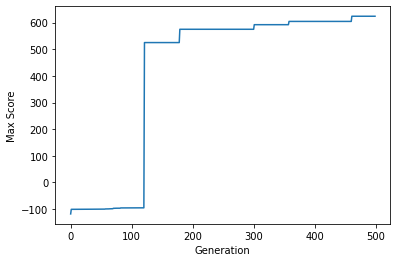

In [53]:
x = []
y = []
for i in range(500):
    x.append(i)
for score in allScores:
    y.append(score[1])
plt.xlabel('Generation')
plt.ylabel('Max Score')
plt.plot(x, y)
plt.show()

In [54]:
x = []
y = []
for i in range(500):
    x.append(i)

for score in allScores:
    y.append(score[2])
plt.xlabel('Generation')
plt.ylabel('Average Score')
plt.plot(x, y)
plt.show()